In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

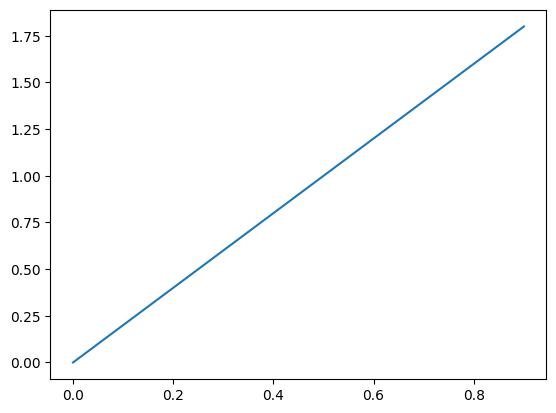

In [2]:
plt.plot(np.arange(0, 1, 0.1), 2*np.arange(0, 1, 0.1))

In [3]:
import h5py

In [4]:
from scipy.stats import norm

In [5]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch import nn, optim
import scipy.io as sio
# import pandas as pd
import datetime
import os
# import readligo as rl
# from gwpy.timeseries import TimeSeries
import math
import random

import copy

In [6]:
os.chdir('D:\\OneDrive - HKUST Connect\Research\GWNMMAD\GWAD\Codes')

In [7]:
import torch.nn.functional as F

In [8]:
epochs_wsl = 100;

In [9]:
epochs = 100
rTrain = 0.7;
rTest = 0.2;
# input_vector_length = 100
batch_size = 32
num_bins = 40
coef_delta = 0

# 4-AE + WSL

## Networks

In [9]:
class AutoEncoder_1det(nn.Module):
    def __init__(self):
        super(AutoEncoder_1det, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(101, 20),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(20, 101),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [9]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(202, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 202),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [43]:
class WSClassifier(nn.Module):
    def __init__(self):
        super(WSClassifier, self).__init__()
        self.fc1 = nn.Linear(101, 32)  # 第一层全连接层，输入维度为4，输出维度为64
        self.norm1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()  # 激活函数
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(32, 8)
        self.norm2 = nn.BatchNorm1d(8)
        self.fc4 = nn.Linear(8, 1)  # 第三层全连接层，输入维度为32，输出维度为类别数目
        
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.kaiming_normal_(self.fc4.weight)

    def forward(self, x):
        x = self.norm1(self.relu(self.fc1(x)))
        x = self.norm2(self.relu(self.fc2(x)))
        return self.fc4(x)
        # x = self.relu(x)
#         x = self.sigmoid(x)

In [10]:
class WSClassifier(nn.Module):
    def __init__(self):
        super(WSClassifier, self).__init__()
        self.fc1 = nn.Linear(101, 32)  # 第一层全连接层，输入维度为4，输出维度为64
        self.norm1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()  # 激活函数
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(32, 1)
        # self.norm2 = nn.BatchNorm1d(8)
        # self.fc4 = nn.Linear(8, 1)  # 第三层全连接层，输入维度为32，输出维度为类别数目
        
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        # nn.init.kaiming_normal_(self.fc4.weight)

    def forward(self, x):
        x = self.norm1(self.relu(self.fc1(x)))
        return self.fc2(x)
        # x = self.relu(x)
#         x = self.sigmoid(x)

In [11]:
class WSClassifier(nn.Module):
    def __init__(self):
        super(WSClassifier, self).__init__()
        self.fc1 = nn.Linear(202, 32)  # 第一层全连接层，输入维度为4，输出维度为64
        self.norm1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()  # 激活函数
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(32, 1)
        # self.norm2 = nn.BatchNorm1d(8)
        # self.fc4 = nn.Linear(8, 1)  # 第三层全连接层，输入维度为32，输出维度为类别数目
        
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        # nn.init.kaiming_normal_(self.fc4.weight)

    def forward(self, x):
        x = self.norm1(self.relu(self.fc1(x)))
        return self.fc2(x)
        # x = self.relu(x)
#         x = self.sigmoid(x)

In [12]:
ae = AutoEncoder().cuda()
print(sum(p.numel() for p in ae.parameters() if p.requires_grad))

8732


In [13]:
wsc = WSClassifier().cuda()
print(sum(p.numel() for p in wsc.parameters() if p.requires_grad))

6593


In [14]:
wsc

WSClassifier(
  (fc1): Linear(in_features=202, out_features=32, bias=True)
  (norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

## data loading

In [36]:
list_datatype = ["noise", "bbh", "sg", "glitch"]

In [16]:
N_wsl_total = 3000;
N_wsl = {}
N_wsl["noise"] = int(0.75*N_wsl_total)
N_wsl["bbh"] = int(0.1*N_wsl_total)
N_wsl["sg"] = int(0.1*N_wsl_total)
N_wsl["glitch"] = int(0.05*N_wsl_total)

In [14]:
N_wsl_total = 30000;
N_wsl = {}
N_wsl["noise"] = int(0.75*N_wsl_total)
N_wsl["bbh"] = int(0.1*N_wsl_total)
N_wsl["sg"] = int(0.1*N_wsl_total)
N_wsl["glitch"] = int(0.05*N_wsl_total)

In [37]:
N_wsl_total = 30000;
N_wsl = {}
N_wsl["noise"] = int(0.85*N_wsl_total)
N_wsl["bbh"] = int(0.04*N_wsl_total)
N_wsl["sg"] = int(0.04*N_wsl_total)
N_wsl["glitch"] = int(0.07*N_wsl_total)

In [17]:
renorm_factor_0 = 20;
renorm_factor_1 = 20;

realbkg = np.load('E://GWNMMAD_data/Tw_dataset/Datasets/background.npz')['data'].reshape(-1,200) / renorm_factor_0;
realbbh = np.load('E://GWNMMAD_data/Tw_dataset/Datasets/bbh_for_challenge.npy').reshape(-1,200) / renorm_factor_0;

realsg = np.load('E://GWNMMAD_data/Tw_dataset/Datasets/sglf_for_challenge.npy').reshape(-1,200) / renorm_factor_0;
# realglitch = np.load("../data/real_glitches_9998_4000Hz_25ms.npz")["strain_time_data"]
realglitch_L = np.load("../Data_cached/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"][:30000].reshape(-1,1,200) / renorm_factor_1
realglitch_H = np.load('../Data_cached/real_glitches_H_snrlt5_59732_4000Hz_25ms.npz')["strain_time_data"][:30000].reshape(-1,1,200) / renorm_factor_1

In [38]:
## If one is using Chia-Jui's data

renorm_factor_0 = 20;
renorm_factor_1 = 20;

realbkg_L = np.load('../Data_cached/real_bkg_2202000_63917s_4000Hz_50ms.npy')[:1000000].reshape(-1,1,200) / renorm_factor_0;
realbkg_H = np.load('../Data_cached/real_bkg_H_1466640_58803s_4000Hz_50ms.npy')[:1000000].reshape(-1,1,200) / renorm_factor_0;

realbkg = np.concatenate((realbkg_L, realbkg_H), axis = 1).reshape(-1,200)

realbbh = np.load('../Data_cached/injected_BBH_1823_around_merger_time_63917_58803.npz')['strain'].reshape(-1,200) / renorm_factor_0;

realsg = np.load('../Data_cached/injected_lfsg_1835_around_merger_time_63917_58803.npz')['strain'].reshape(-1,200) / renorm_factor_0;
# realglitch = np.load("../data/real_glitches_9998_4000Hz_25ms.npz")["strain_time_data"]
realglitch_L = np.load("../Data_cached/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"][:30000].reshape(-1,1,200) / renorm_factor_1
realglitch_H = np.load('../Data_cached/real_glitches_H_snrlt5_59732_4000Hz_25ms.npz')["strain_time_data"][:30000].reshape(-1,1,200) / renorm_factor_1

Normal procedure for one glitch + one noise

In [234]:
noise_first50k = realbkg.reshape(-1,2,200)[:30000]

glitch_L_noise_H = np.concatenate((realglitch_L, noise_first50k[:,[1],:]), axis = 1)
glitch_H_noise_L = np.concatenate((realglitch_H, noise_first50k[:,[0],:]), axis = 1)
realglitch = np.vstack((glitch_L_noise_H, glitch_H_noise_L))
np.random.shuffle(realglitch)
realglitch = realglitch.reshape(-1,200)
realbkg = realbkg[60000:]

In [235]:
realbkg_reserved = realbkg[-int(0.2 * len(realbkg)):]
realbbh_reserved = realbbh[-int(0.2 * len(realbbh)):]
realsg_reserved = realsg[-int(0.2 * len(realsg)):]
realglitch_reserved = realglitch[-int(0.2 * len(realglitch)):]

realbkg = realbkg[:-int(0.2 * len(realbkg))]
realbbh = realbbh[:-int(0.2 * len(realbbh))-int(0.2 * len(realbbh))%2]
realsg = realsg[:-int(0.2 * len(realsg))-int(0.2 * len(realsg))%2]
realglitch = realglitch[:-int(0.2 * len(realglitch))]

In [236]:
bkg_fft = abs(np.fft.rfft(realbkg))
bkg_fft = bkg_fft/np.linalg.norm([bkg_fft], axis=2).T

bbh_fft = abs(np.fft.rfft(realbbh))
bbh_fft = bbh_fft/np.linalg.norm([bbh_fft], axis=2).T

sg_fft = abs(np.fft.rfft(realsg))
sg_fft = sg_fft/np.linalg.norm([sg_fft], axis=2).T

glitch_fft = abs(np.fft.rfft(realglitch))
glitch_fft = glitch_fft/np.linalg.norm([glitch_fft], axis=2).T

Novel procedure. For training sample, the model is purely glitch trained. For testing and WSL sample, the model is one glitch + one noise

In [39]:
num_glitch_for_AE = int(len(realglitch_L) * 0.8) - N_wsl['glitch'] // 2

In [40]:
num_one_glitch_one_noise = int(len(realglitch_L) * 0.2) + N_wsl['glitch'] // 2

In [41]:
np.random.shuffle(realglitch_L)
np.random.shuffle(realglitch_H)

In [42]:
realglitch_L.shape

(30000, 1, 200)

In [43]:
realbkg.shape

(2000000, 200)

In [44]:
glitch_for_ae = np.concatenate((realglitch_L[:num_glitch_for_AE], realglitch_H[:num_glitch_for_AE]), axis=1).reshape(-1,200)
glitch_for_ae_fft = abs(np.fft.rfft(glitch_for_ae))
glitch_for_ae_fft = glitch_for_ae_fft/np.linalg.norm([glitch_for_ae_fft], axis=2).T

In [45]:
noise_for_glitch_building = realbkg[:2 * num_one_glitch_one_noise].reshape(-1,2,200)

glitch_L_noise_H = np.concatenate((realglitch_L[-num_one_glitch_one_noise:], noise_for_glitch_building[:,[1],:]), axis = 1)
noise_L_glitch_H = np.concatenate((noise_for_glitch_building[:,[0],:], realglitch_H[-num_one_glitch_one_noise:]), axis = 1)
one_glitch_one_noise = np.vstack((glitch_L_noise_H, noise_L_glitch_H))
np.random.shuffle(one_glitch_one_noise)
one_glitch_one_noise = one_glitch_one_noise.reshape(-1,200)

realbkg = realbkg[2 * num_one_glitch_one_noise:]

In [153]:
one_glitch_one_noise_fft = abs(np.fft.rfft(one_glitch_one_noise))
one_glitch_one_noise_fft = one_glitch_one_noise_fft/np.linalg.norm([one_glitch_one_noise_fft], axis=2).T

one_glitch_one_noise = one_glitch_one_noise / np.linalg.norm([one_glitch_one_noise_fft], axis=2).T

In [47]:
realbkg_reserved = realbkg[-int(0.2 * len(realbkg)):]
realbbh_reserved = realbbh[-int(0.2 * len(realbbh)):]
realsg_reserved = realsg[-int(0.2 * len(realsg)):]
# realglitch_reserved = realglitch[-int(0.2 * len(realglitch)):]

realbkg = realbkg[:-int(0.2 * len(realbkg))]
realbbh = realbbh[:-int(0.2 * len(realbbh))-int(0.2 * len(realbbh))%2]
realsg = realsg[:-int(0.2 * len(realsg))-int(0.2 * len(realsg))%2]
# realglitch = realglitch[:-int(0.2 * len(realglitch))]
bkg_fft = abs(np.fft.rfft(realbkg))
bkg_fft = bkg_fft/np.linalg.norm([bkg_fft], axis=2).T

bbh_fft = abs(np.fft.rfft(realbbh))
bbh_fft = bbh_fft/np.linalg.norm([bbh_fft], axis=2).T

sg_fft = abs(np.fft.rfft(realsg))
sg_fft = sg_fft/np.linalg.norm([sg_fft], axis=2).T

# glitch_fft = abs(np.fft.rfft(realglitch))
# glitch_fft = glitch_fft/np.linalg.norm([glitch_fft], axis=2).T

In [48]:
bkg_fft.shape

(1588720, 101)

In [48]:
glitch_fft.shape

NameError: name 'glitch_fft' is not defined

In [49]:
bbh_fft.shape

(2916, 101)

In [31]:
bbh_fft.shape

(2916, 101)

In [50]:
bkg_fft = bkg_fft.reshape(-1,202)

bbh_fft = bbh_fft.reshape(-1,202)

sg_fft = sg_fft.reshape(-1,202)

# glitch_fft = glitch_fft.reshape(-1,202)

glitch_for_ae_fft = glitch_for_ae_fft.reshape(-1,202)

one_glitch_one_noise_fft = one_glitch_one_noise_fft.reshape(-1,202)

In [31]:
del realbkg_L, realbkg_H, realglitch_L, realglitch_H, glitch_L_noise_H, glitch_H_noise_L

NameError: name 'glitch_H_noise_L' is not defined

In [59]:
# dataset_raw = {};
# dataset_raw["noise"] = np.load("E://GWNMMAD_data/Tw_dataset/Datasets/background.npz")['data'].reshape(-1,200);
# dataset_raw["bbh"] = np.load("E://GWNMMAD_data/Tw_dataset/Datasets/bbh_for_challenge.npy").reshape(-1,200);
# dataset_raw["sg"] = np.load("E://GWNMMAD_data/Tw_dataset/Datasets/sglf_for_challenge.npy").reshape(-1,200);
# # realglitch = np.load("../data/real_glitches_9998_4000Hz_25ms.npz")["strain_time_data"]
# dataset_raw["glitch"] = np.load("../Data_cached/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"]

# dataset_wsl = {};
# dataset_ae = {};
# dataset_wsl_fft = {};
# dataset_ae_fft = {};

# for dt in list_datatype:
#     perm = np.random.permutation(len(dataset_raw[dt]))
#     nwsl = N_wsl[dt]
#     dataset_wsl[dt] = dataset_raw[dt][perm[:nwsl]]
#     dataset_wsl[dt] = dataset_wsl[dt] / np.linalg.norm([dataset_wsl[dt]], axis=2).T
#     dataset_wsl_fft[dt] = abs(np.fft.rfft(dataset_wsl[dt]))
#     dataset_wsl_fft[dt] = dataset_wsl_fft[dt]/np.linalg.norm([dataset_wsl_fft[dt]], axis=2).T
    
#     dataset_ae[dt]  = dataset_raw[dt][perm[nwsl:]]
#     dataset_ae[dt] = dataset_ae[dt] / np.linalg.norm([dataset_ae[dt]], axis=2).T
#     dataset_ae_fft[dt] = abs(np.fft.rfft(dataset_ae[dt]))
#     dataset_ae_fft[dt] = dataset_ae_fft[dt]/np.linalg.norm([dataset_ae_fft[dt]], axis=2).T
    
#     np.savetxt("../Data_Cached/SequentialTraining/WSL/perm_"+dt+"_2det.dat", perm)

In [242]:
dataset_raw_fft = {}

dataset_raw_fft["noise"] = bkg_fft
dataset_raw_fft["bbh"] = bbh_fft
dataset_raw_fft["sg"] = sg_fft
dataset_raw_fft["glitch"] = glitch_fft

dataset_wsl = {};
dataset_ae = {};
dataset_wsl_fft = {};
dataset_ae_fft = {};

for dt in list_datatype:
    # perm = np.random.permutation(len(dataset_raw_fft[dt]))
    perm = np.loadtxt("../Data_Cached/SequentialTraining/WSL/perm_"+dt+"_2det_Chia-Jui_v7_GWAK.dat").astype(int)
    nwsl = N_wsl[dt]
    dataset_wsl_fft[dt] = dataset_raw_fft[dt][perm[:nwsl]]
    # dataset_wsl[dt] = dataset_wsl[dt] / np.linalg.norm([dataset_wsl[dt]], axis=2).T
    # dataset_wsl_fft[dt] = abs(np.fft.rfft(dataset_wsl[dt]))
    # dataset_wsl_fft[dt] = dataset_wsl_fft[dt]/np.linalg.norm([dataset_wsl_fft[dt]], axis=2).T
    
    dataset_ae_fft[dt]  = dataset_raw_fft[dt][perm[nwsl:]]
    # dataset_ae[dt] = dataset_ae[dt] / np.linalg.norm([dataset_ae[dt]], axis=2).T
    # dataset_ae_fft[dt] = abs(np.fft.rfft(dataset_ae[dt]))
    # dataset_ae_fft[dt] = dataset_ae_fft[dt]/np.linalg.norm([dataset_ae_fft[dt]], axis=2).T
    
    # np.savetxt("../Data_Cached/SequentialTraining/WSL/perm_"+dt+"_2det_Chia-Jui_"+version+"_2.dat", perm)

In [51]:
list_datatype = ["noise", "bbh", "sg", "glitch"]

In [52]:
dataset_raw_fft = {}

dataset_raw_fft["noise"] = bkg_fft
dataset_raw_fft["bbh"] = bbh_fft
dataset_raw_fft["sg"] = sg_fft
# dataset_raw_fft["glitch"] = glitch_fft

# dataset_wsl = {};
# dataset_ae = {};
dataset_wsl_fft = {};
dataset_ae_fft = {};

for dt in list_datatype[0:3]:
    perm = np.random.permutation(len(dataset_raw_fft[dt]))
    # perm = np.loadtxt("../Data_Cached/SequentialTraining/WSL/perm_"+dt+"_2det_Chia-Jui_v7_GWAK.dat").astype(int)
    nwsl = N_wsl[dt]
    dataset_wsl_fft[dt] = dataset_raw_fft[dt][perm[:nwsl]]
    # dataset_wsl[dt] = dataset_wsl[dt] / np.linalg.norm([dataset_wsl[dt]], axis=2).T
    # dataset_wsl_fft[dt] = abs(np.fft.rfft(dataset_wsl[dt]))
    # dataset_wsl_fft[dt] = dataset_wsl_fft[dt]/np.linalg.norm([dataset_wsl_fft[dt]], axis=2).T
    
    dataset_ae_fft[dt]  = dataset_raw_fft[dt][perm[nwsl:]]
    # dataset_ae[dt] = dataset_ae[dt] / np.linalg.norm([dataset_ae[dt]], axis=2).T
    # dataset_ae_fft[dt] = abs(np.fft.rfft(dataset_ae[dt]))
    # dataset_ae_fft[dt] = dataset_ae_fft[dt]/np.linalg.norm([dataset_ae_fft[dt]], axis=2).T
    
    # np.savetxt("../Data_Cached/SequentialTraining/WSL/perm_"+dt+"_2det_Chia-Jui_"+version+"_2.dat", perm)

In [53]:
dataset_wsl_fft['glitch'] = one_glitch_one_noise_fft[:N_wsl['glitch']]

dataset_ae_fft['glitch'] = glitch_for_ae_fft

In [54]:
np.linalg.norm(dataset_ae_fft['glitch'][0])

1.4142135623730951

In [55]:
for key in dataset_ae_fft.keys():
    print(key)
    print(dataset_ae_fft[key].shape)

noise
(768860, 202)
bbh
(258, 202)
sg
(268, 202)
glitch
(22950, 202)


In [37]:
for key in dataset_ae_fft.keys():
    print(key)
    print(dataset_ae_fft[key].shape)

noise
(768860, 202)
bbh
(258, 202)
sg
(268, 202)
glitch
(22950, 202)


In [38]:
for key in dataset_wsl_fft.keys():
    print(key)
    print(dataset_wsl_fft[key].shape)

noise
(25500, 202)
bbh
(1200, 202)
sg
(1200, 202)
glitch
(2100, 202)


In [56]:
realglitch_reserved = one_glitch_one_noise_fft[N_wsl['glitch']:]

In [57]:
bkg_reserved_fft = abs(np.fft.rfft(realbkg_reserved))
bkg_reserved_fft = bkg_reserved_fft/np.linalg.norm([bkg_reserved_fft], axis=2).T

bbh_reserved_fft = abs(np.fft.rfft(realbbh_reserved))
bbh_reserved_fft = bbh_reserved_fft/np.linalg.norm([bbh_reserved_fft], axis=2).T

sg_reserved_fft = abs(np.fft.rfft(realsg_reserved))
sg_reserved_fft = sg_reserved_fft/np.linalg.norm([sg_reserved_fft], axis=2).T

glitch_reserved_fft = abs(np.fft.rfft(realglitch_reserved))
glitch_reserved_fft = glitch_reserved_fft/np.linalg.norm([glitch_reserved_fft], axis=2).T

In [41]:
bkg_reserved_fft = bkg_reserved_fft.reshape(-1,202)

bbh_reserved_fft = bbh_reserved_fft.reshape(-1,202)

sg_reserved_fft = sg_reserved_fft.reshape(-1,202)

glitch_reserved_fft = glitch_reserved_fft.reshape(-1,202)

ValueError: cannot reshape array of size 73629 into shape (202)

In [59]:
N_reserved_test = {}

N_reserved_test_total = 20000

N_reserved_test['glitch'] = int(0.05 * N_reserved_test_total)
N_reserved_test['noise'] = int(0.65 * N_reserved_test_total)
N_reserved_test['bbh'] = int(0.15 * N_reserved_test_total)
N_reserved_test['sg'] = int(0.15 * N_reserved_test_total)

dataset_reserved_test_collected = np.vstack((glitch_reserved_fft[:N_reserved_test['glitch']], bkg_reserved_fft[:N_reserved_test['noise']],
                                             bbh_reserved_fft[:N_reserved_test['bbh']], sg_reserved_fft[:N_reserved_test['sg']]))

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 101 and the array at index 1 has size 202

In [31]:
dataset_reserved_test_collected.shape

NameError: name 'dataset_reserved_test_collected' is not defined

In [246]:
dataset_wsl_fft_collected = np.empty((0, dataset_wsl_fft["glitch"].shape[1]))
for dt in sequence:
    dataset_wsl_fft_collected = np.vstack((dataset_wsl_fft_collected, dataset_wsl_fft[dt]))

In [58]:
testset = dataset_wsl_fft_collected

NameError: name 'dataset_wsl_fft_collected' is not defined

## training

In [42]:
version = "v9";

In [43]:
epochs = 50;

In [44]:
sequence = ["glitch", "noise", "bbh", "sg"];
ind2datatype = {};
datatype2ind = {};
for i, dt in enumerate(sequence):
    ind2datatype[i] = dt;
    datatype2ind[dt] = i;
    
torch.save(ind2datatype, "../Data_cached/SequentialTraining/WSL/sequence_"+version+".json")

In [45]:
sequence = ["glitch", "noise", "bbh", "sg"];
dataset_wsl_fft_collected = np.empty((0, dataset_wsl_fft["glitch"].shape[1]))
for dt in sequence:
    dataset_wsl_fft_collected = np.vstack((dataset_wsl_fft_collected, dataset_wsl_fft[dt]))

In [30]:
# N_bkg = len(bkg_reserved_fft);
# N_glitch = int(N_bkg/15);
# N_bbh = int(N_bkg*2/15);
# N_sg = int(N_bkg*2/15);

# testset = np.empty((N_bkg+N_glitch+N_bbh+N_sg, len(bkg_reserved_fft[0])))

# s = 0;
# testset[s : s+N_glitch] = glitch_reserved_fft[np.random.permutation(len(glitch_reserved_fft))[:N_glitch]];
# s += N_glitch;

# testset[s : s+N_bkg] = bkg_reserved_fft[np.random.permutation(len(bkg_reserved_fft))[:N_bkg]];
# s += N_bkg;

# testset[s : s+N_bbh] = bbh_reserved_fft[np.random.permutation(len(bbh_reserved_fft))[:N_bbh]];
# s += N_bbh;

# testset[s : s+N_sg] = sg_reserved_fft[np.random.permutation(len(sg_reserved_fft))[:N_sg]];
# s += N_sg;

# correct_ans = np.concatenate(([0]*N_glitch, [1]*N_bkg, [2]*N_bbh, [3]*N_sg))

# Nsample = {};
# Nsample["glitch"] = N_glitch;
# Nsample["noise"] = N_bkg;
# Nsample["bbh"] = N_bbh;
# Nsample["sg"] = N_sg

In [31]:
# Ncut = 5;
# cutList = {};

# max_glitch = 0.0026;
# min_glitch = 0.001;
# cutList["glitch"] = np.linspace(min_glitch, max_glitch, Ncut);

# max_bkg = 0.0026;
# min_bkg = 0.001;
# cutList["noise"] = np.linspace(min_bkg, max_bkg, Ncut);

# max_bbh = 0.0024;
# min_bbh = 0.0008;
# cutList["bbh"] = np.linspace(min_bbh, max_bbh, Ncut);

# max_sg = 0.003;
# min_sg = 0.0003;
# cutList["sg"] = np.linspace(min_sg, max_sg, Ncut);

# torch.save(cutList, "../Data_cached/SequentialTraining/WSL/cut_"+version+".json")

In [34]:
Ncut = 5;
cutList = {};

max_glitch = 0.001;
min_glitch = 0.0024;
cutList["glitch"] = np.linspace(min_glitch, max_glitch, Ncut);

max_bkg = 0.0008;
min_bkg = 0.0018;
cutList["noise"] = np.linspace(min_bkg, max_bkg, Ncut);

max_bbh = 0.0014;
min_bbh = 0.0024;
cutList["bbh"] = np.linspace(min_bbh, max_bbh, Ncut);

max_sg = 0.0008;
min_sg = 0.0032;
cutList["sg"] = np.linspace(min_sg, max_sg, Ncut);

torch.save(cutList, "../Data_cached/SequentialTraining/WSL/cut_"+version+".json")

In [191]:
Ncut = 5;
cutList = {};

max_glitch = 0.001;
min_glitch = 0.0024;
cutList["glitch"] = np.linspace(min_glitch, max_glitch, Ncut);

max_bkg = 0.0008;
min_bkg = 0.0018;
cutList["noise"] = np.linspace(min_bkg, max_bkg, Ncut);

max_bbh = 0.0014;
min_bbh = 0.0024;
cutList["bbh"] = np.linspace(min_bbh, max_bbh, Ncut);

max_sg = 0.0008;
min_sg = 0.0032;
cutList["sg"] = np.linspace(min_sg, max_sg, Ncut);

# torch.save(cutList, "../Data_cached/SequentialTraining/WSL/cut_"+version+".json")

In [46]:
Ncut = 5;
cutList = {};

max_glitch_L = 0.0008;
min_glitch_L = 0.0024;
cutList["glitch_L"] = np.linspace(min_glitch_L, max_glitch_L, Ncut);

max_glitch_H = 0.0004;
min_glitch_H = 0.0024;
cutList["glitch_H"] = np.linspace(min_glitch_H, max_glitch_H, Ncut);

max_bkg = 0.0008;
min_bkg = 0.0018;
cutList["noise"] = np.linspace(min_bkg, max_bkg, Ncut);

max_bbh = 0.0014;
min_bbh = 0.0024;
cutList["bbh"] = np.linspace(min_bbh, max_bbh, Ncut);

max_sg = 0.0008;
min_sg = 0.0032;
cutList["sg"] = np.linspace(min_sg, max_sg, Ncut);

torch.save(cutList, "../Data_cached/SequentialTraining/WSL/cut_"+version+".json")

In [33]:
# models = {};
# models["glitch"] = torch.load("../Model_cached/4ae_3.pt")
# models["glitch"].cpu().eval()

In [192]:
models = {};
models["glitch"] = torch.load('../Model_cached/2_det_oneglitchonenoise_Chia-Jui_glitch_trained_202-20-202.pt')
models["glitch"].cpu().eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=202, out_features=20, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=202, bias=True)
    (1): Sigmoid()
  )
)

In [47]:
def trainAE(dataset, cutID, version, datatype):
    
    nTotal = len(dataset);
    nTrain = int(rTrain * nTotal)
    nTest = int(rTest * nTotal)

    X_train = dataset[:nTrain]
    X_test = dataset[-nTest:]
    X_validation = dataset[nTrain:-nTest]

    trainData = torch.FloatTensor(X_train)
    testData = torch.FloatTensor(X_test)
    validationData = torch.FloatTensor(X_validation)

    train_dataset = TensorDataset(trainData)
    test_dataset = TensorDataset(testData)
    validation_dataset = TensorDataset(validationData)

    trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

    autoencoder = AutoEncoder().cuda()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
    loss_func = nn.MSELoss().cuda()
    
    loss_train = np.empty(epochs)
    loss_validation = np.empty(epochs)

    for epoch in range(epochs):

        autoencoder.train()
        for batchidx, x in enumerate(trainDataLoader):
            x = x[0].cuda()
            encoded, decoded = autoencoder(x)
            loss_overall = loss_func(decoded, x)
            weighted_lossTrain = loss_overall

            optimizer.zero_grad()
            weighted_lossTrain.backward()
            optimizer.step()
            
        autoencoder.eval()
        with torch.no_grad():
            val_loss = 0
            for batchidx, x in enumerate(validationDataLoader):
                x = x[0].cuda()
                encoded, decoded = autoencoder(x)
                lossVal = loss_func(decoded, x)
                val_loss += lossVal.item()

            val_loss /= len(validationDataLoader)

        loss_train[epoch] = weighted_lossTrain.item()
        loss_validation[epoch] = val_loss
    
    autoencoder.cpu().eval()
    _, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot(loss_train)
    ax[0].plot(loss_validation)
    
    dcd_train = autoencoder(torch.FloatTensor(X_train))[1].detach().numpy()
    err_train = np.var(X_train-dcd_train, axis=1)
    dcd_test = autoencoder(torch.FloatTensor(X_test))[1].detach().numpy()
    err_test = np.var(X_test-dcd_test, axis=1)
    foo = ax[1].hist(err_train, range=(0, max(err_train)), bins=50, density=True, histtype="step")
    foo = ax[1].hist(err_test, range=(0, max(err_train)), bins=50, density=True, histtype="step")
    
    plt.savefig("../Pic_cached/SequentialTraining/WSL/training_AE_"+cutID+"_" + version + "_" + datatype +"_trained.jpg")
    plt.close()
            
    return autoencoder.cpu().eval()

In [81]:
def trainAE(dataset, cutID, version, datatype):
    
    nTotal = len(dataset);
    nTrain = int(rTrain * nTotal)
    nTest = int(rTest * nTotal)

    X_train = dataset[:nTrain]
    X_test = dataset[-nTest:]
    X_validation = dataset[nTrain:-nTest]

    trainData = torch.FloatTensor(X_train)
    testData = torch.FloatTensor(X_test)
    validationData = torch.FloatTensor(X_validation)

    train_dataset = TensorDataset(trainData)
    test_dataset = TensorDataset(testData)
    validation_dataset = TensorDataset(validationData)

    trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

    autoencoder = AutoEncoder().cuda()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
    loss_func = nn.MSELoss().cuda()
    
    loss_train = np.empty(epochs)
    loss_validation = np.empty(epochs)

    for epoch in range(epochs):

        autoencoder.train()
        for batchidx, x in enumerate(trainDataLoader):
            x = x[0].cuda()
            encoded, decoded = autoencoder(x)
            loss_overall = loss_func(decoded, x)
            weighted_lossTrain = loss_overall

            optimizer.zero_grad()
            weighted_lossTrain.backward()
            optimizer.step()
            
        autoencoder.eval()
        with torch.no_grad():
            val_loss = 0
            for batchidx, x in enumerate(validationDataLoader):
                x = x[0].cuda()
                encoded, decoded = autoencoder(x)
                lossVal = loss_func(decoded, x)
                val_loss += lossVal.item()

            val_loss /= len(validationDataLoader)

        loss_train[epoch] = weighted_lossTrain.item()
        loss_validation[epoch] = val_loss
    
    autoencoder.cpu().eval()
    _, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot(loss_train)
    ax[0].plot(loss_validation)
    
    dcd_train = autoencoder(torch.FloatTensor(X_train))[1].detach().numpy()
    err_train = np.var(X_train-dcd_train, axis=1)
    dcd_test = autoencoder(torch.FloatTensor(X_test))[1].detach().numpy()
    err_test = np.var(X_test-dcd_test, axis=1)
    foo = ax[1].hist(err_train, range=(0, max(err_train)), bins=50, density=True, histtype="step")
    foo = ax[1].hist(err_test, range=(0, max(err_train)), bins=50, density=True, histtype="step")
    
    plt.savefig("../Pic_cached/SequentialTraining/WSL/training_AE_"+cutID+"_" + version + "_" + datatype +"_trained.jpg")
    plt.close()
            
    return autoencoder.cpu().eval()

In [48]:
def trainWSC(dataset0, dataset1, cutID, version, datatype):
# dataset0: bkg set from AE
# dataset1: identified signal from AE
    
    nTotal0, nTotal1 = len(dataset0), len(dataset1);
    nTrain0, nTrain1 = int(rTrain * nTotal0), int(rTrain * nTotal1)
    nTest0 , nTest1  = int(rTest * nTotal0) , int(rTest * nTotal1)

    X_train = np.concatenate((dataset0[:nTrain0], dataset1[:nTrain1]))
    X_test = np.concatenate((dataset0[-nTest0:], dataset1[-nTest1:]))
    X_validation = np.concatenate((dataset0[nTrain0:-nTest0], dataset1[nTrain1:-nTest1]))
    
    Y_train = np.concatenate((np.zeros((nTrain0, 1)), np.ones((nTrain1, 1))))
    Y_test = np.concatenate((np.zeros((nTest0, 1)), np.ones((nTest1, 1))))
    Y_validation = np.concatenate((np.zeros((dataset0[nTrain0:-nTest0].shape[0], 1)), np.ones((dataset1[nTrain1:-nTest1].shape[0], 1))))

#     trainData = torch.FloatTensor(X_train)
#     testData = torch.FloatTensor(X_test)
#     validationData = torch.FloatTensor(X_validation)

    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(Y_train))
    validation_dataset = TensorDataset(torch.FloatTensor(X_validation), torch.FloatTensor(Y_validation))
#     train_dataset = TensorDataset(torch.FloatTensor(X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))), torch.FloatTensor(Y_train.reshape((Y_train.shape[0], 1, Y_train.shape[1]))))
#     validation_dataset = TensorDataset(torch.FloatTensor(X_validation.reshape((X_validation.shape[0], 1, X_validation.shape[1]))), torch.FloatTensor(Y_validation.reshape((Y_validation.shape[0], 1, Y_validation.shape[1]))))

    trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True, drop_last=True)

    wsc = WSClassifier().cuda()
    optimizer = optim.Adam(wsc.parameters(), lr=0.00005)
    loss_func = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([nTrain0/nTrain1])).cuda()
    
    loss_train = np.empty(epochs)
    loss_validation = np.empty(epochs)

    for epoch in range(epochs):
#         t0 = time.time()
        wsc.train()
        for batchidx, (x, y) in enumerate(trainDataLoader):
            x = x.cuda()
            y = y.cuda()
            yprime = wsc(x)
            loss = loss_func(yprime, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        wsc.eval()
        with torch.no_grad():
            val_loss = 0
            for batchidx, (x, y) in enumerate(validationDataLoader):
                x = x.cuda()
                y = y.cuda()
                yprime = wsc(x)
                lossVal = loss_func(yprime, y)
                val_loss += lossVal.item()

            val_loss /= len(validationDataLoader)

        loss_train[epoch] = loss.item()
        loss_validation[epoch] = val_loss
#         print(time.time() - t0)
        
    wsc.cpu().eval()
    
    _, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot(loss_train)
    ax[0].plot(loss_validation)
    foo = ax[1].hist(nn.Sigmoid()(wsc(torch.FloatTensor(X_train))).detach().numpy().flatten(), range=(0, 1), bins=20, density=True, histtype="step")
    foo = ax[1].hist(nn.Sigmoid()(wsc(torch.FloatTensor(X_test ))).detach().numpy().flatten(), range=(0, 1), bins=20, density=True, histtype="step")
    
    plt.savefig("../Pic_cached/SequentialTraining/WSL/training_WSC_"+cutID+"_" + version + "_" + datatype +"_trained.jpg")
    plt.close()
    
    return wsc.cpu().eval()

In [37]:
model1 = trainWSC(dataset0, dataset1, "test").cpu().eval();

NameError: name 'dataset0' is not defined

In [75]:
import itertools

In [198]:
cnt = 0;

ic = np.zeros(4, dtype="int")

# loop for only the cut in glitch, noise and bbh as it's not really meaningful to set cut in sg w/o new signals
ic[2] = Ncut-1;
ic[3] = Ncut-1;

In [42]:
cnt = 0;

ic = np.zeros(4, dtype="int")

# loop for only the cut in glitch, noise and bbh as it's not really meaningful to set cut in sg w/o new signals
ic[2] = Ncut-1;
ic[3] = Ncut-1;

# listResult = {};
# listResult["cut"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)), dtype="int");
# listResult["ans"] = np.empty((Ncut**(len(list_datatype)-1), len(testset)), dtype="int");
# listResult["accuracy_4"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)))
# listResult["accuracy_2"] = np.empty((Ncut**(len(list_datatype)-1), 2))

for ic[0], ic[1] in itertools.product(np.arange(Ncut), np.arange(Ncut)):
# for ic[0], ic[1], ic[2], ic[3] in itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut), np.arange(Ncut)):
    cnt += 1;
    
    if cnt < 11:
        continue
    # elif cnt > 85:
    #     continue
    
    t0 = time.time()
    data_filtered = {};
    for dt in sequence:
        data_filtered[dt] = dataset_ae_fft[dt]
#     data_filtered["noise"] = bkg_fft;
#     data_filtered["bbh"] = bbh_fft;
#     data_filtered["sg"] = sg_fft;

    dataset_wsl_filtered = dataset_wsl_fft_collected
    
    cutID = "".join(str(ic[j]) for j in range(3)) + "_"+version
        
    for iPrev in range(2):
        previousStep = ind2datatype[iPrev];
        modelPrev = models[previousStep]; # previous step AE
        
        # train the WSC according to previous AE's cut
        
        dataset0 = data_filtered[previousStep] # here they haven't been updated yet
        
        dcd = modelPrev(torch.FloatTensor(dataset0))[1].detach().numpy();
        dataset1 = dataset0[np.var(dataset0-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
        
        dcd = modelPrev(torch.FloatTensor(dataset_wsl_filtered))[1].detach().numpy();
        dataset1 = dataset_wsl_filtered[np.var(dataset_wsl_filtered-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
        
        model = trainWSC(dataset0, dataset1, cutID, version, previousStep)
        models[previousStep+"_WSC"] = model;
        
        # filter the data according to previous WSC
        for j in range(iPrev, 4):
            dt = ind2datatype[j];
            dcd = nn.Sigmoid()(model(torch.FloatTensor(data_filtered[dt]))).detach().numpy().flatten();
            data_filtered[dt] = data_filtered[dt][dcd>0.5]
        
#         # filter the data
#         for j in range(iPrev+1, 4):
#             dt = ind2datatype[j];
#             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
#             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
        
        # train the current step AE
        currentStep = ind2datatype[iPrev+1];
        model = trainAE(data_filtered[currentStep], cutID, version, currentStep);
        models[currentStep] = model;
        
    torch.save(models, "../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(2)) + "_"+version+".json")
    print(models.keys())
    
#     dcd = {};
#     err = {};
#     ans = np.zeros(len(testset), dtype="int")
    
#     for datatype in list_datatype:
#         dcd[datatype] = models[datatype](torch.FloatTensor(testset))[1].detach().numpy()
#         err[datatype] = np.var(testset-dcd[datatype], axis=1)
        
#     not_select = np.array([True]*len(testset));

#     for iStep in range(len(list_datatype)):
#         datatype = ind2datatype[iStep];
#         ind_pass = np.logical_and(not_select, err[datatype] <= cutList[datatype][ic[iStep]]);
#         ans[ind_pass] = iStep;
#         not_select[ind_pass] = False;
        
#     ans[not_select] = -1;
    
#     listResult["cut"][cnt] = ic;
#     listResult["ans"][cnt] = ans;
    
#     acc = np.zeros(len(ind2datatype));
    
#     for i in range(len(ind2datatype)):
#         acc[i] = np.sum(np.logical_and(ans==i, correct_ans==i))/Nsample[ind2datatype[i]];
        
#     listResult["accuracy_4"][cnt] = acc;
    
#     listResult["accuracy_2"][cnt] = [ np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["glitch", "noise"])/np.sum(Nsample[dtype] for dtype in ["glitch", "noise"]), 
#                                      np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["bbh", "sg"])/np.sum(Nsample[dtype] for dtype in ["bbh", "sg"])]
    # cnt += 1
    print(cnt)
    print(time.time() - t0)
    
# listResult["total_accuracy"] = np.sum(listResult["ans"]==correct_ans, axis=1)/len(testset);
# torch.save(listResult, "../data/SequentialTraining/training_performance_"+version+".json")

In [40]:
testset = dataset_wsl_fft_collected

In [171]:
testset = dataset_reserved_test_collected

In [195]:
testset.shape

(3000, 202)

In [81]:
correct_ans = np.hstack(([0]*N_wsl['glitch'], [1]*N_wsl['noise'], [2]*N_wsl['bbh'], [3]*N_wsl['sg']))

In [193]:
correct_ans_withoutsignal = np.hstack(([0]*N_wsl['glitch'], [1]*N_wsl['noise'], [-1]*(N_wsl['bbh']+N_wsl['sg'])))

In [173]:
correct_ans_withoutsignal = np.hstack(([0]*N_reserved_test['glitch'], [1]*N_reserved_test['noise'], [2]*N_reserved_test['bbh'], [3]*N_reserved_test['sg']))

In [82]:
correct_ans.shape

(3000,)

In [194]:
correct_ans_withoutsignal.shape

(3000,)

In [196]:
ic[3] = 0

NameError: name 'ic' is not defined

In [197]:
list_datatype_withoutsignal = ["noise", "glitch"]

In [85]:
ic_withoutsignal = np.array([0,0])

In [175]:
listResult = {};
listResult["cut"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), len(list_datatype_withoutsignal)), dtype="int");
listResult["ans"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), len(testset)), dtype="int");
listResult["accuracy_4"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), len(list_datatype_withoutsignal)))
listResult["accuracy_2"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), 2))
cnt = 0

listResult["FPR"] = np.empty((Ncut**(len(list_datatype_withoutsignal)),1))


for ic_withoutsignal[0], ic_withoutsignal[1] in itertools.product(np.arange(Ncut), np.arange(Ncut)):

    
    # if cnt < 86:
    #     continue
    
    t0 = time.time()
    data_filtered = {};
    for dt in sequence:
        data_filtered[dt] = dataset_ae_fft[dt]
#     data_filtered["noise"] = bkg_fft;
#     data_filtered["bbh"] = bbh_fft;
#     data_filtered["sg"] = sg_fft;

    dataset_wsl_filtered = dataset_wsl_fft_collected
    
    cutID = "".join(str(ic[j]) for j in range(3)) + "_"+version
        
#     for iPrev in range(3):
#         previousStep = ind2datatype[iPrev];
#         modelPrev = models[previousStep]; # previous step AE
        
#         # train the WSC according to previous AE's cut
        
#         dataset0 = data_filtered[previousStep] # here they haven't been updated yet
        
#         dcd = modelPrev(torch.FloatTensor(dataset0))[1].detach().numpy();
#         dataset1 = dataset0[np.var(dataset0-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
        
#         dcd = modelPrev(torch.FloatTensor(dataset_wsl_filtered))[1].detach().numpy();
#         dataset1 = dataset_wsl_filtered[np.var(dataset_wsl_filtered-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
        
#         model = trainWSC(dataset0, dataset1, cutID)
#         models[previousStep+"_WSC"] = model;
        
#         # filter the data according to previous WSC
#         for j in range(iPrev, 4):
#             dt = ind2datatype[j];
#             dcd = nn.Sigmoid()(model(torch.FloatTensor(data_filtered[dt]))).detach().numpy().flatten();
#             data_filtered[dt] = data_filtered[dt][dcd>0.5]
        
# #         # filter the data
# #         for j in range(iPrev+1, 4):
# #             dt = ind2datatype[j];
# #             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
# #             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
        
#         # train the current step AE
#         currentStep = ind2datatype[iPrev+1];
#         model = trainAE(data_filtered[currentStep], cutID);
#         models[currentStep] = model;
        
#     torch.save(models, "../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(3)) + "_"+version+".json")
#     print(models.keys())
    
    models = torch.load("../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic_withoutsignal[j]) for j in range(2)) + "_"+version+".json")
    # print("../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(2)) + "_"+version+".json")
    dcd = {};
    err = {};
    ans = np.zeros(len(testset), dtype="int")
    
    for datatype in list_datatype_withoutsignal:
        if datatype == 'sg':
            dcd[datatype] = models[datatype](torch.FloatTensor(testset))[1].detach().numpy()
            err[datatype] = np.var(testset-dcd[datatype], axis=1)
        
        # elif datatype == 'noise':
        #     dcd[datatype] = models[datatype](torch.FloatTensor(testset))[1].detach().numpy()
        #     err[datatype] = np.var(testset-dcd[datatype], axis=1)
            
        else:
            dcd[datatype] = nn.Sigmoid()(models[datatype + "_WSC"](torch.FloatTensor(testset))).detach().numpy().reshape(-1)
        
    not_select = np.array([True]*len(testset));

    # for iStep in range(len(list_datatype_withoutsignal)):
    #     datatype = ind2datatype[iStep];
    #     if datatype == 'sg':
    #         ind_pass = np.logical_and(not_select, err[datatype] <= cutList[datatype][ic[iStep]]);
    #     else:
    #         ind_pass = np.logical_and(not_select, dcd[datatype] <= 0.5);
    #     ans[ind_pass] = iStep;
    #     not_select[ind_pass] = False;
        
    # Pass glitch first
    
    datatype = 'glitch'
    ind_pass = np.logical_and(not_select, dcd[datatype] <= 0.5)
    ans[ind_pass] = 0;
    not_select[ind_pass] = False;
    # print(dcd['glitch'])
    
    # Leftover are noise and signals
    
    datatype = 'noise'
    ind_pass = np.logical_and(not_select, dcd[datatype] <= np.sort(dcd[datatype][-N_wsl['bbh']-N_wsl['sg']:])[int(0.1 * (N_wsl['bbh']+N_wsl['sg']))])
    # ind_pass = np.logical_and(not_select, err[datatype] <= np.sort(err[datatype][-N_wsl['bbh']-N_wsl['sg']:])[int(0.1 * (N_wsl['bbh']+N_wsl['sg']))])
    noise_number = np.sum(np.logical_and(not_select, correct_ans_withoutsignal == 1))
    passed_noise_number = noise_number - np.sum(np.logical_and(ind_pass, correct_ans_withoutsignal == 1))
    ans[ind_pass] = 1;
    not_select[ind_pass] = False;
    
    ans[not_select] = -1
    
    FPR = passed_noise_number / noise_number
    
    # print(dcd['noise'])
    print('For cnt = {}, totally {} noise events passed the glitch WSL, and {} noise events within the threshold for TPR=0.9'.format(cnt, noise_number, passed_noise_number))
    listResult['FPR'][cnt] = FPR
    listResult['cut'][cnt] = ic_withoutsignal
        
    # ans[not_select] = -1;

    # listResult["cut"][cnt] = ic_withoutsignal;
    # listResult["ans"][cnt] = ans;

    # acc = np.zeros(len(ind2datatype));

    # for i in range(len(ind2datatype)):
    #     acc[i] = np.sum(np.logical_and(ans==i, correct_ans_withoutsignal==i))/N_wsl[ind2datatype[i]];
        
    # listResult["accuracy_4"][cnt] = acc;

    # listResult["accuracy_2"][cnt] = [ np.sum(acc[datatype2ind[dtype]]*N_wsl[dtype] for dtype in ["glitch", "noise"])/np.sum(N_wsl[dtype] for dtype in ["glitch", "noise"]), 
    #                                     np.sum(acc[datatype2ind[dtype]]*N_wsl[dtype] for dtype in ["bbh", "sg"])/np.sum(N_wsl[dtype] for dtype in ["bbh", "sg"])]

    cnt += 1;

For cnt = 0, totally 12776 noise events passed the glitch WSL, and 63 noise events within the threshold for TPR=0.9
For cnt = 1, totally 12765 noise events passed the glitch WSL, and 146 noise events within the threshold for TPR=0.9
For cnt = 2, totally 12606 noise events passed the glitch WSL, and 290 noise events within the threshold for TPR=0.9
For cnt = 3, totally 12799 noise events passed the glitch WSL, and 928 noise events within the threshold for TPR=0.9
For cnt = 4, totally 12734 noise events passed the glitch WSL, and 3701 noise events within the threshold for TPR=0.9
For cnt = 5, totally 12877 noise events passed the glitch WSL, and 57 noise events within the threshold for TPR=0.9
For cnt = 6, totally 12878 noise events passed the glitch WSL, and 133 noise events within the threshold for TPR=0.9
For cnt = 7, totally 12882 noise events passed the glitch WSL, and 298 noise events within the threshold for TPR=0.9
For cnt = 8, totally 12888 noise events passed the glitch WSL, an

In [168]:
listResult['FPR']

array([[0.00491109],
       [0.00763618],
       [0.01615398],
       [0.02552832],
       [0.3534116 ],
       [0.00538358],
       [0.00857143],
       [0.01058646],
       [0.02269289],
       [0.26255669],
       [0.00435657],
       [0.01003512],
       [0.01658014],
       [0.02795447],
       [0.22990623],
       [0.00518742],
       [0.00602611],
       [0.01271754],
       [0.02942652],
       [0.24256599],
       [0.00384808],
       [0.00886436],
       [0.01120401],
       [0.03178321],
       [0.13259669]])

In [176]:
# This is the result for 0.05, 0.65, 0.15, 0.15

print(listResult['cut'][np.argmin(listResult['FPR'])])
print(listResult['FPR'].min())

[2 0]
0.0031699396938302147


In [167]:
# This is the result for 0.1, 0.3, 0.3, 0.3

print(listResult['cut'][np.argmin(listResult['FPR'])])
print(listResult['FPR'].min())

[4 0]
0.003848084323239083


In [126]:
np.argwhere(ans[-6000:] == 1).shape

(597, 1)

In [129]:
N_wsl['noise']

22500

In [133]:
np.argwhere(ans[1500:-6000] == 1).shape

(19118, 1)

In [132]:
np.argwhere(ans[1500:-6000] == -1).shape

(3320, 1)

In [102]:
np.argwhere(ans[-6000:] == -1).shape

(5398, 1)

In [103]:
np.argwhere(ans[1500:-6000] == -1).shape

(135, 1)

In [87]:
models = torch.load("../Data_cached/SequentialTraining/WSL/trained_model" + "04" + "_"+version+".json")

In [140]:
dataset_wsl_fft

{'noise': array([[0.07080046, 0.09553859, 0.19265593, ..., 0.005506  , 0.00548673,
         0.00548033],
        [0.00350913, 0.01590752, 0.04546304, ..., 0.00958689, 0.0095726 ,
         0.00956786],
        [0.02841971, 0.02774303, 0.12648465, ..., 0.00032194, 0.00025489,
         0.00022843],
        ...,
        [0.01154601, 0.02048553, 0.07837814, ..., 0.00322309, 0.00322733,
         0.00322873],
        [0.02085013, 0.02871224, 0.07719078, ..., 0.00583792, 0.00581294,
         0.00580466],
        [0.02815016, 0.04444268, 0.06928183, ..., 0.00045849, 0.00046117,
         0.00046205]]),
 'bbh': array([[0.03002271, 0.05669204, 0.20245602, ..., 0.00119762, 0.00119157,
         0.00118956],
        [0.03218402, 0.02064762, 0.34987885, ..., 0.00649457, 0.00647916,
         0.00647405],
        [0.0601964 , 0.07775103, 0.32046378, ..., 0.00607216, 0.00606419,
         0.00606152],
        ...,
        [0.04526151, 0.07766662, 0.34861724, ..., 0.00926247, 0.00922017,
         0.0092061

(0.0, 2000.0)

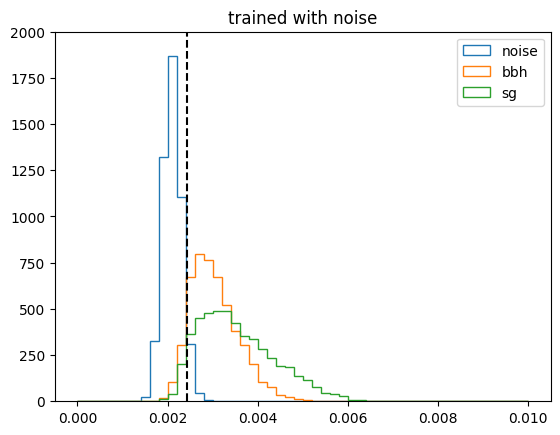

In [141]:
model = models['noise']

bkg_filtered = dataset_wsl_fft['noise']
bbh_filtered = dataset_wsl_fft['bbh']
sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.legend()
plt.ylim(0,2000)

In [147]:
model

WSClassifier(
  (fc1): Linear(in_features=202, out_features=32, bias=True)
  (norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

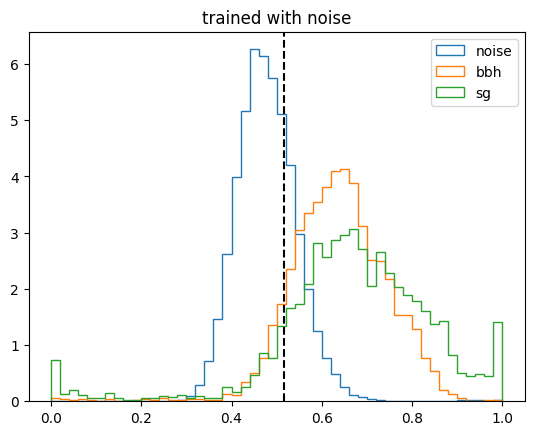

In [146]:
model = models['noise_WSC']

bkg_filtered = dataset_wsl_fft['noise']
bbh_filtered = dataset_wsl_fft['bbh']
sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

# foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.legend()
# plt.ylim(0,2000)

In [135]:
listResult['FPR']

array([[0.00560376],
       [0.01588806],
       [0.02525922],
       [0.07428777],
       [0.29004525],
       [0.00577879],
       [0.01164927],
       [0.02279853],
       [0.04604085],
       [0.27701613],
       [0.00392454],
       [0.0139595 ],
       [0.02496768],
       [0.04971686],
       [0.27548517],
       [0.00623608],
       [0.0083835 ],
       [0.02873179],
       [0.14465073],
       [0.30256365],
       [0.00623664],
       [0.01376821],
       [0.02466388],
       [0.08350033],
       [0.14796328]])

In [155]:
listResult['FPR'].min()

0.003924541765151853

In [151]:
listResult['FPR'][np.argwhere(listResult['cut'] == [2,0]).flatten()]

array([], shape=(0, 1), dtype=float64)

In [138]:
listResult['FPR']

array([[0.0382321 ],
       [0.03678628],
       [0.03791166],
       [0.0369185 ],
       [0.03972851],
       [0.03664382],
       [0.03754649],
       [0.03628057],
       [0.03802401],
       [0.03817204],
       [0.0379521 ],
       [0.04192311],
       [0.03758527],
       [0.03910465],
       [0.03774258],
       [0.03995546],
       [0.0367893 ],
       [0.03808633],
       [0.03779885],
       [0.03760904],
       [0.03973628],
       [0.03720536],
       [0.03948891],
       [0.04333111],
       [0.03725822]])

In [104]:
135 / 22500

0.006

In [115]:
cutList

{'glitch': array([0.0024 , 0.00215, 0.0019 , 0.00165, 0.0014 ]),
 'noise': array([0.0026, 0.0024, 0.0022, 0.002 , 0.0018]),
 'bbh': array([0.0024 , 0.00215, 0.0019 , 0.00165, 0.0014 ]),
 'sg': array([0.0032, 0.0026, 0.002 , 0.0014, 0.0008])}

Text(0, 0.5, 'percentage')

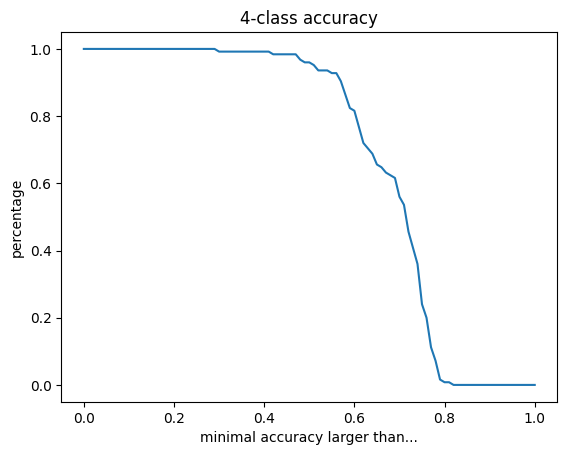

In [81]:
foo = np.array([ [0.01*A, np.sum(np.all(listResult["accuracy_4"] >= 0.01*A, axis=1))/len(listResult["accuracy_4"])] for A in range(101)])
plt.plot(foo[:, 0], foo[:, 1])
plt.title('4-class accuracy')
plt.xlabel('minimal accuracy larger than...')
plt.ylabel('percentage')

In [83]:
listResult["accuracy_4"][np.argwhere(np.all(listResult["accuracy_4"]>0.8, axis=1)).flatten()]

array([[0.998     , 0.94366667, 0.95925   , 0.81125   ]])

Text(0, 0.5, 'percentage')

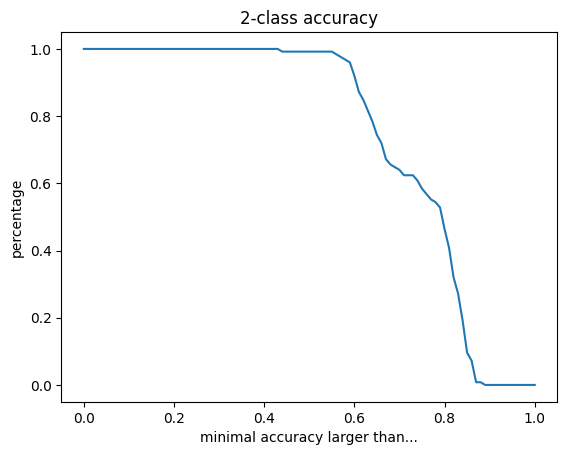

In [82]:
foo = np.array([ [0.01*A, np.sum(np.all(listResult["accuracy_2"] >= 0.01*A, axis=1))/len(listResult["accuracy_2"])] for A in range(101)])
plt.plot(foo[:, 0], foo[:, 1])
plt.title('2-class accuracy')
plt.xlabel('minimal accuracy larger than...')
plt.ylabel('percentage')

In [84]:
listResult["total_accuracy"] = np.sum(listResult["ans"]==correct_ans, axis=1)/len(testset)

In [87]:
listResult['total_accuracy'].max()

0.96345

In [88]:
listResult["accuracy_4"][np.argmax(listResult["accuracy_4"]>0.8).flatten()]

array([[0.999     , 0.95303333, 0.91975   , 0.69625   ]])

In [66]:
np.argwhere(np.all(np.array(list(itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut)))) == np.array([3,1,3]), axis = 1))

array([[83]], dtype=int64)

In [62]:
np.array(list(itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut))))

array([[0, 0, 0],
       [0, 0, 1],
       [0, 0, 2],
       [0, 0, 3],
       [0, 0, 4],
       [0, 1, 0],
       [0, 1, 1],
       [0, 1, 2],
       [0, 1, 3],
       [0, 1, 4],
       [0, 2, 0],
       [0, 2, 1],
       [0, 2, 2],
       [0, 2, 3],
       [0, 2, 4],
       [0, 3, 0],
       [0, 3, 1],
       [0, 3, 2],
       [0, 3, 3],
       [0, 3, 4],
       [0, 4, 0],
       [0, 4, 1],
       [0, 4, 2],
       [0, 4, 3],
       [0, 4, 4],
       [1, 0, 0],
       [1, 0, 1],
       [1, 0, 2],
       [1, 0, 3],
       [1, 0, 4],
       [1, 1, 0],
       [1, 1, 1],
       [1, 1, 2],
       [1, 1, 3],
       [1, 1, 4],
       [1, 2, 0],
       [1, 2, 1],
       [1, 2, 2],
       [1, 2, 3],
       [1, 2, 4],
       [1, 3, 0],
       [1, 3, 1],
       [1, 3, 2],
       [1, 3, 3],
       [1, 3, 4],
       [1, 4, 0],
       [1, 4, 1],
       [1, 4, 2],
       [1, 4, 3],
       [1, 4, 4],
       [2, 0, 0],
       [2, 0, 1],
       [2, 0, 2],
       [2, 0, 3],
       [2, 0, 4],
       [2,

In [73]:
ic

array([4, 4, 4, 4])

In [49]:
cutList

{'glitch': array([0.0024 , 0.00215, 0.0019 , 0.00165, 0.0014 ]),
 'noise': array([0.0026 , 0.00235, 0.0021 , 0.00185, 0.0016 ]),
 'bbh': array([0.0024 , 0.00215, 0.0019 , 0.00165, 0.0014 ]),
 'sg': array([0.0032, 0.0026, 0.002 , 0.0014, 0.0008])}

# Result for Chia-Jui noise trained model

In [150]:
testset = dataset_wsl_fft_collected

In [ ]:
testset = dataset_reserved_test_collected

In [249]:
testset.shape

(30000, 202)

In [50]:
correct_ans = np.hstack(([0]*N_wsl['glitch'], [1]*N_wsl['noise'], [2]*N_wsl['bbh'], [3]*N_wsl['sg']))

In [250]:
correct_ans_withoutsignal = np.hstack(([0]*N_wsl['glitch'], [1]*N_wsl['noise'], [-1]*(N_wsl['bbh']+N_wsl['sg'])))

In [ ]:
correct_ans_withoutsignal = np.hstack(([0]*N_reserved_test['glitch'], [1]*N_reserved_test['noise'], [2]*N_reserved_test['bbh'], [3]*N_reserved_test['sg']))

In [66]:
correct_ans.shape

NameError: name 'correct_ans' is not defined

In [251]:
correct_ans_withoutsignal.shape

(30000,)

In [199]:
ic[3] = 0

In [200]:
list_datatype_withoutsignal = ["noise", "glitch"]

In [201]:
ic_withoutsignal = np.array([0,0])

In [202]:
Ncut = 5

In [223]:
version = 'v7'

In [224]:
listResult = {};
listResult["cut"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), len(list_datatype_withoutsignal)), dtype="int");
listResult["ans"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), len(testset)), dtype="int");
listResult["accuracy_4"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), len(list_datatype_withoutsignal)))
listResult["accuracy_2"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), 2))
cnt = 0

listResult["FPR"] = np.empty((Ncut**(len(list_datatype_withoutsignal)),1))


for ic_withoutsignal[0], ic_withoutsignal[1] in itertools.product(np.arange(Ncut), np.arange(Ncut)):

    
    # if cnt < 86:
    #     continue
    
    t0 = time.time()
    data_filtered = {};
    for dt in sequence:
        data_filtered[dt] = dataset_ae_fft[dt]
#     data_filtered["noise"] = bkg_fft;
#     data_filtered["bbh"] = bbh_fft;
#     data_filtered["sg"] = sg_fft;

    dataset_wsl_filtered = dataset_wsl_fft_collected
    
    cutID = "".join(str(ic[j]) for j in range(3)) + "_"+version
        
#     for iPrev in range(3):
#         previousStep = ind2datatype[iPrev];
#         modelPrev = models[previousStep]; # previous step AE
        
#         # train the WSC according to previous AE's cut
        
#         dataset0 = data_filtered[previousStep] # here they haven't been updated yet
        
#         dcd = modelPrev(torch.FloatTensor(dataset0))[1].detach().numpy();
#         dataset1 = dataset0[np.var(dataset0-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
        
#         dcd = modelPrev(torch.FloatTensor(dataset_wsl_filtered))[1].detach().numpy();
#         dataset1 = dataset_wsl_filtered[np.var(dataset_wsl_filtered-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
        
#         model = trainWSC(dataset0, dataset1, cutID)
#         models[previousStep+"_WSC"] = model;
        
#         # filter the data according to previous WSC
#         for j in range(iPrev, 4):
#             dt = ind2datatype[j];
#             dcd = nn.Sigmoid()(model(torch.FloatTensor(data_filtered[dt]))).detach().numpy().flatten();
#             data_filtered[dt] = data_filtered[dt][dcd>0.5]
        
# #         # filter the data
# #         for j in range(iPrev+1, 4):
# #             dt = ind2datatype[j];
# #             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
# #             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
        
#         # train the current step AE
#         currentStep = ind2datatype[iPrev+1];
#         model = trainAE(data_filtered[currentStep], cutID);
#         models[currentStep] = model;
        
#     torch.save(models, "../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(3)) + "_"+version+".json")
#     print(models.keys())
    models = torch.load("../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic_withoutsignal[j]) for j in range(2)) + "_"+version+".json")
    # print("../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(2)) + "_"+version+".json")
    dcd = {};
    err = {};
    ans = np.zeros(len(testset), dtype="int")
    
    for datatype in list_datatype_withoutsignal:
        if datatype == 'sg':
            dcd[datatype] = models[datatype](torch.FloatTensor(testset))[1].detach().numpy()
            err[datatype] = np.var(testset-dcd[datatype], axis=1)
        
        # elif datatype == 'noise':
        #     dcd[datatype] = models[datatype](torch.FloatTensor(testset))[1].detach().numpy()
        #     err[datatype] = np.var(testset-dcd[datatype], axis=1)
            
        else:
            dcd[datatype] = nn.Sigmoid()(models[datatype + "_WSC"](torch.FloatTensor(testset))).detach().numpy().reshape(-1)
        
    not_select = np.array([True]*len(testset));

    # for iStep in range(len(list_datatype_withoutsignal)):
    #     datatype = ind2datatype[iStep];
    #     if datatype == 'sg':
    #         ind_pass = np.logical_and(not_select, err[datatype] <= cutList[datatype][ic[iStep]]);
    #     else:
    #         ind_pass = np.logical_and(not_select, dcd[datatype] <= 0.5);
    #     ans[ind_pass] = iStep;
    #     not_select[ind_pass] = False;
        
    # Pass glitch first
    
    datatype = 'glitch'
    ind_pass = np.logical_and(not_select, dcd[datatype] <= 0.5)
    ans[ind_pass] = 0;
    not_select[ind_pass] = False;
    # print(dcd['glitch'])
    
    # Leftover are noise and signals
    
    datatype = 'noise'
    ind_pass = np.logical_and(not_select, dcd[datatype] <= np.sort(dcd[datatype][-N_wsl['bbh']-N_wsl['sg']:])[int(0.1 * (N_wsl['bbh']+N_wsl['sg']))])
    # ind_pass = np.logical_and(not_select, err[datatype] <= np.sort(err[datatype][-N_wsl['bbh']-N_wsl['sg']:])[int(0.1 * (N_wsl['bbh']+N_wsl['sg']))])
    noise_number = np.sum(np.logical_and(not_select, correct_ans_withoutsignal == 1))
    passed_noise_number = noise_number - np.sum(np.logical_and(ind_pass, correct_ans_withoutsignal == 1))
    ans[ind_pass] = 1;
    not_select[ind_pass] = False;
    
    ans[not_select] = -1
    
    FPR = passed_noise_number / noise_number
    
    # print(dcd['noise'])
    print('For cnt = {}, totally {} noise events passed the glitch WSL, and {} noise events within the threshold for TPR=0.9'.format(cnt, noise_number, passed_noise_number))
    listResult['FPR'][cnt] = FPR
    listResult['cut'][cnt] = ic_withoutsignal
        
    # ans[not_select] = -1;

    # listResult["cut"][cnt] = ic_withoutsignal;
    # listResult["ans"][cnt] = ans;

    # acc = np.zeros(len(ind2datatype));

    # for i in range(len(ind2datatype)):
    #     acc[i] = np.sum(np.logical_and(ans==i, correct_ans_withoutsignal==i))/N_wsl[ind2datatype[i]];
        
    # listResult["accuracy_4"][cnt] = acc;

    # listResult["accuracy_2"][cnt] = [ np.sum(acc[datatype2ind[dtype]]*N_wsl[dtype] for dtype in ["glitch", "noise"])/np.sum(N_wsl[dtype] for dtype in ["glitch", "noise"]), 
    #                                     np.sum(acc[datatype2ind[dtype]]*N_wsl[dtype] for dtype in ["bbh", "sg"])/np.sum(N_wsl[dtype] for dtype in ["bbh", "sg"])]

    cnt += 1;

For cnt = 0, totally 949 noise events passed the glitch WSL, and 273 noise events within the threshold for TPR=0.9
For cnt = 1, totally 1139 noise events passed the glitch WSL, and 492 noise events within the threshold for TPR=0.9
For cnt = 2, totally 1707 noise events passed the glitch WSL, and 1386 noise events within the threshold for TPR=0.9
For cnt = 3, totally 1226 noise events passed the glitch WSL, and 975 noise events within the threshold for TPR=0.9
For cnt = 4, totally 1405 noise events passed the glitch WSL, and 1236 noise events within the threshold for TPR=0.9
For cnt = 5, totally 440 noise events passed the glitch WSL, and 138 noise events within the threshold for TPR=0.9
For cnt = 6, totally 347 noise events passed the glitch WSL, and 141 noise events within the threshold for TPR=0.9
For cnt = 7, totally 1065 noise events passed the glitch WSL, and 906 noise events within the threshold for TPR=0.9
For cnt = 8, totally 1303 noise events passed the glitch WSL, and 942 noi

C:\Users\Liyang Miao\AppData\Local\Temp\ipykernel_24064\2246366798.py:114: RuntimeWarning: invalid value encountered in scalar divide
  FPR = passed_noise_number / noise_number


In [252]:
listResult = {};
listResult["cut"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), len(list_datatype_withoutsignal)), dtype="int");
listResult["ans"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), len(testset)), dtype="int");
listResult["accuracy_4"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), len(list_datatype_withoutsignal)))
listResult["accuracy_2"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), 2))
cnt = 0

listResult["FPR"] = np.empty((Ncut**(len(list_datatype_withoutsignal)),1))


for ic_withoutsignal[0], ic_withoutsignal[1] in itertools.product(np.arange(Ncut), np.arange(Ncut)):

    
    # if cnt < 86:
    #     continue
    
    t0 = time.time()
    data_filtered = {};
    for dt in sequence:
        data_filtered[dt] = dataset_ae_fft[dt]
#     data_filtered["noise"] = bkg_fft;
#     data_filtered["bbh"] = bbh_fft;
#     data_filtered["sg"] = sg_fft;

    dataset_wsl_filtered = dataset_wsl_fft_collected
    
    cutID = "".join(str(ic[j]) for j in range(3)) + "_"+version
        
#     for iPrev in range(3):
#         previousStep = ind2datatype[iPrev];
#         modelPrev = models[previousStep]; # previous step AE
        
#         # train the WSC according to previous AE's cut
        
#         dataset0 = data_filtered[previousStep] # here they haven't been updated yet
        
#         dcd = modelPrev(torch.FloatTensor(dataset0))[1].detach().numpy();
#         dataset1 = dataset0[np.var(dataset0-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
        
#         dcd = modelPrev(torch.FloatTensor(dataset_wsl_filtered))[1].detach().numpy();
#         dataset1 = dataset_wsl_filtered[np.var(dataset_wsl_filtered-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
        
#         model = trainWSC(dataset0, dataset1, cutID)
#         models[previousStep+"_WSC"] = model;
        
#         # filter the data according to previous WSC
#         for j in range(iPrev, 4):
#             dt = ind2datatype[j];
#             dcd = nn.Sigmoid()(model(torch.FloatTensor(data_filtered[dt]))).detach().numpy().flatten();
#             data_filtered[dt] = data_filtered[dt][dcd>0.5]
        
# #         # filter the data
# #         for j in range(iPrev+1, 4):
# #             dt = ind2datatype[j];
# #             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
# #             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
        
#         # train the current step AE
#         currentStep = ind2datatype[iPrev+1];
#         model = trainAE(data_filtered[currentStep], cutID);
#         models[currentStep] = model;
        
#     torch.save(models, "../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(3)) + "_"+version+".json")
#     print(models.keys())
    models = torch.load("../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic_withoutsignal[j]) for j in range(2)) + "_"+version+".json")
    # print("../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(2)) + "_"+version+".json")
    dcd = {};
    err = {};
    ans = np.zeros(len(testset), dtype="int")
    
    for datatype in list_datatype_withoutsignal:
        if datatype == 'sg':
            dcd[datatype] = models[datatype](torch.FloatTensor(testset))[1].detach().numpy()
            err[datatype] = np.var(testset-dcd[datatype], axis=1)
        
        # elif datatype == 'noise':
        #     dcd[datatype] = models[datatype](torch.FloatTensor(testset))[1].detach().numpy()
        #     err[datatype] = np.var(testset-dcd[datatype], axis=1)
            
        else:
            dcd[datatype] = nn.Sigmoid()(models[datatype + "_WSC"](torch.FloatTensor(testset))).detach().numpy().reshape(-1)
        
    not_select = np.array([True]*len(testset));

    # for iStep in range(len(list_datatype_withoutsignal)):
    #     datatype = ind2datatype[iStep];
    #     if datatype == 'sg':
    #         ind_pass = np.logical_and(not_select, err[datatype] <= cutList[datatype][ic[iStep]]);
    #     else:
    #         ind_pass = np.logical_and(not_select, dcd[datatype] <= 0.5);
    #     ans[ind_pass] = iStep;
    #     not_select[ind_pass] = False;
        
    # Pass glitch first
    
    datatype = 'glitch'
    ind_pass = np.logical_and(not_select, dcd[datatype] <= 0.5)
    ans[ind_pass] = 0;
    not_select[ind_pass] = False;
    # print(dcd['glitch'])
    
    # Leftover are noise and signals
    
    datatype = 'noise'
    ind_pass = np.logical_and(not_select, dcd[datatype] <= np.sort(dcd[datatype][-N_wsl['bbh']-N_wsl['sg']:])[int(0.1 * (N_wsl['bbh']+N_wsl['sg']))])
    # ind_pass = np.logical_and(not_select, err[datatype] <= np.sort(err[datatype][-N_wsl['bbh']-N_wsl['sg']:])[int(0.1 * (N_wsl['bbh']+N_wsl['sg']))])
    noise_number = np.sum(np.logical_and(not_select, correct_ans_withoutsignal == 1))
    passed_noise_number = noise_number - np.sum(np.logical_and(ind_pass, correct_ans_withoutsignal == 1))
    ans[ind_pass] = 1;
    not_select[ind_pass] = False;
    
    ans[not_select] = -1
    
    FPR = passed_noise_number / noise_number
    
    # print(dcd['noise'])
    print('For cnt = {}, totally {} noise events passed the glitch WSL, and {} noise events within the threshold for TPR=0.9'.format(cnt, noise_number, passed_noise_number))
    listResult['FPR'][cnt] = FPR
    listResult['cut'][cnt] = ic_withoutsignal
        
    # ans[not_select] = -1;

    # listResult["cut"][cnt] = ic_withoutsignal;
    # listResult["ans"][cnt] = ans;

    # acc = np.zeros(len(ind2datatype));

    # for i in range(len(ind2datatype)):
    #     acc[i] = np.sum(np.logical_and(ans==i, correct_ans_withoutsignal==i))/N_wsl[ind2datatype[i]];
        
    # listResult["accuracy_4"][cnt] = acc;

    # listResult["accuracy_2"][cnt] = [ np.sum(acc[datatype2ind[dtype]]*N_wsl[dtype] for dtype in ["glitch", "noise"])/np.sum(N_wsl[dtype] for dtype in ["glitch", "noise"]), 
    #                                     np.sum(acc[datatype2ind[dtype]]*N_wsl[dtype] for dtype in ["bbh", "sg"])/np.sum(N_wsl[dtype] for dtype in ["bbh", "sg"])]

    cnt += 1;

For cnt = 0, totally 9736 noise events passed the glitch WSL, and 3139 noise events within the threshold for TPR=0.9
For cnt = 1, totally 11477 noise events passed the glitch WSL, and 5229 noise events within the threshold for TPR=0.9
For cnt = 2, totally 16871 noise events passed the glitch WSL, and 13791 noise events within the threshold for TPR=0.9
For cnt = 3, totally 12149 noise events passed the glitch WSL, and 9869 noise events within the threshold for TPR=0.9
For cnt = 4, totally 14283 noise events passed the glitch WSL, and 12756 noise events within the threshold for TPR=0.9
For cnt = 5, totally 4296 noise events passed the glitch WSL, and 1575 noise events within the threshold for TPR=0.9
For cnt = 6, totally 3503 noise events passed the glitch WSL, and 1566 noise events within the threshold for TPR=0.9
For cnt = 7, totally 10773 noise events passed the glitch WSL, and 9133 noise events within the threshold for TPR=0.9
For cnt = 8, totally 12940 noise events passed the glitch

In [253]:
listResult['FPR']

array([[0.32241167],
       [0.45560687],
       [0.81743821],
       [0.81233023],
       [0.89308969],
       [0.36662011],
       [0.44704539],
       [0.84776757],
       [0.762983  ],
       [0.83184937],
       [0.48174157],
       [0.30289193],
       [0.46153846],
       [0.30973451],
       [0.5390625 ],
       [0.        ],
       [0.26315789],
       [0.33333333],
       [0.45833333],
       [0.625     ],
       [0.        ],
       [0.6875    ],
       [0.64069264],
       [0.51851852],
       [0.56410256]])

In [205]:
listResult['FPR']

array([[0.934519  ],
       [0.90317195],
       [0.94658754],
       [0.92881647],
       [0.86232791],
       [0.94337607],
       [0.92515593],
       [0.87865169],
       [0.93217391],
       [0.94995532],
       [0.88051948],
       [0.93960674],
       [0.87687688],
       [0.93320426],
       [0.91064871],
       [0.87172775],
       [0.85365854],
       [0.92672999],
       [0.90941385],
       [0.72820513],
       [0.64      ],
       [0.87894737],
       [0.84615385],
       [0.83333333],
       [0.5974026 ]])

In [61]:
listResult['FPR']

array([[0.5395189 ],
       [0.6257485 ],
       [0.97066667],
       [0.97749196],
       [0.96601942],
       [0.76397516],
       [0.79538217],
       [0.85144928],
       [0.80729167],
       [0.82121212],
       [0.72485962],
       [0.74706183],
       [0.84575569],
       [0.94507772],
       [0.96520424],
       [0.75650118],
       [0.72650376],
       [0.84892086],
       [0.95040534],
       [0.97270588],
       [0.73227969],
       [0.87494167],
       [0.84670147],
       [0.93411765],
       [0.97877358]])

In [226]:
print(listResult['cut'][np.argmin(listResult['FPR'])])
print(listResult['FPR'].min())

[3 2]
nan


In [62]:
# This is the result for 0.05, 0.65, 0.15, 0.15

print(listResult['cut'][np.argmin(listResult['FPR'])])
print(listResult['FPR'].min())

[0 0]
0.5395189003436426


In [ ]:
# This is the result for 0.1, 0.3, 0.3, 0.3

print(listResult['cut'][np.argmin(listResult['FPR'])])
print(listResult['FPR'].min())

[4 0]
0.003848084323239083


In [ ]:
np.argwhere(ans[-6000:] == 1).shape

(597, 1)

In [ ]:
N_wsl['noise']

22500

In [ ]:
np.argwhere(ans[1500:-6000] == 1).shape

(19118, 1)

In [ ]:
np.argwhere(ans[1500:-6000] == -1).shape

(3320, 1)

In [ ]:
np.argwhere(ans[-6000:] == -1).shape

(5398, 1)

In [ ]:
np.argwhere(ans[1500:-6000] == -1).shape

(135, 1)

In [258]:
models = torch.load("../Data_cached/SequentialTraining/WSL/trained_model" + "00" + "_"+version+".json")

In [84]:
models = torch.load("../Data_cached/SequentialTraining/WSL/trained_model" + "00" + "_v6.json")

In [64]:
dataset_wsl_fft

{'noise': array([[3.75803461e-02, 5.19980410e-02, 7.11897231e-02, ...,
         5.70335581e-03, 5.66126335e-03, 5.66705806e-03],
        [5.11109784e-03, 2.90017348e-02, 6.21384329e-02, ...,
         5.31911077e-03, 5.28157705e-03, 5.30578589e-03],
        [2.67082197e-02, 3.85819943e-02, 2.05402769e-02, ...,
         7.47662214e-03, 7.44311073e-03, 7.42143186e-03],
        ...,
        [3.61762312e-02, 4.94204426e-02, 2.43239822e-02, ...,
         5.79947266e-04, 3.12861138e-04, 5.83874447e-05],
        [7.07041750e-03, 1.06595149e-02, 8.05424030e-02, ...,
         1.02448389e-02, 1.02258828e-02, 1.01878053e-02],
        [3.28809822e-02, 4.43646698e-02, 2.00710775e-02, ...,
         3.62308188e-03, 3.62523057e-03, 3.64992646e-03]]),
 'bbh': array([[7.57095507e-02, 8.49995596e-02, 1.87917767e-01, ...,
         9.56477804e-03, 9.59237338e-03, 9.53138379e-03],
        [4.18299326e-03, 3.26492974e-02, 1.64341977e-01, ...,
         9.86156797e-03, 9.92180863e-03, 9.95067674e-03],
        [

(0.0, 2000.0)

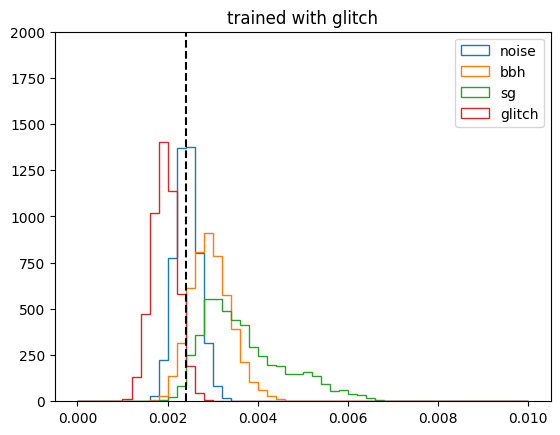

In [254]:
model = models['glitch']

bkg_filtered = dataset_wsl_fft['noise']
bbh_filtered = dataset_wsl_fft['bbh']
sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(0.0024, color = 'k', linestyle = '--')
plt.legend()
plt.ylim(0,2000)

(0.0, 2000.0)

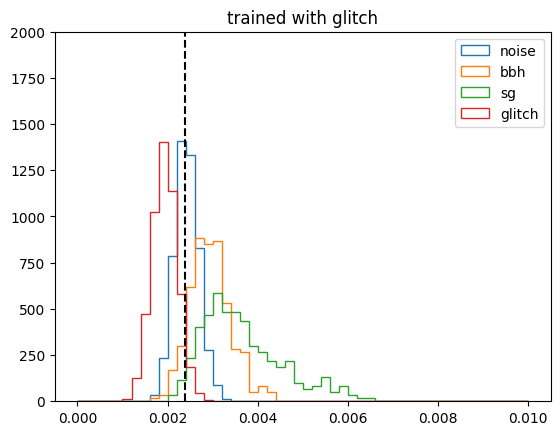

In [171]:
model = models['glitch']

bkg_filtered = dataset_wsl_fft['noise']
bbh_filtered = dataset_wsl_fft['bbh']
sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.legend()
plt.ylim(0,2000)

(0.0, 2000.0)

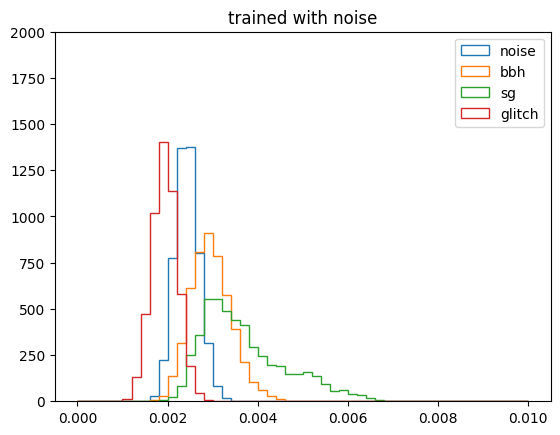

In [255]:
model = models['glitch']

bkg_filtered = dataset_wsl_fft['noise']
bbh_filtered = dataset_wsl_fft['bbh']
sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
# plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.legend()
plt.ylim(0,2000)

(0.0, 2000.0)

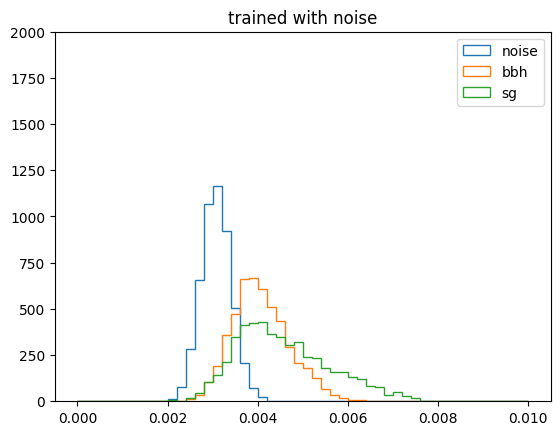

In [256]:
# GWAK data + Chia-Jui model

model = models['noise']

bkg_filtered = dataset_wsl_fft['noise']
bbh_filtered = dataset_wsl_fft['bbh']
sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
# plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
# plt.axvline(0.0018, color = 'k', linestyle = '--')
plt.legend()
plt.ylim(0,2000)

(0.0, 2000.0)

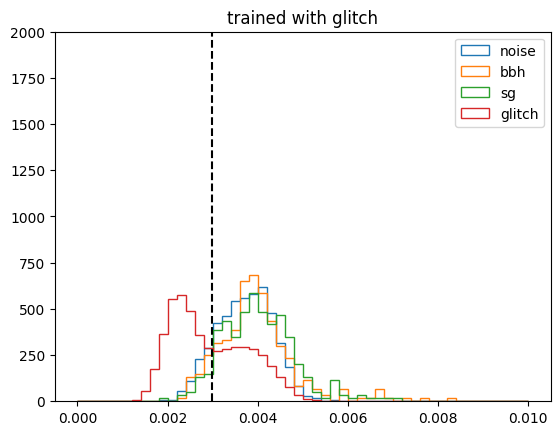

In [43]:
# Chia-Jui data + GWAK model

model = models['glitch']

bkg_filtered = dataset_wsl_fft['noise']
bbh_filtered = dataset_wsl_fft['bbh']
sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.legend()
plt.ylim(0,2000)

(0.0, 2000.0)

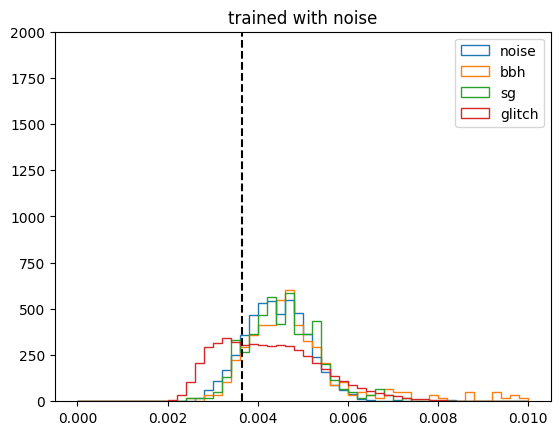

In [89]:
# Chia-Jui data + GWAK model

model = models['noise']

bkg_filtered = dataset_wsl_fft['noise']
bbh_filtered = dataset_wsl_fft['bbh']
sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.legend()
plt.ylim(0,2000)

(0.0, 2000.0)

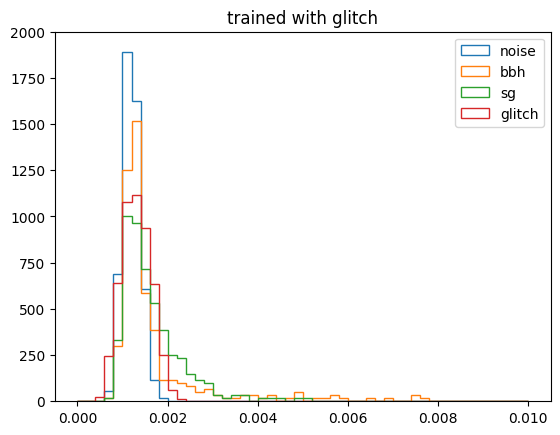

In [82]:
model = models['glitch']

bkg_filtered = dataset_wsl_fft['noise']
bbh_filtered = dataset_wsl_fft['bbh']
sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
# plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.legend()
plt.ylim(0,2000)

(0.0, 2000.0)

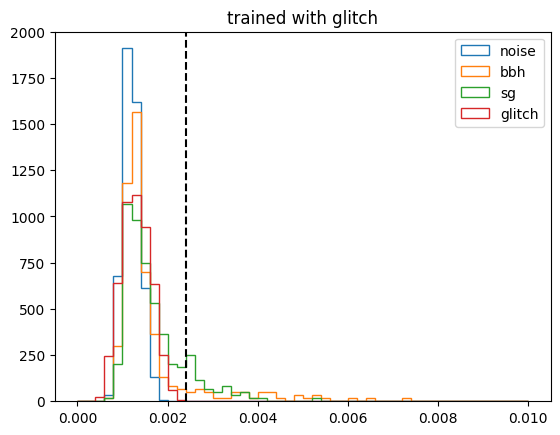

In [152]:
model = models['glitch']

bkg_filtered = dataset_wsl_fft['noise']
bbh_filtered = dataset_wsl_fft['bbh']
sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
# plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.axvline(0.0024, color = 'k', linestyle = '--')
plt.legend()
plt.ylim(0,2000)

In [125]:
model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=202, out_features=20, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=202, bias=True)
    (1): Sigmoid()
  )
)

(0.0, 2000.0)

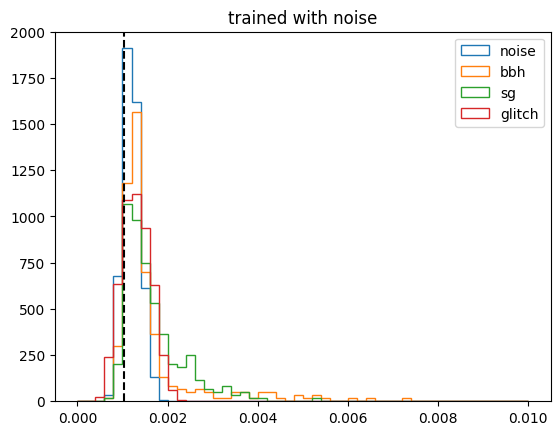

In [110]:
model = models['glitch']

bkg_filtered = dataset_wsl_fft['noise']
bbh_filtered = dataset_wsl_fft['bbh']
sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.legend()
plt.ylim(0,2000)

(0.0, 2000.0)

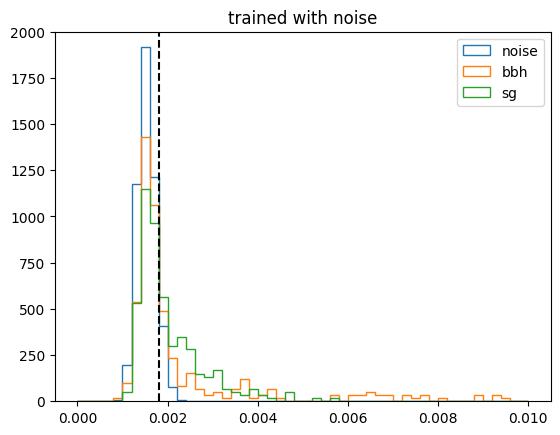

In [153]:
model = models['noise']

bkg_filtered = dataset_wsl_fft['noise']
bbh_filtered = dataset_wsl_fft['bbh']
sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
# plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.axvline(0.0018, color = 'k', linestyle = '--')
plt.legend()
plt.ylim(0,2000)

(0.0, 2000.0)

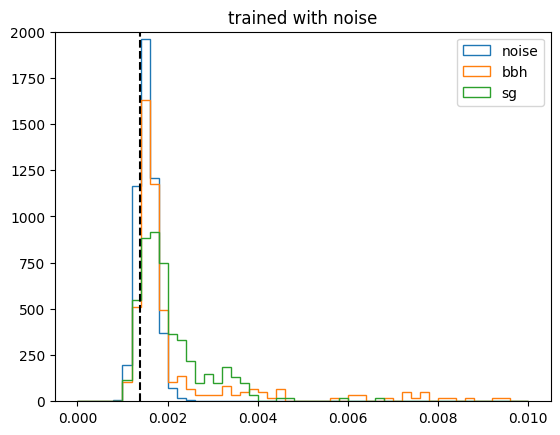

In [65]:
model = models['noise']

bkg_filtered = dataset_wsl_fft['noise']
bbh_filtered = dataset_wsl_fft['bbh']
sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.legend()
plt.ylim(0,2000)

In [66]:
model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=202, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=10, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=202, bias=True)
    (3): Sigmoid()
  )
)

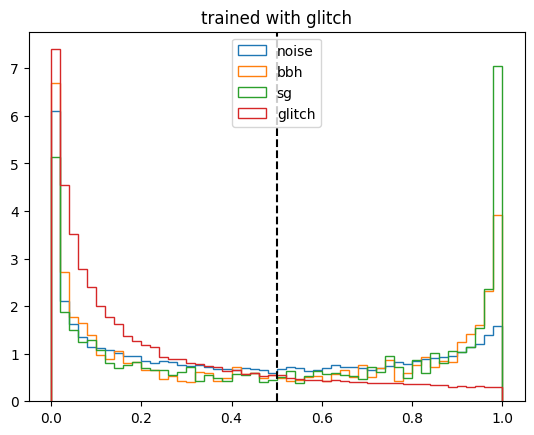

In [259]:
# GWAK data + Chia-Jui model

model = models['glitch_WSC']

bkg_filtered = dataset_wsl_fft['noise']
bbh_filtered = dataset_wsl_fft['bbh']
sg_filtered = dataset_wsl_fft['sg']


# c0[currentStep] = 0.0022;

dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = nn.Sigmoid()(model(torch.FloatTensor(glitch_fft))).detach().numpy()

# foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
# plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.axvline(0.5, color = 'k', linestyle = '--')
plt.legend()
# plt.ylim(0,2000)

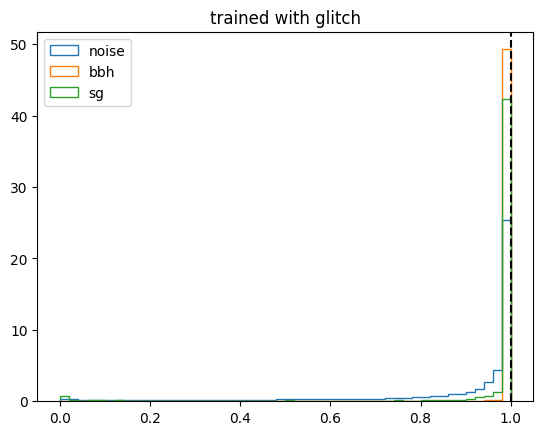

In [260]:
# GWAK data + Chia-Jui model

model = models['noise_WSC']

bkg_filtered = dataset_wsl_fft['noise']
bbh_filtered = dataset_wsl_fft['bbh']
sg_filtered = dataset_wsl_fft['sg']


# c0[currentStep] = 0.0022;

dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = nn.Sigmoid()(model(torch.FloatTensor(glitch_fft))).detach().numpy()

# foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
# foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.legend()
# plt.ylim(0,2000)

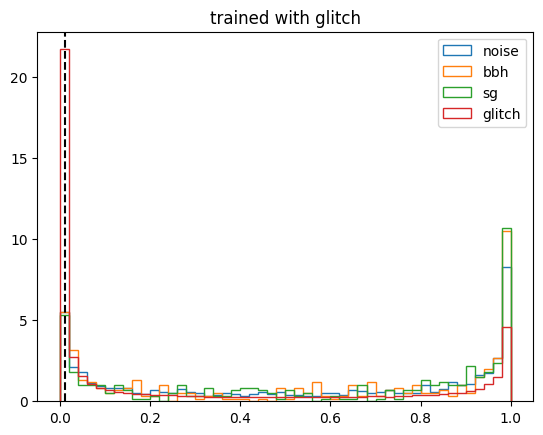

In [94]:
# Chia-Jui data + GWAK model

model = models['glitch_WSC']

bkg_filtered = dataset_wsl_fft['noise']
bbh_filtered = dataset_wsl_fft['bbh']
sg_filtered = dataset_wsl_fft['sg']


# c0[currentStep] = 0.0022;

dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = nn.Sigmoid()(model(torch.FloatTensor(glitch_fft))).detach().numpy()

# foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.legend()
# plt.ylim(0,2000)

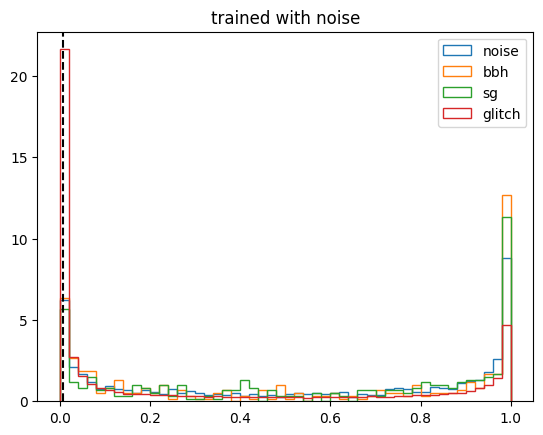

In [44]:
# Chia-Jui data + GWAK model

model = models['glitch_WSC']

bkg_filtered = dataset_wsl_fft['noise']
bbh_filtered = dataset_wsl_fft['bbh']
sg_filtered = dataset_wsl_fft['sg']


# c0[currentStep] = 0.0022;

dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = nn.Sigmoid()(model(torch.FloatTensor(glitch_fft))).detach().numpy()

# foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.legend()
# plt.ylim(0,2000)

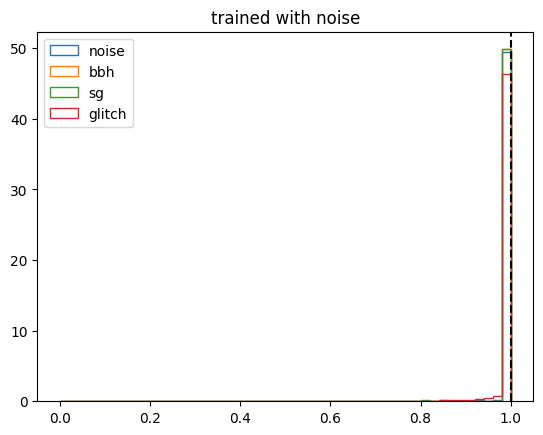

In [92]:
# Chia-Jui data + GWAK model

model = models['noise_WSC']

bkg_filtered = dataset_wsl_fft['noise']
bbh_filtered = dataset_wsl_fft['bbh']
sg_filtered = dataset_wsl_fft['sg']


# c0[currentStep] = 0.0022;

dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = nn.Sigmoid()(model(torch.FloatTensor(glitch_fft))).detach().numpy()

# foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.legend()
# plt.ylim(0,2000)

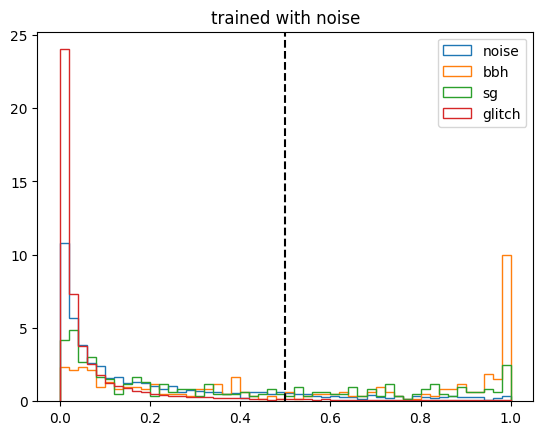

In [126]:
# Chia-Jui data + Chia-Jui model

model = models['glitch_WSC']

bkg_filtered = dataset_wsl_fft['noise']
bbh_filtered = dataset_wsl_fft['bbh']
sg_filtered = dataset_wsl_fft['sg']


# c0[currentStep] = 0.0022;

dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = nn.Sigmoid()(model(torch.FloatTensor(glitch_fft))).detach().numpy()

# foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
# plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.axvline(0.5, color = 'k', linestyle = '--')
plt.legend()
# plt.ylim(0,2000)

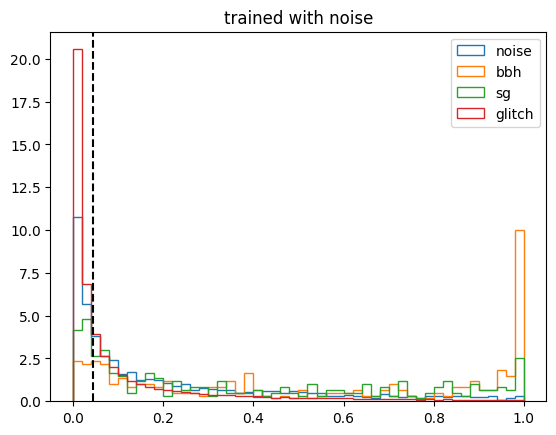

In [78]:
# Chia-Jui data + Chia-Jui model

model = models['glitch_WSC']

bkg_filtered = dataset_wsl_fft['noise']
bbh_filtered = dataset_wsl_fft['bbh']
sg_filtered = dataset_wsl_fft['sg']


# c0[currentStep] = 0.0022;

dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = nn.Sigmoid()(model(torch.FloatTensor(glitch_fft))).detach().numpy()

# foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.legend()
# plt.ylim(0,2000)

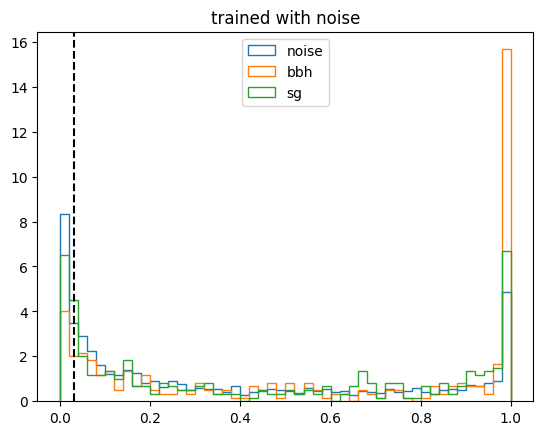

In [67]:
model = models['noise_WSC']

bkg_filtered = dataset_wsl_fft['noise']
bbh_filtered = dataset_wsl_fft['bbh']
sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

# foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.legend()
# plt.ylim(0,2000)

In [ ]:
listResult['FPR']

array([[0.00560376],
       [0.01588806],
       [0.02525922],
       [0.07428777],
       [0.29004525],
       [0.00577879],
       [0.01164927],
       [0.02279853],
       [0.04604085],
       [0.27701613],
       [0.00392454],
       [0.0139595 ],
       [0.02496768],
       [0.04971686],
       [0.27548517],
       [0.00623608],
       [0.0083835 ],
       [0.02873179],
       [0.14465073],
       [0.30256365],
       [0.00623664],
       [0.01376821],
       [0.02466388],
       [0.08350033],
       [0.14796328]])

In [ ]:
listResult['FPR'].min()

0.003924541765151853

In [ ]:
listResult['FPR'][np.argwhere(listResult['cut'] == [2,0]).flatten()]

array([], shape=(0, 1), dtype=float64)

In [ ]:
listResult['FPR']

array([[0.0382321 ],
       [0.03678628],
       [0.03791166],
       [0.0369185 ],
       [0.03972851],
       [0.03664382],
       [0.03754649],
       [0.03628057],
       [0.03802401],
       [0.03817204],
       [0.0379521 ],
       [0.04192311],
       [0.03758527],
       [0.03910465],
       [0.03774258],
       [0.03995546],
       [0.0367893 ],
       [0.03808633],
       [0.03779885],
       [0.03760904],
       [0.03973628],
       [0.03720536],
       [0.03948891],
       [0.04333111],
       [0.03725822]])

In [ ]:
135 / 22500

0.006

In [ ]:
cutList

{'glitch': array([0.0024 , 0.00215, 0.0019 , 0.00165, 0.0014 ]),
 'noise': array([0.0026, 0.0024, 0.0022, 0.002 , 0.0018]),
 'bbh': array([0.0024 , 0.00215, 0.0019 , 0.00165, 0.0014 ]),
 'sg': array([0.0032, 0.0026, 0.002 , 0.0014, 0.0008])}

Text(0, 0.5, 'percentage')

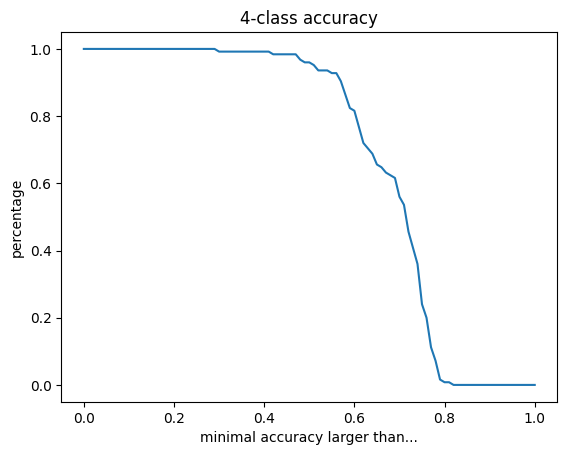

In [ ]:
foo = np.array([ [0.01*A, np.sum(np.all(listResult["accuracy_4"] >= 0.01*A, axis=1))/len(listResult["accuracy_4"])] for A in range(101)])
plt.plot(foo[:, 0], foo[:, 1])
plt.title('4-class accuracy')
plt.xlabel('minimal accuracy larger than...')
plt.ylabel('percentage')

In [ ]:
listResult["accuracy_4"][np.argwhere(np.all(listResult["accuracy_4"]>0.8, axis=1)).flatten()]

array([[0.998     , 0.94366667, 0.95925   , 0.81125   ]])

Text(0, 0.5, 'percentage')

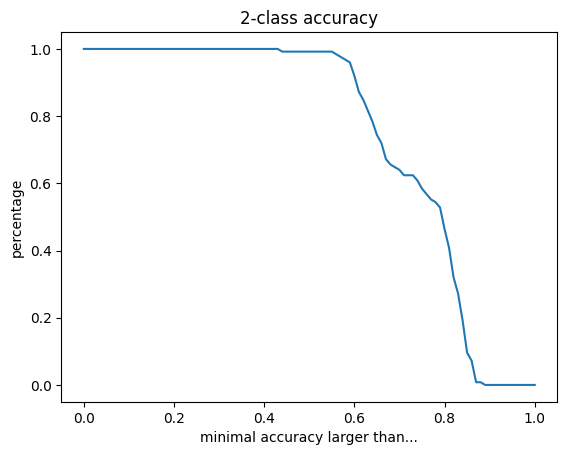

In [ ]:
foo = np.array([ [0.01*A, np.sum(np.all(listResult["accuracy_2"] >= 0.01*A, axis=1))/len(listResult["accuracy_2"])] for A in range(101)])
plt.plot(foo[:, 0], foo[:, 1])
plt.title('2-class accuracy')
plt.xlabel('minimal accuracy larger than...')
plt.ylabel('percentage')

In [ ]:
listResult["total_accuracy"] = np.sum(listResult["ans"]==correct_ans, axis=1)/len(testset)

In [ ]:
listResult['total_accuracy'].max()

0.96345

In [ ]:
listResult["accuracy_4"][np.argmax(listResult["accuracy_4"]>0.8).flatten()]

array([[0.999     , 0.95303333, 0.91975   , 0.69625   ]])

In [ ]:
np.argwhere(np.all(np.array(list(itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut)))) == np.array([3,1,3]), axis = 1))

array([[83]], dtype=int64)

In [ ]:
np.array(list(itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut))))

array([[0, 0, 0],
       [0, 0, 1],
       [0, 0, 2],
       [0, 0, 3],
       [0, 0, 4],
       [0, 1, 0],
       [0, 1, 1],
       [0, 1, 2],
       [0, 1, 3],
       [0, 1, 4],
       [0, 2, 0],
       [0, 2, 1],
       [0, 2, 2],
       [0, 2, 3],
       [0, 2, 4],
       [0, 3, 0],
       [0, 3, 1],
       [0, 3, 2],
       [0, 3, 3],
       [0, 3, 4],
       [0, 4, 0],
       [0, 4, 1],
       [0, 4, 2],
       [0, 4, 3],
       [0, 4, 4],
       [1, 0, 0],
       [1, 0, 1],
       [1, 0, 2],
       [1, 0, 3],
       [1, 0, 4],
       [1, 1, 0],
       [1, 1, 1],
       [1, 1, 2],
       [1, 1, 3],
       [1, 1, 4],
       [1, 2, 0],
       [1, 2, 1],
       [1, 2, 2],
       [1, 2, 3],
       [1, 2, 4],
       [1, 3, 0],
       [1, 3, 1],
       [1, 3, 2],
       [1, 3, 3],
       [1, 3, 4],
       [1, 4, 0],
       [1, 4, 1],
       [1, 4, 2],
       [1, 4, 3],
       [1, 4, 4],
       [2, 0, 0],
       [2, 0, 1],
       [2, 0, 2],
       [2, 0, 3],
       [2, 0, 4],
       [2,

In [ ]:
ic

array([4, 4, 4, 4])

In [ ]:
cutList

{'glitch': array([0.0024 , 0.00215, 0.0019 , 0.00165, 0.0014 ]),
 'noise': array([0.0026 , 0.00235, 0.0021 , 0.00185, 0.0016 ]),
 'bbh': array([0.0024 , 0.00215, 0.0019 , 0.00165, 0.0014 ]),
 'sg': array([0.0032, 0.0026, 0.002 , 0.0014, 0.0008])}

# Let's think about using 2 det for the glitch

In [49]:
models = {};
models["glitch_L"] = torch.load('../Model_cached/1_det_L_glitch_trained_with_permutation_1.pt')
models["glitch_H"] = torch.load('../Model_cached/1_det_H_glitch_trained_with_permutation_1.pt')
models["glitch_L"].cpu().eval()
models["glitch_H"].cpu().eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=101, out_features=20, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=101, bias=True)
    (1): Sigmoid()
  )
)

In [50]:
models

{'glitch_L': AutoEncoder(
   (encoder): Sequential(
     (0): Linear(in_features=101, out_features=20, bias=True)
     (1): ReLU()
   )
   (decoder): Sequential(
     (0): Linear(in_features=20, out_features=101, bias=True)
     (1): Sigmoid()
   )
 ),
 'glitch_H': AutoEncoder(
   (encoder): Sequential(
     (0): Linear(in_features=101, out_features=20, bias=True)
     (1): ReLU()
   )
   (decoder): Sequential(
     (0): Linear(in_features=20, out_features=101, bias=True)
     (1): Sigmoid()
   )
 )}

In [51]:
cutList

{'glitch_L': array([0.0024, 0.002 , 0.0016, 0.0012, 0.0008]),
 'glitch_H': array([0.0024, 0.0019, 0.0014, 0.0009, 0.0004]),
 'noise': array([0.0018 , 0.00155, 0.0013 , 0.00105, 0.0008 ]),
 'bbh': array([0.0024 , 0.00215, 0.0019 , 0.00165, 0.0014 ]),
 'sg': array([0.0032, 0.0026, 0.002 , 0.0014, 0.0008])}

In [52]:
import itertools

In [91]:
cnt = 0;

ic = np.zeros(5, dtype="int")

# loop for only the cut in glitch, noise and bbh as it's not really meaningful to set cut in sg w/o new signals
ic[2] = Ncut-1;
ic[3] = Ncut-1;

# listResult = {};
# listResult["cut"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)), dtype="int");
# listResult["ans"] = np.empty((Ncut**(len(list_datatype)-1), len(testset)), dtype="int");
# listResult["accuracy_4"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)))
# listResult["accuracy_2"] = np.empty((Ncut**(len(list_datatype)-1), 2))

for ic[0], ic[1] in itertools.product(np.arange(Ncut), np.arange(Ncut)):
# for ic[0], ic[1], ic[2], ic[3] in itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut), np.arange(Ncut)):
    cnt += 1;
    
    # if cnt < 11:
    #     continue
    # elif cnt > 85:
    #     continue
    
    t0 = time.time()
    data_filtered = {};
    for dt in sequence:
        data_filtered[dt] = dataset_ae_fft[dt]
#     data_filtered["noise"] = bkg_fft;
#     data_filtered["bbh"] = bbh_fft;
#     data_filtered["sg"] = sg_fft;

    dataset_wsl_filtered = dataset_wsl_fft_collected
    
    cutID = "".join(str(ic[j]) for j in range(3)) + "_"+version
    
    iPrev = 0
    
    previousStep = ind2datatype[iPrev];
    modelPrev_L = models['glitch_L']; # previous step AE
    modelPrev_H = models['glitch_H']; # previous step AE
    # train the WSC according to previous AE's cut
    
    dataset0 = data_filtered[previousStep] # here they haven't been updated yet
    
    dcd_L = modelPrev_L(torch.FloatTensor(dataset_wsl_filtered[:,:101]))[1].detach().numpy();
    dcd_H = modelPrev_H(torch.FloatTensor(dataset_wsl_filtered[:,101:]))[1].detach().numpy();
    dataset1 = dataset_wsl_filtered[np.logical_and(np.var(dataset_wsl_filtered[:,:101]-dcd_L, axis=1) >= cutList['glitch_L'][ic[0]],
                                                   np.var(dataset_wsl_filtered[:,101:]-dcd_H, axis=1) >= cutList['glitch_H'][ic[0]])]
    
    model = trainWSC(dataset0, dataset1, cutID, version, previousStep)
    models[previousStep+"_WSC"] = model;
    
    # filter the data according to previous WSC
    for j in range(iPrev, 4):
        dt = ind2datatype[j];
        dcd = nn.Sigmoid()(model(torch.FloatTensor(data_filtered[dt]))).detach().numpy().flatten();
        data_filtered[dt] = data_filtered[dt][dcd>0.5]
    
#         # filter the data
#         for j in range(iPrev+1, 4):
#             dt = ind2datatype[j];
#             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
#             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
    
    # train the current step AE
    currentStep = ind2datatype[iPrev+1];
    model = trainAE(data_filtered[currentStep], cutID, version, currentStep);
    models[currentStep] = model;   
       
     
    for iPrev in range(1,2):
        previousStep = ind2datatype[iPrev];
        modelPrev = models[previousStep]; # previous step AE
        
        # train the WSC according to previous AE's cut
        
        dataset0 = data_filtered[previousStep] # here they haven't been updated yet
        
        dcd = modelPrev(torch.FloatTensor(dataset0))[1].detach().numpy();
        dataset1 = dataset0[np.var(dataset0-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
        
        dcd = modelPrev(torch.FloatTensor(dataset_wsl_filtered))[1].detach().numpy();
        dataset1 = dataset_wsl_filtered[np.var(dataset_wsl_filtered-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
        
        model = trainWSC(dataset0, dataset1, cutID, version, previousStep)
        models[previousStep+"_WSC"] = model;
        
        # filter the data according to previous WSC
        for j in range(iPrev, 4):
            dt = ind2datatype[j];
            dcd = nn.Sigmoid()(model(torch.FloatTensor(data_filtered[dt]))).detach().numpy().flatten();
            data_filtered[dt] = data_filtered[dt][dcd>0.5]
        
#         # filter the data
#         for j in range(iPrev+1, 4):
#             dt = ind2datatype[j];
#             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
#             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
        
        # train the current step AE
        currentStep = ind2datatype[iPrev+1];
        model = trainAE(data_filtered[currentStep], cutID, version, currentStep);
        models[currentStep] = model;
        
    torch.save(models, "../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(2)) + "_"+version+".json")
    print(models.keys())
    
#     dcd = {};
#     err = {};
#     ans = np.zeros(len(testset), dtype="int")
    
#     for datatype in list_datatype:
#         dcd[datatype] = models[datatype](torch.FloatTensor(testset))[1].detach().numpy()
#         err[datatype] = np.var(testset-dcd[datatype], axis=1)
        
#     not_select = np.array([True]*len(testset));

#     for iStep in range(len(list_datatype)):
#         datatype = ind2datatype[iStep];
#         ind_pass = np.logical_and(not_select, err[datatype] <= cutList[datatype][ic[iStep]]);
#         ans[ind_pass] = iStep;
#         not_select[ind_pass] = False;
        
#     ans[not_select] = -1;
    
#     listResult["cut"][cnt] = ic;
#     listResult["ans"][cnt] = ans;
    
#     acc = np.zeros(len(ind2datatype));
    
#     for i in range(len(ind2datatype)):
#         acc[i] = np.sum(np.logical_and(ans==i, correct_ans==i))/Nsample[ind2datatype[i]];
        
#     listResult["accuracy_4"][cnt] = acc;
    
#     listResult["accuracy_2"][cnt] = [ np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["glitch", "noise"])/np.sum(Nsample[dtype] for dtype in ["glitch", "noise"]), 
#                                      np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["bbh", "sg"])/np.sum(Nsample[dtype] for dtype in ["bbh", "sg"])]
    # cnt += 1
    print(cnt)
    print(time.time() - t0)
    
# listResult["total_accuracy"] = np.sum(listResult["ans"]==correct_ans, axis=1)/len(testset);
# torch.save(listResult, "../data/SequentialTraining/training_performance_"+version+".json")

dict_keys(['glitch_L', 'glitch_H', 'glitch_WSC', 'noise', 'noise_WSC', 'bbh'])
24
2758.3638956546783
dict_keys(['glitch_L', 'glitch_H', 'glitch_WSC', 'noise', 'noise_WSC', 'bbh'])
25
2896.4873597621918
dict_keys(['glitch_L', 'glitch_H', 'glitch_WSC', 'noise', 'noise_WSC', 'bbh'])
26
2406.2486288547516


In [ ]:
1

1

In [96]:
cnt = 0;

ic = np.zeros(5, dtype="int")

# loop for only the cut in glitch, noise and bbh as it's not really meaningful to set cut in sg w/o new signals
ic[3] = Ncut-1;
ic[4] = Ncut-1;

# listResult = {};
# listResult["cut"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)), dtype="int");
# listResult["ans"] = np.empty((Ncut**(len(list_datatype)-1), len(testset)), dtype="int");
# listResult["accuracy_4"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)))
# listResult["accuracy_2"] = np.empty((Ncut**(len(list_datatype)-1), 2))

for ic[0], ic[1], ic[2] in itertools.product(np.arange(Ncut), np.arange(Ncut),  np.arange(Ncut)):
# for ic[0], ic[1], ic[2], ic[3] in itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut), np.arange(Ncut)):
    cnt += 1;
    
    # if cnt < 11:
    #     continue
    # elif cnt > 85:
    #     continue
    
    t0 = time.time()
    data_filtered = {};
    for dt in sequence:
        data_filtered[dt] = dataset_ae_fft[dt]
#     data_filtered["noise"] = bkg_fft;
#     data_filtered["bbh"] = bbh_fft;
#     data_filtered["sg"] = sg_fft;

    dataset_wsl_filtered = dataset_wsl_fft_collected
    
    cutID = "".join(str(ic[j]) for j in range(3)) + "_"+version
    
    iPrev = 0
    
    previousStep = ind2datatype[iPrev];
    modelPrev_L = models['glitch_L']; # previous step AE
    modelPrev_H = models['glitch_H']; # previous step AE
    # train the WSC according to previous AE's cut
    
    dataset0 = data_filtered[previousStep] # here they haven't been updated yet
    
    dcd_L = modelPrev_L(torch.FloatTensor(dataset_wsl_filtered[:,:101]))[1].detach().numpy();
    dcd_H = modelPrev_H(torch.FloatTensor(dataset_wsl_filtered[:,101:]))[1].detach().numpy();
    dataset1 = dataset_wsl_filtered[np.logical_and(np.var(dataset_wsl_filtered[:,:101]-dcd_L, axis=1) >= cutList['glitch_L'][ic[0]],
                                                   np.var(dataset_wsl_filtered[:,101:]-dcd_H, axis=1) >= cutList['glitch_H'][ic[1]])]
    
    model = trainWSC(dataset0, dataset1, cutID, version, previousStep)
    models[previousStep+"_WSC"] = model;
    
    # filter the data according to previous WSC
    for j in range(iPrev, 4):
        dt = ind2datatype[j];
        dcd = nn.Sigmoid()(model(torch.FloatTensor(data_filtered[dt]))).detach().numpy().flatten();
        data_filtered[dt] = data_filtered[dt][dcd>0.5]
    
#         # filter the data
#         for j in range(iPrev+1, 4):
#             dt = ind2datatype[j];
#             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
#             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
    
    # train the current step AE
    currentStep = ind2datatype[iPrev+1];
    model = trainAE(data_filtered[currentStep], cutID, version, currentStep);
    models[currentStep] = model;   
       
     
    for iPrev in range(1,2):
        previousStep = ind2datatype[iPrev];
        modelPrev = models[previousStep]; # previous step AE
        
        # train the WSC according to previous AE's cut
        
        dataset0 = data_filtered[previousStep] # here they haven't been updated yet
        
        dcd = modelPrev(torch.FloatTensor(dataset0))[1].detach().numpy();
        dataset1 = dataset0[np.var(dataset0-dcd, axis=1) >= cutList[previousStep][ic[iPrev+1]]]
        
        dcd = modelPrev(torch.FloatTensor(dataset_wsl_filtered))[1].detach().numpy();
        dataset1 = dataset_wsl_filtered[np.var(dataset_wsl_filtered-dcd, axis=1) >= cutList[previousStep][ic[iPrev+1]]]
        
        model = trainWSC(dataset0, dataset1, cutID, version, previousStep)
        models[previousStep+"_WSC"] = model;
        
        # filter the data according to previous WSC
        for j in range(iPrev, 4):
            dt = ind2datatype[j];
            dcd = nn.Sigmoid()(model(torch.FloatTensor(data_filtered[dt]))).detach().numpy().flatten();
            data_filtered[dt] = data_filtered[dt][dcd>0.5]
        
#         # filter the data
#         for j in range(iPrev+1, 4):
#             dt = ind2datatype[j];
#             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
#             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
        
        # train the current step AE
        currentStep = ind2datatype[iPrev+1];
        model = trainAE(data_filtered[currentStep], cutID, version, currentStep);
        models[currentStep] = model;
        
    torch.save(models, "../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(3)) + "_"+version+".json")
    print(models.keys())
    
#     dcd = {};
#     err = {};
#     ans = np.zeros(len(testset), dtype="int")
    
#     for datatype in list_datatype:
#         dcd[datatype] = models[datatype](torch.FloatTensor(testset))[1].detach().numpy()
#         err[datatype] = np.var(testset-dcd[datatype], axis=1)
        
#     not_select = np.array([True]*len(testset));

#     for iStep in range(len(list_datatype)):
#         datatype = ind2datatype[iStep];
#         ind_pass = np.logical_and(not_select, err[datatype] <= cutList[datatype][ic[iStep]]);
#         ans[ind_pass] = iStep;
#         not_select[ind_pass] = False;
        
#     ans[not_select] = -1;
    
#     listResult["cut"][cnt] = ic;
#     listResult["ans"][cnt] = ans;
    
#     acc = np.zeros(len(ind2datatype));
    
#     for i in range(len(ind2datatype)):
#         acc[i] = np.sum(np.logical_and(ans==i, correct_ans==i))/Nsample[ind2datatype[i]];
        
#     listResult["accuracy_4"][cnt] = acc;
    
#     listResult["accuracy_2"][cnt] = [ np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["glitch", "noise"])/np.sum(Nsample[dtype] for dtype in ["glitch", "noise"]), 
#                                      np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["bbh", "sg"])/np.sum(Nsample[dtype] for dtype in ["bbh", "sg"])]
    # cnt += 1
    print(cnt)
    print(time.time() - t0)
    
# listResult["total_accuracy"] = np.sum(listResult["ans"]==correct_ans, axis=1)/len(testset);
# torch.save(listResult, "../data/SequentialTraining/training_performance_"+version+".json")

dict_keys(['glitch_L', 'glitch_H', 'glitch_WSC', 'noise', 'noise_WSC', 'bbh'])
1
1548.8427176475525
dict_keys(['glitch_L', 'glitch_H', 'glitch_WSC', 'noise', 'noise_WSC', 'bbh'])
2
1121.9363024234772
dict_keys(['glitch_L', 'glitch_H', 'glitch_WSC', 'noise', 'noise_WSC', 'bbh'])
3
1626.925724029541
dict_keys(['glitch_L', 'glitch_H', 'glitch_WSC', 'noise', 'noise_WSC', 'bbh'])
4
1222.2332015037537
dict_keys(['glitch_L', 'glitch_H', 'glitch_WSC', 'noise', 'noise_WSC', 'bbh'])
5
2285.1579732894897


In [96]:
dataset_wsl_filtered.shape

(30000, 202)

dict_keys(['glitch_L', 'glitch_H', 'glitch_WSC', 'noise', 'noise_WSC', 'bbh'])
57
3028.2942595481873
dict_keys(['glitch_L', 'glitch_H', 'glitch_WSC', 'noise', 'noise_WSC', 'bbh'])
58
3144.131226539612
dict_keys(['glitch_L', 'glitch_H', 'glitch_WSC', 'noise', 'noise_WSC', 'bbh'])
59
3034.9707198143005
dict_keys(['glitch_L', 'glitch_H', 'glitch_WSC', 'noise', 'noise_WSC', 'bbh'])
60
3013.1022386550903


In [85]:
dataset1.shape

(2086, 202)

In [86]:
dataset0.shape

(654631, 202)

In [88]:
dataset_ae_fft['glitch'].shape

(22950, 202)

In [89]:
dataset_ae_fft['noise'].shape

(768860, 202)

In [90]:
dataset0.shape

(654631, 202)

## Two detector for glitch, but WSL for each detector

### The WSL model is already pretrained

In [12]:
class WSClassifier_Onedetector(nn.Module):
    def __init__(self):
        super(WSClassifier_Onedetector, self).__init__()
        self.fc1 = nn.Linear(101, 32)  # 第一层全连接层，输入维度为4，输出维度为64
        self.norm1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()  # 激活函数
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(32, 1)
        # self.norm2 = nn.BatchNorm1d(8)
        # self.fc4 = nn.Linear(8, 1)  # 第三层全连接层，输入维度为32，输出维度为类别数目
        
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        # nn.init.kaiming_normal_(self.fc4.weight)

    def forward(self, x):
        x = self.norm1(self.relu(self.fc1(x)))
        return self.fc2(x)
        # x = self.relu(x)
#         x = self.sigmoid(x)

In [100]:
dataset_ae_fft['bbh'].shape

(258, 202)

In [101]:
dataset_wsl_fft['bbh'].shape

(1200, 202)

In [14]:
version = 'v10'

In [103]:
cutList

{'glitch_L': array([0.0024, 0.002 , 0.0016, 0.0012, 0.0008]),
 'glitch_H': array([0.0024, 0.0019, 0.0014, 0.0009, 0.0004]),
 'noise': array([0.0018 , 0.00155, 0.0013 , 0.00105, 0.0008 ]),
 'bbh': array([0.0024 , 0.00215, 0.0019 , 0.00165, 0.0014 ]),
 'sg': array([0.0032, 0.0026, 0.002 , 0.0014, 0.0008])}

In [13]:
Ncut = 5;
cutList = {};

max_glitch_L = 0.0024;
min_glitch_L = 0.0008;
cutList["glitch_L"] = np.linspace(min_glitch_L, max_glitch_L, Ncut);

max_glitch_H = 0.0024;
min_glitch_H = 0.0004;
cutList["glitch_H"] = np.linspace(min_glitch_H, max_glitch_H, Ncut);

max_bkg = 0.0008;
min_bkg = 0.0018;
cutList["noise"] = np.linspace(min_bkg, max_bkg, Ncut);

# max_bbh = 0.0014;
# min_bbh = 0.0024;
# cutList["bbh"] = np.linspace(min_bbh, max_bbh, Ncut);

# max_sg = 0.0008;
# min_sg = 0.0032;
# cutList["sg"] = np.linspace(min_sg, max_sg, Ncut);

# torch.save(cutList, "../Data_cached/SequentialTraining/WSL/cut_"+version+".json")

In [106]:
models = {}

In [59]:
version

'v10'

In [114]:
cnt = 0;

ic = np.zeros(5, dtype="int")

# loop for only the cut in glitch, noise and bbh as it's not really meaningful to set cut in sg w/o new signals
ic[3] = Ncut-1;
ic[4] = Ncut-1;

# listResult = {};
# listResult["cut"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)), dtype="int");
# listResult["ans"] = np.empty((Ncut**(len(list_datatype)-1), len(testset)), dtype="int");
# listResult["accuracy_4"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)))
# listResult["accuracy_2"] = np.empty((Ncut**(len(list_datatype)-1), 2))

for ic[0], ic[1], ic[2] in itertools.product(np.arange(Ncut), np.arange(Ncut),  np.arange(Ncut)):
# for ic[0], ic[1], ic[2], ic[3] in itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut), np.arange(Ncut)):
    cnt += 1;
    
    if cnt < 102:
        continue
    # elif cnt > 85:
    #     continue
    
    t0 = time.time()
    data_filtered = {};
    for dt in sequence:
        data_filtered[dt] = dataset_ae_fft[dt]
#     data_filtered["noise"] = bkg_fft;
#     data_filtered["bbh"] = bbh_fft;
#     data_filtered["sg"] = sg_fft;

    dataset_wsl_filtered = dataset_wsl_fft_collected
    
    cutID = "".join(str(ic[j]) for j in range(3)) + "_"+version
    
    iPrev = 0
    
    previousStep = ind2datatype[iPrev];
    # modelPrev_L = models['glitch_L']; # previous step AE
    # modelPrev_H = models['glitch_H']; # previous step AE
    # train the WSC according to previous AE's cut
    
    dataset0 = data_filtered[previousStep] # here they haven't been updated yet
    
    # dcd_L = modelPrev_L(torch.FloatTensor(dataset_wsl_filtered[:,:101]))[1].detach().numpy();
    # dcd_H = modelPrev_H(torch.FloatTensor(dataset_wsl_filtered[:,101:]))[1].detach().numpy();
    # dataset1 = dataset_wsl_filtered[np.logical_and(np.var(dataset_wsl_filtered[:,:101]-dcd_L, axis=1) >= cutList['glitch_L'][ic[0]],
    #                                                np.var(dataset_wsl_filtered[:,101:]-dcd_H, axis=1) >= cutList['glitch_H'][ic[1]])]
    
    # model = trainWSC(dataset0, dataset1, cutID, version, previousStep)
    # models[previousStep+"_WSC"] = model;

    model_L = torch.load('../Model_cached/WSL_Chia-Jui_glitches/two_WSL_for_Chia-Jui_noise_cutscheme' + ''.join(str(ic[j]) for j in range(2)) + '_v2.json')['glitch_L']
    model_H = torch.load('../Model_cached/WSL_Chia-Jui_glitches/two_WSL_for_Chia-Jui_noise_cutscheme' + ''.join(str(ic[j]) for j in range(2)) + '_v2.json')['glitch_H']

    models[previousStep+"_WSC_L"] = model_L
    models[previousStep+"_WSC_H"] = model_H

    
    # filter the data according to previous WSC
    for j in range(iPrev, 4):
        dt = ind2datatype[j];
        dcd_L = nn.Sigmoid()(model_L(torch.FloatTensor(data_filtered[dt][:,:101]))).detach().numpy().flatten();
        dcd_H = nn.Sigmoid()(model_H(torch.FloatTensor(data_filtered[dt][:,101:]))).detach().numpy().flatten();
        data_filtered[dt] = data_filtered[dt][np.logical_and(dcd_L > 0.5, dcd_H > 0.5)]
    
#         # filter the data
#         for j in range(iPrev+1, 4):
#             dt = ind2datatype[j];
#             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
#             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
    
    # train the current step AE
    currentStep = ind2datatype[iPrev+1];
    model = trainAE(data_filtered[currentStep], cutID, version, currentStep);
    models[currentStep] = model;   
       
     
    for iPrev in range(1,2):
        previousStep = ind2datatype[iPrev];
        modelPrev = models[previousStep]; # previous step AE
        
        # train the WSC according to previous AE's cut
        
        dataset0 = data_filtered[previousStep] # here they haven't been updated yet
        
        dcd = modelPrev(torch.FloatTensor(dataset0))[1].detach().numpy();
        dataset1 = dataset0[np.var(dataset0-dcd, axis=1) >= cutList[previousStep][ic[iPrev+1]]]
        
        dcd = modelPrev(torch.FloatTensor(dataset_wsl_filtered))[1].detach().numpy();
        dataset1 = dataset_wsl_filtered[np.var(dataset_wsl_filtered-dcd, axis=1) >= cutList[previousStep][ic[iPrev+1]]]
        
        model = trainWSC(dataset0, dataset1, cutID, version, previousStep)
        models[previousStep+"_WSC"] = model;
        
        # filter the data according to previous WSC
        for j in range(iPrev, 4):
            dt = ind2datatype[j];
            dcd = nn.Sigmoid()(model(torch.FloatTensor(data_filtered[dt]))).detach().numpy().flatten();
            data_filtered[dt] = data_filtered[dt][dcd>0.5]
        
#         # filter the data
#         for j in range(iPrev+1, 4):
#             dt = ind2datatype[j];
#             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
#             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
        
        # train the current step AE
        currentStep = ind2datatype[iPrev+1];
        model = trainAE(data_filtered[currentStep], cutID, version, currentStep);
        models[currentStep] = model;
        
    torch.save(models, "../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(3)) + "_"+version+".json")
    print(models.keys())
    
#     dcd = {};
#     err = {};
#     ans = np.zeros(len(testset), dtype="int")
    
#     for datatype in list_datatype:
#         dcd[datatype] = models[datatype](torch.FloatTensor(testset))[1].detach().numpy()
#         err[datatype] = np.var(testset-dcd[datatype], axis=1)
        
#     not_select = np.array([True]*len(testset));

#     for iStep in range(len(list_datatype)):
#         datatype = ind2datatype[iStep];
#         ind_pass = np.logical_and(not_select, err[datatype] <= cutList[datatype][ic[iStep]]);
#         ans[ind_pass] = iStep;
#         not_select[ind_pass] = False;
        
#     ans[not_select] = -1;
    
#     listResult["cut"][cnt] = ic;
#     listResult["ans"][cnt] = ans;
    
#     acc = np.zeros(len(ind2datatype));
    
#     for i in range(len(ind2datatype)):
#         acc[i] = np.sum(np.logical_and(ans==i, correct_ans==i))/Nsample[ind2datatype[i]];
        
#     listResult["accuracy_4"][cnt] = acc;
    
#     listResult["accuracy_2"][cnt] = [ np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["glitch", "noise"])/np.sum(Nsample[dtype] for dtype in ["glitch", "noise"]), 
#                                      np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["bbh", "sg"])/np.sum(Nsample[dtype] for dtype in ["bbh", "sg"])]
    # cnt += 1
    print(cnt)
    print(time.time() - t0)
    
# listResult["total_accuracy"] = np.sum(listResult["ans"]==correct_ans, axis=1)/len(testset);
# torch.save(listResult, "../data/SequentialTraining/training_performance_"+version+".json")

ValueError: num_samples should be a positive integer value, but got num_samples=0

In [60]:
data_filtered.keys()

NameError: name 'data_filtered' is not defined

## Evaluating the model

In [70]:
import itertools

In [62]:
list_datatype_withoutsignal = ["noise", "glitch"]

In [67]:
sequence = ["glitch", "noise", "bbh", "sg"];
dataset_wsl_fft_collected = np.empty((0, dataset_wsl_fft["glitch"].shape[1]))
for dt in sequence:
    dataset_wsl_fft_collected = np.vstack((dataset_wsl_fft_collected, dataset_wsl_fft[dt]))

In [68]:
testset = dataset_wsl_fft_collected

In [75]:
ic_withoutsignal = np.zeros(3, dtype = int)

In [78]:
list_datatype_withoutsignal

['noise', 'glitch']

In [82]:
correct_ans_withoutsignal = np.hstack(([0]*N_wsl['glitch'], [1]*N_wsl['noise'], [-1]*(N_wsl['bbh']+N_wsl['sg'])))

In [83]:
correct_ans_withoutsignal.shape

(30000,)

In [88]:
listResult = {};
listResult["cut"] = np.empty((Ncut**(len(list_datatype_withoutsignal)+1), len(list_datatype_withoutsignal)+1), dtype="int");
listResult["ans"] = np.empty((Ncut**(len(list_datatype_withoutsignal)+1), len(testset)), dtype="int");
listResult["accuracy_4"] = np.empty((Ncut**(len(list_datatype_withoutsignal)+1), len(list_datatype_withoutsignal)))
listResult["accuracy_2"] = np.empty((Ncut**(len(list_datatype_withoutsignal)+1), 2))
cnt = 0

listResult["FPR"] = np.empty((Ncut**(len(list_datatype_withoutsignal)+1),1))


for ic_withoutsignal[0], ic_withoutsignal[1], ic_withoutsignal[2] in itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut)):

    
    # if cnt < 86:
    #     continue
    
    t0 = time.time()
    data_filtered = {};
    for dt in sequence:
        data_filtered[dt] = dataset_ae_fft[dt]
#     data_filtered["noise"] = bkg_fft;
#     data_filtered["bbh"] = bbh_fft;
#     data_filtered["sg"] = sg_fft;

    dataset_wsl_filtered = dataset_wsl_fft_collected
        
#     for iPrev in range(3):
#         previousStep = ind2datatype[iPrev];
#         modelPrev = models[previousStep]; # previous step AE
        
#         # train the WSC according to previous AE's cut
        
#         dataset0 = data_filtered[previousStep] # here they haven't been updated yet
        
#         dcd = modelPrev(torch.FloatTensor(dataset0))[1].detach().numpy();
#         dataset1 = dataset0[np.var(dataset0-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
        
#         dcd = modelPrev(torch.FloatTensor(dataset_wsl_filtered))[1].detach().numpy();
#         dataset1 = dataset_wsl_filtered[np.var(dataset_wsl_filtered-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
        
#         model = trainWSC(dataset0, dataset1, cutID)
#         models[previousStep+"_WSC"] = model;
        
#         # filter the data according to previous WSC
#         for j in range(iPrev, 4):
#             dt = ind2datatype[j];
#             dcd = nn.Sigmoid()(model(torch.FloatTensor(data_filtered[dt]))).detach().numpy().flatten();
#             data_filtered[dt] = data_filtered[dt][dcd>0.5]
        
# #         # filter the data
# #         for j in range(iPrev+1, 4):
# #             dt = ind2datatype[j];
# #             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
# #             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
        
#         # train the current step AE
#         currentStep = ind2datatype[iPrev+1];
#         model = trainAE(data_filtered[currentStep], cutID);
#         models[currentStep] = model;
        
#     torch.save(models, "../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(3)) + "_"+version+".json")
#     print(models.keys())
    models = torch.load("../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic_withoutsignal[j]) for j in range(3)) + "_"+version+".json")
    # print("../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(2)) + "_"+version+".json")
    dcd = {};
    err = {};
    ans = np.zeros(len(testset), dtype="int")
    
    dcd['glitch_L'] = nn.Sigmoid()(models['glitch_WSC_L'](torch.FloatTensor(testset[:,:101]))).detach().numpy().reshape(-1)
    dcd['glitch_H'] = nn.Sigmoid()(models['glitch_WSC_H'](torch.FloatTensor(testset[:,101:]))).detach().numpy().reshape(-1)
    dcd['noise'] = nn.Sigmoid()(models["noise_WSC"](torch.FloatTensor(testset))).detach().numpy().reshape(-1)
    
    not_select = np.array([True]*len(testset));

    # for iStep in range(len(list_datatype_withoutsignal)):
    #     datatype = ind2datatype[iStep];
    #     if datatype == 'sg':
    #         ind_pass = np.logical_and(not_select, err[datatype] <= cutList[datatype][ic[iStep]]);
    #     else:
    #         ind_pass = np.logical_and(not_select, dcd[datatype] <= 0.5);
    #     ans[ind_pass] = iStep;
    #     not_select[ind_pass] = False;
        
    # Pass glitch first
    
    datatype = 'glitch'
    ind_pass = np.logical_and(not_select, np.logical_or(dcd['glitch_L'] <= 0.5, dcd['glitch_H'] <= 0.5))
    ans[ind_pass] = 0;
    not_select[ind_pass] = False;
    # print(dcd['glitch'])
    
    # Leftover are noise and signals
    
    datatype = 'noise'
    ind_pass = np.logical_and(not_select, dcd[datatype] <= np.sort(dcd[datatype][-N_wsl['bbh']-N_wsl['sg']:])[int(0.1 * (N_wsl['bbh']+N_wsl['sg']))])
    # ind_pass = np.logical_and(not_select, err[datatype] <= np.sort(err[datatype][-N_wsl['bbh']-N_wsl['sg']:])[int(0.1 * (N_wsl['bbh']+N_wsl['sg']))])
    noise_number = np.sum(np.logical_and(not_select, correct_ans_withoutsignal == 1))
    passed_noise_number = noise_number - np.sum(np.logical_and(ind_pass, correct_ans_withoutsignal == 1))
    ans[ind_pass] = 1;
    not_select[ind_pass] = False;
    
    ans[not_select] = -1
    
    FPR = passed_noise_number / noise_number
    
    # print(dcd['noise'])
    print('For cnt = {}, totally {} noise events passed the glitch WSL, and {} noise events within the threshold for TPR=0.9'.format(cnt, noise_number, passed_noise_number))
    listResult['FPR'][cnt] = FPR
    listResult['cut'][cnt] = ic_withoutsignal
        
    # ans[not_select] = -1;

    # listResult["cut"][cnt] = ic_withoutsignal;
    # listResult["ans"][cnt] = ans;

    # acc = np.zeros(len(ind2datatype));

    # for i in range(len(ind2datatype)):
    #     acc[i] = np.sum(np.logical_and(ans==i, correct_ans_withoutsignal==i))/N_wsl[ind2datatype[i]];
        
    # listResult["accuracy_4"][cnt] = acc;

    # listResult["accuracy_2"][cnt] = [ np.sum(acc[datatype2ind[dtype]]*N_wsl[dtype] for dtype in ["glitch", "noise"])/np.sum(N_wsl[dtype] for dtype in ["glitch", "noise"]), 
    #                                     np.sum(acc[datatype2ind[dtype]]*N_wsl[dtype] for dtype in ["bbh", "sg"])/np.sum(N_wsl[dtype] for dtype in ["bbh", "sg"])]

    cnt += 1;

For cnt = 0, totally 23188 noise events passed the glitch WSL, and 17808 noise events within the threshold for TPR=0.9
For cnt = 1, totally 23188 noise events passed the glitch WSL, and 17498 noise events within the threshold for TPR=0.9
For cnt = 2, totally 23188 noise events passed the glitch WSL, and 17689 noise events within the threshold for TPR=0.9
For cnt = 3, totally 23188 noise events passed the glitch WSL, and 19167 noise events within the threshold for TPR=0.9
For cnt = 4, totally 23188 noise events passed the glitch WSL, and 20263 noise events within the threshold for TPR=0.9
For cnt = 5, totally 22547 noise events passed the glitch WSL, and 16661 noise events within the threshold for TPR=0.9
For cnt = 6, totally 22547 noise events passed the glitch WSL, and 17420 noise events within the threshold for TPR=0.9
For cnt = 7, totally 22547 noise events passed the glitch WSL, and 17472 noise events within the threshold for TPR=0.9
For cnt = 8, totally 22547 noise events passed t

FileNotFoundError: [Errno 2] No such file or directory: '../Data_cached/SequentialTraining/WSL/trained_model400_v10.json'

In [90]:
listResult.keys()

dict_keys(['cut', 'ans', 'accuracy_4', 'accuracy_2', 'FPR'])

In [97]:
listResult['cut'][np.argwhere(listResult['FPR'] < 0.7)]

array([[[0, 3, 0],
        [0, 0, 0]],

       [[0, 4, 0],
        [0, 0, 0]],

       [[1, 4, 0],
        [0, 0, 0]],

       [[2, 4, 0],
        [0, 0, 0]],

       [[2, 4, 2],
        [0, 0, 0]],

       [[3, 0, 0],
        [0, 0, 0]],

       [[3, 0, 1],
        [0, 0, 0]],

       [[3, 0, 2],
        [0, 0, 0]],

       [[3, 1, 0],
        [0, 0, 0]],

       [[3, 1, 1],
        [0, 0, 0]],

       [[3, 3, 0],
        [0, 0, 0]],

       [[3, 3, 1],
        [0, 0, 0]],

       [[3, 3, 2],
        [0, 0, 0]],

       [[3, 4, 0],
        [0, 0, 0]],

       [[3, 4, 1],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0]],



In [95]:
np.argmax(listResult['FPR'])

79

In [99]:
listResult['FPR']

array([[7.67983440e-001],
       [7.54614456e-001],
       [7.62851475e-001],
       [8.26591340e-001],
       [8.73857168e-001],
       [7.38945314e-001],
       [7.72608329e-001],
       [7.74914623e-001],
       [8.20020402e-001],
       [8.58739522e-001],
       [7.36381977e-001],
       [7.31434336e-001],
       [7.60255548e-001],
       [7.86626957e-001],
       [8.23662215e-001],
       [6.88886653e-001],
       [7.39145746e-001],
       [7.47245560e-001],
       [7.68274891e-001],
       [8.16672536e-001],
       [6.55671860e-001],
       [7.14703019e-001],
       [7.15372444e-001],
       [7.49391431e-001],
       [8.16151412e-001],
       [7.44293113e-001],
       [7.58680223e-001],
       [7.80164972e-001],
       [7.81411855e-001],
       [8.04047573e-001],
       [7.20944959e-001],
       [7.34047735e-001],
       [7.54359474e-001],
       [7.69751583e-001],
       [8.06186069e-001],
       [7.33088383e-001],
       [7.36057983e-001],
       [7.49446346e-001],
       [7.66

In [105]:
listResult['cut'][:,0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [110]:
listResult['cut'][:,[0]] == [idx_1]

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [

In [118]:
idx_1 = 1
idx_2 = 0

np.argwhere(np.all(listResult['cut'][:,:2] == np.array([idx_1, idx_2]), axis = 1))

array([[25],
       [26],
       [27],
       [28],
       [29]], dtype=int64)

In [119]:
idx_1 = 1
idx_2 = 3

np.argwhere(np.all(listResult['cut'][:,:2] == np.array([idx_1, idx_2]), axis = 1))

array([[40],
       [41],
       [42],
       [43],
       [44]], dtype=int64)

In [77]:
models

{'glitch_WSC_L': WSClassifier_Onedetector(
   (fc1): Linear(in_features=101, out_features=32, bias=True)
   (norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU()
   (sigmoid): Sigmoid()
   (fc2): Linear(in_features=32, out_features=1, bias=True)
 ),
 'glitch_WSC_H': WSClassifier_Onedetector(
   (fc1): Linear(in_features=101, out_features=32, bias=True)
   (norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU()
   (sigmoid): Sigmoid()
   (fc2): Linear(in_features=32, out_features=1, bias=True)
 ),
 'noise': AutoEncoder(
   (encoder): Sequential(
     (0): Linear(in_features=202, out_features=20, bias=True)
     (1): ReLU()
     (2): Linear(in_features=20, out_features=10, bias=True)
     (3): ReLU()
   )
   (decoder): Sequential(
     (0): Linear(in_features=10, out_features=20, bias=True)
     (1): ReLU()
     (2): Linear(in_features=20, out_features=202, bias=True)
     (3): Sigmoid

In [ ]:
models = torch.load("../Data_cached/SequentialTraining/WSL/trained_model" + "".join([]) + "_"+version+".json")

In [ ]:
model = models['noise_WSC']

bkg_filtered = dataset_wsl_fft['noise']
bbh_filtered = dataset_wsl_fft['bbh']
sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

# foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.legend()
# plt.ylim(0,2000)

## Including the CNN. 

### A quick check for roburtness

#### Data processing part

Setting hyperparameters

In [10]:
N_wsl_total = 30000;
N_wsl = {}
N_wsl["noise"] = int(0.65*N_wsl_total)
N_wsl["bbh"] = int(0.1*N_wsl_total)
N_wsl["sglf"] = int(0.1*N_wsl_total)
N_wsl["sghf"] = int(0.1*N_wsl_total)
N_wsl["glitch"] = int(0.05*N_wsl_total)


snr_range = ['5-12','12-24','24-48','48-96']
ratio = [0.25, 0.25, 0.25, 0.25]
list_datatype = ["noise", "bbh", "sglf", "sghf", "glitch"]

In [11]:
list_datatype_full = ['noise']

for snr in snr_range:
    list_datatype_full.append('bbh' + snr)
    list_datatype_full.append('sglf' + snr)
    list_datatype_full.append('sghf' + snr)
    
list_datatype_full.append('glitch')

In [12]:
sequence = ['glitch','noise', 
            'bbh5-12', 'bbh12-24', 'bbh24-48', 'bbh48-96',
            'sglf5-12', 'sglf12-24', 'sglf24-48', 'sglf48-96',
            'sghf5-12', 'sghf12-24', 'sghf24-48', 'sghf48-96',]

In [13]:
assert len(snr_range) == len(ratio)

for i in range(len(ratio)):

    N_wsl['bbh' + snr_range[i]] = int(ratio[i] * N_wsl['bbh'])
    
    N_wsl['sglf' + snr_range[i]] = int(ratio[i] * N_wsl['sglf'])
    
    N_wsl['sghf' + snr_range[i]] = int(ratio[i] * N_wsl['sghf'])

In [14]:
### Introducing Chia-Jui's data

renorm_factor_0 = 20;
renorm_factor_1 = 20;

realbkg_L = np.load('../Data_cached/real_bkg_2202000_63917s_4000Hz_50ms.npy')[:1000000].reshape(-1,1,200) / renorm_factor_0;
realbkg_H = np.load('../Data_cached/real_bkg_H_1466640_58803s_4000Hz_50ms.npy')[:1000000].reshape(-1,1,200) / renorm_factor_0;

realbkg = np.concatenate((realbkg_L, realbkg_H), axis = 1).reshape(-1,200)

# realbbh = np.load('../Data_cached/injected_BBH_1823_around_merger_time_63917_58803.npz')['strain'].reshape(-1,200) / renorm_factor_0;

# realsg = np.load('../Data_cached/injected_lfsg_1835_around_merger_time_63917_58803.npz')['strain'].reshape(-1,200) / renorm_factor_0;
# realglitch = np.load("../data/real_glitches_9998_4000Hz_25ms.npz")["strain_time_data"]

realbbh_list = {}
realsglf_list = {}
realsghf_list = {}


for snr in snr_range:
    realbbh_list[snr] = np.load('../Data_cached/injected_BBH_55k_snr{}_0th_events_before_merger_time_windowlength_200.npz'.format(snr))['strain'][:25000].reshape(-1,200)
    realsglf_list[snr] = np.load('../Data_cached/injected_SGLF_55k_snr{}_0th_events_before_merger_time_windowlength_200.npz'.format(snr))['strain'][:25000].reshape(-1,200)
    realsghf_list[snr] = np.load('../Data_cached/injected_SGHF_55k_snr{}_0th_events_before_merger_time_windowlength_200.npz'.format(snr))['strain'][:25000].reshape(-1,200)

    

realglitch_L = np.load("../Data_cached/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"][:50000].reshape(-1,1,200) / renorm_factor_1
realglitch_H = np.load('../Data_cached/real_glitches_H_snrlt5_59732_4000Hz_25ms.npz')["strain_time_data"][:50000].reshape(-1,1,200) / renorm_factor_1

In [289]:
realglitch_L = np.load("../Data_cached/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"][:30000].reshape(-1,1,200) / renorm_factor_1
realglitch_H = np.load('../Data_cached/real_glitches_H_snrlt5_59732_4000Hz_25ms.npz')["strain_time_data"][:30000].reshape(-1,1,200) / renorm_factor_1

Novel procedure. For training sample, the model is purely glitch trained. For testing and WSL sample, the model is one glitch + one noise

In [15]:
num_glitch_for_AE = int(len(realglitch_L) * 0.8) - N_wsl['glitch'] // 2

In [16]:
num_one_glitch_one_noise = int(len(realglitch_L) * 0.2) + N_wsl['glitch'] // 2

In [17]:
np.random.shuffle(realglitch_L)
np.random.shuffle(realglitch_H)

In [18]:
realglitch_L.shape

(50000, 1, 200)

In [19]:
realbkg.shape

(2000000, 200)

In [20]:
glitch_for_ae = np.concatenate((realglitch_L[:num_glitch_for_AE], realglitch_H[:num_glitch_for_AE]), axis=1).reshape(-1,200)
glitch_for_ae_fft = abs(np.fft.rfft(glitch_for_ae))
glitch_for_ae_fft = glitch_for_ae_fft/np.linalg.norm([glitch_for_ae_fft], axis=2).T

In [21]:
noise_for_glitch_building = realbkg[:2 * num_one_glitch_one_noise].reshape(-1,2,200)

glitch_L_noise_H = np.concatenate((realglitch_L[-num_one_glitch_one_noise:], noise_for_glitch_building[:,[1],:]), axis = 1)
noise_L_glitch_H = np.concatenate((noise_for_glitch_building[:,[0],:], realglitch_H[-num_one_glitch_one_noise:]), axis = 1)
one_glitch_one_noise = np.vstack((glitch_L_noise_H, noise_L_glitch_H))
np.random.shuffle(one_glitch_one_noise)
one_glitch_one_noise = one_glitch_one_noise.reshape(-1,200)

realbkg = realbkg[2 * num_one_glitch_one_noise:]

In [22]:
one_glitch_one_noise_fft = abs(np.fft.rfft(one_glitch_one_noise))
one_glitch_one_noise_fft = one_glitch_one_noise_fft / np.linalg.norm([one_glitch_one_noise_fft], axis=2).T

one_glitch_one_noise = one_glitch_one_noise / np.linalg.norm([one_glitch_one_noise], axis = 2).T

In [23]:
realbkg_reserved = realbkg[-int(0.2 * len(realbkg)):]
# realbbh_reserved = realbbh[-int(0.2 * len(realbbh)):]
# realsg_reserved = realsg[-int(0.2 * len(realsg)):]
# realglitch_reserved = realglitch[-int(0.2 * len(realglitch)):]

realbkg = realbkg[:-int(0.2 * len(realbkg))]
# realbbh = realbbh[:-int(0.2 * len(realbbh))-int(0.2 * len(realbbh))%2]
# realsg = realsg[:-int(0.2 * len(realsg))-int(0.2 * len(realsg))%2]
# realglitch = realglitch[:-int(0.2 * len(realglitch))]

realbkg = realbkg / np.linalg.norm([realbkg], axis = 2).T

bkg_fft = abs(np.fft.rfft(realbkg))
bkg_fft = bkg_fft/np.linalg.norm([bkg_fft], axis=2).T

# bbh_fft = abs(np.fft.rfft(realbbh))
# bbh_fft = bbh_fft/np.linalg.norm([bbh_fft], axis=2).T

# sg_fft = abs(np.fft.rfft(realsg))
# sg_fft = sg_fft/np.linalg.norm([sg_fft], axis=2).T

# glitch_fft = abs(np.fft.rfft(realglitch))
# glitch_fft = glitch_fft/np.linalg.norm([glitch_fft], axis=2).T

In [24]:
realbbh_reserved_list = {}
realsglf_reserved_list = {}
realsghf_reserved_list = {}

realbbh_fft_list = {}
realsglf_fft_list = {}
realsghf_fft_list = {}


for snr in snr_range:
    realbbh_reserved_list[snr] = realbbh_list[snr][-int(0.2 * len(realbbh_list[snr]))-int(0.2 * len(realbbh_list[snr]))%2:]
    realbbh_list[snr] = realbbh_list[snr][:-int(0.2 * len(realbbh_list[snr]))-int(0.2 * len(realbbh_list[snr]))%2]

    realbbh_fft_list[snr] = abs(np.fft.rfft(realbbh_list[snr]))
    realbbh_fft_list[snr] = realbbh_fft_list[snr]/np.linalg.norm([realbbh_fft_list[snr]], axis=2).T
    
    realbbh_list[snr] = realbbh_list[snr]/np.linalg.norm([realbbh_list[snr]], axis=2).T
    
    
    realsglf_reserved_list[snr] = realsglf_list[snr][-int(0.2 * len(realsglf_list[snr]))-int(0.2 * len(realsglf_list[snr]))%2:]
    realsglf_list[snr] = realsglf_list[snr][:-int(0.2 * len(realsglf_list[snr]))-int(0.2 * len(realsglf_list[snr]))%2]

    realsglf_fft_list[snr] = abs(np.fft.rfft(realsglf_list[snr]))
    realsglf_fft_list[snr] = realsglf_fft_list[snr]/np.linalg.norm([realsglf_fft_list[snr]], axis=2).T
    
    realsglf_list[snr] = realsglf_list[snr]/np.linalg.norm([realsglf_list[snr]], axis=2).T
    
    
    realsghf_reserved_list[snr] = realsghf_list[snr][-int(0.2 * len(realsghf_list[snr]))-int(0.2 * len(realsghf_list[snr]))%2:]
    realsghf_list[snr] = realsghf_list[snr][:-int(0.2 * len(realsghf_list[snr]))-int(0.2 * len(realsghf_list[snr]))%2]

    realsghf_fft_list[snr] = abs(np.fft.rfft(realsghf_list[snr]))
    realsghf_fft_list[snr] = realsghf_fft_list[snr]/np.linalg.norm([realsghf_fft_list[snr]], axis=2).T
    
    realsghf_list[snr] = realsghf_list[snr]/np.linalg.norm([realsghf_list[snr]], axis=2).T
    

In [25]:
bkg_fft = bkg_fft.reshape(-1,202)

# bbh_fft = bbh_fft.reshape(-1,202)

# sg_fft = sg_fft.reshape(-1,202)

# glitch_fft = glitch_fft.reshape(-1,202)

glitch_for_ae_fft = glitch_for_ae_fft.reshape(-1,202)

one_glitch_one_noise_fft = one_glitch_one_noise_fft.reshape(-1,202)

In [26]:
dataset_raw = {}
dataset_raw_fft = {}

dataset_raw["noise"] = realbkg.reshape(-1,400)
# dataset_raw_fft["bbh"] = bbh_fft
# dataset_raw_fft["sg"] = sg_fft
for snr in snr_range:
    dataset_raw['bbh' + snr] = realbbh_list[snr].reshape(-1,400)
    dataset_raw['sglf' + snr] = realsglf_list[snr].reshape(-1,400)
    dataset_raw['sghf' + snr] = realsghf_list[snr].reshape(-1,400)
# dataset_raw["glitch"] = glitch.reshape(-1,400)


dataset_raw_fft["noise"] = bkg_fft
# dataset_raw_fft["bbh"] = bbh_fft
# dataset_raw_fft["sg"] = sg_fft
for snr in snr_range:
    dataset_raw_fft['bbh' + snr] = realbbh_fft_list[snr].reshape(-1,202)
    dataset_raw_fft['sglf' + snr] = realsglf_fft_list[snr].reshape(-1,202)
    dataset_raw_fft['sghf' + snr] = realsghf_fft_list[snr].reshape(-1,202)
# dataset_raw_fft["glitch"] = glitch_fft

dataset_wsl = {};
dataset_ae = {};
dataset_wsl_fft = {};
dataset_ae_fft = {};

for dt in list_datatype_full[:-1]:
    perm = np.random.permutation(len(dataset_raw_fft[dt]))
    # perm = np.loadtxt("../Data_Cached/SequentialTraining/WSL/perm_"+dt+"_2det_Chia-Jui_v7_GWAK.dat").astype(int)
    
    nwsl = N_wsl[dt]
    dataset_wsl[dt] = dataset_raw[dt][perm[:nwsl]]
    dataset_wsl_fft[dt] = dataset_raw_fft[dt][perm[:nwsl]]
    # dataset_wsl[dt] = dataset_wsl[dt] / np.linalg.norm([dataset_wsl[dt]], axis=2).T
    # dataset_wsl_fft[dt] = abs(np.fft.rfft(dataset_wsl[dt]))
    # dataset_wsl_fft[dt] = dataset_wsl_fft[dt]/np.linalg.norm([dataset_wsl_fft[dt]], axis=2).T
    
    dataset_ae[dt] = dataset_raw[dt][perm[nwsl:]]
    dataset_ae_fft[dt]  = dataset_raw_fft[dt][perm[nwsl:]]
    # dataset_ae[dt] = dataset_ae[dt] / np.linalg.norm([dataset_ae[dt]], axis=2).T
    # dataset_ae_fft[dt] = abs(np.fft.rfft(dataset_ae[dt]))
    # dataset_ae_fft[dt] = dataset_ae_fft[dt]/np.linalg.norm([dataset_ae_fft[dt]], axis=2).T
    
    # np.savetxt("../Data_Cached/SequentialTraining/WSL/perm_"+dt+"_2det_Chia-Jui_"+version+"_2.dat", perm)
    
dataset_ae['bbh'] = np.zeros((0,400))
dataset_ae['sglf'] = np.zeros((0,400))
dataset_ae['sghf'] = np.zeros((0,400))

dataset_ae_fft['bbh'] = np.zeros((0,202))
dataset_ae_fft['sglf'] = np.zeros((0,202))
dataset_ae_fft['sghf'] = np.zeros((0,202))

for snr in snr_range:
    dataset_ae['bbh'] = np.append(dataset_ae['bbh'], dataset_ae['bbh'+snr])
    dataset_ae_fft['bbh'] = np.append(dataset_ae_fft['bbh'], dataset_ae_fft['bbh'+snr])
    
    dataset_ae['sglf'] = np.append(dataset_ae['sglf'], dataset_ae['sglf'+snr])
    dataset_ae_fft['sglf'] = np.append(dataset_ae_fft['sglf'], dataset_ae_fft['sglf'+snr])
    
    dataset_ae['sghf'] = np.append(dataset_ae['sghf'], dataset_ae['sghf'+snr])
    dataset_ae_fft['sghf'] = np.append(dataset_ae_fft['sghf'], dataset_ae_fft['sghf'+snr])

dataset_ae['bbh'] = dataset_ae['bbh'].reshape(-1,400)
dataset_ae['sglf'] = dataset_ae['sglf'].reshape(-1,400)
dataset_ae['sghf'] = dataset_ae['sghf'].reshape(-1,400)

dataset_ae_fft['bbh'] = dataset_ae_fft['bbh'].reshape(-1,202)
dataset_ae_fft['sglf'] = dataset_ae_fft['sglf'].reshape(-1,202)
dataset_ae_fft['sghf'] = dataset_ae_fft['sghf'].reshape(-1,202)

In [27]:
dataset_raw[dt].shape

(20000, 400)

In [28]:
dataset_wsl[dt]

array([[-0.03304274,  0.00864646,  0.03790412, ..., -0.02950084,
        -0.08981213, -0.00497896],
       [-0.010582  , -0.00305364,  0.04592502, ...,  0.01264486,
         0.00236461,  0.00924106],
       [ 0.01444125, -0.0070475 ,  0.00838465, ..., -0.04892415,
        -0.07270292,  0.00166979],
       ...,
       [-0.01336986, -0.01868541, -0.00701617, ...,  0.08682221,
         0.05577013, -0.05485239],
       [ 0.04440408,  0.04421196, -0.03617555, ..., -0.02427341,
        -0.06240438,  0.02722847],
       [-0.11168116, -0.04492655,  0.01934533, ...,  0.03474078,
         0.00445371, -0.01296573]])

In [29]:
len(dataset_raw_fft[dt])

20000

In [30]:
dataset_wsl_fft['glitch'] = one_glitch_one_noise_fft[:N_wsl['glitch']]
dataset_wsl['glitch'] = one_glitch_one_noise[:2 * N_wsl['glitch']].reshape(-1,400)

dataset_ae_fft['glitch'] = glitch_for_ae_fft

# Missing dataset ae ['glitch'] here

In [31]:
dataset_wsl.keys()

dict_keys(['noise', 'bbh5-12', 'sglf5-12', 'sghf5-12', 'bbh12-24', 'sglf12-24', 'sghf12-24', 'bbh24-48', 'sglf24-48', 'sghf24-48', 'bbh48-96', 'sglf48-96', 'sghf48-96', 'glitch'])

In [29]:
for key in dataset_wsl.keys():

    print(np.linalg.norm(dataset_wsl[key][0]))

1.4142135623730951
1.4142135623730951
1.4142135623730951
1.4142135623730951
1.4142135623730951
1.414213562373095
1.4142135623730951
1.4142135623730951
1.4142135623730951
1.414213562373095
1.414213562373095
1.414213562373095
1.414213562373095
1.414213562373095


In [30]:
for key in dataset_ae.keys():

    print(np.linalg.norm(dataset_wsl[key][0]))

1.4142135623730951
1.4142135623730951
1.4142135623730951
1.4142135623730951
1.4142135623730951
1.414213562373095
1.4142135623730951
1.4142135623730951
1.4142135623730951
1.414213562373095
1.414213562373095
1.414213562373095
1.414213562373095


KeyError: 'bbh'

In [31]:
for key in dataset_wsl_fft.keys():

    print(np.linalg.norm(dataset_wsl[key][0]))

1.4142135623730951
1.4142135623730951
1.4142135623730951
1.4142135623730951
1.4142135623730951
1.414213562373095
1.4142135623730951
1.4142135623730951
1.4142135623730951
1.414213562373095
1.414213562373095
1.414213562373095
1.414213562373095
1.414213562373095


In [32]:
dataset_wsl_fft.keys()

dict_keys(['noise', 'bbh5-12', 'sglf5-12', 'sghf5-12', 'bbh12-24', 'sglf12-24', 'sghf12-24', 'bbh24-48', 'sglf24-48', 'sghf24-48', 'bbh48-96', 'sglf48-96', 'sghf48-96', 'glitch'])

In [33]:
dataset_ae_fft

{'noise': array([[0.01229694, 0.02579257, 0.02495785, ..., 0.00595681, 0.00593059,
         0.00591731],
        [0.00284892, 0.01172416, 0.06580591, ..., 0.00279661, 0.00275994,
         0.00278754],
        [0.02119224, 0.02415486, 0.05603848, ..., 0.01222178, 0.01224222,
         0.01224513],
        ...,
        [0.04366294, 0.05612846, 0.01121647, ..., 0.00143531, 0.00149765,
         0.00145907],
        [0.03250754, 0.04494211, 0.12380771, ..., 0.00334523, 0.00332969,
         0.00333813],
        [0.0574102 , 0.09161898, 0.02714303, ..., 0.00355741, 0.00358033,
         0.00355755]]),
 'bbh5-12': array([[0.02446148, 0.02245195, 0.15790832, ..., 0.01009671, 0.0100476 ,
         0.01007615],
        [0.03531233, 0.08624111, 0.09239079, ..., 0.01490167, 0.01483647,
         0.0148318 ],
        [0.00985866, 0.01647293, 0.08113366, ..., 0.01282247, 0.01278194,
         0.01274887],
        ...,
        [0.02591969, 0.05716357, 0.03490087, ..., 0.00956759, 0.00958461,
         0.009

In [32]:
for key in dataset_ae.keys():
    print(key)
    print(dataset_ae[key].shape)

noise
(771900, 400)
bbh5-12
(19250, 400)
sglf5-12
(19250, 400)
sghf5-12
(19250, 400)
bbh12-24
(19250, 400)
sglf12-24
(19250, 400)
sghf12-24
(19250, 400)
bbh24-48
(19250, 400)
sglf24-48
(19250, 400)
sghf24-48
(19250, 400)
bbh48-96
(19250, 400)
sglf48-96
(19250, 400)
sghf48-96
(19250, 400)
bbh
(77000, 400)
sglf
(77000, 400)
sghf
(77000, 400)


In [33]:
for key in dataset_ae_fft.keys():
    print(key)
    print(dataset_ae_fft[key].shape)

noise
(771900, 202)
bbh5-12
(19250, 202)
sglf5-12
(19250, 202)
sghf5-12
(19250, 202)
bbh12-24
(19250, 202)
sglf12-24
(19250, 202)
sghf12-24
(19250, 202)
bbh24-48
(19250, 202)
sglf24-48
(19250, 202)
sghf24-48
(19250, 202)
bbh48-96
(19250, 202)
sglf48-96
(19250, 202)
sghf48-96
(19250, 202)
bbh
(77000, 202)
sglf
(77000, 202)
sghf
(77000, 202)
glitch
(39250, 202)


In [33]:
for key in dataset_ae_fft.keys():
    print(key)
    print(dataset_ae_fft[key].shape)

noise
(775100, 202)
bbh5-12
(772, 202)
sglf5-12
(19250, 202)
sghf5-12
(19250, 202)
bbh12-24
(780, 202)
sglf12-24
(19250, 202)
sghf12-24
(19250, 202)
bbh24-48
(777, 202)
sglf24-48
(19250, 202)
sghf24-48
(19250, 202)
bbh48-96
(786, 202)
sglf48-96
(19250, 202)
sghf48-96
(19250, 202)
bbh
(3115, 202)
sglf
(77000, 202)
sghf
(77000, 202)
glitch
(23250, 202)


In [36]:
for key in dataset_wsl.keys():
    print(key)
    print(dataset_wsl[key].shape)

noise
(19500, 400)
bbh5-12
(750, 400)
sglf5-12
(750, 400)
sghf5-12
(750, 400)
bbh12-24
(750, 400)
sglf12-24
(750, 400)
sghf12-24
(750, 400)
bbh24-48
(750, 400)
sglf24-48
(750, 400)
sghf24-48
(750, 400)
bbh48-96
(750, 400)
sglf48-96
(750, 400)
sghf48-96
(750, 400)
glitch
(1500, 400)


In [37]:
for key in dataset_wsl_fft.keys():
    print(key)
    print(dataset_wsl_fft[key].shape)

noise
(19500, 202)
bbh5-12
(750, 202)
sglf5-12
(750, 202)
sghf5-12
(750, 202)
bbh12-24
(750, 202)
sglf12-24
(750, 202)
sghf12-24
(750, 202)
bbh24-48
(750, 202)
sglf24-48
(750, 202)
sghf24-48
(750, 202)
bbh48-96
(750, 202)
sglf48-96
(750, 202)
sghf48-96
(750, 202)
glitch
(1500, 202)


In [49]:
dataset_wsl_fft_collected = np.empty((0, 202))
for dt in sequence:
    dataset_wsl_fft_collected = np.vstack((dataset_wsl_fft_collected, dataset_wsl_fft[dt]))

In [50]:
dataset_wsl_collected = np.empty((0, 400))
for dt in sequence:
    dataset_wsl_collected = np.vstack((dataset_wsl_collected, dataset_wsl[dt]))

In [169]:
dataset_wsl_fft_collected.shape

(30000, 202)

In [170]:
dataset_wsl_collected.shape

(30000, 400)

#### Model definition

In [34]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(202, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 202),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [35]:
import torch.nn as nn

def count_trainable_params(model):
    """
    计算给定PyTorch模型的可训练参数数量。
    
    参数:
    model (nn.Module) - 要计算参数的PyTorch模型
    
    返回:
    int - 模型的可训练参数数量
    """
    trainable_params = 0
    for param in model.parameters():
        if param.requires_grad:
            trainable_params += param.numel()
    return trainable_params


model = AutoEncoder()
trainable_params = count_trainable_params(model)
print(f"Model has {trainable_params} trainable parameters.")

Model has 8732 trainable parameters.


In [36]:
trainable_params_AE = count_trainable_params(model)

In [37]:
class AutoEncoder_1det(nn.Module):
    def __init__(self):
        super(AutoEncoder_1det, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(101, 20),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(20, 101),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [38]:
class WSClassifier_Onedetector(nn.Module):
    def __init__(self):
        super(WSClassifier_Onedetector, self).__init__()
        self.fc1 = nn.Linear(101, 32)  # 第一层全连接层，输入维度为4，输出维度为64
        self.norm1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()  # 激活函数
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(32, 1)
        # self.norm2 = nn.BatchNorm1d(8)
        # self.fc4 = nn.Linear(8, 1)  # 第三层全连接层，输入维度为32，输出维度为类别数目
        
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        # nn.init.kaiming_normal_(self.fc4.weight)

    def forward(self, x):
        x = self.norm1(self.relu(self.fc1(x)))
        return self.fc2(x)
        # x = self.relu(x)
#         x = self.sigmoid(x)

In [39]:
class WSClassifier(nn.Module):
    def __init__(self):
        super(WSClassifier, self).__init__()
        self.fc1 = nn.Linear(202, 32)  # 第一层全连接层，输入维度为4，输出维度为64
        self.norm1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()  # 激活函数
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(32, 1)
        # self.norm2 = nn.BatchNorm1d(8)
        # self.fc4 = nn.Linear(8, 1)  # 第三层全连接层，输入维度为32，输出维度为类别数目
        
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        # nn.init.kaiming_normal_(self.fc4.weight)

    def forward(self, x):
        x = self.norm1(self.relu(self.fc1(x)))
        return self.fc2(x)
        # x = self.relu(x)
#         x = self.sigmoid(x)

In [40]:
import torch.nn as nn

def count_trainable_params(model):
    """
    计算给定PyTorch模型的可训练参数数量。
    
    参数:
    model (nn.Module) - 要计算参数的PyTorch模型
    
    返回:
    int - 模型的可训练参数数量
    """
    trainable_params = 0
    for param in model.parameters():
        if param.requires_grad:
            trainable_params += param.numel()
    return trainable_params


model = WSClassifier()
trainable_params = count_trainable_params(model)
print(f"Model has {trainable_params} trainable parameters.")

Model has 6593 trainable parameters.


In [41]:
trainable_params_WSC = count_trainable_params(model)

In [42]:
class WaveletCNNAE_xc(nn.Module):
    
    def __init__(
        self, 
        num_ifos: int,
        c_depth: int=8, 
        n_chann: int=64, 
        l1: int=1024
        # lx: int=200
    ):
        
        super(WaveletCNNAE_xc, self).__init__()
        
        self.c_depth = c_depth
        self.n_chann = n_chann
        
        self.cap_norm = nn.GroupNorm(num_ifos, num_ifos)
        
        self.Conv_In_encode = nn.Conv1d(
                in_channels=num_ifos, 
                out_channels=self.n_chann, 
                kernel_size=1
            )
        
        self.Conv_Out_encode = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=1, 
                kernel_size=1
            )
        
        self.Conv_In_decode = nn.Conv1d(
                in_channels=1, 
                out_channels=self.n_chann, 
                kernel_size=1
            )
        
        self.Conv_Out_decode = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=num_ifos, 
                kernel_size=1
            )
        
        self.body_norm_encode = nn.GroupNorm(4 ,n_chann)
        self.body_norm_decode = nn.GroupNorm(4 ,n_chann)
        self.end_norm_encode = nn.BatchNorm1d(1)
        self.end_norm_decode = nn.BatchNorm1d(1)
        
        self.WaveNet_layers_encode = nn.ModuleList()
        self.WaveNet_layers_decode = nn.ModuleList()
        self.WaveNet_layers_dp = nn.ModuleList()
        
        
        for i in range(self.c_depth):

            conv_layer = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=self.n_chann,
                kernel_size=2,
                dilation=2**i
            )
            
            self.WaveNet_layers_encode.append(conv_layer)
            
        for i in range(self.c_depth-1, -1, -1):

            conv_layer = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=self.n_chann,
                kernel_size=2,
                dilation=2**i
            )
            
            self.WaveNet_layers_decode.append(conv_layer)
            self.WaveNet_layers_dp.append(nn.ZeroPad1d(2**i))
        
        
#         self.Padding_layer = nn.ZeroPad1d(2**c_depth - 1)
                
        # self.L1 = nn.Linear(8192-2**c_depth, l1)
        
        # Consider replacing other batch normalizatoin layers with other nor method
        # Because batch norm are baised by the population of the CCSN rate in one batch 
        # This may produce overfitting model and will not be able to found at test phase
        # Question: Will we be able to figure out the side effect at infereceing phase?
                
#         self.conv_norm = nn.BatchNorm1d(200-2**c_depth + 1)
        self.L1 = nn.Linear(200-2**c_depth + 1, l1)
        self.L1_norm = nn.BatchNorm1d(l1)
        self.L2 = nn.Linear(l1, 200-2**c_depth + 1)
        self.L2_norm = nn.BatchNorm1d(200-2**c_depth + 1)

        nn.init.kaiming_normal_(self.Conv_In_encode.weight)
        nn.init.kaiming_normal_(self.Conv_Out_encode.weight)
        nn.init.constant_(self.Conv_In_encode.bias, 0.001)
        nn.init.constant_(self.Conv_Out_encode.bias, 0.001)
        
        nn.init.kaiming_normal_(self.Conv_In_decode.weight)
        nn.init.kaiming_normal_(self.Conv_Out_decode.weight)
        nn.init.constant_(self.Conv_In_decode.bias, 0.001)
        nn.init.constant_(self.Conv_Out_decode.bias, 0.001)

        # Initialize all the convolutional layer in between
        for conv_layer in self.WaveNet_layers_encode:
            nn.init.kaiming_normal_(conv_layer.weight)
            nn.init.constant_(conv_layer.bias, 0.001)
            
        for conv_layer in self.WaveNet_layers_decode:
            nn.init.kaiming_normal_(conv_layer.weight)
            nn.init.constant_(conv_layer.bias, 0.001)    

        nn.init.kaiming_uniform_(self.L1.weight)
        nn.init.kaiming_uniform_(self.L2.weight)
        nn.init.constant_(self.L1.bias, 0.001)
        nn.init.constant_(self.L2.bias, 0.001)
        
    def encode(self, x):
        
        x = self.cap_norm(x)
        x = self.Conv_In_encode(x)
        x = F.relu(x)
        
        # x = self.norm(x)
        
        for what_are_u_wavin_at in self.WaveNet_layers_encode:
            x = self.body_norm_encode(x)
            x = what_are_u_wavin_at(x)
            x = F.relu(x)
            
        x = self.Conv_Out_encode(x)
        x = F.relu(x)
        x = self.end_norm_encode(x)
        
        # print(x.shape)
        x = torch.flatten(x, 1)
        x = self.L1_norm(F.relu(self.L1(x)))
        
        # print('Encoder done')
        
        return x
    
    def decode(self, x):
        x = self.L2_norm(F.relu(self.L2(x)))
        
#         x = self.Padding_layer(x)
        
        x = torch.unsqueeze(x,1)

        # print(x.shape)
        
        # x = self.cap_norm(x)
        x = self.Conv_In_decode(x)
        x = F.relu(x)
        
        # x = self.norm(x)
        
        for (pad, dcd) in zip(self.WaveNet_layers_dp, self.WaveNet_layers_decode):
            # print(x.shape)
            x = self.body_norm_decode(x)
            x = pad(x)
            x = torch.flip(dcd(torch.flip(x, [-1])), [-1])
            x = F.relu(x)
        
        # print(x.shape)
        # print('CNN done')
        
        x = self.Conv_Out_decode(x)
        # print(x.shape)
        x = F.tanh(x)
        # print(x.shape)
        # x = self.end_norm_decode(x)
        
        # x = torch.flatten(x, 1)
        
        
        return x
    
    def forward(self,x):
        return self.decode(self.encode(x))

In [43]:
def trainAE(dataset0_to_be_examined, cutID, version, datatype):
    
    if len(dataset0_to_be_examined) > 10 * trainable_params_AE:
        dataset = dataset0_to_be_examined[np.random.choice(len(dataset0_to_be_examined), 10 * trainable_params_AE, replace = False)]
    else:
        dataset = dataset0_to_be_examined

    print('{} events passed to AE for training. '.format(len(dataset)))

    nTotal = len(dataset);
    nTrain = int(rTrain * nTotal)
    nTest = int(rTest * nTotal)

    X_train = dataset[:nTrain]
    X_test = dataset[-nTest:]
    X_validation = dataset[nTrain:-nTest]

    trainData = torch.FloatTensor(X_train)
    testData = torch.FloatTensor(X_test)
    validationData = torch.FloatTensor(X_validation)

    train_dataset = TensorDataset(trainData)
    test_dataset = TensorDataset(testData)
    validation_dataset = TensorDataset(validationData)

    trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

    autoencoder = AutoEncoder().cuda()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
    loss_func = nn.MSELoss().cuda()
    
    loss_train = np.empty(epochs)
    loss_validation = np.empty(epochs)

    for epoch in range(epochs):

        autoencoder.train()
        for batchidx, x in enumerate(trainDataLoader):
            x = x[0].cuda()
            encoded, decoded = autoencoder(x)
            loss_overall = loss_func(decoded, x)
            weighted_lossTrain = loss_overall

            optimizer.zero_grad()
            weighted_lossTrain.backward()
            optimizer.step()
            
        autoencoder.eval()
        with torch.no_grad():
            val_loss = 0
            for batchidx, x in enumerate(validationDataLoader):
                x = x[0].cuda()
                encoded, decoded = autoencoder(x)
                lossVal = loss_func(decoded, x)
                val_loss += lossVal.item()

            val_loss /= len(validationDataLoader)

        loss_train[epoch] = weighted_lossTrain.item()
        loss_validation[epoch] = val_loss
    
    autoencoder.cpu().eval()
    _, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot(loss_train)
    ax[0].plot(loss_validation)
    
    dcd_train = autoencoder(torch.FloatTensor(X_train))[1].detach().numpy()
    err_train = np.var(X_train-dcd_train, axis=1)
    dcd_test = autoencoder(torch.FloatTensor(X_test))[1].detach().numpy()
    err_test = np.var(X_test-dcd_test, axis=1)
    foo = ax[1].hist(err_train, range=(0, max(err_train)), bins=50, density=True, histtype="step")
    foo = ax[1].hist(err_test, range=(0, max(err_train)), bins=50, density=True, histtype="step")
    
    plt.savefig("../Pic_cached/SequentialTraining/WSL/training_AE_"+cutID+"_" + version + "_" + datatype +"_trained.jpg")
    plt.close()
            
    return autoencoder.cpu().eval()

In [44]:
def trainAE_Onedetector(dataset0_to_be_examined, cutID, version, datatype):
    
    if len(dataset0_to_be_examined) > 10 * trainable_params_AE:
        dataset = dataset0_to_be_examined[np.random.choice(len(dataset0_to_be_examined), 10 * trainable_params_AE, replace = False)]
    else:
        dataset = dataset0_to_be_examined

    print('{} events passed to AE for training. '.format(len(dataset)))

    nTotal = len(dataset);
    nTrain = int(rTrain * nTotal)
    nTest = int(rTest * nTotal)

    X_train = dataset[:nTrain]
    X_test = dataset[-nTest:]
    X_validation = dataset[nTrain:-nTest]

    trainData = torch.FloatTensor(X_train)
    testData = torch.FloatTensor(X_test)
    validationData = torch.FloatTensor(X_validation)

    train_dataset = TensorDataset(trainData)
    test_dataset = TensorDataset(testData)
    validation_dataset = TensorDataset(validationData)

    trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

    autoencoder = AutoEncoder_1det().cuda()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
    loss_func = nn.MSELoss().cuda()
    
    loss_train = np.empty(epochs)
    loss_validation = np.empty(epochs)

    for epoch in range(epochs):

        autoencoder.train()
        for batchidx, x in enumerate(trainDataLoader):
            x = x[0].cuda()
            encoded, decoded = autoencoder(x)
            loss_overall = loss_func(decoded, x)
            weighted_lossTrain = loss_overall

            optimizer.zero_grad()
            weighted_lossTrain.backward()
            optimizer.step()
            
        autoencoder.eval()
        with torch.no_grad():
            val_loss = 0
            for batchidx, x in enumerate(validationDataLoader):
                x = x[0].cuda()
                encoded, decoded = autoencoder(x)
                lossVal = loss_func(decoded, x)
                val_loss += lossVal.item()

            val_loss /= len(validationDataLoader)

        loss_train[epoch] = weighted_lossTrain.item()
        loss_validation[epoch] = val_loss
    
    autoencoder.cpu().eval()
    _, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot(loss_train)
    ax[0].plot(loss_validation)
    
    dcd_train = autoencoder(torch.FloatTensor(X_train))[1].detach().numpy()
    err_train = np.var(X_train-dcd_train, axis=1)
    dcd_test = autoencoder(torch.FloatTensor(X_test))[1].detach().numpy()
    err_test = np.var(X_test-dcd_test, axis=1)
    foo = ax[1].hist(err_train, range=(0, max(err_train)), bins=50, density=True, histtype="step")
    foo = ax[1].hist(err_test, range=(0, max(err_train)), bins=50, density=True, histtype="step")
    
    plt.savefig("../Pic_cached/SequentialTraining/WSL/training_AE_"+cutID+"_" + version + "_" + datatype +"_trained.jpg")
    plt.close()
            
    return autoencoder.cpu().eval()

In [45]:
def trainWSC(dataset0_to_be_examined, dataset1, cutID, version, datatype):
# dataset0: bkg set from AE
# dataset1: identified signal from AE

    if len(dataset0_to_be_examined) > 10 * trainable_params_WSC:
        dataset0 = dataset0_to_be_examined[np.random.choice(len(dataset0_to_be_examined), 10 * trainable_params_WSC, replace = False)]
    else:
        dataset0 = dataset0_to_be_examined
    
    print('{} noise events and {} signal events passed to WSC for training. '.format(len(dataset0), len(dataset1)))

    nTotal0, nTotal1 = len(dataset0), len(dataset1);
    nTrain0, nTrain1 = int(rTrain * nTotal0), int(rTrain * nTotal1)
    nTest0 , nTest1  = int(rTest * nTotal0) , int(rTest * nTotal1)

    X_train = np.concatenate((dataset0[:nTrain0], dataset1[:nTrain1]))
    X_test = np.concatenate((dataset0[-nTest0:], dataset1[-nTest1:]))
    X_validation = np.concatenate((dataset0[nTrain0:-nTest0], dataset1[nTrain1:-nTest1]))
    
    Y_train = np.concatenate((np.zeros((nTrain0, 1)), np.ones((nTrain1, 1))))
    Y_test = np.concatenate((np.zeros((nTest0, 1)), np.ones((nTest1, 1))))
    Y_validation = np.concatenate((np.zeros((dataset0[nTrain0:-nTest0].shape[0], 1)), np.ones((dataset1[nTrain1:-nTest1].shape[0], 1))))

#     trainData = torch.FloatTensor(X_train)
#     testData = torch.FloatTensor(X_test)
#     validationData = torch.FloatTensor(X_validation)

    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(Y_train))
    validation_dataset = TensorDataset(torch.FloatTensor(X_validation), torch.FloatTensor(Y_validation))
#     train_dataset = TensorDataset(torch.FloatTensor(X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))), torch.FloatTensor(Y_train.reshape((Y_train.shape[0], 1, Y_train.shape[1]))))
#     validation_dataset = TensorDataset(torch.FloatTensor(X_validation.reshape((X_validation.shape[0], 1, X_validation.shape[1]))), torch.FloatTensor(Y_validation.reshape((Y_validation.shape[0], 1, Y_validation.shape[1]))))

    trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True, drop_last=True)

    wsc = WSClassifier().cuda()
    optimizer = optim.Adam(wsc.parameters(), lr=0.00005)
    loss_func = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([nTrain0/nTrain1])).cuda()
    
    loss_train = np.empty(epochs)
    loss_validation = np.empty(epochs)

    for epoch in range(epochs):
#         t0 = time.time()
        wsc.train()
        for batchidx, (x, y) in enumerate(trainDataLoader):
            x = x.cuda()
            y = y.cuda()
            yprime = wsc(x)
            loss = loss_func(yprime, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        wsc.eval()
        with torch.no_grad():
            val_loss = 0
            for batchidx, (x, y) in enumerate(validationDataLoader):
                x = x.cuda()
                y = y.cuda()
                yprime = wsc(x)
                lossVal = loss_func(yprime, y)
                val_loss += lossVal.item()

            val_loss /= len(validationDataLoader)

        loss_train[epoch] = loss.item()
        loss_validation[epoch] = val_loss
#         print(time.time() - t0)
        
    wsc.cpu().eval()
    
    _, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot(loss_train)
    ax[0].plot(loss_validation)
    foo = ax[1].hist(nn.Sigmoid()(wsc(torch.FloatTensor(X_train))).detach().numpy().flatten(), range=(0, 1), bins=20, density=True, histtype="step")
    foo = ax[1].hist(nn.Sigmoid()(wsc(torch.FloatTensor(X_test ))).detach().numpy().flatten(), range=(0, 1), bins=20, density=True, histtype="step")
    
    plt.savefig("../Pic_cached/SequentialTraining/WSL/training_WSC_"+cutID+"_" + version + "_" + datatype +"_trained.jpg")
    plt.close()
    
    return wsc.cpu().eval()

In [46]:
def trainWSC_Onedetector(dataset0_to_be_examined, dataset1, cutID, version, datatype):
# dataset0: bkg set from AE
# dataset1: identified signal from AE

    if len(dataset0_to_be_examined) > 10 * trainable_params_WSC:
        dataset0 = dataset0_to_be_examined[np.random.choice(len(dataset0_to_be_examined), 10 * trainable_params_WSC, replace = False)]
    else:
        dataset0 = dataset0_to_be_examined
    
    print('{} noise events and {} signal events passed to WSC for training. '.format(len(dataset0), len(dataset1)))

    nTotal0, nTotal1 = len(dataset0), len(dataset1);
    nTrain0, nTrain1 = int(rTrain * nTotal0), int(rTrain * nTotal1)
    nTest0 , nTest1  = int(rTest * nTotal0) , int(rTest * nTotal1)

    X_train = np.concatenate((dataset0[:nTrain0], dataset1[:nTrain1]))
    X_test = np.concatenate((dataset0[-nTest0:], dataset1[-nTest1:]))
    X_validation = np.concatenate((dataset0[nTrain0:-nTest0], dataset1[nTrain1:-nTest1]))
    
    Y_train = np.concatenate((np.zeros((nTrain0, 1)), np.ones((nTrain1, 1))))
    Y_test = np.concatenate((np.zeros((nTest0, 1)), np.ones((nTest1, 1))))
    Y_validation = np.concatenate((np.zeros((dataset0[nTrain0:-nTest0].shape[0], 1)), np.ones((dataset1[nTrain1:-nTest1].shape[0], 1))))

#     trainData = torch.FloatTensor(X_train)
#     testData = torch.FloatTensor(X_test)
#     validationData = torch.FloatTensor(X_validation)

    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(Y_train))
    validation_dataset = TensorDataset(torch.FloatTensor(X_validation), torch.FloatTensor(Y_validation))
#     train_dataset = TensorDataset(torch.FloatTensor(X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))), torch.FloatTensor(Y_train.reshape((Y_train.shape[0], 1, Y_train.shape[1]))))
#     validation_dataset = TensorDataset(torch.FloatTensor(X_validation.reshape((X_validation.shape[0], 1, X_validation.shape[1]))), torch.FloatTensor(Y_validation.reshape((Y_validation.shape[0], 1, Y_validation.shape[1]))))

    trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True, drop_last=True)

    wsc = WSClassifier_Onedetector().cuda()
    optimizer = optim.Adam(wsc.parameters(), lr=0.00005)
    loss_func = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([nTrain0/nTrain1])).cuda()
    
    loss_train = np.empty(epochs)
    loss_validation = np.empty(epochs)

    for epoch in range(epochs):
#         t0 = time.time()
        wsc.train()
        for batchidx, (x, y) in enumerate(trainDataLoader):
            x = x.cuda()
            y = y.cuda()
            yprime = wsc(x)
            loss = loss_func(yprime, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        wsc.eval()
        with torch.no_grad():
            val_loss = 0
            for batchidx, (x, y) in enumerate(validationDataLoader):
                x = x.cuda()
                y = y.cuda()
                yprime = wsc(x)
                lossVal = loss_func(yprime, y)
                val_loss += lossVal.item()

            val_loss /= len(validationDataLoader)

        loss_train[epoch] = loss.item()
        loss_validation[epoch] = val_loss
#         print(time.time() - t0)
        
    wsc.cpu().eval()
    
    _, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot(loss_train)
    ax[0].plot(loss_validation)
    foo = ax[1].hist(nn.Sigmoid()(wsc(torch.FloatTensor(X_train))).detach().numpy().flatten(), range=(0, 1), bins=20, density=True, histtype="step")
    foo = ax[1].hist(nn.Sigmoid()(wsc(torch.FloatTensor(X_test ))).detach().numpy().flatten(), range=(0, 1), bins=20, density=True, histtype="step")
    
    plt.savefig("../Pic_cached/SequentialTraining/WSL/training_WSC_"+cutID+"_" + version + "_" + datatype +"_trained.jpg")
    plt.close()
    
    return wsc.cpu().eval()

#### Pass the first glith double WSL (pretrained)

#### Train the noise AE

#### Train the noise WSL

#### Train the BBH CNN

#### Train the BBH CNN WSL

#### Finally, let the test sample (WSL training sample) pass the procedure to get the label

#### Final label WSL

### Full pipeline

In [75]:
version = 'v12'

#### First assume the CNN AE and the WSL is pretrained

In [53]:
Ncut = 5;
cutList = {};

max_glitch_L = 0.0024;
min_glitch_L = 0.0008;
cutList["glitch_L"] = np.linspace(min_glitch_L, max_glitch_L, Ncut);

max_glitch_H = 0.0024;
min_glitch_H = 0.0004;
cutList["glitch_H"] = np.linspace(min_glitch_H, max_glitch_H, Ncut);

max_bkg = 0.0018;
min_bkg = 0.0008;
cutList["noise"] = np.linspace(min_bkg, max_bkg, Ncut);


max_bbh_cnn = 0.0056
min_bbh_cnn = 0.0045
cutList['bbh_CNN'] = np.linspace(min_bbh_cnn, max_bbh_cnn, Ncut)

In [49]:
# models = {}

In [48]:
ind2datatype

NameError: name 'ind2datatype' is not defined

In [61]:
import itertools

In [57]:
data_filtered

{'glitch': array([[3.42070508e-02, 1.17975897e-01, 3.20176552e-01, ...,
         1.38842088e-02, 1.38206971e-02, 1.37638643e-02],
        [8.11054455e-03, 1.56627391e-02, 4.35542503e-02, ...,
         1.17351062e-02, 1.16678999e-02, 1.15989545e-02],
        [4.21845550e-02, 4.42293297e-02, 1.30536750e-01, ...,
         2.80814948e-04, 1.53669764e-04, 1.09229822e-04],
        ...,
        [2.64491594e-02, 4.36955588e-02, 5.36655072e-02, ...,
         4.17441726e-03, 4.19609678e-03, 4.17027880e-03],
        [5.04850620e-02, 6.14421112e-02, 2.05922204e-02, ...,
         8.35883798e-04, 8.27744699e-04, 7.95434648e-04],
        [6.71470234e-03, 2.38174797e-02, 1.08059156e-01, ...,
         1.14489151e-02, 1.14214481e-02, 1.14605402e-02]]),
 'noise': array([[0.01469639, 0.01469719, 0.08475904, ..., 0.00523177, 0.0051645 ,
         0.00521975],
        [0.01991118, 0.04082662, 0.11963661, ..., 0.00453341, 0.00451944,
         0.00450653],
        [0.03399179, 0.04193709, 0.26903917, ..., 0.00

In [146]:
del dataset_ae

In [141]:
version

'v12'

In [179]:
cnt = 0;

ic = np.zeros(2, dtype="int")

# loop for only the cut in glitch, noise and bbh as it's not really meaningful to set cut in sg w/o new signals
# ic[3] = Ncut-1;
# ic[4] = Ncut-1;

# listResult = {};
# listResult["cut"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)), dtype="int");
# listResult["ans"] = np.empty((Ncut**(len(list_datatype)-1), len(testset)), dtype="int");
# listResult["accuracy_4"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)))
# listResult["accuracy_2"] = np.empty((Ncut**(len(list_datatype)-1), 2))

for ic[0], ic[1] in itertools.product(np.arange(Ncut), np.arange(Ncut)):
# for ic[0], ic[1], ic[2], ic[3] in itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut), np.arange(Ncut)):
    cnt += 1;
    
    if cnt < 23:
        continue
    # elif cnt > 85:
    #     continue
    
    t0 = time.time()
    data_filtered = {};
    for dt in ['glitch', 'noise', 'bbh', 'sglf', 'sghf']:
        data_filtered[dt] = dataset_ae_fft[dt]
#     data_filtered["noise"] = bkg_fft;
#     data_filtered["bbh"] = bbh_fft;
#     data_filtered["sg"] = sg_fft;

    dataset_wsl_fft_filtered = dataset_wsl_fft_collected
    dataset_wsl_filtered = dataset_wsl_collected
    
    cutID = "".join(str(ic[j]) for j in range(2)) + "_"+version
    
    

        # --- Glitch AE+WSL ---

    iPrev = 0
    
    previousStep = 'glitch';
    # modelPrev_L = models['glitch_L']; # previous step AE
    # modelPrev_H = models['glitch_H']; # previous step AE
    # train the WSC according to previous AE's cut
    
    dataset0 = data_filtered[previousStep] # here they haven't been updated yet
    
    # dcd_L = modelPrev_L(torch.FloatTensor(dataset_wsl_fft_filtered[:,:101]))[1].detach().numpy();
    # dcd_H = modelPrev_H(torch.FloatTensor(dataset_wsl_fft_filtered[:,101:]))[1].detach().numpy();
    # dataset1 = dataset_wsl_fft_filtered[np.logical_and(np.var(dataset_wsl_fft_filtered[:,:101]-dcd_L, axis=1) >= cutList['glitch_L'][ic[0]],
    #                                                np.var(dataset_wsl_fft_filtered[:,101:]-dcd_H, axis=1) >= cutList['glitch_H'][ic[1]])]
    
    # model = trainWSC(dataset0, dataset1, cutID, version, previousStep)
    # models[previousStep+"_WSC"] = model;

    # model_L = torch.load('../Model_cached/WSL_Chia-Jui_glitches/two_WSL_for_Chia-Jui_noise_cutscheme' + ''.join(str(ic[j]) for j in range(2)) + '_v2.json')['glitch_L']
    # model_H = torch.load('../Model_cached/WSL_Chia-Jui_glitches/two_WSL_for_Chia-Jui_noise_cutscheme' + ''.join(str(ic[j]) for j in range(2)) + '_v2.json')['glitch_H']

    # model_L = torch.load('../Model_cached/WSL_Chia-Jui_glitches/two_WSL_for_Chia-Jui_noise_cutscheme' + ''.join(['1','0']) + '_v2.json')['glitch_L']
    # model_H = torch.load('../Model_cached/WSL_Chia-Jui_glitches/two_WSL_for_Chia-Jui_noise_cutscheme' + ''.join(['1','0']) + '_v2.json')['glitch_H']
    
    # --- Train the glitch AE for L

    models[previousStep+"_WSC_L"] = model_L
    models[previousStep+"_WSC_H"] = model_H

    
    # filter the data according to previous WSC
    for dt in ['glitch', 'noise', 'bbh', 'sglf', 'sghf']:
        dcd_L = nn.Sigmoid()(model_L(torch.FloatTensor(data_filtered[dt][:,:101]))).detach().numpy().flatten();
        dcd_H = nn.Sigmoid()(model_H(torch.FloatTensor(data_filtered[dt][:,101:]))).detach().numpy().flatten();
        data_filtered[dt] = data_filtered[dt][np.logical_and(dcd_L > 0.5, dcd_H > 0.5)]
    
    dcd_L = nn.Sigmoid()(model_L(torch.FloatTensor(dataset_wsl_fft_filtered[:,:101]))).detach().numpy().flatten();
    dcd_H = nn.Sigmoid()(model_H(torch.FloatTensor(dataset_wsl_fft_filtered[:,101:]))).detach().numpy().flatten();

    dataset_wsl_fft_filtered = dataset_wsl_fft_filtered[np.logical_and(dcd_L > 0.5, dcd_H > 0.5)]
    dataset_wsl_filtered = dataset_wsl_filtered[np.logical_and(dcd_L > 0.5, dcd_H > 0.5)]

#         # filter the data
#         for j in range(iPrev+1, 4):
#             dt = ind2datatype[j];
#             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
#             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
    
    # train the current step AE

    print('Start noise AE')

    print('Start training the noise WSL, dataset 0 size {}'.format(len(data_filtered['noise'])))

    currentStep = 'noise';
    model = trainAE(data_filtered[currentStep], cutID, version, currentStep);
    models[currentStep] = model;   
    
    print('Noise AE trained completed, this epoch is using time {}'.format(str(time.time() - t0)))
    
    # --- Noise AE+WSL ---
    # Here's a cut scan for the noise AE

    print('Start noise WSL')

    iPrev = 1

    previousStep = 'noise';
    modelPrev = models[previousStep]; # previous step AE
    
    # train the WSC according to previous AE's cut
    
    dataset0 = data_filtered[previousStep] # here they haven't been updated yet
    
    # dcd = modelPrev(torch.FloatTensor(dataset0))[1].detach().numpy();
    # dataset1 = dataset0[np.var(dataset0-dcd, axis=1) >= cutList[previousStep][ic[0]]]
    
    dcd = modelPrev(torch.FloatTensor(dataset_wsl_fft_filtered))[1].detach().numpy();
    dataset1 = dataset_wsl_fft_filtered[np.var(dataset_wsl_fft_filtered-dcd, axis=1) >= cutList[previousStep][ic[0]]]
    
    print('Start training the noise WSL, dataset 0 size {}, dataset 1 size {}'.format(len(dataset0), len(dataset1)))

    model = trainWSC(dataset0, dataset1, cutID, version, previousStep)
    models[previousStep+"_WSC"] = model;

    # --- Here I just filter the noise sample ---

    data_noise_noiselike = data_filtered['noise'][nn.Sigmoid()(model(torch.FloatTensor(data_filtered['noise']))).detach().numpy().flatten() <= 0.5]
    signal_noise_like_args = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft_filtered))).detach().numpy().flatten() <= 0.5
    
    print('Noise WSL trained completed, this epoch is using time {}'.format(str(time.time() - t0)))

    # data_wsl_noiselike = {}

    # filter the data according to previous WSC
    # for j in range(iPrev, 4):
    #     dt = ind2datatype[j];
    #     dcd = nn.Sigmoid()(model(torch.FloatTensor(data_filtered[dt]))).detach().numpy().flatten();
    #     data_filtered[dt] = data_filtered[dt][dcd>0.5]
    #     data_noiselike[dt] = data_filtered[dt][dcd<=0.5]

    # dcd = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_filtered))).detach().numpy().flatten()
    # data_wsl_noiselike = dataset_wsl_collected[dcd <= 0.5].reshape(-1,2,200)
    
#         # filter the data
#         for j in range(iPrev+1, 4):
#             dt = ind2datatype[j];
#             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
#             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
        
    # --- BBH CNN+WSL ---
    # Here's a cut scan for BBH CNN

    print('Start BBHCNN WSL')

    models['BBH_CNN'] = torch.load('../Model_cached/CNN_BBH/model_dep_3_chnl_4_btn_20_v4.pt')

    # Note that for CNN, we have to use the initial input data (2 * 200 in timeseries)

    dataset0 = data_noise_noiselike

    dcd = models['BBH_CNN'](torch.FloatTensor(dataset_wsl_filtered[signal_noise_like_args].reshape(-1,2,200))).detach().numpy()
    dataset1 = dataset_wsl_fft_filtered[signal_noise_like_args][np.mean(np.var(dataset_wsl_filtered[signal_noise_like_args].reshape(-1,2,200)-dcd, axis = 2), axis = 1) <= cutList['bbh_CNN'][ic[1]]]

    print('Start training the BBHCNN WSL, dataset 0 size {}, dataset 1 size {}'.format(len(dataset0), len(dataset1)))
    
    model = trainWSC(dataset0, dataset1, cutID, version, 'BBH_CNN')
    models['BBH_CNN_WSC'] = model

    print('BBHCNN WSL trained completed, this epoch is using time {}'.format(str(time.time() - t0)))
    
    # --- Finalized WSL ---

    print('Start final WSL for cnt = {}'.format(cnt))

    dcd = {}

    dcd['glitch_WSC_L'] = nn.Sigmoid()(models['glitch_WSC_L'](torch.FloatTensor(dataset_wsl_fft_collected[:,:101]))).detach().numpy().flatten()
    dcd['glitch_WSC_H'] = nn.Sigmoid()(models['glitch_WSC_H'](torch.FloatTensor(dataset_wsl_fft_collected[:,101:]))).detach().numpy().flatten()


    for dt in ['noise_WSC', 'BBH_CNN_WSC']:
        dcd[dt] = nn.Sigmoid()(models[dt](torch.FloatTensor(dataset_wsl_fft_collected))).detach().numpy().flatten()

    glitch_pass = np.logical_and(dcd['glitch_WSC_L'] > 0.5, dcd['glitch_WSC_H'] > 0.5)

    noise_pass = np.logical_or(dcd['noise_WSC'] > 0.5, np.logical_and(dcd['noise_WSC'] <= 0.5, dcd['BBH_CNN_WSC'] > 0.5))

    passed_args = np.logical_and(glitch_pass, noise_pass)

    # dataset0 = np.concatenate((dataset_ae_fft['glitch'], dataset_ae_fft['noise']), axis = 0)

    dataset0 = data_filtered['noise']

    dataset1 = dataset_wsl_fft_collected[passed_args]

    print('Start training the final WSL, dataset 0 size {}, dataset 1 size {}'.format(len(dataset0), len(dataset1)))

    model = trainWSC(dataset0, dataset1, cutID, version, 'Final')

    models['Final_WSC'] = model


    print('Final WSL trained completed, this epoch is using time {}'.format(str(time.time() - t0)))

    torch.save(models, "../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(2)) + "_"+version+".json")
    print(models.keys())
    




#     dcd = {};
#     err = {};
#     ans = np.zeros(len(testset), dtype="int")
    
#     for datatype in list_datatype:
#         dcd[datatype] = models[datatype](torch.FloatTensor(testset))[1].detach().numpy()
#         err[datatype] = np.var(testset-dcd[datatype], axis=1)
        
#     not_select = np.array([True]*len(testset));

#     for iStep in range(len(list_datatype)):
#         datatype = ind2datatype[iStep];
#         ind_pass = np.logical_and(not_select, err[datatype] <= cutList[datatype][ic[iStep]]);
#         ans[ind_pass] = iStep;
#         not_select[ind_pass] = False;
        
#     ans[not_select] = -1;
    
#     listResult["cut"][cnt] = ic;
#     listResult["ans"][cnt] = ans;
    
#     acc = np.zeros(len(ind2datatype));
    
#     for i in range(len(ind2datatype)):
#         acc[i] = np.sum(np.logical_and(ans==i, correct_ans==i))/Nsample[ind2datatype[i]];
        
#     listResult["accuracy_4"][cnt] = acc;
    
#     listResult["accuracy_2"][cnt] = [ np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["glitch", "noise"])/np.sum(Nsample[dtype] for dtype in ["glitch", "noise"]), 
#                                      np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["bbh", "sg"])/np.sum(Nsample[dtype] for dtype in ["bbh", "sg"])]
    # cnt += 1
    print(cnt)
    print(time.time() - t0)
    
# listResult["total_accuracy"] = np.sum(listResult["ans"]==correct_ans, axis=1)/len(testset);
# torch.save(listResult, "../data/SequentialTraining/training_performance_"+version+".json")

Start noise AE
Start training the noise WSL, dataset 0 size 633169
87320 events passed to AE for training. 
Noise AE trained completed, this epoch is using time 391.46509194374084
Start noise WSL
Start training the noise WSL, dataset 0 size 633169, dataset 1 size 22369
65930 noise events and 22369 signal events passed to WSC for training. 
Noise WSL trained completed, this epoch is using time 820.9436910152435
Start BBHCNN WSL
Start training the BBHCNN WSL, dataset 0 size 292201, dataset 1 size 491
65930 noise events and 491 signal events passed to WSC for training. 
BBHCNN WSL trained completed, this epoch is using time 1141.1648325920105
Start final WSL for cnt = 1
Start training the final WSL, dataset 0 size 633169, dataset 1 size 14512
65930 noise events and 14512 signal events passed to WSC for training. 
Final WSL trained completed, this epoch is using time 1531.297298669815
dict_keys(['glitch_WSC_L', 'glitch_WSC_H', 'noise', 'noise_WSC', 'BBH_CNN', 'BBH_CNN_WSC', 'Final_WSC'])
1

MemoryError: Unable to allocate 943. MiB for an array with shape (611824, 202) and data type float64

In [59]:
version = '15'

In [62]:
cnt = 0;

ic = np.zeros(2, dtype="int")

# loop for only the cut in glitch, noise and bbh as it's not really meaningful to set cut in sg w/o new signals
# ic[3] = Ncut-1;
# ic[4] = Ncut-1;

# listResult = {};
# listResult["cut"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)), dtype="int");
# listResult["ans"] = np.empty((Ncut**(len(list_datatype)-1), len(testset)), dtype="int");
# listResult["accuracy_4"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)))
# listResult["accuracy_2"] = np.empty((Ncut**(len(list_datatype)-1), 2))

for ic[0], ic[1] in itertools.product(np.arange(Ncut), np.arange(Ncut)):
# for ic[0], ic[1], ic[2], ic[3] in itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut), np.arange(Ncut)):
    cnt += 1;
    
    if not np.all(ic == np.array([4,0])):
        continue
    # elif cnt > 85:
    #     continue
    
    t0 = time.time()
    data_filtered = {};
    for dt in ['glitch', 'noise', 'bbh', 'sglf', 'sghf']:
        data_filtered[dt] = dataset_ae_fft[dt]
#     data_filtered["noise"] = bkg_fft;
#     data_filtered["bbh"] = bbh_fft;
#     data_filtered["sg"] = sg_fft;

    dataset_wsl_fft_filtered = dataset_wsl_fft_collected
    dataset_wsl_filtered = dataset_wsl_collected
    
    cutID = "".join(str(ic[j]) for j in range(2)) + "_"+version
    
    

        # --- Glitch AE+WSL ---

    iPrev = 0
    
    previousStep = 'glitch';
    # modelPrev_L = models['glitch_L']; # previous step AE
    # modelPrev_H = models['glitch_H']; # previous step AE
    # train the WSC according to previous AE's cut
    
    dataset0 = data_filtered[previousStep] # here they haven't been updated yet
    
    # dcd_L = modelPrev_L(torch.FloatTensor(dataset_wsl_fft_filtered[:,:101]))[1].detach().numpy();
    # dcd_H = modelPrev_H(torch.FloatTensor(dataset_wsl_fft_filtered[:,101:]))[1].detach().numpy();
    # dataset1 = dataset_wsl_fft_filtered[np.logical_and(np.var(dataset_wsl_fft_filtered[:,:101]-dcd_L, axis=1) >= cutList['glitch_L'][ic[0]],
    #                                                np.var(dataset_wsl_fft_filtered[:,101:]-dcd_H, axis=1) >= cutList['glitch_H'][ic[1]])]
    
    # model = trainWSC(dataset0, dataset1, cutID, version, previousStep)
    # models[previousStep+"_WSC"] = model;

    # model_L = torch.load('../Model_cached/WSL_Chia-Jui_glitches/two_WSL_for_Chia-Jui_noise_cutscheme' + ''.join(str(ic[j]) for j in range(2)) + '_v2.json')['glitch_L']
    # model_H = torch.load('../Model_cached/WSL_Chia-Jui_glitches/two_WSL_for_Chia-Jui_noise_cutscheme' + ''.join(str(ic[j]) for j in range(2)) + '_v2.json')['glitch_H']

    model_L = torch.load('../Model_cached/WSL_Chia-Jui_glitches/two_WSL_for_Chia-Jui_noise_cutscheme' + ''.join(['1','0']) + '_v2.json')['glitch_L']
    model_H = torch.load('../Model_cached/WSL_Chia-Jui_glitches/two_WSL_for_Chia-Jui_noise_cutscheme' + ''.join(['1','0']) + '_v2.json')['glitch_H']
    
    # --- Train the glitch AE for L

    models[previousStep+"_WSC_L"] = model_L
    models[previousStep+"_WSC_H"] = model_H

    
    # filter the data according to previous WSC
    for dt in ['glitch', 'noise', 'bbh', 'sglf', 'sghf']:
        dcd_L = nn.Sigmoid()(model_L(torch.FloatTensor(data_filtered[dt][:,:101]))).detach().numpy().flatten();
        dcd_H = nn.Sigmoid()(model_H(torch.FloatTensor(data_filtered[dt][:,101:]))).detach().numpy().flatten();
        data_filtered[dt] = data_filtered[dt][np.logical_and(dcd_L >= 0, dcd_H > 0.5)]
    
    dcd_L = nn.Sigmoid()(model_L(torch.FloatTensor(dataset_wsl_fft_filtered[:,:101]))).detach().numpy().flatten();
    dcd_H = nn.Sigmoid()(model_H(torch.FloatTensor(dataset_wsl_fft_filtered[:,101:]))).detach().numpy().flatten();

    dataset_wsl_fft_filtered = dataset_wsl_fft_filtered[np.logical_and(dcd_L >= 0, dcd_H > 0.5)]
    dataset_wsl_filtered = dataset_wsl_filtered[np.logical_and(dcd_L >= 0, dcd_H > 0.5)]

#         # filter the data
#         for j in range(iPrev+1, 4):
#             dt = ind2datatype[j];
#             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
#             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
    
    # train the current step AE

    print('Start noise AE')

    print('Start training the noise WSL, dataset 0 size {}'.format(len(data_filtered['noise'])))

    currentStep = 'noise';
    model = trainAE(data_filtered[currentStep], cutID, version, currentStep);
    models[currentStep] = model;   
    
    print('Noise AE trained completed, this epoch is using time {}'.format(str(time.time() - t0)))
    
    # --- Noise AE+WSL ---
    # Here's a cut scan for the noise AE

    print('Start noise WSL')

    iPrev = 1

    previousStep = 'noise';
    modelPrev = models[previousStep]; # previous step AE
    
    # train the WSC according to previous AE's cut
    
    dataset0 = data_filtered[previousStep] # here they haven't been updated yet
    
    # dcd = modelPrev(torch.FloatTensor(dataset0))[1].detach().numpy();
    # dataset1 = dataset0[np.var(dataset0-dcd, axis=1) >= cutList[previousStep][ic[0]]]
    
    dcd = modelPrev(torch.FloatTensor(dataset_wsl_fft_filtered))[1].detach().numpy();
    dataset1 = dataset_wsl_fft_filtered[np.var(dataset_wsl_fft_filtered-dcd, axis=1) >= cutList[previousStep][ic[0]]]
    
    print('Start training the noise WSL, dataset 0 size {}, dataset 1 size {}'.format(len(dataset0), len(dataset1)))

    model = trainWSC(dataset0, dataset1, cutID, version, previousStep)
    models[previousStep+"_WSC"] = model;

    # --- Here I just filter the noise sample ---

    data_noise_noiselike = data_filtered['noise'][nn.Sigmoid()(model(torch.FloatTensor(data_filtered['noise']))).detach().numpy().flatten() <= 0.5]
    signal_noise_like_args = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft_filtered))).detach().numpy().flatten() <= 0.5
    
    print('Noise WSL trained completed, this epoch is using time {}'.format(str(time.time() - t0)))

    # data_wsl_noiselike = {}

    # filter the data according to previous WSC
    # for j in range(iPrev, 4):
    #     dt = ind2datatype[j];
    #     dcd = nn.Sigmoid()(model(torch.FloatTensor(data_filtered[dt]))).detach().numpy().flatten();
    #     data_filtered[dt] = data_filtered[dt][dcd>0.5]
    #     data_noiselike[dt] = data_filtered[dt][dcd<=0.5]

    # dcd = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_filtered))).detach().numpy().flatten()
    # data_wsl_noiselike = dataset_wsl_collected[dcd <= 0.5].reshape(-1,2,200)
    
#         # filter the data
#         for j in range(iPrev+1, 4):
#             dt = ind2datatype[j];
#             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
#             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
        
    # --- BBH CNN+WSL ---
    # Here's a cut scan for BBH CNN

    print('Start BBHCNN WSL')

    models['BBH_CNN'] = torch.load('../Model_cached/CNN_BBH/model_dep_3_chnl_4_btn_20_v4.pt')

    # Note that for CNN, we have to use the initial input data (2 * 200 in timeseries)

    dataset0 = data_noise_noiselike

    dcd = models['BBH_CNN'](torch.FloatTensor(dataset_wsl_filtered[signal_noise_like_args].reshape(-1,2,200))).detach().numpy()
    dataset1 = dataset_wsl_fft_filtered[signal_noise_like_args][np.mean(np.var(dataset_wsl_filtered[signal_noise_like_args].reshape(-1,2,200)-dcd, axis = 2), axis = 1) <= cutList['bbh_CNN'][ic[1]]]

    print('Start training the BBHCNN WSL, dataset 0 size {}, dataset 1 size {}'.format(len(dataset0), len(dataset1)))
    
    model = trainWSC(dataset0, dataset1, cutID, version, 'BBH_CNN')
    models['BBH_CNN_WSC'] = model

    print('BBHCNN WSL trained completed, this epoch is using time {}'.format(str(time.time() - t0)))
    
    # --- Finalized WSL ---

    print('Start final WSL for cnt = {}'.format(cnt))

    dcd = {}

    dcd['glitch_WSC_L'] = nn.Sigmoid()(models['glitch_WSC_L'](torch.FloatTensor(dataset_wsl_fft_collected[:,:101]))).detach().numpy().flatten()
    dcd['glitch_WSC_H'] = nn.Sigmoid()(models['glitch_WSC_H'](torch.FloatTensor(dataset_wsl_fft_collected[:,101:]))).detach().numpy().flatten()


    for dt in ['noise_WSC', 'BBH_CNN_WSC']:
        dcd[dt] = nn.Sigmoid()(models[dt](torch.FloatTensor(dataset_wsl_fft_collected))).detach().numpy().flatten()

    glitch_pass = np.logical_and(dcd['glitch_WSC_L'] > 0.5, dcd['glitch_WSC_H'] > 0.5)

    noise_pass = np.logical_or(dcd['noise_WSC'] > 0.5, np.logical_and(dcd['noise_WSC'] <= 0.5, dcd['BBH_CNN_WSC'] > 0.5))

    passed_args = np.logical_and(glitch_pass, noise_pass)

    # dataset0 = np.concatenate((dataset_ae_fft['glitch'], dataset_ae_fft['noise']), axis = 0)

    dataset0 = data_filtered['noise']

    dataset1 = dataset_wsl_fft_collected[passed_args]

    print('Start training the final WSL, dataset 0 size {}, dataset 1 size {}'.format(len(dataset0), len(dataset1)))

    model = trainWSC(dataset0, dataset1, cutID, version, 'Final')

    models['Final_WSC'] = model


    print('Final WSL trained completed, this epoch is using time {}'.format(str(time.time() - t0)))

    torch.save(models, "../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(2)) + "_"+version+".json")
    print(models.keys())
    




#     dcd = {};
#     err = {};
#     ans = np.zeros(len(testset), dtype="int")
    
#     for datatype in list_datatype:
#         dcd[datatype] = models[datatype](torch.FloatTensor(testset))[1].detach().numpy()
#         err[datatype] = np.var(testset-dcd[datatype], axis=1)
        
#     not_select = np.array([True]*len(testset));

#     for iStep in range(len(list_datatype)):
#         datatype = ind2datatype[iStep];
#         ind_pass = np.logical_and(not_select, err[datatype] <= cutList[datatype][ic[iStep]]);
#         ans[ind_pass] = iStep;
#         not_select[ind_pass] = False;
        
#     ans[not_select] = -1;
    
#     listResult["cut"][cnt] = ic;
#     listResult["ans"][cnt] = ans;
    
#     acc = np.zeros(len(ind2datatype));
    
#     for i in range(len(ind2datatype)):
#         acc[i] = np.sum(np.logical_and(ans==i, correct_ans==i))/Nsample[ind2datatype[i]];
        
#     listResult["accuracy_4"][cnt] = acc;
    
#     listResult["accuracy_2"][cnt] = [ np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["glitch", "noise"])/np.sum(Nsample[dtype] for dtype in ["glitch", "noise"]), 
#                                      np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["bbh", "sg"])/np.sum(Nsample[dtype] for dtype in ["bbh", "sg"])]
    # cnt += 1
    print(cnt)
    print(time.time() - t0)
    
# listResult["total_accuracy"] = np.sum(listResult["ans"]==correct_ans, axis=1)/len(testset);
# torch.save(listResult, "../data/SequentialTraining/training_performance_"+version+".json")

Start noise AE
Start training the noise WSL, dataset 0 size 770695
87320 events passed to AE for training. 
Noise AE trained completed, this epoch is using time 169.87899661064148
Start noise WSL
Start training the noise WSL, dataset 0 size 770695, dataset 1 size 5027
65930 noise events and 5027 signal events passed to WSC for training. 
Noise WSL trained completed, this epoch is using time 321.7690579891205
Start BBHCNN WSL
Start training the BBHCNN WSL, dataset 0 size 755224, dataset 1 size 112
65930 noise events and 112 signal events passed to WSC for training. 
BBHCNN WSL trained completed, this epoch is using time 463.67453694343567
Start final WSL for cnt = 21
Start training the final WSL, dataset 0 size 770695, dataset 1 size 3875
65930 noise events and 3875 signal events passed to WSC for training. 
Final WSL trained completed, this epoch is using time 612.6275541782379
dict_keys(['glitch_L', 'glitch_H', 'glitch_WSC_L', 'glitch_WSC_H', 'noise', 'noise_WSC', 'BBH_CNN', 'BBH_CNN_

In [267]:
ic

array([4, 4, 4, 4])

In [268]:
not np.all(ic == np.array([4,0,1,0]))

True

In [270]:
cnt = 0;

ic = np.zeros(4, dtype="int")

# loop for only the cut in glitch, noise and bbh as it's not really meaningful to set cut in sg w/o new signals
# ic[3] = Ncut-1;
# ic[4] = Ncut-1;

# listResult = {};
# listResult["cut"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)), dtype="int");
# listResult["ans"] = np.empty((Ncut**(len(list_datatype)-1), len(testset)), dtype="int");
# listResult["accuracy_4"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)))
# listResult["accuracy_2"] = np.empty((Ncut**(len(list_datatype)-1), 2))

for ic[0], ic[1], ic[2], ic[3] in itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut), np.arange(Ncut)):
# for ic[0], ic[1], ic[2], ic[3] in itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut), np.arange(Ncut)):
    cnt += 1;
    
    print(ic)
    
    if not np.all(ic == np.array([4,0,1,0])):
        continue
    # elif cnt > 85:
    #     continue
    
    t0 = time.time()
    data_filtered = {};
    for dt in ['glitch', 'noise', 'bbh', 'sglf', 'sghf']:
        data_filtered[dt] = dataset_ae_fft[dt]
#     data_filtered["noise"] = bkg_fft;
#     data_filtered["bbh"] = bbh_fft;
#     data_filtered["sg"] = sg_fft;

    dataset_wsl_fft_filtered = dataset_wsl_fft_collected
    dataset_wsl_filtered = dataset_wsl_collected
    
    cutID = "".join(str(ic[j]) for j in range(2)) + "_"+version
    
    
    print('Starting training on ic = {}'.format(''.join(str(ic[j] for j in range(4)))))
    
        # --- Glitch AE+WSL ---

    iPrev = 0
    
    previousStep = 'glitch';
    # modelPrev_L = models['glitch_L']; # previous step AE
    # modelPrev_H = models['glitch_H']; # previous step AE
    # train the WSC according to previous AE's cut
    
    # dataset0 = data_filtered[previousStep] # here they haven't been updated yet
    
    # dcd_L = modelPrev_L(torch.FloatTensor(dataset_wsl_fft_filtered[:,:101]))[1].detach().numpy();
    # dcd_H = modelPrev_H(torch.FloatTensor(dataset_wsl_fft_filtered[:,101:]))[1].detach().numpy();
    # dataset1 = dataset_wsl_fft_filtered[np.logical_and(np.var(dataset_wsl_fft_filtered[:,:101]-dcd_L, axis=1) >= cutList['glitch_L'][ic[0]],
    #                                                np.var(dataset_wsl_fft_filtered[:,101:]-dcd_H, axis=1) >= cutList['glitch_H'][ic[1]])]
    
    # model = trainWSC(dataset0, dataset1, cutID, version, previousStep)
    # models[previousStep+"_WSC"] = model;

    # model_L = torch.load('../Model_cached/WSL_Chia-Jui_glitches/two_WSL_for_Chia-Jui_noise_cutscheme' + ''.join(str(ic[j]) for j in range(2)) + '_v2.json')['glitch_L']
    # model_H = torch.load('../Model_cached/WSL_Chia-Jui_glitches/two_WSL_for_Chia-Jui_noise_cutscheme' + ''.join(str(ic[j]) for j in range(2)) + '_v2.json')['glitch_H']
    
    model = trainAE_Onedetector(dataset_ae_fft['glitch'][:,:101], cutID, version, 'glitch')
    models['glitch_L'] = model
    
    model = trainAE_Onedetector(dataset_ae_fft['glitch'][:,101:], cutID, version, 'glitch')
    models['glitch_H'] = model
    
    dcd = models['glitch_L'](torch.FloatTensor(dataset_wsl_fft_filtered[:,:101]))[1].detach().numpy()
    
    dataset0 = data_filtered['glitch'][:,:101]
    dataset1 = dataset_wsl_fft_filtered[np.var(dataset_wsl_fft_filtered[:,:101]-dcd, axis=1) > cutList['glitch_L'][ic[2]]][:,:101]
    
    model_L = trainWSC_Onedetector(dataset0, dataset1, cutID, version, 'glitch')
    models[previousStep+"_WSC_L"] = model_L
    
    
    dcd = models['glitch_H'](torch.FloatTensor(dataset_wsl_fft_filtered[:,101:]))[1].detach().numpy()
    
    dataset0 = data_filtered['glitch'][:,101:]
    dataset1 = dataset_wsl_fft_filtered[np.var(dataset_wsl_fft_filtered[:,101:]-dcd, axis=1) > cutList['glitch_H'][ic[3]]][:,101:]
    
    model_H = trainWSC_Onedetector(dataset0, dataset1, cutID, version, 'glitch')
    models[previousStep+"_WSC_H"] = model_H

    
    # filter the data according to previous WSC
    for dt in ['glitch', 'noise', 'bbh', 'sglf', 'sghf']:
        dcd_L = nn.Sigmoid()(model_L(torch.FloatTensor(data_filtered[dt][:,:101]))).detach().numpy().flatten();
        dcd_H = nn.Sigmoid()(model_H(torch.FloatTensor(data_filtered[dt][:,101:]))).detach().numpy().flatten();
        data_filtered[dt] = data_filtered[dt][np.logical_and(dcd_L > 0.5, dcd_H > 0.5)]
    
    dcd_L = nn.Sigmoid()(model_L(torch.FloatTensor(dataset_wsl_fft_filtered[:,:101]))).detach().numpy().flatten();
    dcd_H = nn.Sigmoid()(model_H(torch.FloatTensor(dataset_wsl_fft_filtered[:,101:]))).detach().numpy().flatten();

    dataset_wsl_fft_filtered = dataset_wsl_fft_filtered[np.logical_and(dcd_L > 0.5, dcd_H > 0.5)]
    dataset_wsl_filtered = dataset_wsl_filtered[np.logical_and(dcd_L > 0.5, dcd_H > 0.5)]

#         # filter the data
#         for j in range(iPrev+1, 4):
#             dt = ind2datatype[j];
#             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
#             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
    
    # train the current step AE

    print('Start noise AE')

    print('Start training the noise WSL, dataset 0 size {}'.format(len(data_filtered['noise'])))

    currentStep = 'noise';
    model = trainAE(data_filtered[currentStep], cutID, version, currentStep);
    models[currentStep] = model;   
    
    print('Noise AE trained completed, this epoch is using time {}'.format(str(time.time() - t0)))
    
    # --- Noise AE+WSL ---
    # Here's a cut scan for the noise AE

    print('Start noise WSL')

    iPrev = 1

    previousStep = 'noise';
    modelPrev = models[previousStep]; # previous step AE
    
    # train the WSC according to previous AE's cut
    
    dataset0 = data_filtered[previousStep] # here they haven't been updated yet
    
    # dcd = modelPrev(torch.FloatTensor(dataset0))[1].detach().numpy();
    # dataset1 = dataset0[np.var(dataset0-dcd, axis=1) >= cutList[previousStep][ic[0]]]
    
    dcd = modelPrev(torch.FloatTensor(dataset_wsl_fft_filtered))[1].detach().numpy();
    dataset1 = dataset_wsl_fft_filtered[np.var(dataset_wsl_fft_filtered-dcd, axis=1) >= cutList[previousStep][ic[0]]]
    
    print('Start training the noise WSL, dataset 0 size {}, dataset 1 size {}'.format(len(dataset0), len(dataset1)))

    model = trainWSC(dataset0, dataset1, cutID, version, previousStep)
    models[previousStep+"_WSC"] = model;

    # --- Here I just filter the noise sample ---

    data_noise_noiselike = data_filtered['noise'][nn.Sigmoid()(model(torch.FloatTensor(data_filtered['noise']))).detach().numpy().flatten() <= 0.5]
    signal_noise_like_args = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft_filtered))).detach().numpy().flatten() <= 0.5
    
    print('Noise WSL trained completed, this epoch is using time {}'.format(str(time.time() - t0)))

    # data_wsl_noiselike = {}

    # filter the data according to previous WSC
    # for j in range(iPrev, 4):
    #     dt = ind2datatype[j];
    #     dcd = nn.Sigmoid()(model(torch.FloatTensor(data_filtered[dt]))).detach().numpy().flatten();
    #     data_filtered[dt] = data_filtered[dt][dcd>0.5]
    #     data_noiselike[dt] = data_filtered[dt][dcd<=0.5]

    # dcd = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_filtered))).detach().numpy().flatten()
    # data_wsl_noiselike = dataset_wsl_collected[dcd <= 0.5].reshape(-1,2,200)
    
#         # filter the data
#         for j in range(iPrev+1, 4):
#             dt = ind2datatype[j];
#             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
#             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
        
    # --- BBH CNN+WSL ---
    # Here's a cut scan for BBH CNN

    print('Start BBHCNN WSL')

    models['BBH_CNN'] = torch.load('../Model_cached/CNN_BBH/model_dep_3_chnl_4_btn_20_v4.pt')

    # Note that for CNN, we have to use the initial input data (2 * 200 in timeseries)

    dataset0 = data_noise_noiselike

    dcd = models['BBH_CNN'](torch.FloatTensor(dataset_wsl_filtered[signal_noise_like_args].reshape(-1,2,200))).detach().numpy()
    dataset1 = dataset_wsl_fft_filtered[signal_noise_like_args][np.mean(np.var(dataset_wsl_filtered[signal_noise_like_args].reshape(-1,2,200)-dcd, axis = 2), axis = 1) <= cutList['bbh_CNN'][ic[1]]]

    print('Start training the BBHCNN WSL, dataset 0 size {}, dataset 1 size {}'.format(len(dataset0), len(dataset1)))
    
    model = trainWSC(dataset0, dataset1, cutID, version, 'BBH_CNN')
    models['BBH_CNN_WSC'] = model

    print('BBHCNN WSL trained completed, this epoch is using time {}'.format(str(time.time() - t0)))
    
    # --- Finalized WSL ---

    print('Start final WSL for cnt = {}'.format(cnt))

    dcd = {}

    dcd['glitch_WSC_L'] = nn.Sigmoid()(models['glitch_WSC_L'](torch.FloatTensor(dataset_wsl_fft_collected[:,:101]))).detach().numpy().flatten()
    dcd['glitch_WSC_H'] = nn.Sigmoid()(models['glitch_WSC_H'](torch.FloatTensor(dataset_wsl_fft_collected[:,101:]))).detach().numpy().flatten()


    for dt in ['noise_WSC', 'BBH_CNN_WSC']:
        dcd[dt] = nn.Sigmoid()(models[dt](torch.FloatTensor(dataset_wsl_fft_collected))).detach().numpy().flatten()

    glitch_pass = np.logical_and(dcd['glitch_WSC_L'] > 0.5, dcd['glitch_WSC_H'] > 0.5)

    noise_pass = np.logical_or(dcd['noise_WSC'] > 0.5, np.logical_and(dcd['noise_WSC'] <= 0.5, dcd['BBH_CNN_WSC'] > 0.5))

    passed_args = np.logical_and(glitch_pass, noise_pass)

    # dataset0 = np.concatenate((dataset_ae_fft['glitch'], dataset_ae_fft['noise']), axis = 0)

    dataset0 = data_filtered['noise']

    dataset1 = dataset_wsl_fft_collected[passed_args]

    print('Start training the final WSL, dataset 0 size {}, dataset 1 size {}'.format(len(dataset0), len(dataset1)))

    model = trainWSC(dataset0, dataset1, cutID, version, 'Final')

    models['Final_WSC'] = model


    print('Final WSL trained completed, this epoch is using time {}'.format(str(time.time() - t0)))

    torch.save(models, "../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(2)) + "_"+version+".json")
    print(models.keys())
    




#     dcd = {};
#     err = {};
#     ans = np.zeros(len(testset), dtype="int")
    
#     for datatype in list_datatype:
#         dcd[datatype] = models[datatype](torch.FloatTensor(testset))[1].detach().numpy()
#         err[datatype] = np.var(testset-dcd[datatype], axis=1)
        
#     not_select = np.array([True]*len(testset));

#     for iStep in range(len(list_datatype)):
#         datatype = ind2datatype[iStep];
#         ind_pass = np.logical_and(not_select, err[datatype] <= cutList[datatype][ic[iStep]]);
#         ans[ind_pass] = iStep;
#         not_select[ind_pass] = False;
        
#     ans[not_select] = -1;
    
#     listResult["cut"][cnt] = ic;
#     listResult["ans"][cnt] = ans;
    
#     acc = np.zeros(len(ind2datatype));
    
#     for i in range(len(ind2datatype)):
#         acc[i] = np.sum(np.logical_and(ans==i, correct_ans==i))/Nsample[ind2datatype[i]];
        
#     listResult["accuracy_4"][cnt] = acc;
    
#     listResult["accuracy_2"][cnt] = [ np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["glitch", "noise"])/np.sum(Nsample[dtype] for dtype in ["glitch", "noise"]), 
#                                      np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["bbh", "sg"])/np.sum(Nsample[dtype] for dtype in ["bbh", "sg"])]
    # cnt += 1
    print(cnt)
    print(time.time() - t0)
    
# listResult["total_accuracy"] = np.sum(listResult["ans"]==correct_ans, axis=1)/len(testset);
# torch.save(listResult, "../data/SequentialTraining/training_performance_"+version+".json")

[0 0 0 0]
[0 0 0 1]
[0 0 0 2]
[0 0 0 3]
[0 0 0 4]
[0 0 1 0]
[0 0 1 1]
[0 0 1 2]
[0 0 1 3]
[0 0 1 4]
[0 0 2 0]
[0 0 2 1]
[0 0 2 2]
[0 0 2 3]
[0 0 2 4]
[0 0 3 0]
[0 0 3 1]
[0 0 3 2]
[0 0 3 3]
[0 0 3 4]
[0 0 4 0]
[0 0 4 1]
[0 0 4 2]
[0 0 4 3]
[0 0 4 4]
[0 1 0 0]
[0 1 0 1]
[0 1 0 2]
[0 1 0 3]
[0 1 0 4]
[0 1 1 0]
[0 1 1 1]
[0 1 1 2]
[0 1 1 3]
[0 1 1 4]
[0 1 2 0]
[0 1 2 1]
[0 1 2 2]
[0 1 2 3]
[0 1 2 4]
[0 1 3 0]
[0 1 3 1]
[0 1 3 2]
[0 1 3 3]
[0 1 3 4]
[0 1 4 0]
[0 1 4 1]
[0 1 4 2]
[0 1 4 3]
[0 1 4 4]
[0 2 0 0]
[0 2 0 1]
[0 2 0 2]
[0 2 0 3]
[0 2 0 4]
[0 2 1 0]
[0 2 1 1]
[0 2 1 2]
[0 2 1 3]
[0 2 1 4]
[0 2 2 0]
[0 2 2 1]
[0 2 2 2]
[0 2 2 3]
[0 2 2 4]
[0 2 3 0]
[0 2 3 1]
[0 2 3 2]
[0 2 3 3]
[0 2 3 4]
[0 2 4 0]
[0 2 4 1]
[0 2 4 2]
[0 2 4 3]
[0 2 4 4]
[0 3 0 0]
[0 3 0 1]
[0 3 0 2]
[0 3 0 3]
[0 3 0 4]
[0 3 1 0]
[0 3 1 1]
[0 3 1 2]
[0 3 1 3]
[0 3 1 4]
[0 3 2 0]
[0 3 2 1]
[0 3 2 2]
[0 3 2 3]
[0 3 2 4]
[0 3 3 0]
[0 3 3 1]
[0 3 3 2]
[0 3 3 3]
[0 3 3 4]
[0 3 4 0]
[0 3 4 1]
[0 3 4 2]
[0 3 4 3]
[0 3 4 4]


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 101 and the array at index 1 has size 202

In [150]:
dataset_wsl_filtered.shape

(30000, 202)

In [152]:
(np.mean(np.var(dataset_wsl_collected[signal_noise_like_args].reshape(-1,2,200)-dcd, axis = 2), axis = 1) <= cutList['bbh_CNN'][ic[1]]).shape

(16273,)

In [174]:
signal_noise_like_args = np.argwhere(nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_filtered))).detach().numpy().flatten() <= 0.5)

In [175]:
signal_noise_like_args

array([[    6],
       [   13],
       [   15],
       ...,
       [29978],
       [29979],
       [29993]], dtype=int64)

In [176]:
dataset_wsl_collected[signal_noise_like_args].shape

(16273, 1, 400)

### Evaluating the pipeline data

In [67]:
dataset_wsl_fft_collected.shape

(30000, 202)

In [68]:
sequence

['glitch',
 'noise',
 'bbh5-12',
 'bbh12-24',
 'bbh24-48',
 'bbh48-96',
 'sglf5-12',
 'sglf12-24',
 'sglf24-48',
 'sglf48-96',
 'sghf5-12',
 'sghf12-24',
 'sghf24-48',
 'sghf48-96']

In [69]:
N_wsl.keys()

dict_keys(['noise', 'bbh', 'sglf', 'sghf', 'glitch', 'bbh5-12', 'sglf5-12', 'sghf5-12', 'bbh12-24', 'sglf12-24', 'sghf12-24', 'bbh24-48', 'sglf24-48', 'sghf24-48', 'bbh48-96', 'sglf48-96', 'sghf48-96'])

In [70]:
correct_ans = np.hstack(([0]*N_wsl['glitch'], [1]*N_wsl['noise'], [2]*N_wsl['bbh'], [3]*N_wsl['sglf'], [4]*N_wsl['sghf']))
correct_ans_withoutsignal = np.hstack(([0]*N_wsl['glitch'], [1]*N_wsl['noise'], [-1]*(N_wsl['bbh']+N_wsl['sglf']+N_wsl['sghf'])))

In [71]:
correct_ans_withoutsignal.shape

(30000,)

In [72]:
list_datatype_withoutsignal = ['glitch','noise']

In [73]:
testset = dataset_wsl_fft_collected

In [239]:
version = 'v15'

In [221]:
listResult = {};
listResult["cut"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), len(list_datatype_withoutsignal)), dtype="int");
listResult["ans"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), len(testset)), dtype="int");
# listResult["accuracy_4"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), len(list_datatype_withoutsignal)))
# listResult["accuracy_2"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), 2))
cnt = 0
ic_withoutsignal = np.zeros(2, dtype = int)

listResult["FPR"] = np.empty((Ncut**(len(list_datatype_withoutsignal)),1))


for ic_withoutsignal[0], ic_withoutsignal[1] in itertools.product(np.arange(Ncut), np.arange(Ncut)):

    
    # if cnt < 86:
    #     continue
    
    t0 = time.time()
    data_filtered = {};
    for dt in sequence:
        data_filtered[dt] = dataset_ae_fft[dt]
#     data_filtered["noise"] = bkg_fft;
#     data_filtered["bbh"] = bbh_fft;
#     data_filtered["sg"] = sg_fft;

    dataset_wsl_filtered = dataset_wsl_fft_collected
        
#     for iPrev in range(3):
#         previousStep = ind2datatype[iPrev];
#         modelPrev = models[previousStep]; # previous step AE
        
#         # train the WSC according to previous AE's cut
        
#         dataset0 = data_filtered[previousStep] # here they haven't been updated yet
        
#         dcd = modelPrev(torch.FloatTensor(dataset0))[1].detach().numpy();
#         dataset1 = dataset0[np.var(dataset0-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
        
#         dcd = modelPrev(torch.FloatTensor(dataset_wsl_filtered))[1].detach().numpy();
#         dataset1 = dataset_wsl_filtered[np.var(dataset_wsl_filtered-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
        
#         model = trainWSC(dataset0, dataset1, cutID)
#         models[previousStep+"_WSC"] = model;
        
#         # filter the data according to previous WSC
#         for j in range(iPrev, 4):
#             dt = ind2datatype[j];
#             dcd = nn.Sigmoid()(model(torch.FloatTensor(data_filtered[dt]))).detach().numpy().flatten();
#             data_filtered[dt] = data_filtered[dt][dcd>0.5]
        
# #         # filter the data
# #         for j in range(iPrev+1, 4):
# #             dt = ind2datatype[j];
# #             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
# #             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
        
#         # train the current step AE
#         currentStep = ind2datatype[iPrev+1];
#         model = trainAE(data_filtered[currentStep], cutID);
#         models[currentStep] = model;
        
#     torch.save(models, "../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(3)) + "_"+version+".json")
#     print(models.keys())
    models = torch.load("../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic_withoutsignal[j]) for j in range(2)) + "_"+version+".json")
    # print("../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(2)) + "_"+version+".json")
    dcd = {};
    err = {};
    ans = np.zeros(len(testset), dtype="int")
    
    dcd['glitch_L'] = nn.Sigmoid()(models['glitch_WSC_L'](torch.FloatTensor(testset[:,:101]))).detach().numpy().reshape(-1)
    dcd['glitch_H'] = nn.Sigmoid()(models['glitch_WSC_H'](torch.FloatTensor(testset[:,101:]))).detach().numpy().reshape(-1)
    dcd['noise_WSC'] = nn.Sigmoid()(models["noise_WSC"](torch.FloatTensor(testset))).detach().numpy().reshape(-1)
    dcd['Final_WSC'] = nn.Sigmoid()(models["Final_WSC"](torch.FloatTensor(testset))).detach().numpy().reshape(-1)
    
    not_select = np.array([True]*len(testset));

    # for iStep in range(len(list_datatype_withoutsignal)):
    #     datatype = ind2datatype[iStep];
    #     if datatype == 'sg':
    #         ind_pass = np.logical_and(not_select, err[datatype] <= cutList[datatype][ic[iStep]]);
    #     else:
    #         ind_pass = np.logical_and(not_select, dcd[datatype] <= 0.5);
    #     ans[ind_pass] = iStep;
    #     not_select[ind_pass] = False;
        
    # Pass glitch first
    
    datatype = 'glitch'
    ind_pass = np.logical_and(not_select, np.logical_or(dcd['glitch_L'] <= 0.5, dcd['glitch_H'] <= 0.5))
    ans[ind_pass] = 0;
    not_select[ind_pass] = False;
    # print(dcd['glitch'])
    
    # Leftover are noise and signals
    
    # datatype = 'noise_WSC'
    datatype = 'Final_WSC'
    ind_pass = np.logical_and(not_select, dcd[datatype] <= np.sort(dcd[datatype][-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:][not_select[-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:]])[int(0.1 * (np.sum(not_select[-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:])))])
    # ind_pass = np.logical_and(not_select, err[datatype] <= np.sort(err[datatype][-N_wsl['bbh']-N_wsl['sg']:])[int(0.1 * (N_wsl['bbh']+N_wsl['sg']))])
    noise_number = np.sum(np.logical_and(not_select, correct_ans_withoutsignal == 1))
    passed_noise_number = noise_number - np.sum(np.logical_and(ind_pass, correct_ans_withoutsignal == 1))
    ans[ind_pass] = 1;
    not_select[ind_pass] = False;
    
    ans[not_select] = -1
    
    FPR = passed_noise_number / noise_number
    
    # print(dcd['noise'])
    print('For cnt = {}, totally {} noise events passed the glitch WSL, and {} noise events within the threshold for TPR=0.9'.format(cnt, noise_number, passed_noise_number))
    listResult['FPR'][cnt] = FPR
    listResult['cut'][cnt] = ic_withoutsignal
    listResult['ans'][cnt] = ans
        
    # ans[not_select] = -1;

    # listResult["cut"][cnt] = ic_withoutsignal;
    # listResult["ans"][cnt] = ans;

    # acc = np.zeros(len(ind2datatype));

    # for i in range(len(ind2datatype)):
    #     acc[i] = np.sum(np.logical_and(ans==i, correct_ans_withoutsignal==i))/N_wsl[ind2datatype[i]];
        
    # listResult["accuracy_4"][cnt] = acc;

    # listResult["accuracy_2"][cnt] = [ np.sum(acc[datatype2ind[dtype]]*N_wsl[dtype] for dtype in ["glitch", "noise"])/np.sum(N_wsl[dtype] for dtype in ["glitch", "noise"]), 
    #                                     np.sum(acc[datatype2ind[dtype]]*N_wsl[dtype] for dtype in ["bbh", "sg"])/np.sum(N_wsl[dtype] for dtype in ["bbh", "sg"])]

    cnt += 1;

For cnt = 0, totally 15965 noise events passed the glitch WSL, and 14865 noise events within the threshold for TPR=0.9
For cnt = 1, totally 15965 noise events passed the glitch WSL, and 15629 noise events within the threshold for TPR=0.9
For cnt = 2, totally 15965 noise events passed the glitch WSL, and 15343 noise events within the threshold for TPR=0.9
For cnt = 3, totally 15965 noise events passed the glitch WSL, and 15434 noise events within the threshold for TPR=0.9
For cnt = 4, totally 15965 noise events passed the glitch WSL, and 15844 noise events within the threshold for TPR=0.9
For cnt = 5, totally 15965 noise events passed the glitch WSL, and 14996 noise events within the threshold for TPR=0.9
For cnt = 6, totally 15965 noise events passed the glitch WSL, and 13994 noise events within the threshold for TPR=0.9
For cnt = 7, totally 15965 noise events passed the glitch WSL, and 15723 noise events within the threshold for TPR=0.9
For cnt = 8, totally 15965 noise events passed t

In [65]:
version

'15'

In [74]:
listResult = {};
listResult["cut"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), len(list_datatype_withoutsignal)), dtype="int");
listResult["ans"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), len(testset)), dtype="int");
# listResult["accuracy_4"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), len(list_datatype_withoutsignal)))
# listResult["accuracy_2"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), 2))
cnt = 0
ic_withoutsignal = np.zeros(2, dtype = int)

listResult["FPR"] = np.empty((Ncut**(len(list_datatype_withoutsignal)),1))


for ic_withoutsignal[0], ic_withoutsignal[1] in itertools.product(np.arange(Ncut), np.arange(Ncut)):

    
    # if cnt < 86:
    #     continue
    
    if not np.all(ic_withoutsignal == np.array([4,0])):
        continue
    
    t0 = time.time()
    data_filtered = {};
    for dt in sequence:
        data_filtered[dt] = dataset_ae_fft[dt]
#     data_filtered["noise"] = bkg_fft;
#     data_filtered["bbh"] = bbh_fft;
#     data_filtered["sg"] = sg_fft;

    dataset_wsl_filtered = dataset_wsl_fft_collected
        
#     for iPrev in range(3):
#         previousStep = ind2datatype[iPrev];
#         modelPrev = models[previousStep]; # previous step AE
        
#         # train the WSC according to previous AE's cut
        
#         dataset0 = data_filtered[previousStep] # here they haven't been updated yet
        
#         dcd = modelPrev(torch.FloatTensor(dataset0))[1].detach().numpy();
#         dataset1 = dataset0[np.var(dataset0-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
        
#         dcd = modelPrev(torch.FloatTensor(dataset_wsl_filtered))[1].detach().numpy();
#         dataset1 = dataset_wsl_filtered[np.var(dataset_wsl_filtered-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
        
#         model = trainWSC(dataset0, dataset1, cutID)
#         models[previousStep+"_WSC"] = model;
        
#         # filter the data according to previous WSC
#         for j in range(iPrev, 4):
#             dt = ind2datatype[j];
#             dcd = nn.Sigmoid()(model(torch.FloatTensor(data_filtered[dt]))).detach().numpy().flatten();
#             data_filtered[dt] = data_filtered[dt][dcd>0.5]
        
# #         # filter the data
# #         for j in range(iPrev+1, 4):
# #             dt = ind2datatype[j];
# #             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
# #             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
        
#         # train the current step AE
#         currentStep = ind2datatype[iPrev+1];
#         model = trainAE(data_filtered[currentStep], cutID);
#         models[currentStep] = model;
        
#     torch.save(models, "../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(3)) + "_"+version+".json")
#     print(models.keys())
    models = torch.load("../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic_withoutsignal[j]) for j in range(2)) + "_"+version+".json")
    # print("../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(2)) + "_"+version+".json")
    dcd = {};
    err = {};
    ans = np.zeros(len(testset), dtype="int")
    
    dcd['glitch_L'] = nn.Sigmoid()(models['glitch_WSC_L'](torch.FloatTensor(testset[:,:101]))).detach().numpy().reshape(-1)
    dcd['glitch_H'] = nn.Sigmoid()(models['glitch_WSC_H'](torch.FloatTensor(testset[:,101:]))).detach().numpy().reshape(-1)
    dcd['noise_WSC'] = nn.Sigmoid()(models["noise_WSC"](torch.FloatTensor(testset))).detach().numpy().reshape(-1)
    dcd['Final_WSC'] = nn.Sigmoid()(models["Final_WSC"](torch.FloatTensor(testset))).detach().numpy().reshape(-1)
    
    not_select = np.array([True]*len(testset));

    # for iStep in range(len(list_datatype_withoutsignal)):
    #     datatype = ind2datatype[iStep];
    #     if datatype == 'sg':
    #         ind_pass = np.logical_and(not_select, err[datatype] <= cutList[datatype][ic[iStep]]);
    #     else:
    #         ind_pass = np.logical_and(not_select, dcd[datatype] <= 0.5);
    #     ans[ind_pass] = iStep;
    #     not_select[ind_pass] = False;
        
    # Pass glitch first
    
    datatype = 'glitch'
    ind_pass = np.logical_and(not_select, np.logical_or(dcd['glitch_L'] < 0, dcd['glitch_H'] <= 0.5))
    ans[ind_pass] = 0;
    not_select[ind_pass] = False;
    # print(dcd['glitch'])
    
    # Leftover are noise and signals
    
    # datatype = 'noise_WSC'
    datatype = 'Final_WSC'
    ind_pass = np.logical_and(not_select, dcd[datatype] <= np.sort(dcd[datatype][-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:][not_select[-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:]])[int(0.1 * (np.sum(not_select[-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:])))])
    # ind_pass = np.logical_and(not_select, err[datatype] <= np.sort(err[datatype][-N_wsl['bbh']-N_wsl['sg']:])[int(0.1 * (N_wsl['bbh']+N_wsl['sg']))])
    noise_number = np.sum(np.logical_and(not_select, correct_ans_withoutsignal == 1))
    passed_noise_number = noise_number - np.sum(np.logical_and(ind_pass, correct_ans_withoutsignal == 1))
    ans[ind_pass] = 1;
    not_select[ind_pass] = False;
    
    ans[not_select] = -1
    
    FPR = passed_noise_number / noise_number
    
    # print(dcd['noise'])
    print('For cnt = {}, totally {} noise events passed the glitch WSL, and {} noise events within the threshold for TPR=0.9'.format(cnt, noise_number, passed_noise_number))
    listResult['FPR'][cnt] = FPR
    listResult['cut'][cnt] = ic_withoutsignal
    listResult['ans'][cnt] = ans
        
    # ans[not_select] = -1;

    # listResult["cut"][cnt] = ic_withoutsignal;
    # listResult["ans"][cnt] = ans;

    # acc = np.zeros(len(ind2datatype));

    # for i in range(len(ind2datatype)):
    #     acc[i] = np.sum(np.logical_and(ans==i, correct_ans_withoutsignal==i))/N_wsl[ind2datatype[i]];
        
    # listResult["accuracy_4"][cnt] = acc;

    # listResult["accuracy_2"][cnt] = [ np.sum(acc[datatype2ind[dtype]]*N_wsl[dtype] for dtype in ["glitch", "noise"])/np.sum(N_wsl[dtype] for dtype in ["glitch", "noise"]), 
    #                                     np.sum(acc[datatype2ind[dtype]]*N_wsl[dtype] for dtype in ["bbh", "sg"])/np.sum(N_wsl[dtype] for dtype in ["bbh", "sg"])]

    cnt += 1;

For cnt = 0, totally 19464 noise events passed the glitch WSL, and 12872 noise events within the threshold for TPR=0.9


In [195]:
N_wsl['noise']

19500

In [79]:
listResult['ans']

array([[ 1, -1, -1, ..., -1, -1, -1],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [93]:
cnt = 0

np.sum(listResult['ans'][cnt][-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:] == 0)

323

In [222]:
cnt = 20

np.sum(listResult['ans'][cnt][-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:] == 1)

608

In [92]:
cnt = 0

np.sum(listResult['ans'][cnt][N_wsl['glitch']:N_wsl['glitch']+N_wsl['noise']] == 0)

36

In [219]:
dcd[datatype][-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:][not_select[-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:]].shape

(5608,)

In [220]:
np.sum(not_select[-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:])

5608

In [88]:
version = 'v12'

In [89]:
models = torch.load("../Data_cached/SequentialTraining/WSL/trained_model" + "".join(['4','0']) + "_"+version+".json")

In [226]:
dataset_wsl_fft.keys()

dict_keys(['noise', 'bbh5-12', 'sglf5-12', 'sghf5-12', 'bbh12-24', 'sglf12-24', 'sghf12-24', 'bbh24-48', 'sglf24-48', 'sghf24-48', 'bbh48-96', 'sglf48-96', 'sghf48-96', 'glitch'])

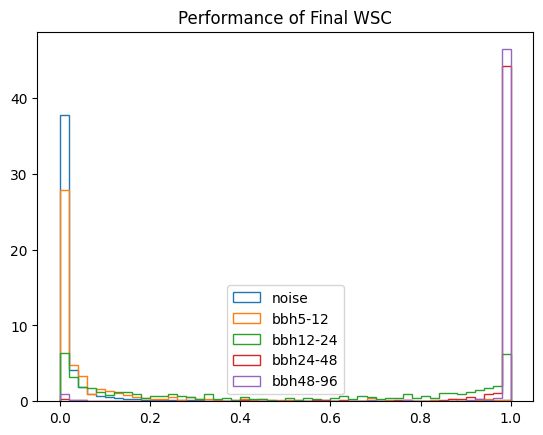

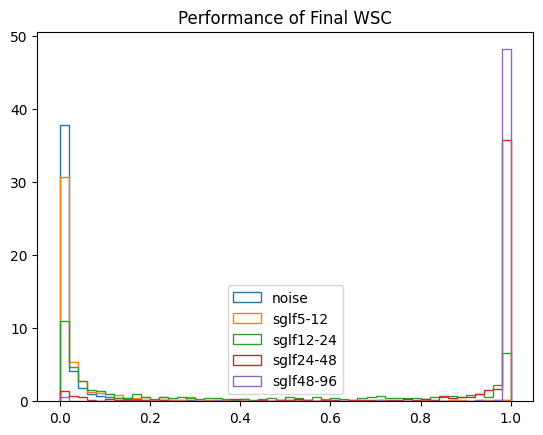

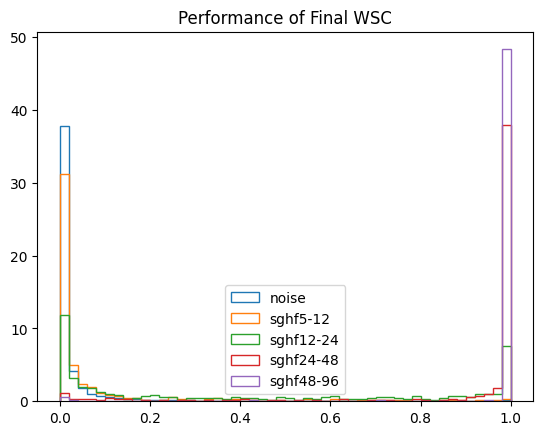

In [86]:
model = models['noise_WSC']

bkg_filtered = dataset_wsl_fft['noise']
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
# glitch_filtered = dataset_wsl_fft['glitch']

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    plt.title("Performance of Final WSC")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

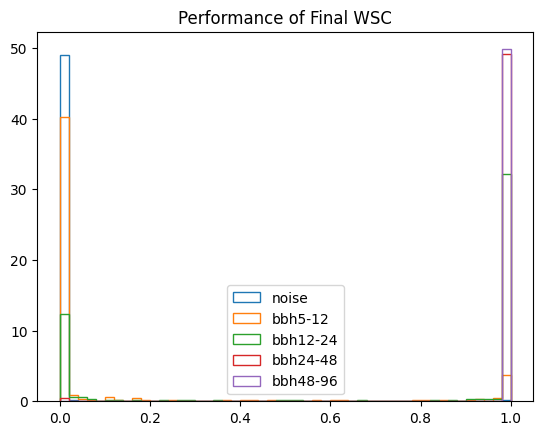

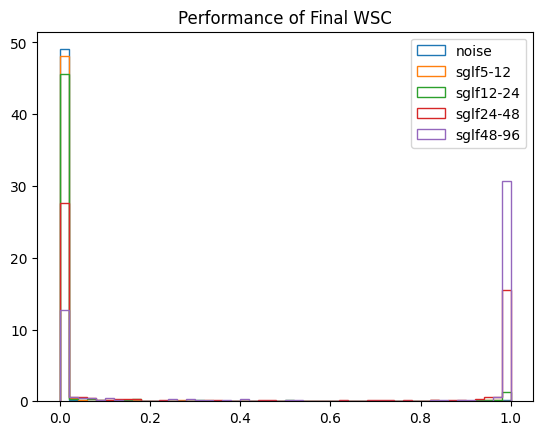

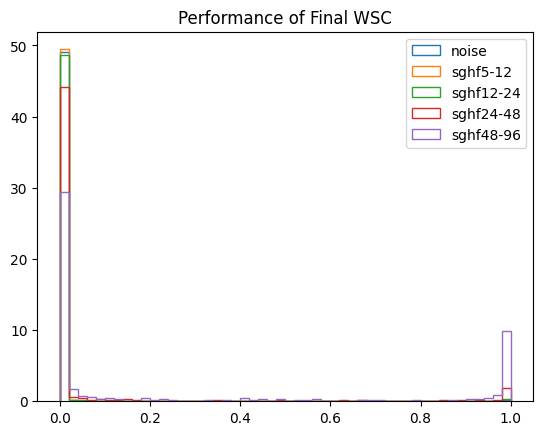

In [87]:
model = models['BBH_CNN_WSC']

bkg_filtered = dataset_wsl_fft['noise']
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
# glitch_filtered = dataset_wsl_fft['glitch']

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    plt.title("Performance of Final WSC")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

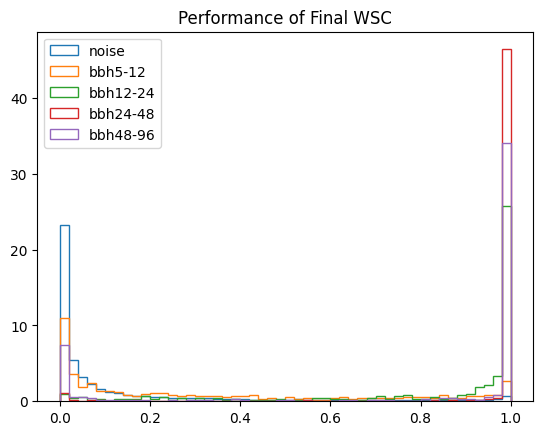

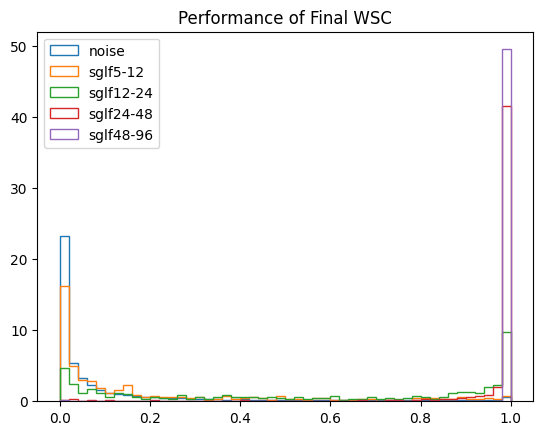

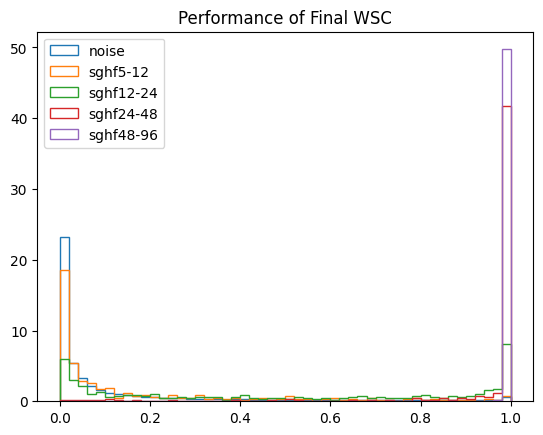

In [90]:
# v12

model = models['Final_WSC']

bkg_filtered = dataset_wsl_fft['noise']
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
# glitch_filtered = dataset_wsl_fft['glitch']

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    plt.title("Performance of Final WSC")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

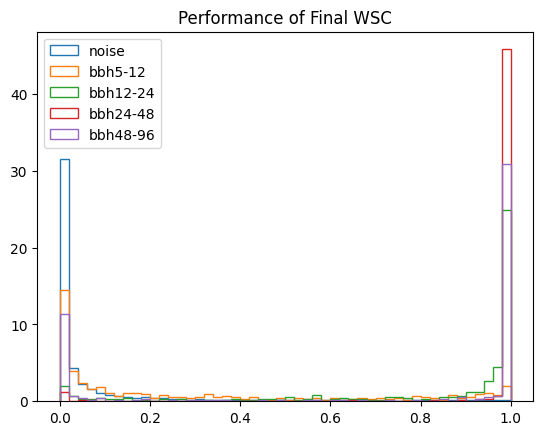

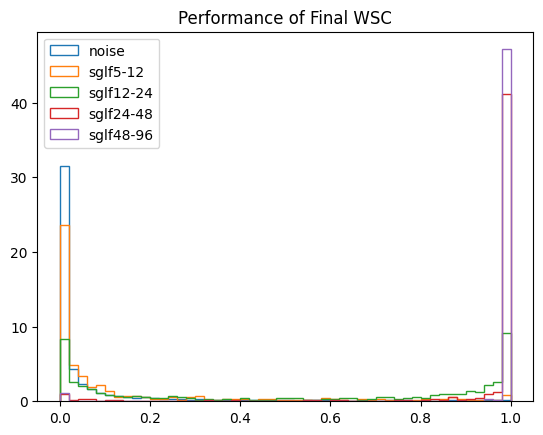

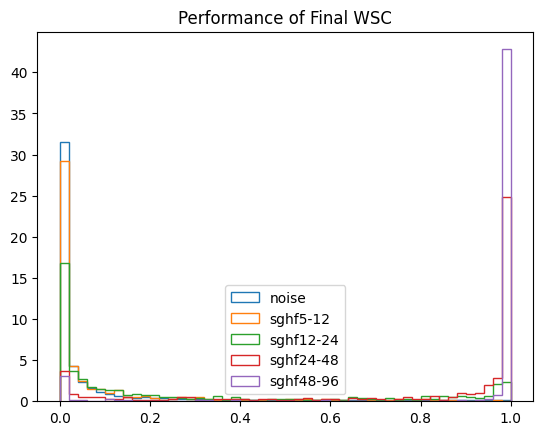

In [84]:
# v15

model = models['Final_WSC']

bkg_filtered = dataset_wsl_fft['noise']
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
# glitch_filtered = dataset_wsl_fft['glitch']

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    plt.title("Performance of Final WSC")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

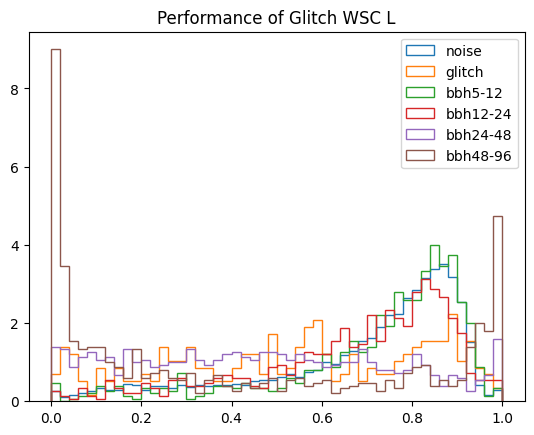

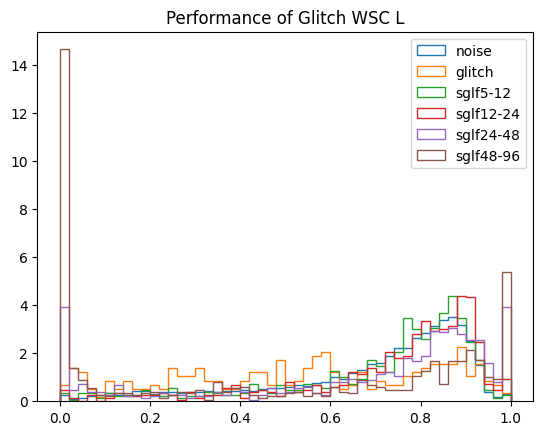

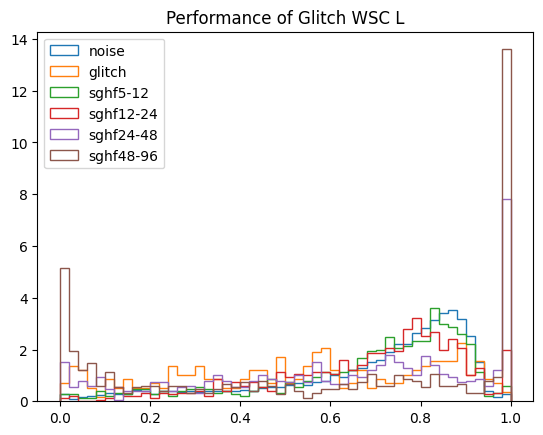

In [235]:
model = models['glitch_WSC_L']

bkg_filtered = dataset_wsl_fft['noise'][:,:101]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
glitch_filtered = dataset_wsl_fft['glitch'][:,:101]

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_filtered)).detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
    plt.title("Performance of Glitch WSC L")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key][:,:101]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

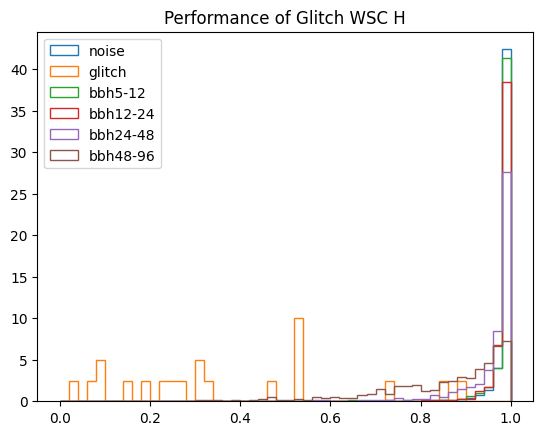

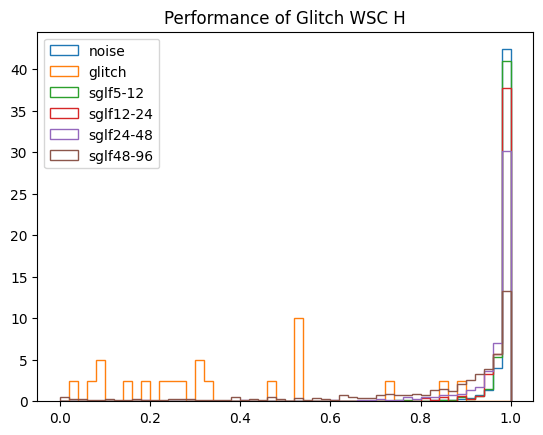

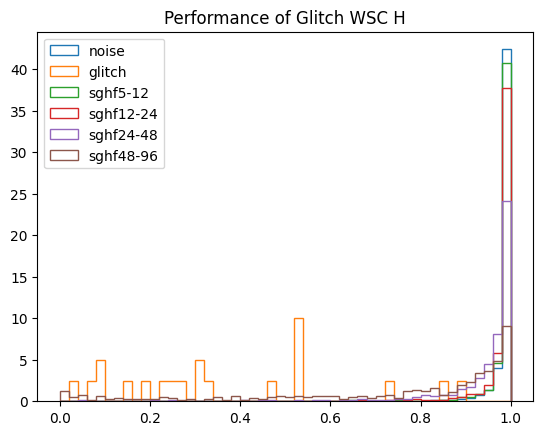

In [237]:
model = models['glitch_WSC_H']

bkg_filtered = dataset_wsl_fft['noise'][:,101:]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
glitch_filtered = dataset_wsl_fft['glitch'][:,101:]

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_filtered)).detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
    plt.title("Performance of Glitch WSC H")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key][:,101:]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

In [250]:
models

{'glitch_WSC_L': WSClassifier_Onedetector(
   (fc1): Linear(in_features=101, out_features=32, bias=True)
   (norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU()
   (sigmoid): Sigmoid()
   (fc2): Linear(in_features=32, out_features=1, bias=True)
 ),
 'glitch_WSC_H': WSClassifier_Onedetector(
   (fc1): Linear(in_features=101, out_features=32, bias=True)
   (norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU()
   (sigmoid): Sigmoid()
   (fc2): Linear(in_features=32, out_features=1, bias=True)
 ),
 'noise': AutoEncoder(
   (encoder): Sequential(
     (0): Linear(in_features=202, out_features=20, bias=True)
     (1): ReLU()
     (2): Linear(in_features=20, out_features=10, bias=True)
     (3): ReLU()
   )
   (decoder): Sequential(
     (0): Linear(in_features=10, out_features=20, bias=True)
     (1): ReLU()
     (2): Linear(in_features=20, out_features=202, bias=True)
     (3): Sigmoid

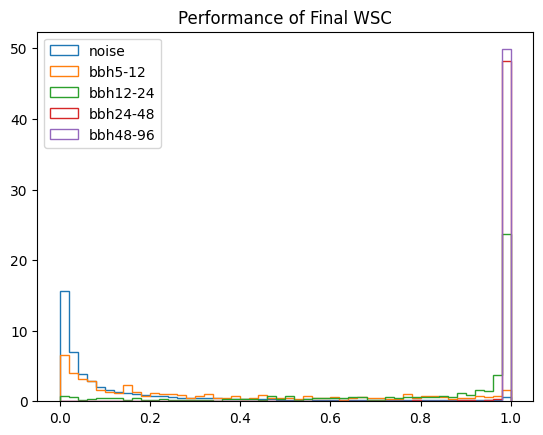

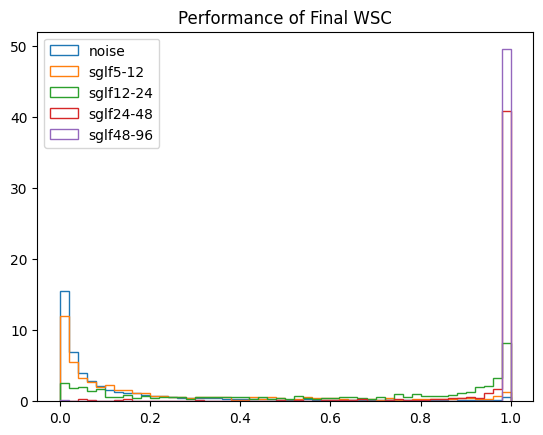

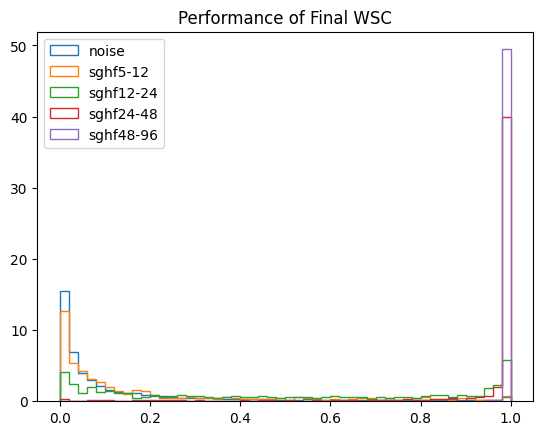

In [251]:
# v14

model = models['Final_WSC']

bkg_filtered = dataset_wsl_fft['noise']
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
# glitch_filtered = dataset_wsl_fft['glitch']

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    plt.title("Performance of Final WSC")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

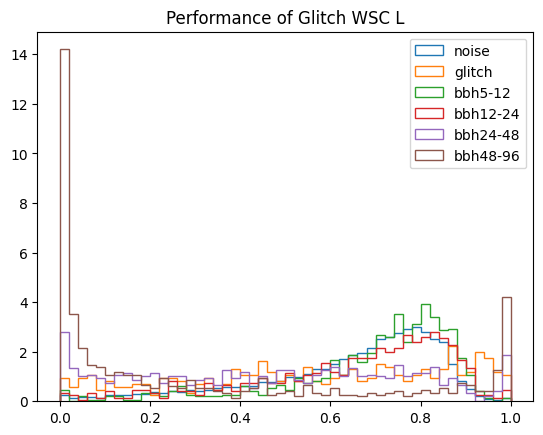

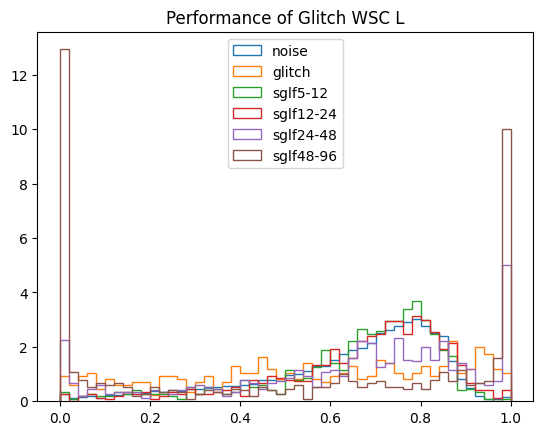

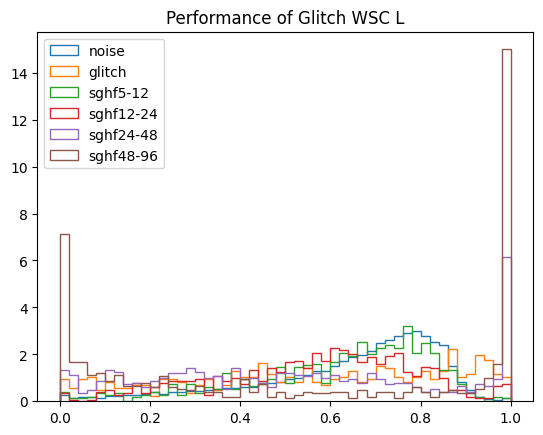

In [252]:
# v14

model = models['glitch_WSC_L']

bkg_filtered = dataset_wsl_fft['noise'][:,:101]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
glitch_filtered = dataset_wsl_fft['glitch'][:,:101]

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_filtered)).detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
    plt.title("Performance of Glitch WSC L")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key][:,:101]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

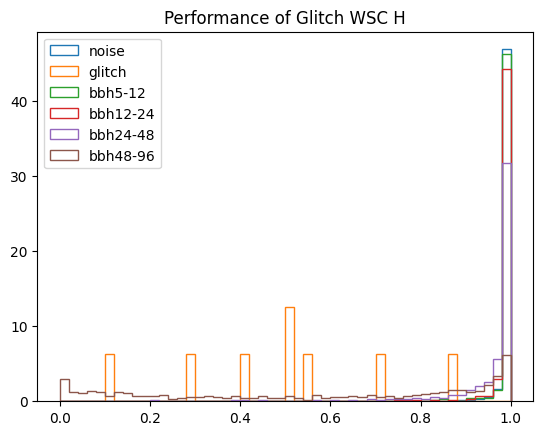

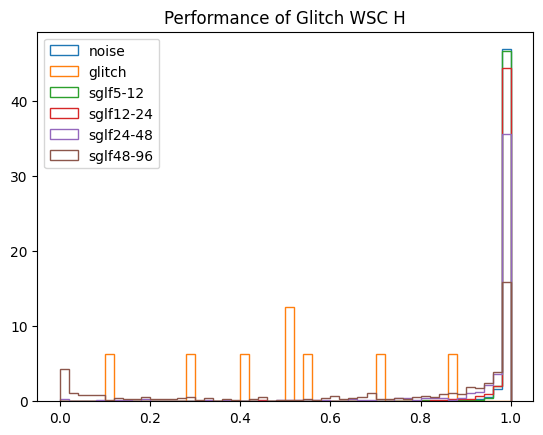

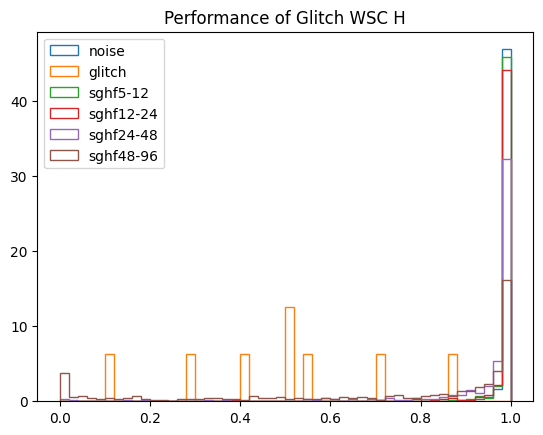

In [253]:
# v14

model = models['glitch_WSC_H']

bkg_filtered = dataset_wsl_fft['noise'][:,101:]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
glitch_filtered = dataset_wsl_fft['glitch'][:,101:]

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_filtered)).detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
    plt.title("Performance of Glitch WSC H")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key][:,101:]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

In [256]:
cutList['glitch_L']

array([0.0008, 0.0012, 0.0016, 0.002 , 0.0024])

In [257]:
ic[2]

4

23250 events passed to AE for training. 


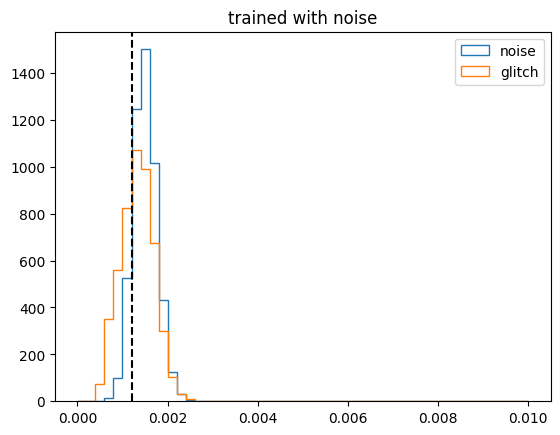

In [274]:
# v14

model = trainAE_Onedetector(dataset_ae_fft['glitch'][:,:101], 'test', 'test', 'test')

dcd_bkg = model(torch.FloatTensor(dataset_wsl_fft['noise'][:,:101]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(dataset_ae_fft['glitch'][:,:101]))[1].detach().numpy()

foo = plt.hist(np.var(dataset_wsl_fft['noise'][:,:101]-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(dataset_ae_fft['glitch'][:,:101]-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
plt.axvline(cutList['glitch_L'][ic[2]], color="k", linestyle="--")
plt.legend()

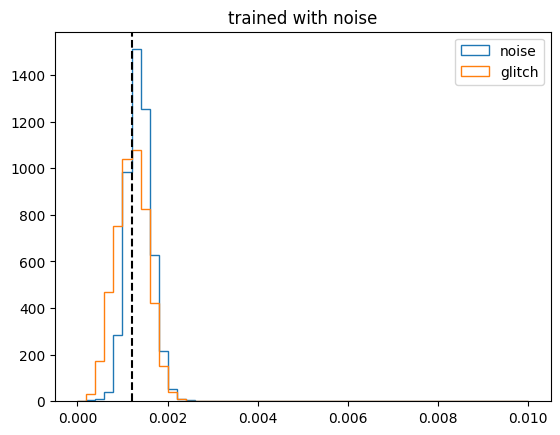

In [271]:
# v14

model = models['glitch_L']

dcd_bkg = model(torch.FloatTensor(dataset_wsl_fft['noise'][:,:101]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(dataset_ae_fft['glitch'][:,:101]))[1].detach().numpy()

foo = plt.hist(np.var(dataset_wsl_fft['noise'][:,:101]-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(dataset_ae_fft['glitch'][:,:101]-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
plt.axvline(cutList['glitch_L'][ic[2]], color="k", linestyle="--")
plt.legend()

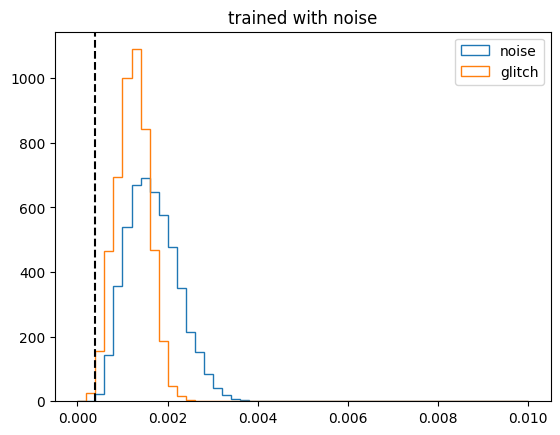

In [272]:
# v14

model = models['glitch_H']

dcd_bkg = model(torch.FloatTensor(dataset_wsl_fft['noise'][:,101:]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(dataset_ae_fft['glitch'][:,101:]))[1].detach().numpy()

foo = plt.hist(np.var(dataset_wsl_fft['noise'][:,101:]-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(dataset_ae_fft['glitch'][:,101:]-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
plt.axvline(cutList['glitch_H'][ic[3]], color="k", linestyle="--")
plt.legend()

### test training the glitch AE

In [47]:
models = {}

In [51]:
dataset_wsl_fft_filtered = dataset_wsl_fft_collected

In [57]:
# model = trainAE_Onedetector(dataset_ae_fft['glitch'][:,:101], 'test', 'test', 'glitch')
# models['glitch_L'] = model

# model = trainAE_Onedetector(dataset_ae_fft['glitch'][:,101:], 'test', 'test', 'glitch')
# models['glitch_H'] = model

dcd = models['glitch_L'](torch.FloatTensor(dataset_wsl_fft_filtered[:,:101]))[1].detach().numpy()

dataset0 = dataset_ae_fft['glitch'][:,:101]
dataset1 = dataset_wsl_fft_filtered[np.var(dataset_wsl_fft_filtered[:,:101]-dcd, axis=1) > cutList['glitch_L'][1]][:,:101]

model_L = trainWSC_Onedetector(dataset0, dataset1, 'test', 'test', 'glitch')
models["glitch_WSC_L"] = model_L


dcd = models['glitch_H'](torch.FloatTensor(dataset_wsl_fft_filtered[:,101:]))[1].detach().numpy()

dataset0 = dataset_ae_fft['glitch'][:,101:]
dataset1 = dataset_wsl_fft_filtered[np.var(dataset_wsl_fft_filtered[:,101:]-dcd, axis=1) > cutList['glitch_H'][0]][:,101:]

model_H = trainWSC_Onedetector(dataset0, dataset1, 'test', 'test', 'glitch')
models["glitch_WSC_H"] = model_H

39250 noise events and 24515 signal events passed to WSC for training. 
39250 noise events and 29921 signal events passed to WSC for training. 


In [63]:
dcd = models['glitch_L'](torch.FloatTensor(dataset_wsl_fft['noise'][:,:101]))[1].detach().numpy()

dataset0 = dataset_ae_fft['glitch'][:,:101]
dataset1 = dataset_wsl_fft['noise'][np.var(dataset_wsl_fft['noise'][:,:101]-dcd, axis=1) > cutList['glitch_L'][3]][:,:101]

model_L = trainWSC_Onedetector(dataset0, dataset1, 'test', 'test', 'glitch')
models["glitch_WSC_L"] = model_L

39250 noise events and 492 signal events passed to WSC for training. 


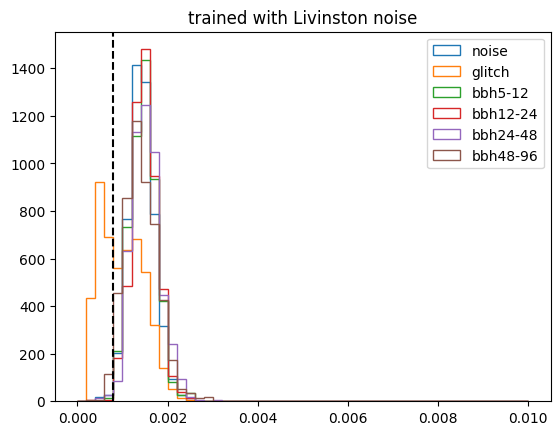

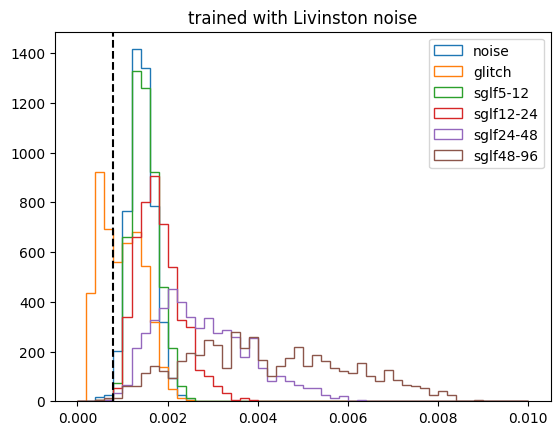

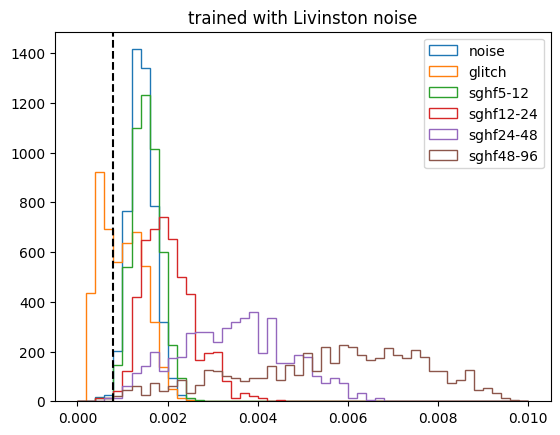

In [55]:
# test

model = models['glitch_L']

dcd_bkg = model(torch.FloatTensor(dataset_wsl_fft['noise'][:,:101]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(dataset_ae_fft['glitch'][:,:101]))[1].detach().numpy()

for key in ['bbh', 'sglf', 'sghf']:

    foo = plt.hist(np.var(dataset_wsl_fft['noise'][:,:101]-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    foo = plt.hist(np.var(dataset_ae_fft['glitch'][:,:101]-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")

    for snr in snr_range:
        key_to_plot = key+snr
        dcd_signal = model(torch.FloatTensor(dataset_wsl_fft[key_to_plot][:,:101]))[1].detach().numpy()
        plt.hist(np.var(dataset_wsl_fft[key_to_plot][:,:101] - dcd_signal, axis = 1), histtype="step", range=(0, 0.01), bins=50, density=True, label=key_to_plot)



    plt.title("trained with Livinston noise")
    plt.axvline(cutList['glitch_L'][0], color="k", linestyle="--")
    plt.legend()
    
    plt.show()

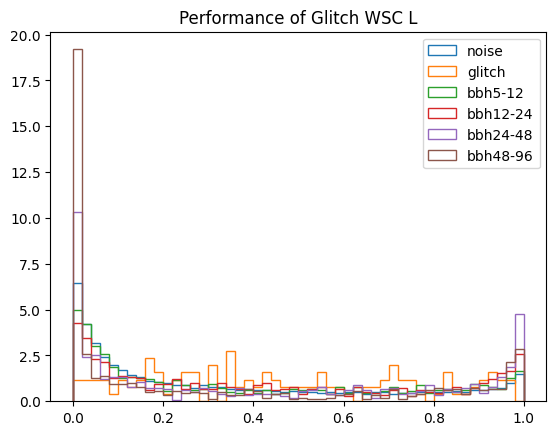

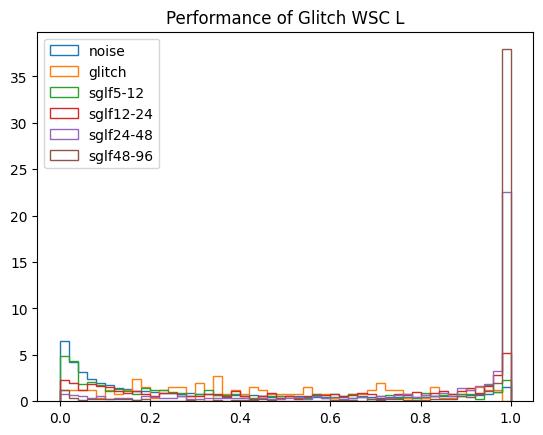

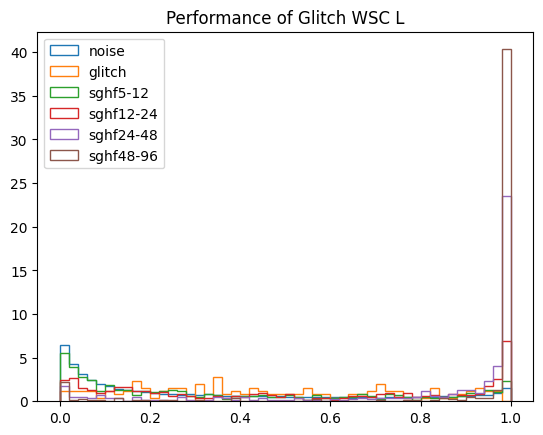

In [64]:
# test

model = models['glitch_WSC_L']

bkg_filtered = dataset_wsl_fft['noise'][:,:101]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
glitch_filtered = dataset_wsl_fft['glitch'][:,:101]

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_filtered)).detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
    plt.title("Performance of Glitch WSC L")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key][:,:101]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

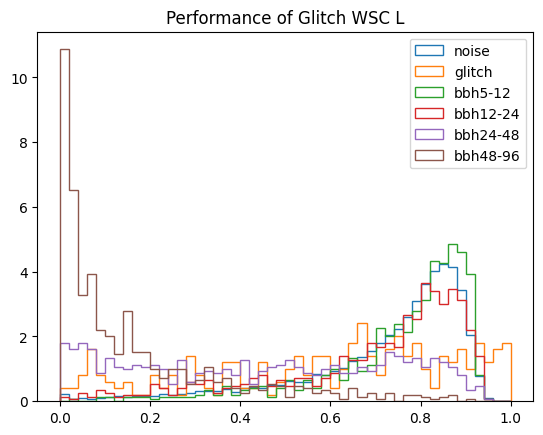

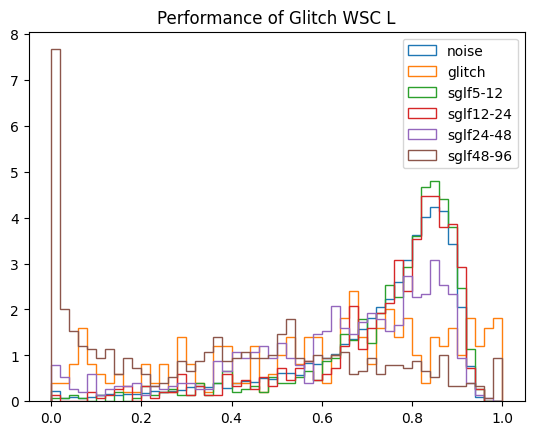

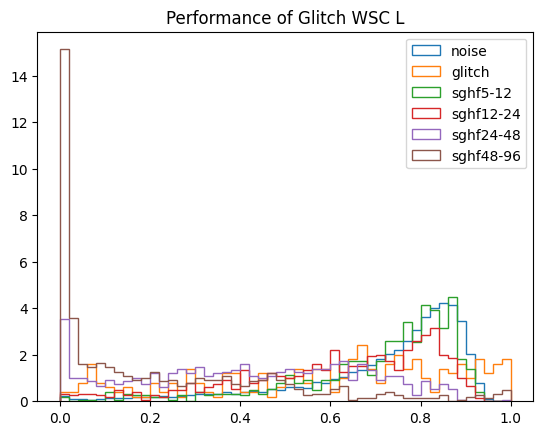

In [58]:
# test

model = models['glitch_WSC_L']

bkg_filtered = dataset_wsl_fft['noise'][:,:101]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
glitch_filtered = dataset_wsl_fft['glitch'][:,:101]

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_filtered)).detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
    plt.title("Performance of Glitch WSC L")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key][:,:101]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

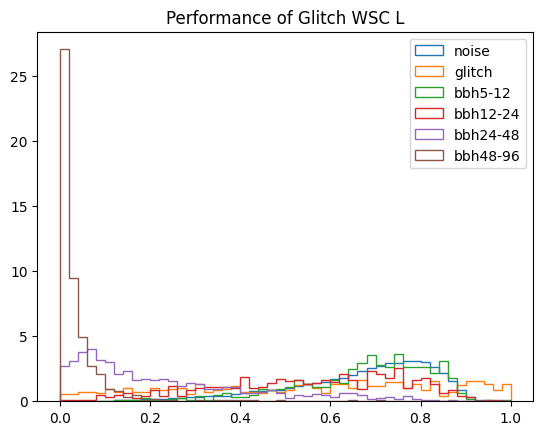

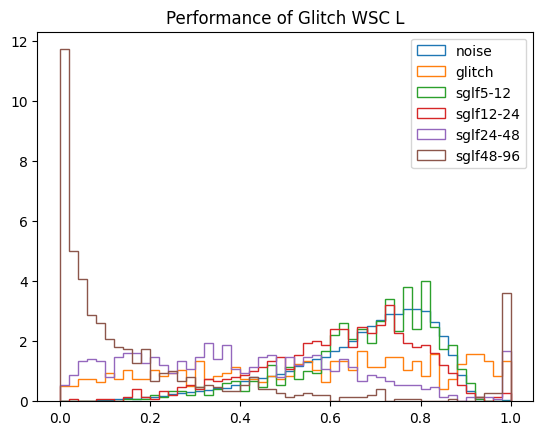

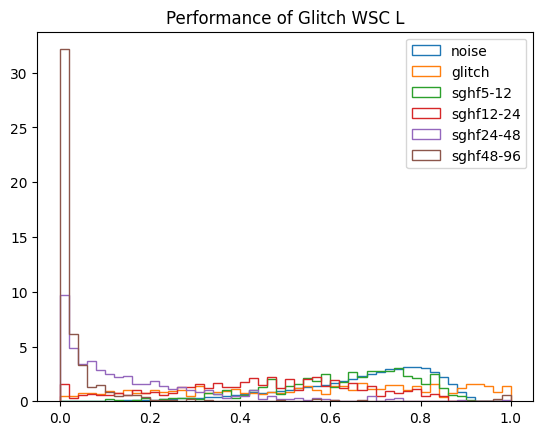

In [65]:
# test

model = models['glitch_WSC_L']

bkg_filtered = dataset_wsl_fft['noise'][:,:101]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
glitch_filtered = dataset_wsl_fft['glitch'][:,:101]

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_filtered)).detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
    plt.title("Performance of Glitch WSC L")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key][:,:101]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

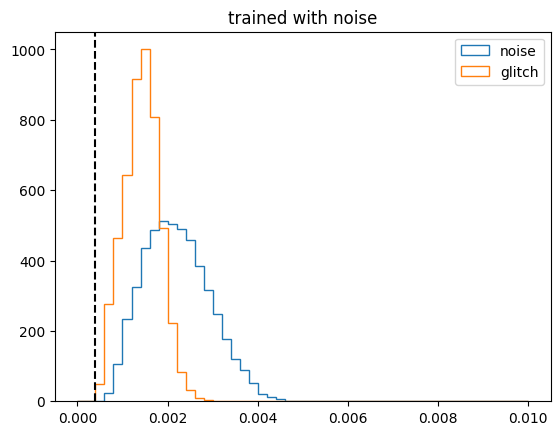

In [287]:
# test

model = models['glitch_H']

dcd_bkg = model(torch.FloatTensor(dataset_wsl_fft['noise'][:,101:]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(dataset_ae_fft['glitch'][:,101:]))[1].detach().numpy()

foo = plt.hist(np.var(dataset_wsl_fft['noise'][:,101:]-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(dataset_ae_fft['glitch'][:,101:]-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
plt.axvline(cutList['glitch_H'][0], color="k", linestyle="--")
plt.legend()

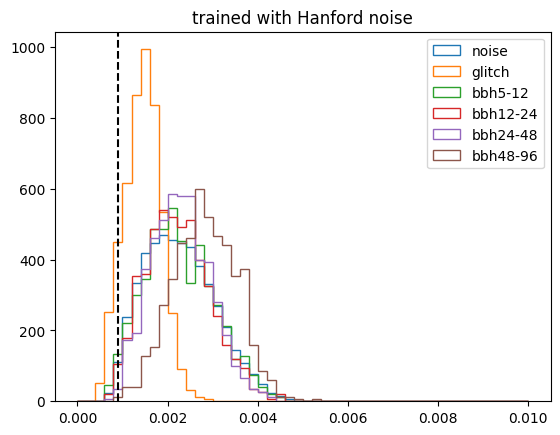

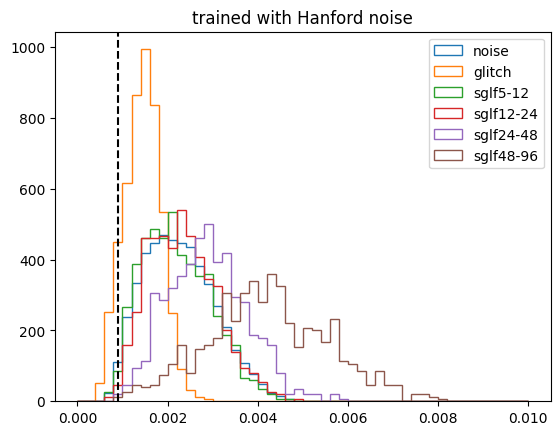

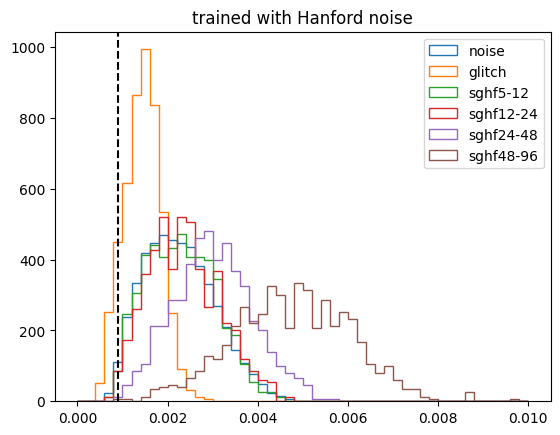

In [67]:
# test

model = models['glitch_H']

dcd_bkg = model(torch.FloatTensor(dataset_wsl_fft['noise'][:,101:]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(dataset_ae_fft['glitch'][:,101:]))[1].detach().numpy()

for key in ['bbh', 'sglf', 'sghf']:

    foo = plt.hist(np.var(dataset_wsl_fft['noise'][:,101:]-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    foo = plt.hist(np.var(dataset_ae_fft['glitch'][:,101:]-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")

    for snr in snr_range:
        key_to_plot = key+snr
        dcd_signal = model(torch.FloatTensor(dataset_wsl_fft[key_to_plot][:,101:]))[1].detach().numpy()
        plt.hist(np.var(dataset_wsl_fft[key_to_plot][:,101:] - dcd_signal, axis = 1), histtype="step", range=(0, 0.01), bins=50, density=True, label=key_to_plot)



    plt.title("trained with Hanford noise")
    plt.axvline(cutList['glitch_H'][1], color="k", linestyle="--")
    plt.legend()
    
    plt.show()

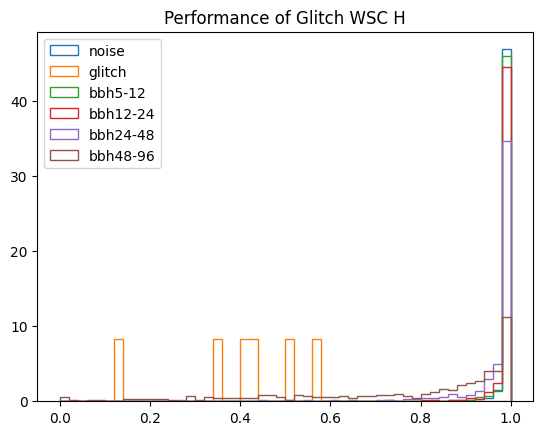

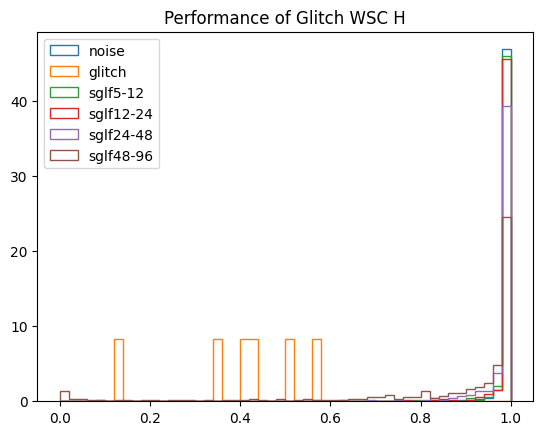

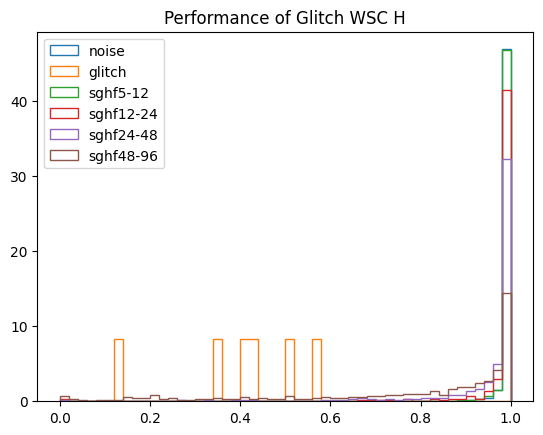

In [68]:
# test
model = models['glitch_WSC_H']

bkg_filtered = dataset_wsl_fft['noise'][:,101:]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
glitch_filtered = dataset_wsl_fft['glitch'][:,101:]

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_filtered)).detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
    plt.title("Performance of Glitch WSC H")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key][:,101:]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()

## Remove the Livinston Glitch

### A quick check for roburtness

#### Data processing part

Setting hyperparameters

In [10]:
N_wsl_total = 30000;
N_wsl = {}
N_wsl["noise"] = int(0.65*N_wsl_total)
N_wsl["bbh"] = int(0.1*N_wsl_total)
N_wsl["sglf"] = int(0.1*N_wsl_total)
N_wsl["sghf"] = int(0.1*N_wsl_total)
N_wsl["glitch"] = int(0.05*N_wsl_total)


snr_range = ['5-12','12-24','24-48','48-96']
ratio = [0.25, 0.25, 0.25, 0.25]
list_datatype = ["noise", "bbh", "sglf", "sghf", "glitch"]

In [11]:
list_datatype_full = ['noise']

for snr in snr_range:
    list_datatype_full.append('bbh' + snr)
    list_datatype_full.append('sglf' + snr)
    list_datatype_full.append('sghf' + snr)
    
list_datatype_full.append('glitch')

In [12]:
sequence = ['glitch','noise', 
            'bbh5-12', 'bbh12-24', 'bbh24-48', 'bbh48-96',
            'sglf5-12', 'sglf12-24', 'sglf24-48', 'sglf48-96',
            'sghf5-12', 'sghf12-24', 'sghf24-48', 'sghf48-96',]

In [13]:
assert len(snr_range) == len(ratio)

for i in range(len(ratio)):

    N_wsl['bbh' + snr_range[i]] = int(ratio[i] * N_wsl['bbh'])
    
    N_wsl['sglf' + snr_range[i]] = int(ratio[i] * N_wsl['sglf'])
    
    N_wsl['sghf' + snr_range[i]] = int(ratio[i] * N_wsl['sghf'])

In [18]:
### Introducing Chia-Jui's data

renorm_factor_0 = 20;
renorm_factor_1 = 20;

realbkg_L = np.load('../Data_cached/real_bkg_2202000_63917s_4000Hz_50ms.npy')[:1000000].reshape(-1,1,200) / renorm_factor_0;
realbkg_H = np.load('../Data_cached/real_bkg_H_1466640_58803s_4000Hz_50ms.npy')[:1000000].reshape(-1,1,200) / renorm_factor_0;

realbkg = np.concatenate((realbkg_L, realbkg_H), axis = 1).reshape(-1,200)

# realbbh = np.load('../Data_cached/injected_BBH_1823_around_merger_time_63917_58803.npz')['strain'].reshape(-1,200) / renorm_factor_0;

# realsg = np.load('../Data_cached/injected_lfsg_1835_around_merger_time_63917_58803.npz')['strain'].reshape(-1,200) / renorm_factor_0;
# realglitch = np.load("../data/real_glitches_9998_4000Hz_25ms.npz")["strain_time_data"]

realbbh_list = {}
realsglf_list = {}
realsghf_list = {}


for snr in snr_range:
    realbbh_list[snr] = np.load('../Data_cached/injected_BBH_55k_snr{}_0th_events_before_merger_time_windowlength_200.npz'.format(snr))['strain'][:25000].reshape(-1,200)
    realsglf_list[snr] = np.load('../Data_cached/injected_SGLF_55k_snr{}_0th_events_before_merger_time_windowlength_200.npz'.format(snr))['strain'][:25000].reshape(-1,200)
    realsghf_list[snr] = np.load('../Data_cached/injected_SGHF_55k_snr{}_0th_events_before_merger_time_windowlength_200.npz'.format(snr))['strain'][:25000].reshape(-1,200)

    

realglitch_L = np.load("../Data_cached/real_glitches_L_snrlt5_60132_4000Hz_50ms_centered.npz")["strain_time_data"][:50000].reshape(-1,1,200) / renorm_factor_1
realglitch_H = np.load('../Data_cached/real_glitches_H_snrlt5_59732_4000Hz_25ms.npz')["strain_time_data"][:50000].reshape(-1,1,200) / renorm_factor_1

Novel procedure. For training sample, the model is purely glitch trained. For testing and WSL sample, the model is one glitch + one noise

In [19]:
num_glitch_for_AE = int(len(realglitch_L) * 0.8) - N_wsl['glitch'] // 2

In [20]:
num_one_glitch_one_noise = int(len(realglitch_L) * 0.2) + N_wsl['glitch'] // 2

In [21]:
np.random.shuffle(realglitch_L)
np.random.shuffle(realglitch_H)

In [22]:
realglitch_L.shape

(50000, 1, 200)

In [23]:
realbkg.shape

(2000000, 200)

In [24]:
glitch_for_ae = np.concatenate((realglitch_L[:num_glitch_for_AE], realglitch_H[:num_glitch_for_AE]), axis=1).reshape(-1,200)
glitch_for_ae_fft = abs(np.fft.rfft(glitch_for_ae))
glitch_for_ae_fft = glitch_for_ae_fft/np.linalg.norm([glitch_for_ae_fft], axis=2).T

In [25]:
glitch_for_ae = glitch_for_ae / np.linalg.norm([glitch_for_ae], axis = 2).T

glitch_for_ae = glitch_for_ae.reshape(-1,400)

In [26]:
noise_for_glitch_building = realbkg[:2 * num_one_glitch_one_noise].reshape(-1,2,200)

# glitch_L_noise_H = np.concatenate((realglitch_L[-num_one_glitch_one_noise:], noise_for_glitch_building[:,[1],:]), axis = 1)
noise_L_glitch_H = np.concatenate((noise_for_glitch_building[:,[0],:], realglitch_H[-num_one_glitch_one_noise:]), axis = 1)
one_glitch_one_noise = noise_L_glitch_H
np.random.shuffle(one_glitch_one_noise)
one_glitch_one_noise = one_glitch_one_noise.reshape(-1,200)

realbkg = realbkg[2 * num_one_glitch_one_noise:]

In [27]:
one_glitch_one_noise_fft = abs(np.fft.rfft(one_glitch_one_noise))
one_glitch_one_noise_fft = one_glitch_one_noise_fft / np.linalg.norm([one_glitch_one_noise_fft], axis=2).T

one_glitch_one_noise = one_glitch_one_noise / np.linalg.norm([one_glitch_one_noise], axis = 2).T

In [28]:
one_glitch_one_noise_fft.shape

(21500, 101)

In [29]:
realbkg_reserved = realbkg[-int(0.2 * len(realbkg)):]
# realbbh_reserved = realbbh[-int(0.2 * len(realbbh)):]
# realsg_reserved = realsg[-int(0.2 * len(realsg)):]
# realglitch_reserved = realglitch[-int(0.2 * len(realglitch)):]

realbkg = realbkg[:-int(0.2 * len(realbkg))]
# realbbh = realbbh[:-int(0.2 * len(realbbh))-int(0.2 * len(realbbh))%2]
# realsg = realsg[:-int(0.2 * len(realsg))-int(0.2 * len(realsg))%2]
# realglitch = realglitch[:-int(0.2 * len(realglitch))]

realbkg = realbkg / np.linalg.norm([realbkg], axis = 2).T

bkg_fft = abs(np.fft.rfft(realbkg))
bkg_fft = bkg_fft/np.linalg.norm([bkg_fft], axis=2).T

# bbh_fft = abs(np.fft.rfft(realbbh))
# bbh_fft = bbh_fft/np.linalg.norm([bbh_fft], axis=2).T

# sg_fft = abs(np.fft.rfft(realsg))
# sg_fft = sg_fft/np.linalg.norm([sg_fft], axis=2).T

# glitch_fft = abs(np.fft.rfft(realglitch))
# glitch_fft = glitch_fft/np.linalg.norm([glitch_fft], axis=2).T

In [30]:
realbbh_reserved_list = {}
realsglf_reserved_list = {}
realsghf_reserved_list = {}

realbbh_fft_list = {}
realsglf_fft_list = {}
realsghf_fft_list = {}


for snr in snr_range:
    realbbh_reserved_list[snr] = realbbh_list[snr][-int(0.2 * len(realbbh_list[snr]))-int(0.2 * len(realbbh_list[snr]))%2:]
    realbbh_list[snr] = realbbh_list[snr][:-int(0.2 * len(realbbh_list[snr]))-int(0.2 * len(realbbh_list[snr]))%2]

    realbbh_fft_list[snr] = abs(np.fft.rfft(realbbh_list[snr]))
    realbbh_fft_list[snr] = realbbh_fft_list[snr]/np.linalg.norm([realbbh_fft_list[snr]], axis=2).T
    
    realbbh_list[snr] = realbbh_list[snr]/np.linalg.norm([realbbh_list[snr]], axis=2).T
    
    
    realsglf_reserved_list[snr] = realsglf_list[snr][-int(0.2 * len(realsglf_list[snr]))-int(0.2 * len(realsglf_list[snr]))%2:]
    realsglf_list[snr] = realsglf_list[snr][:-int(0.2 * len(realsglf_list[snr]))-int(0.2 * len(realsglf_list[snr]))%2]

    realsglf_fft_list[snr] = abs(np.fft.rfft(realsglf_list[snr]))
    realsglf_fft_list[snr] = realsglf_fft_list[snr]/np.linalg.norm([realsglf_fft_list[snr]], axis=2).T
    
    realsglf_list[snr] = realsglf_list[snr]/np.linalg.norm([realsglf_list[snr]], axis=2).T
    
    
    realsghf_reserved_list[snr] = realsghf_list[snr][-int(0.2 * len(realsghf_list[snr]))-int(0.2 * len(realsghf_list[snr]))%2:]
    realsghf_list[snr] = realsghf_list[snr][:-int(0.2 * len(realsghf_list[snr]))-int(0.2 * len(realsghf_list[snr]))%2]

    realsghf_fft_list[snr] = abs(np.fft.rfft(realsghf_list[snr]))
    realsghf_fft_list[snr] = realsghf_fft_list[snr]/np.linalg.norm([realsghf_fft_list[snr]], axis=2).T
    
    realsghf_list[snr] = realsghf_list[snr]/np.linalg.norm([realsghf_list[snr]], axis=2).T
    

In [31]:
bkg_fft = bkg_fft.reshape(-1,202)

# bbh_fft = bbh_fft.reshape(-1,202)

# sg_fft = sg_fft.reshape(-1,202)

# glitch_fft = glitch_fft.reshape(-1,202)

glitch_for_ae_fft = glitch_for_ae_fft.reshape(-1,202)

one_glitch_one_noise_fft = one_glitch_one_noise_fft.reshape(-1,202)

In [32]:
dataset_raw = {}
dataset_raw_fft = {}

dataset_raw["noise"] = realbkg.reshape(-1,400)
# dataset_raw_fft["bbh"] = bbh_fft
# dataset_raw_fft["sg"] = sg_fft
for snr in snr_range:
    dataset_raw['bbh' + snr] = realbbh_list[snr].reshape(-1,400)
    dataset_raw['sglf' + snr] = realsglf_list[snr].reshape(-1,400)
    dataset_raw['sghf' + snr] = realsghf_list[snr].reshape(-1,400)
# dataset_raw["glitch"] = glitch.reshape(-1,400)


dataset_raw_fft["noise"] = bkg_fft
# dataset_raw_fft["bbh"] = bbh_fft
# dataset_raw_fft["sg"] = sg_fft
for snr in snr_range:
    dataset_raw_fft['bbh' + snr] = realbbh_fft_list[snr].reshape(-1,202)
    dataset_raw_fft['sglf' + snr] = realsglf_fft_list[snr].reshape(-1,202)
    dataset_raw_fft['sghf' + snr] = realsghf_fft_list[snr].reshape(-1,202)
# dataset_raw_fft["glitch"] = glitch_fft

dataset_wsl = {};
dataset_ae = {};
dataset_wsl_fft = {};
dataset_ae_fft = {};

for dt in list_datatype_full[:-1]:
    perm = np.random.permutation(len(dataset_raw_fft[dt]))
    # perm = np.loadtxt("../Data_Cached/SequentialTraining/WSL/perm_"+dt+"_2det_Chia-Jui_v7_GWAK.dat").astype(int)
    
    nwsl = N_wsl[dt]
    dataset_wsl[dt] = dataset_raw[dt][perm[:nwsl]]
    dataset_wsl_fft[dt] = dataset_raw_fft[dt][perm[:nwsl]]
    # dataset_wsl[dt] = dataset_wsl[dt] / np.linalg.norm([dataset_wsl[dt]], axis=2).T
    # dataset_wsl_fft[dt] = abs(np.fft.rfft(dataset_wsl[dt]))
    # dataset_wsl_fft[dt] = dataset_wsl_fft[dt]/np.linalg.norm([dataset_wsl_fft[dt]], axis=2).T
    
    dataset_ae[dt] = dataset_raw[dt][perm[nwsl:]]
    dataset_ae_fft[dt]  = dataset_raw_fft[dt][perm[nwsl:]]
    # dataset_ae[dt] = dataset_ae[dt] / np.linalg.norm([dataset_ae[dt]], axis=2).T
    # dataset_ae_fft[dt] = abs(np.fft.rfft(dataset_ae[dt]))
    # dataset_ae_fft[dt] = dataset_ae_fft[dt]/np.linalg.norm([dataset_ae_fft[dt]], axis=2).T
    
    # np.savetxt("../Data_Cached/SequentialTraining/WSL/perm_"+dt+"_2det_Chia-Jui_"+version+"_2.dat", perm)
    
dataset_ae['bbh'] = np.zeros((0,400))
dataset_ae['sglf'] = np.zeros((0,400))
dataset_ae['sghf'] = np.zeros((0,400))

dataset_ae_fft['bbh'] = np.zeros((0,202))
dataset_ae_fft['sglf'] = np.zeros((0,202))
dataset_ae_fft['sghf'] = np.zeros((0,202))

for snr in snr_range:
    dataset_ae['bbh'] = np.append(dataset_ae['bbh'], dataset_ae['bbh'+snr])
    dataset_ae_fft['bbh'] = np.append(dataset_ae_fft['bbh'], dataset_ae_fft['bbh'+snr])
    
    dataset_ae['sglf'] = np.append(dataset_ae['sglf'], dataset_ae['sglf'+snr])
    dataset_ae_fft['sglf'] = np.append(dataset_ae_fft['sglf'], dataset_ae_fft['sglf'+snr])
    
    dataset_ae['sghf'] = np.append(dataset_ae['sghf'], dataset_ae['sghf'+snr])
    dataset_ae_fft['sghf'] = np.append(dataset_ae_fft['sghf'], dataset_ae_fft['sghf'+snr])

dataset_ae['bbh'] = dataset_ae['bbh'].reshape(-1,400)
dataset_ae['sglf'] = dataset_ae['sglf'].reshape(-1,400)
dataset_ae['sghf'] = dataset_ae['sghf'].reshape(-1,400)

dataset_ae_fft['bbh'] = dataset_ae_fft['bbh'].reshape(-1,202)
dataset_ae_fft['sglf'] = dataset_ae_fft['sglf'].reshape(-1,202)
dataset_ae_fft['sghf'] = dataset_ae_fft['sghf'].reshape(-1,202)

In [33]:
dataset_raw[dt].shape

(20000, 400)

In [34]:
dataset_wsl[dt]

array([[ 0.01571202,  0.02724753,  0.07206322, ..., -0.10492291,
        -0.02020301, -0.00185786],
       [ 0.12357754,  0.02908462, -0.07618682, ...,  0.05731174,
        -0.05194707, -0.05438487],
       [ 0.06027344, -0.00879036, -0.01132687, ...,  0.03198118,
         0.00204867, -0.00288093],
       ...,
       [ 0.03219626,  0.0286534 ,  0.00684066, ..., -0.05767199,
        -0.02455568, -0.00591508],
       [-0.02620542, -0.0403221 ,  0.01468752, ..., -0.02253792,
         0.04244209,  0.08349746],
       [ 0.03558951,  0.07703951, -0.02921929, ...,  0.01273247,
         0.05969534,  0.09819137]])

In [35]:
len(dataset_raw_fft[dt])

20000

In [36]:
dataset_wsl_fft['glitch'] = one_glitch_one_noise_fft[:N_wsl['glitch']]
dataset_wsl['glitch'] = one_glitch_one_noise[:2 * N_wsl['glitch']].reshape(-1,400)

dataset_ae_fft['glitch'] = glitch_for_ae_fft

# Missing dataset ae ['glitch'] here

In [37]:
dataset_ae['glitch'] = glitch_for_ae

In [38]:
dataset_wsl.keys()

dict_keys(['noise', 'bbh5-12', 'sglf5-12', 'sghf5-12', 'bbh12-24', 'sglf12-24', 'sghf12-24', 'bbh24-48', 'sglf24-48', 'sghf24-48', 'bbh48-96', 'sglf48-96', 'sghf48-96', 'glitch'])

In [39]:
for key in dataset_wsl.keys():

    print(np.linalg.norm(dataset_wsl[key][0]))

1.414213562373095
1.4142135623730951
1.4142135623730951
1.414213562373095
1.4142135623730951
1.4142135623730951
1.4142135623730951
1.4142135623730951
1.4142135623730951
1.4142135623730947
1.414213562373095
1.414213562373095
1.414213562373095
1.4142135623730951


In [44]:
for key in dataset_ae.keys():

    print(np.linalg.norm(dataset_wsl[key][0]))

1.4142135623730951
1.4142135623730951
1.4142135623730951
1.4142135623730951
1.414213562373095
1.4142135623730951
1.4142135623730951
1.4142135623730951
1.414213562373095
1.414213562373095
1.4142135623730951
1.4142135623730951
1.4142135623730951


KeyError: 'bbh'

In [40]:
for key in dataset_wsl_fft.keys():

    print(np.linalg.norm(dataset_wsl[key][0]))

1.414213562373095
1.4142135623730951
1.4142135623730951
1.414213562373095
1.4142135623730951
1.4142135623730951
1.4142135623730951
1.4142135623730951
1.4142135623730951
1.4142135623730947
1.414213562373095
1.414213562373095
1.414213562373095
1.4142135623730951


In [41]:
dataset_wsl_fft.keys()

dict_keys(['noise', 'bbh5-12', 'sglf5-12', 'sghf5-12', 'bbh12-24', 'sglf12-24', 'sghf12-24', 'bbh24-48', 'sglf24-48', 'sghf24-48', 'bbh48-96', 'sglf48-96', 'sghf48-96', 'glitch'])

In [42]:
dataset_ae_fft

{'noise': array([[0.02547341, 0.0373559 , 0.02314963, ..., 0.00043487, 0.00039044,
         0.00046966],
        [0.01873327, 0.02925491, 0.10835672, ..., 0.00371323, 0.00377141,
         0.00371662],
        [0.01287672, 0.02143118, 0.16280453, ..., 0.00617258, 0.006146  ,
         0.00608047],
        ...,
        [0.0243577 , 0.03534421, 0.07613329, ..., 0.00086038, 0.00082264,
         0.00082045],
        [0.05555614, 0.08912222, 0.08949792, ..., 0.00217317, 0.00228486,
         0.00220841],
        [0.05537143, 0.07818691, 0.0232301 , ..., 0.00029745, 0.00027588,
         0.00024202]]),
 'bbh5-12': array([[0.00537468, 0.01421506, 0.10546924, ..., 0.01160996, 0.01159609,
         0.01158908],
        [0.04796138, 0.05871333, 0.01402085, ..., 0.00151774, 0.00145848,
         0.00142177],
        [0.0488154 , 0.05712751, 0.07483109, ..., 0.00456838, 0.00451622,
         0.00457313],
        ...,
        [0.00663926, 0.0123262 , 0.19351665, ..., 0.01116099, 0.01113759,
         0.011

In [43]:
for key in dataset_ae.keys():
    print(key)
    print(dataset_ae[key].shape)

noise
(771900, 400)
bbh5-12
(19250, 400)
sglf5-12
(19250, 400)
sghf5-12
(19250, 400)
bbh12-24
(19250, 400)
sglf12-24
(19250, 400)
sghf12-24
(19250, 400)
bbh24-48
(19250, 400)
sglf24-48
(19250, 400)
sghf24-48
(19250, 400)
bbh48-96
(19250, 400)
sglf48-96
(19250, 400)
sghf48-96
(19250, 400)
bbh
(77000, 400)
sglf
(77000, 400)
sghf
(77000, 400)
glitch
(39250, 400)


In [44]:
for key in dataset_ae_fft.keys():
    print(key)
    print(dataset_ae_fft[key].shape)

noise
(771900, 202)
bbh5-12
(19250, 202)
sglf5-12
(19250, 202)
sghf5-12
(19250, 202)
bbh12-24
(19250, 202)
sglf12-24
(19250, 202)
sghf12-24
(19250, 202)
bbh24-48
(19250, 202)
sglf24-48
(19250, 202)
sghf24-48
(19250, 202)
bbh48-96
(19250, 202)
sglf48-96
(19250, 202)
sghf48-96
(19250, 202)
bbh
(77000, 202)
sglf
(77000, 202)
sghf
(77000, 202)
glitch
(39250, 202)


In [45]:
for key in dataset_ae_fft.keys():
    print(key)
    print(dataset_ae_fft[key].shape)

noise
(771900, 202)
bbh5-12
(19250, 202)
sglf5-12
(19250, 202)
sghf5-12
(19250, 202)
bbh12-24
(19250, 202)
sglf12-24
(19250, 202)
sghf12-24
(19250, 202)
bbh24-48
(19250, 202)
sglf24-48
(19250, 202)
sghf24-48
(19250, 202)
bbh48-96
(19250, 202)
sglf48-96
(19250, 202)
sghf48-96
(19250, 202)
bbh
(77000, 202)
sglf
(77000, 202)
sghf
(77000, 202)
glitch
(39250, 202)


In [46]:
for key in dataset_wsl.keys():
    print(key)
    print(dataset_wsl[key].shape)

noise
(19500, 400)
bbh5-12
(750, 400)
sglf5-12
(750, 400)
sghf5-12
(750, 400)
bbh12-24
(750, 400)
sglf12-24
(750, 400)
sghf12-24
(750, 400)
bbh24-48
(750, 400)
sglf24-48
(750, 400)
sghf24-48
(750, 400)
bbh48-96
(750, 400)
sglf48-96
(750, 400)
sghf48-96
(750, 400)
glitch
(1500, 400)


In [47]:
for key in dataset_wsl_fft.keys():
    print(key)
    print(dataset_wsl_fft[key].shape)

noise
(19500, 202)
bbh5-12
(750, 202)
sglf5-12
(750, 202)
sghf5-12
(750, 202)
bbh12-24
(750, 202)
sglf12-24
(750, 202)
sghf12-24
(750, 202)
bbh24-48
(750, 202)
sglf24-48
(750, 202)
sghf24-48
(750, 202)
bbh48-96
(750, 202)
sglf48-96
(750, 202)
sghf48-96
(750, 202)
glitch
(1500, 202)


In [48]:
dataset_wsl_fft_collected = np.empty((0, 202))
for dt in sequence:
    dataset_wsl_fft_collected = np.vstack((dataset_wsl_fft_collected, dataset_wsl_fft[dt]))

In [49]:
dataset_wsl_collected = np.empty((0, 400))
for dt in sequence:
    dataset_wsl_collected = np.vstack((dataset_wsl_collected, dataset_wsl[dt]))

In [50]:
dataset_wsl_fft_collected.shape

(30000, 202)

In [51]:
dataset_wsl_collected.shape

(30000, 400)

#### Model definition

In [52]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(202, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 202),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [53]:
import torch.nn as nn

def count_trainable_params(model):
    """
    计算给定PyTorch模型的可训练参数数量。
    
    参数:
    model (nn.Module) - 要计算参数的PyTorch模型
    
    返回:
    int - 模型的可训练参数数量
    """
    trainable_params = 0
    for param in model.parameters():
        if param.requires_grad:
            trainable_params += param.numel()
    return trainable_params


model = AutoEncoder()
trainable_params = count_trainable_params(model)
print(f"Model has {trainable_params} trainable parameters.")

Model has 8732 trainable parameters.


In [54]:
trainable_params_AE = count_trainable_params(model)

In [55]:
class AutoEncoder_1det(nn.Module):
    def __init__(self):
        super(AutoEncoder_1det, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(101, 20),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(20, 101),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [150]:
class WSClassifier_Onedetector(nn.Module):
    def __init__(self):
        super(WSClassifier_Onedetector, self).__init__()
        self.fc1 = nn.Linear(101, 32)  # 第一层全连接层，输入维度为4，输出维度为64
        self.norm1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()  # 激活函数
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(32, 1)
        # self.norm2 = nn.BatchNorm1d(8)
        # self.fc4 = nn.Linear(8, 1)  # 第三层全连接层，输入维度为32，输出维度为类别数目
        
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        # nn.init.kaiming_normal_(self.fc4.weight)

    def forward(self, x):
        x = self.norm1(self.relu(self.fc1(x)))
        return self.fc2(x)
        # x = self.relu(x)
#         x = self.sigmoid(x)

In [151]:
class WSClassifier(nn.Module):
    def __init__(self):
        super(WSClassifier, self).__init__()
        self.fc1 = nn.Linear(202, 32)  # 第一层全连接层，输入维度为4，输出维度为64
        self.norm1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()  # 激活函数
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(32, 1)
        # self.norm2 = nn.BatchNorm1d(8)
        # self.fc4 = nn.Linear(8, 1)  # 第三层全连接层，输入维度为32，输出维度为类别数目
        
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        # nn.init.kaiming_normal_(self.fc4.weight)

    def forward(self, x):
        x = self.norm1(self.relu(self.fc1(x)))
        return self.fc2(x)
        # x = self.relu(x)
#         x = self.sigmoid(x)

In [58]:
import torch.nn as nn

def count_trainable_params(model):
    """
    计算给定PyTorch模型的可训练参数数量。
    
    参数:
    model (nn.Module) - 要计算参数的PyTorch模型
    
    返回:
    int - 模型的可训练参数数量
    """
    trainable_params = 0
    for param in model.parameters():
        if param.requires_grad:
            trainable_params += param.numel()
    return trainable_params


model = WSClassifier()
trainable_params = count_trainable_params(model)
print(f"Model has {trainable_params} trainable parameters.")

Model has 6593 trainable parameters.


In [59]:
trainable_params_WSC = count_trainable_params(model)

In [60]:
class WaveletCNNAE_xc(nn.Module):
    
    def __init__(
        self, 
        num_ifos: int,
        c_depth: int=8, 
        n_chann: int=64, 
        l1: int=1024
        # lx: int=200
    ):
        
        super(WaveletCNNAE_xc, self).__init__()
        
        self.c_depth = c_depth
        self.n_chann = n_chann
        
        self.cap_norm = nn.GroupNorm(num_ifos, num_ifos)
        
        self.Conv_In_encode = nn.Conv1d(
                in_channels=num_ifos, 
                out_channels=self.n_chann, 
                kernel_size=1
            )
        
        self.Conv_Out_encode = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=1, 
                kernel_size=1
            )
        
        self.Conv_In_decode = nn.Conv1d(
                in_channels=1, 
                out_channels=self.n_chann, 
                kernel_size=1
            )
        
        self.Conv_Out_decode = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=num_ifos, 
                kernel_size=1
            )
        
        self.body_norm_encode = nn.GroupNorm(4 ,n_chann)
        self.body_norm_decode = nn.GroupNorm(4 ,n_chann)
        self.end_norm_encode = nn.BatchNorm1d(1)
        self.end_norm_decode = nn.BatchNorm1d(1)
        
        self.WaveNet_layers_encode = nn.ModuleList()
        self.WaveNet_layers_decode = nn.ModuleList()
        self.WaveNet_layers_dp = nn.ModuleList()
        
        
        for i in range(self.c_depth):

            conv_layer = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=self.n_chann,
                kernel_size=2,
                dilation=2**i
            )
            
            self.WaveNet_layers_encode.append(conv_layer)
            
        for i in range(self.c_depth-1, -1, -1):

            conv_layer = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=self.n_chann,
                kernel_size=2,
                dilation=2**i
            )
            
            self.WaveNet_layers_decode.append(conv_layer)
            self.WaveNet_layers_dp.append(nn.ZeroPad1d(2**i))
        
        
#         self.Padding_layer = nn.ZeroPad1d(2**c_depth - 1)
                
        # self.L1 = nn.Linear(8192-2**c_depth, l1)
        
        # Consider replacing other batch normalizatoin layers with other nor method
        # Because batch norm are baised by the population of the CCSN rate in one batch 
        # This may produce overfitting model and will not be able to found at test phase
        # Question: Will we be able to figure out the side effect at infereceing phase?
                
#         self.conv_norm = nn.BatchNorm1d(200-2**c_depth + 1)
        self.L1 = nn.Linear(200-2**c_depth + 1, l1)
        self.L1_norm = nn.BatchNorm1d(l1)
        self.L2 = nn.Linear(l1, 200-2**c_depth + 1)
        self.L2_norm = nn.BatchNorm1d(200-2**c_depth + 1)

        nn.init.kaiming_normal_(self.Conv_In_encode.weight)
        nn.init.kaiming_normal_(self.Conv_Out_encode.weight)
        nn.init.constant_(self.Conv_In_encode.bias, 0.001)
        nn.init.constant_(self.Conv_Out_encode.bias, 0.001)
        
        nn.init.kaiming_normal_(self.Conv_In_decode.weight)
        nn.init.kaiming_normal_(self.Conv_Out_decode.weight)
        nn.init.constant_(self.Conv_In_decode.bias, 0.001)
        nn.init.constant_(self.Conv_Out_decode.bias, 0.001)

        # Initialize all the convolutional layer in between
        for conv_layer in self.WaveNet_layers_encode:
            nn.init.kaiming_normal_(conv_layer.weight)
            nn.init.constant_(conv_layer.bias, 0.001)
            
        for conv_layer in self.WaveNet_layers_decode:
            nn.init.kaiming_normal_(conv_layer.weight)
            nn.init.constant_(conv_layer.bias, 0.001)    

        nn.init.kaiming_uniform_(self.L1.weight)
        nn.init.kaiming_uniform_(self.L2.weight)
        nn.init.constant_(self.L1.bias, 0.001)
        nn.init.constant_(self.L2.bias, 0.001)
        
    def encode(self, x):
        
        x = self.cap_norm(x)
        x = self.Conv_In_encode(x)
        x = F.relu(x)
        
        # x = self.norm(x)
        
        for what_are_u_wavin_at in self.WaveNet_layers_encode:
            x = self.body_norm_encode(x)
            x = what_are_u_wavin_at(x)
            x = F.relu(x)
            
        x = self.Conv_Out_encode(x)
        x = F.relu(x)
        x = self.end_norm_encode(x)
        
        # print(x.shape)
        x = torch.flatten(x, 1)
        x = self.L1_norm(F.relu(self.L1(x)))
        
        # print('Encoder done')
        
        return x
    
    def decode(self, x):
        x = self.L2_norm(F.relu(self.L2(x)))
        
#         x = self.Padding_layer(x)
        
        x = torch.unsqueeze(x,1)

        # print(x.shape)
        
        # x = self.cap_norm(x)
        x = self.Conv_In_decode(x)
        x = F.relu(x)
        
        # x = self.norm(x)
        
        for (pad, dcd) in zip(self.WaveNet_layers_dp, self.WaveNet_layers_decode):
            # print(x.shape)
            x = self.body_norm_decode(x)
            x = pad(x)
            x = torch.flip(dcd(torch.flip(x, [-1])), [-1])
            x = F.relu(x)
        
        # print(x.shape)
        # print('CNN done')
        
        x = self.Conv_Out_decode(x)
        # print(x.shape)
        x = F.tanh(x)
        # print(x.shape)
        # x = self.end_norm_decode(x)
        
        # x = torch.flatten(x, 1)
        
        
        return x
    
    def forward(self,x):
        return self.decode(self.encode(x))

In [61]:
def trainAE(dataset0_to_be_examined, cutID, version, datatype):
    
    if len(dataset0_to_be_examined) > 10 * trainable_params_AE:
        dataset = dataset0_to_be_examined[np.random.choice(len(dataset0_to_be_examined), 10 * trainable_params_AE, replace = False)]
    else:
        dataset = dataset0_to_be_examined

    print('{} events passed to AE for training. '.format(len(dataset)))

    nTotal = len(dataset);
    nTrain = int(rTrain * nTotal)
    nTest = int(rTest * nTotal)

    X_train = dataset[:nTrain]
    X_test = dataset[-nTest:]
    X_validation = dataset[nTrain:-nTest]

    trainData = torch.FloatTensor(X_train)
    testData = torch.FloatTensor(X_test)
    validationData = torch.FloatTensor(X_validation)

    train_dataset = TensorDataset(trainData)
    test_dataset = TensorDataset(testData)
    validation_dataset = TensorDataset(validationData)

    trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

    autoencoder = AutoEncoder().cuda()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
    loss_func = nn.MSELoss().cuda()
    
    loss_train = np.empty(epochs)
    loss_validation = np.empty(epochs)

    for epoch in range(epochs):

        autoencoder.train()
        for batchidx, x in enumerate(trainDataLoader):
            x = x[0].cuda()
            encoded, decoded = autoencoder(x)
            loss_overall = loss_func(decoded, x)
            weighted_lossTrain = loss_overall

            optimizer.zero_grad()
            weighted_lossTrain.backward()
            optimizer.step()
            
        autoencoder.eval()
        with torch.no_grad():
            val_loss = 0
            for batchidx, x in enumerate(validationDataLoader):
                x = x[0].cuda()
                encoded, decoded = autoencoder(x)
                lossVal = loss_func(decoded, x)
                val_loss += lossVal.item()

            val_loss /= len(validationDataLoader)

        loss_train[epoch] = weighted_lossTrain.item()
        loss_validation[epoch] = val_loss
    
    autoencoder.cpu().eval()
    _, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot(loss_train)
    ax[0].plot(loss_validation)
    
    dcd_train = autoencoder(torch.FloatTensor(X_train))[1].detach().numpy()
    err_train = np.var(X_train-dcd_train, axis=1)
    dcd_test = autoencoder(torch.FloatTensor(X_test))[1].detach().numpy()
    err_test = np.var(X_test-dcd_test, axis=1)
    foo = ax[1].hist(err_train, range=(0, max(err_train)), bins=50, density=True, histtype="step")
    foo = ax[1].hist(err_test, range=(0, max(err_train)), bins=50, density=True, histtype="step")
    
    plt.savefig("../Pic_cached/SequentialTraining/WSL/training_AE_"+cutID+"_" + version + "_" + datatype +"_trained.jpg")
    plt.close()
            
    return autoencoder.cpu().eval()

In [62]:
def trainAE_Onedetector(dataset0_to_be_examined, cutID, version, datatype):
    
    if len(dataset0_to_be_examined) > 10 * trainable_params_AE:
        dataset = dataset0_to_be_examined[np.random.choice(len(dataset0_to_be_examined), 10 * trainable_params_AE, replace = False)]
    else:
        dataset = dataset0_to_be_examined

    print('{} events passed to AE for training. '.format(len(dataset)))

    nTotal = len(dataset);
    nTrain = int(rTrain * nTotal)
    nTest = int(rTest * nTotal)

    X_train = dataset[:nTrain]
    X_test = dataset[-nTest:]
    X_validation = dataset[nTrain:-nTest]

    trainData = torch.FloatTensor(X_train)
    testData = torch.FloatTensor(X_test)
    validationData = torch.FloatTensor(X_validation)

    train_dataset = TensorDataset(trainData)
    test_dataset = TensorDataset(testData)
    validation_dataset = TensorDataset(validationData)

    trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

    autoencoder = AutoEncoder_1det().cuda()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
    loss_func = nn.MSELoss().cuda()
    
    loss_train = np.empty(epochs)
    loss_validation = np.empty(epochs)

    for epoch in range(epochs):

        autoencoder.train()
        for batchidx, x in enumerate(trainDataLoader):
            x = x[0].cuda()
            encoded, decoded = autoencoder(x)
            loss_overall = loss_func(decoded, x)
            weighted_lossTrain = loss_overall

            optimizer.zero_grad()
            weighted_lossTrain.backward()
            optimizer.step()
            
        autoencoder.eval()
        with torch.no_grad():
            val_loss = 0
            for batchidx, x in enumerate(validationDataLoader):
                x = x[0].cuda()
                encoded, decoded = autoencoder(x)
                lossVal = loss_func(decoded, x)
                val_loss += lossVal.item()

            val_loss /= len(validationDataLoader)

        loss_train[epoch] = weighted_lossTrain.item()
        loss_validation[epoch] = val_loss
    
    autoencoder.cpu().eval()
    _, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot(loss_train)
    ax[0].plot(loss_validation)
    
    dcd_train = autoencoder(torch.FloatTensor(X_train))[1].detach().numpy()
    err_train = np.var(X_train-dcd_train, axis=1)
    dcd_test = autoencoder(torch.FloatTensor(X_test))[1].detach().numpy()
    err_test = np.var(X_test-dcd_test, axis=1)
    foo = ax[1].hist(err_train, range=(0, max(err_train)), bins=50, density=True, histtype="step")
    foo = ax[1].hist(err_test, range=(0, max(err_train)), bins=50, density=True, histtype="step")
    
    plt.savefig("../Pic_cached/SequentialTraining/WSL/training_AE_"+cutID+"_" + version + "_" + datatype +"_trained.jpg")
    plt.close()
            
    return autoencoder.cpu().eval()

In [63]:
def trainWSC(dataset0_to_be_examined, dataset1, cutID, version, datatype):
# dataset0: bkg set from AE
# dataset1: identified signal from AE

    if len(dataset0_to_be_examined) > 10 * trainable_params_WSC:
        dataset0 = dataset0_to_be_examined[np.random.choice(len(dataset0_to_be_examined), 10 * trainable_params_WSC, replace = False)]
    else:
        dataset0 = dataset0_to_be_examined
    
    print('{} noise events and {} signal events passed to WSC for training. '.format(len(dataset0), len(dataset1)))

    nTotal0, nTotal1 = len(dataset0), len(dataset1);
    nTrain0, nTrain1 = int(rTrain * nTotal0), int(rTrain * nTotal1)
    nTest0 , nTest1  = int(rTest * nTotal0) , int(rTest * nTotal1)

    X_train = np.concatenate((dataset0[:nTrain0], dataset1[:nTrain1]))
    X_test = np.concatenate((dataset0[-nTest0:], dataset1[-nTest1:]))
    X_validation = np.concatenate((dataset0[nTrain0:-nTest0], dataset1[nTrain1:-nTest1]))
    
    Y_train = np.concatenate((np.zeros((nTrain0, 1)), np.ones((nTrain1, 1))))
    Y_test = np.concatenate((np.zeros((nTest0, 1)), np.ones((nTest1, 1))))
    Y_validation = np.concatenate((np.zeros((dataset0[nTrain0:-nTest0].shape[0], 1)), np.ones((dataset1[nTrain1:-nTest1].shape[0], 1))))

#     trainData = torch.FloatTensor(X_train)
#     testData = torch.FloatTensor(X_test)
#     validationData = torch.FloatTensor(X_validation)

    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(Y_train))
    validation_dataset = TensorDataset(torch.FloatTensor(X_validation), torch.FloatTensor(Y_validation))
#     train_dataset = TensorDataset(torch.FloatTensor(X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))), torch.FloatTensor(Y_train.reshape((Y_train.shape[0], 1, Y_train.shape[1]))))
#     validation_dataset = TensorDataset(torch.FloatTensor(X_validation.reshape((X_validation.shape[0], 1, X_validation.shape[1]))), torch.FloatTensor(Y_validation.reshape((Y_validation.shape[0], 1, Y_validation.shape[1]))))

    trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True, drop_last=True)

    wsc = WSClassifier().cuda()
    optimizer = optim.Adam(wsc.parameters(), lr=0.00005)
    loss_func = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([nTrain0/nTrain1])).cuda()
    
    loss_train = np.empty(epochs)
    loss_validation = np.empty(epochs)

    for epoch in range(epochs):
#         t0 = time.time()
        wsc.train()
        for batchidx, (x, y) in enumerate(trainDataLoader):
            x = x.cuda()
            y = y.cuda()
            yprime = wsc(x)
            loss = loss_func(yprime, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        wsc.eval()
        with torch.no_grad():
            val_loss = 0
            for batchidx, (x, y) in enumerate(validationDataLoader):
                x = x.cuda()
                y = y.cuda()
                yprime = wsc(x)
                lossVal = loss_func(yprime, y)
                val_loss += lossVal.item()

            val_loss /= len(validationDataLoader)

        loss_train[epoch] = loss.item()
        loss_validation[epoch] = val_loss
#         print(time.time() - t0)
        
    wsc.cpu().eval()
    
    _, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot(loss_train)
    ax[0].plot(loss_validation)
    foo = ax[1].hist(nn.Sigmoid()(wsc(torch.FloatTensor(X_train))).detach().numpy().flatten(), range=(0, 1), bins=20, density=True, histtype="step")
    foo = ax[1].hist(nn.Sigmoid()(wsc(torch.FloatTensor(X_test ))).detach().numpy().flatten(), range=(0, 1), bins=20, density=True, histtype="step")
    
    plt.savefig("../Pic_cached/SequentialTraining/WSL/training_WSC_"+cutID+"_" + version + "_" + datatype +"_trained.jpg")
    plt.close()
    
    return wsc.cpu().eval()

In [64]:
def trainWSC_Onedetector(dataset0_to_be_examined, dataset1, cutID, version, datatype):
# dataset0: bkg set from AE
# dataset1: identified signal from AE

    if len(dataset0_to_be_examined) > 10 * trainable_params_WSC:
        dataset0 = dataset0_to_be_examined[np.random.choice(len(dataset0_to_be_examined), 10 * trainable_params_WSC, replace = False)]
    else:
        dataset0 = dataset0_to_be_examined
    
    print('{} noise events and {} signal events passed to WSC for training. '.format(len(dataset0), len(dataset1)))

    nTotal0, nTotal1 = len(dataset0), len(dataset1);
    nTrain0, nTrain1 = int(rTrain * nTotal0), int(rTrain * nTotal1)
    nTest0 , nTest1  = int(rTest * nTotal0) , int(rTest * nTotal1)

    X_train = np.concatenate((dataset0[:nTrain0], dataset1[:nTrain1]))
    X_test = np.concatenate((dataset0[-nTest0:], dataset1[-nTest1:]))
    X_validation = np.concatenate((dataset0[nTrain0:-nTest0], dataset1[nTrain1:-nTest1]))
    
    Y_train = np.concatenate((np.zeros((nTrain0, 1)), np.ones((nTrain1, 1))))
    Y_test = np.concatenate((np.zeros((nTest0, 1)), np.ones((nTest1, 1))))
    Y_validation = np.concatenate((np.zeros((dataset0[nTrain0:-nTest0].shape[0], 1)), np.ones((dataset1[nTrain1:-nTest1].shape[0], 1))))

#     trainData = torch.FloatTensor(X_train)
#     testData = torch.FloatTensor(X_test)
#     validationData = torch.FloatTensor(X_validation)

    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(Y_train))
    validation_dataset = TensorDataset(torch.FloatTensor(X_validation), torch.FloatTensor(Y_validation))
#     train_dataset = TensorDataset(torch.FloatTensor(X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))), torch.FloatTensor(Y_train.reshape((Y_train.shape[0], 1, Y_train.shape[1]))))
#     validation_dataset = TensorDataset(torch.FloatTensor(X_validation.reshape((X_validation.shape[0], 1, X_validation.shape[1]))), torch.FloatTensor(Y_validation.reshape((Y_validation.shape[0], 1, Y_validation.shape[1]))))

    trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True, drop_last=True)

    wsc = WSClassifier_Onedetector().cuda()
    optimizer = optim.Adam(wsc.parameters(), lr=0.00005)
    loss_func = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([nTrain0/nTrain1])).cuda()
    
    loss_train = np.empty(epochs)
    loss_validation = np.empty(epochs)

    for epoch in range(epochs):
#         t0 = time.time()
        wsc.train()
        for batchidx, (x, y) in enumerate(trainDataLoader):
            x = x.cuda()
            y = y.cuda()
            yprime = wsc(x)
            loss = loss_func(yprime, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        wsc.eval()
        with torch.no_grad():
            val_loss = 0
            for batchidx, (x, y) in enumerate(validationDataLoader):
                x = x.cuda()
                y = y.cuda()
                yprime = wsc(x)
                lossVal = loss_func(yprime, y)
                val_loss += lossVal.item()

            val_loss /= len(validationDataLoader)

        loss_train[epoch] = loss.item()
        loss_validation[epoch] = val_loss
#         print(time.time() - t0)
        
    wsc.cpu().eval()
    
    _, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot(loss_train)
    ax[0].plot(loss_validation)
    foo = ax[1].hist(nn.Sigmoid()(wsc(torch.FloatTensor(X_train))).detach().numpy().flatten(), range=(0, 1), bins=20, density=True, histtype="step")
    foo = ax[1].hist(nn.Sigmoid()(wsc(torch.FloatTensor(X_test ))).detach().numpy().flatten(), range=(0, 1), bins=20, density=True, histtype="step")
    
    plt.savefig("../Pic_cached/SequentialTraining/WSL/training_WSC_"+cutID+"_" + version + "_" + datatype +"_trained.jpg")
    plt.close()
    
    return wsc.cpu().eval()

#### Pass the first glith double WSL (pretrained)

#### Train the noise AE

#### Train the noise WSL

#### Train the BBH CNN

#### Train the BBH CNN WSL

#### Finally, let the test sample (WSL training sample) pass the procedure to get the label

#### Final label WSL

### Full pipeline

In [52]:
version = 'v16'

#### First assume the CNN AE and the WSL is pretrained

In [70]:
Ncut = 5;
cutList = {};

max_glitch_L = 0.0024;
min_glitch_L = 0.0008;
cutList["glitch_L"] = np.linspace(min_glitch_L, max_glitch_L, Ncut);

max_glitch_H = 0.0024;
min_glitch_H = 0.0004;
cutList["glitch_H"] = np.linspace(min_glitch_H, max_glitch_H, Ncut);

max_bkg = 0.0018;
min_bkg = 0.0008;
cutList["noise"] = np.linspace(min_bkg, max_bkg, Ncut);


max_bbh_cnn = 0.0056
min_bbh_cnn = 0.0045
cutList['bbh_CNN'] = np.linspace(min_bbh_cnn, max_bbh_cnn, Ncut)

In [ ]:
# models = {}

In [ ]:
ind2datatype

NameError: name 'ind2datatype' is not defined

In [54]:
import itertools

In [ ]:
data_filtered

{'glitch': array([[3.42070508e-02, 1.17975897e-01, 3.20176552e-01, ...,
         1.38842088e-02, 1.38206971e-02, 1.37638643e-02],
        [8.11054455e-03, 1.56627391e-02, 4.35542503e-02, ...,
         1.17351062e-02, 1.16678999e-02, 1.15989545e-02],
        [4.21845550e-02, 4.42293297e-02, 1.30536750e-01, ...,
         2.80814948e-04, 1.53669764e-04, 1.09229822e-04],
        ...,
        [2.64491594e-02, 4.36955588e-02, 5.36655072e-02, ...,
         4.17441726e-03, 4.19609678e-03, 4.17027880e-03],
        [5.04850620e-02, 6.14421112e-02, 2.05922204e-02, ...,
         8.35883798e-04, 8.27744699e-04, 7.95434648e-04],
        [6.71470234e-03, 2.38174797e-02, 1.08059156e-01, ...,
         1.14489151e-02, 1.14214481e-02, 1.14605402e-02]]),
 'noise': array([[0.01469639, 0.01469719, 0.08475904, ..., 0.00523177, 0.0051645 ,
         0.00521975],
        [0.01991118, 0.04082662, 0.11963661, ..., 0.00453341, 0.00451944,
         0.00450653],
        [0.03399179, 0.04193709, 0.26903917, ..., 0.00

In [ ]:
del dataset_ae

In [ ]:
version

'v12'

In [55]:
epochs = 50
epochs_wsl = 50

In [ ]:
cnt = 0;

ic = np.zeros(2, dtype="int")

# loop for only the cut in glitch, noise and bbh as it's not really meaningful to set cut in sg w/o new signals
# ic[3] = Ncut-1;
# ic[4] = Ncut-1;

# listResult = {};
# listResult["cut"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)), dtype="int");
# listResult["ans"] = np.empty((Ncut**(len(list_datatype)-1), len(testset)), dtype="int");
# listResult["accuracy_4"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)))
# listResult["accuracy_2"] = np.empty((Ncut**(len(list_datatype)-1), 2))

for ic[0], ic[1] in itertools.product(np.arange(Ncut), np.arange(Ncut)):
# for ic[0], ic[1], ic[2], ic[3] in itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut), np.arange(Ncut)):
    cnt += 1;
    
    if cnt < 23:
        continue
    # elif cnt > 85:
    #     continue
    
    t0 = time.time()
    data_filtered = {};
    for dt in ['glitch', 'noise', 'bbh', 'sglf', 'sghf']:
        data_filtered[dt] = dataset_ae_fft[dt]
#     data_filtered["noise"] = bkg_fft;
#     data_filtered["bbh"] = bbh_fft;
#     data_filtered["sg"] = sg_fft;

    dataset_wsl_fft_filtered = dataset_wsl_fft_collected
    dataset_wsl_filtered = dataset_wsl_collected
    
    cutID = "".join(str(ic[j]) for j in range(2)) + "_"+version
    
    

        # --- Glitch AE+WSL ---

    iPrev = 0
    
    previousStep = 'glitch';
    # modelPrev_L = models['glitch_L']; # previous step AE
    # modelPrev_H = models['glitch_H']; # previous step AE
    # train the WSC according to previous AE's cut
    
    dataset0 = data_filtered[previousStep] # here they haven't been updated yet
    
    # dcd_L = modelPrev_L(torch.FloatTensor(dataset_wsl_fft_filtered[:,:101]))[1].detach().numpy();
    # dcd_H = modelPrev_H(torch.FloatTensor(dataset_wsl_fft_filtered[:,101:]))[1].detach().numpy();
    # dataset1 = dataset_wsl_fft_filtered[np.logical_and(np.var(dataset_wsl_fft_filtered[:,:101]-dcd_L, axis=1) >= cutList['glitch_L'][ic[0]],
    #                                                np.var(dataset_wsl_fft_filtered[:,101:]-dcd_H, axis=1) >= cutList['glitch_H'][ic[1]])]
    
    # model = trainWSC(dataset0, dataset1, cutID, version, previousStep)
    # models[previousStep+"_WSC"] = model;

    # model_L = torch.load('../Model_cached/WSL_Chia-Jui_glitches/two_WSL_for_Chia-Jui_noise_cutscheme' + ''.join(str(ic[j]) for j in range(2)) + '_v2.json')['glitch_L']
    # model_H = torch.load('../Model_cached/WSL_Chia-Jui_glitches/two_WSL_for_Chia-Jui_noise_cutscheme' + ''.join(str(ic[j]) for j in range(2)) + '_v2.json')['glitch_H']

    # model_L = torch.load('../Model_cached/WSL_Chia-Jui_glitches/two_WSL_for_Chia-Jui_noise_cutscheme' + ''.join(['1','0']) + '_v2.json')['glitch_L']
    # model_H = torch.load('../Model_cached/WSL_Chia-Jui_glitches/two_WSL_for_Chia-Jui_noise_cutscheme' + ''.join(['1','0']) + '_v2.json')['glitch_H']
    
    # --- Train the glitch AE for L

    models[previousStep+"_WSC_L"] = model_L
    models[previousStep+"_WSC_H"] = model_H

    
    # filter the data according to previous WSC
    for dt in ['glitch', 'noise', 'bbh', 'sglf', 'sghf']:
        dcd_L = nn.Sigmoid()(model_L(torch.FloatTensor(data_filtered[dt][:,:101]))).detach().numpy().flatten();
        dcd_H = nn.Sigmoid()(model_H(torch.FloatTensor(data_filtered[dt][:,101:]))).detach().numpy().flatten();
        data_filtered[dt] = data_filtered[dt][np.logical_and(dcd_L > 0.5, dcd_H > 0.5)]
    
    dcd_L = nn.Sigmoid()(model_L(torch.FloatTensor(dataset_wsl_fft_filtered[:,:101]))).detach().numpy().flatten();
    dcd_H = nn.Sigmoid()(model_H(torch.FloatTensor(dataset_wsl_fft_filtered[:,101:]))).detach().numpy().flatten();

    dataset_wsl_fft_filtered = dataset_wsl_fft_filtered[np.logical_and(dcd_L > 0.5, dcd_H > 0.5)]
    dataset_wsl_filtered = dataset_wsl_filtered[np.logical_and(dcd_L > 0.5, dcd_H > 0.5)]

#         # filter the data
#         for j in range(iPrev+1, 4):
#             dt = ind2datatype[j];
#             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
#             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
    
    # train the current step AE

    print('Start noise AE')

    print('Start training the noise WSL, dataset 0 size {}'.format(len(data_filtered['noise'])))

    currentStep = 'noise';
    model = trainAE(data_filtered[currentStep], cutID, version, currentStep);
    models[currentStep] = model;   
    
    print('Noise AE trained completed, this epoch is using time {}'.format(str(time.time() - t0)))
    
    # --- Noise AE+WSL ---
    # Here's a cut scan for the noise AE

    print('Start noise WSL')

    iPrev = 1

    previousStep = 'noise';
    modelPrev = models[previousStep]; # previous step AE
    
    # train the WSC according to previous AE's cut
    
    dataset0 = data_filtered[previousStep] # here they haven't been updated yet
    
    # dcd = modelPrev(torch.FloatTensor(dataset0))[1].detach().numpy();
    # dataset1 = dataset0[np.var(dataset0-dcd, axis=1) >= cutList[previousStep][ic[0]]]
    
    dcd = modelPrev(torch.FloatTensor(dataset_wsl_fft_filtered))[1].detach().numpy();
    dataset1 = dataset_wsl_fft_filtered[np.var(dataset_wsl_fft_filtered-dcd, axis=1) >= cutList[previousStep][ic[0]]]
    
    print('Start training the noise WSL, dataset 0 size {}, dataset 1 size {}'.format(len(dataset0), len(dataset1)))

    model = trainWSC(dataset0, dataset1, cutID, version, previousStep)
    models[previousStep+"_WSC"] = model;

    # --- Here I just filter the noise sample ---

    data_noise_noiselike = data_filtered['noise'][nn.Sigmoid()(model(torch.FloatTensor(data_filtered['noise']))).detach().numpy().flatten() <= 0.5]
    signal_noise_like_args = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft_filtered))).detach().numpy().flatten() <= 0.5
    
    print('Noise WSL trained completed, this epoch is using time {}'.format(str(time.time() - t0)))

    # data_wsl_noiselike = {}

    # filter the data according to previous WSC
    # for j in range(iPrev, 4):
    #     dt = ind2datatype[j];
    #     dcd = nn.Sigmoid()(model(torch.FloatTensor(data_filtered[dt]))).detach().numpy().flatten();
    #     data_filtered[dt] = data_filtered[dt][dcd>0.5]
    #     data_noiselike[dt] = data_filtered[dt][dcd<=0.5]

    # dcd = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_filtered))).detach().numpy().flatten()
    # data_wsl_noiselike = dataset_wsl_collected[dcd <= 0.5].reshape(-1,2,200)
    
#         # filter the data
#         for j in range(iPrev+1, 4):
#             dt = ind2datatype[j];
#             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
#             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
        
    # --- BBH CNN+WSL ---
    # Here's a cut scan for BBH CNN

    print('Start BBHCNN WSL')

    models['BBH_CNN'] = torch.load('../Model_cached/CNN_BBH/model_dep_3_chnl_4_btn_20_v4.pt')

    # Note that for CNN, we have to use the initial input data (2 * 200 in timeseries)

    dataset0 = data_noise_noiselike

    dcd = models['BBH_CNN'](torch.FloatTensor(dataset_wsl_filtered[signal_noise_like_args].reshape(-1,2,200))).detach().numpy()
    dataset1 = dataset_wsl_fft_filtered[signal_noise_like_args][np.mean(np.var(dataset_wsl_filtered[signal_noise_like_args].reshape(-1,2,200)-dcd, axis = 2), axis = 1) <= cutList['bbh_CNN'][ic[1]]]

    print('Start training the BBHCNN WSL, dataset 0 size {}, dataset 1 size {}'.format(len(dataset0), len(dataset1)))
    
    model = trainWSC(dataset0, dataset1, cutID, version, 'BBH_CNN')
    models['BBH_CNN_WSC'] = model

    print('BBHCNN WSL trained completed, this epoch is using time {}'.format(str(time.time() - t0)))
    
    # --- Finalized WSL ---

    print('Start final WSL for cnt = {}'.format(cnt))

    dcd = {}

    dcd['glitch_WSC_L'] = nn.Sigmoid()(models['glitch_WSC_L'](torch.FloatTensor(dataset_wsl_fft_collected[:,:101]))).detach().numpy().flatten()
    dcd['glitch_WSC_H'] = nn.Sigmoid()(models['glitch_WSC_H'](torch.FloatTensor(dataset_wsl_fft_collected[:,101:]))).detach().numpy().flatten()


    for dt in ['noise_WSC', 'BBH_CNN_WSC']:
        dcd[dt] = nn.Sigmoid()(models[dt](torch.FloatTensor(dataset_wsl_fft_collected))).detach().numpy().flatten()

    glitch_pass = np.logical_and(dcd['glitch_WSC_L'] > 0.5, dcd['glitch_WSC_H'] > 0.5)

    noise_pass = np.logical_or(dcd['noise_WSC'] > 0.5, np.logical_and(dcd['noise_WSC'] <= 0.5, dcd['BBH_CNN_WSC'] > 0.5))

    passed_args = np.logical_and(glitch_pass, noise_pass)

    # dataset0 = np.concatenate((dataset_ae_fft['glitch'], dataset_ae_fft['noise']), axis = 0)

    dataset0 = data_filtered['noise']

    dataset1 = dataset_wsl_fft_collected[passed_args]

    print('Start training the final WSL, dataset 0 size {}, dataset 1 size {}'.format(len(dataset0), len(dataset1)))

    model = trainWSC(dataset0, dataset1, cutID, version, 'Final')

    models['Final_WSC'] = model


    print('Final WSL trained completed, this epoch is using time {}'.format(str(time.time() - t0)))

    torch.save(models, "../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(2)) + "_"+version+".json")
    print(models.keys())
    




#     dcd = {};
#     err = {};
#     ans = np.zeros(len(testset), dtype="int")
    
#     for datatype in list_datatype:
#         dcd[datatype] = models[datatype](torch.FloatTensor(testset))[1].detach().numpy()
#         err[datatype] = np.var(testset-dcd[datatype], axis=1)
        
#     not_select = np.array([True]*len(testset));

#     for iStep in range(len(list_datatype)):
#         datatype = ind2datatype[iStep];
#         ind_pass = np.logical_and(not_select, err[datatype] <= cutList[datatype][ic[iStep]]);
#         ans[ind_pass] = iStep;
#         not_select[ind_pass] = False;
        
#     ans[not_select] = -1;
    
#     listResult["cut"][cnt] = ic;
#     listResult["ans"][cnt] = ans;
    
#     acc = np.zeros(len(ind2datatype));
    
#     for i in range(len(ind2datatype)):
#         acc[i] = np.sum(np.logical_and(ans==i, correct_ans==i))/Nsample[ind2datatype[i]];
        
#     listResult["accuracy_4"][cnt] = acc;
    
#     listResult["accuracy_2"][cnt] = [ np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["glitch", "noise"])/np.sum(Nsample[dtype] for dtype in ["glitch", "noise"]), 
#                                      np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["bbh", "sg"])/np.sum(Nsample[dtype] for dtype in ["bbh", "sg"])]
    # cnt += 1
    print(cnt)
    print(time.time() - t0)
    
# listResult["total_accuracy"] = np.sum(listResult["ans"]==correct_ans, axis=1)/len(testset);
# torch.save(listResult, "../data/SequentialTraining/training_performance_"+version+".json")

Start noise AE
Start training the noise WSL, dataset 0 size 633169
87320 events passed to AE for training. 
Noise AE trained completed, this epoch is using time 391.46509194374084
Start noise WSL
Start training the noise WSL, dataset 0 size 633169, dataset 1 size 22369
65930 noise events and 22369 signal events passed to WSC for training. 
Noise WSL trained completed, this epoch is using time 820.9436910152435
Start BBHCNN WSL
Start training the BBHCNN WSL, dataset 0 size 292201, dataset 1 size 491
65930 noise events and 491 signal events passed to WSC for training. 
BBHCNN WSL trained completed, this epoch is using time 1141.1648325920105
Start final WSL for cnt = 1
Start training the final WSL, dataset 0 size 633169, dataset 1 size 14512
65930 noise events and 14512 signal events passed to WSC for training. 
Final WSL trained completed, this epoch is using time 1531.297298669815
dict_keys(['glitch_WSC_L', 'glitch_WSC_H', 'noise', 'noise_WSC', 'BBH_CNN', 'BBH_CNN_WSC', 'Final_WSC'])
1

MemoryError: Unable to allocate 943. MiB for an array with shape (611824, 202) and data type float64

In [ ]:
version = '15'

In [57]:
models = {}

In [58]:
cnt = 0;

ic = np.zeros(2, dtype="int")

# loop for only the cut in glitch, noise and bbh as it's not really meaningful to set cut in sg w/o new signals
# ic[3] = Ncut-1;
# ic[4] = Ncut-1;

# listResult = {};
# listResult["cut"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)), dtype="int");
# listResult["ans"] = np.empty((Ncut**(len(list_datatype)-1), len(testset)), dtype="int");
# listResult["accuracy_4"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)))
# listResult["accuracy_2"] = np.empty((Ncut**(len(list_datatype)-1), 2))

for ic[0], ic[1] in itertools.product(np.arange(Ncut), np.arange(Ncut)):
# for ic[0], ic[1], ic[2], ic[3] in itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut), np.arange(Ncut)):
    cnt += 1;
    
    if not np.all(ic == np.array([4,0])):
        continue
    # elif cnt > 85:
    #     continue
    
    t0 = time.time()
    data_filtered = {};
    for dt in ['glitch', 'noise', 'bbh', 'sglf', 'sghf']:
        data_filtered[dt] = dataset_ae_fft[dt]
#     data_filtered["noise"] = bkg_fft;
#     data_filtered["bbh"] = bbh_fft;
#     data_filtered["sg"] = sg_fft;

    dataset_wsl_fft_filtered = dataset_wsl_fft_collected
    dataset_wsl_filtered = dataset_wsl_collected
    
    cutID = "".join(str(ic[j]) for j in range(2)) + "_"+version
    
    

        # --- Glitch AE+WSL ---

    iPrev = 0
    
    previousStep = 'glitch';
    # modelPrev_L = models['glitch_L']; # previous step AE
    # modelPrev_H = models['glitch_H']; # previous step AE
    # train the WSC according to previous AE's cut
    
    dataset0 = data_filtered[previousStep] # here they haven't been updated yet
    
    # dcd_L = modelPrev_L(torch.FloatTensor(dataset_wsl_fft_filtered[:,:101]))[1].detach().numpy();
    # dcd_H = modelPrev_H(torch.FloatTensor(dataset_wsl_fft_filtered[:,101:]))[1].detach().numpy();
    # dataset1 = dataset_wsl_fft_filtered[np.logical_and(np.var(dataset_wsl_fft_filtered[:,:101]-dcd_L, axis=1) >= cutList['glitch_L'][ic[0]],
    #                                                np.var(dataset_wsl_fft_filtered[:,101:]-dcd_H, axis=1) >= cutList['glitch_H'][ic[1]])]
    
    # model = trainWSC(dataset0, dataset1, cutID, version, previousStep)
    # models[previousStep+"_WSC"] = model;

    # model_L = torch.load('../Model_cached/WSL_Chia-Jui_glitches/two_WSL_for_Chia-Jui_noise_cutscheme' + ''.join(str(ic[j]) for j in range(2)) + '_v2.json')['glitch_L']
    # model_H = torch.load('../Model_cached/WSL_Chia-Jui_glitches/two_WSL_for_Chia-Jui_noise_cutscheme' + ''.join(str(ic[j]) for j in range(2)) + '_v2.json')['glitch_H']

    model_L = torch.load('../Model_cached/WSL_Chia-Jui_glitches/two_WSL_for_Chia-Jui_noise_cutscheme' + ''.join(['1','0']) + '_v2.json')['glitch_L']
    model_H = torch.load('../Model_cached/WSL_Chia-Jui_glitches/two_WSL_for_Chia-Jui_noise_cutscheme' + ''.join(['1','0']) + '_v2.json')['glitch_H']
    
    # --- Train the glitch AE for L

    models[previousStep+"_WSC_L"] = model_L
    models[previousStep+"_WSC_H"] = model_H

    
    # filter the data according to previous WSC
    for dt in ['glitch', 'noise', 'bbh', 'sglf', 'sghf']:
        dcd_L = nn.Sigmoid()(model_L(torch.FloatTensor(data_filtered[dt][:,:101]))).detach().numpy().flatten();
        dcd_H = nn.Sigmoid()(model_H(torch.FloatTensor(data_filtered[dt][:,101:]))).detach().numpy().flatten();
        data_filtered[dt] = data_filtered[dt][np.logical_and(dcd_L >= 0, dcd_H > 0.5)]
    
    dcd_L = nn.Sigmoid()(model_L(torch.FloatTensor(dataset_wsl_fft_filtered[:,:101]))).detach().numpy().flatten();
    dcd_H = nn.Sigmoid()(model_H(torch.FloatTensor(dataset_wsl_fft_filtered[:,101:]))).detach().numpy().flatten();

    dataset_wsl_fft_filtered = dataset_wsl_fft_filtered[np.logical_and(dcd_L >= 0, dcd_H > 0.5)]
    dataset_wsl_filtered = dataset_wsl_filtered[np.logical_and(dcd_L >= 0, dcd_H > 0.5)]

#         # filter the data
#         for j in range(iPrev+1, 4):
#             dt = ind2datatype[j];
#             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
#             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
    
    # train the current step AE

    print('Start noise AE')

    print('Start training the noise WSL, dataset 0 size {}'.format(len(data_filtered['noise'])))

    currentStep = 'noise';
    model = trainAE(data_filtered[currentStep], cutID, version, currentStep);
    models[currentStep] = model;   
    
    print('Noise AE trained completed, this epoch is using time {}'.format(str(time.time() - t0)))
    
    # --- Noise AE+WSL ---
    # Here's a cut scan for the noise AE

    print('Start noise WSL')

    iPrev = 1

    previousStep = 'noise';
    modelPrev = models[previousStep]; # previous step AE
    
    # train the WSC according to previous AE's cut
    
    dataset0 = data_filtered[previousStep] # here they haven't been updated yet
    
    # dcd = modelPrev(torch.FloatTensor(dataset0))[1].detach().numpy();
    # dataset1 = dataset0[np.var(dataset0-dcd, axis=1) >= cutList[previousStep][ic[0]]]
    
    dcd = modelPrev(torch.FloatTensor(dataset_wsl_fft_filtered))[1].detach().numpy();
    dataset1 = dataset_wsl_fft_filtered[np.var(dataset_wsl_fft_filtered-dcd, axis=1) >= cutList[previousStep][ic[0]]]
    
    print('Start training the noise WSL, dataset 0 size {}, dataset 1 size {}'.format(len(dataset0), len(dataset1)))

    model = trainWSC(dataset0, dataset1, cutID, version, previousStep)
    models[previousStep+"_WSC"] = model;

    # --- Here I just filter the noise sample ---

    data_noise_noiselike = data_filtered['noise'][nn.Sigmoid()(model(torch.FloatTensor(data_filtered['noise']))).detach().numpy().flatten() <= 0.5]
    signal_noise_like_args = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft_filtered))).detach().numpy().flatten() <= 0.5
    
    print('Noise WSL trained completed, this epoch is using time {}'.format(str(time.time() - t0)))

    # data_wsl_noiselike = {}

    # filter the data according to previous WSC
    # for j in range(iPrev, 4):
    #     dt = ind2datatype[j];
    #     dcd = nn.Sigmoid()(model(torch.FloatTensor(data_filtered[dt]))).detach().numpy().flatten();
    #     data_filtered[dt] = data_filtered[dt][dcd>0.5]
    #     data_noiselike[dt] = data_filtered[dt][dcd<=0.5]

    # dcd = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_filtered))).detach().numpy().flatten()
    # data_wsl_noiselike = dataset_wsl_collected[dcd <= 0.5].reshape(-1,2,200)
    
#         # filter the data
#         for j in range(iPrev+1, 4):
#             dt = ind2datatype[j];
#             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
#             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
        
    # --- BBH CNN+WSL ---
    # Here's a cut scan for BBH CNN

    print('Start BBHCNN WSL')

    models['BBH_CNN'] = torch.load('../Model_cached/CNN_BBH/model_dep_3_chnl_4_btn_20_v4.pt')

    # Note that for CNN, we have to use the initial input data (2 * 200 in timeseries)

    dataset0 = data_noise_noiselike

    dcd = models['BBH_CNN'](torch.FloatTensor(dataset_wsl_filtered[signal_noise_like_args].reshape(-1,2,200))).detach().numpy()
    dataset1 = dataset_wsl_fft_filtered[signal_noise_like_args][np.mean(np.var(dataset_wsl_filtered[signal_noise_like_args].reshape(-1,2,200)-dcd, axis = 2), axis = 1) <= cutList['bbh_CNN'][ic[1]]]

    print('Start training the BBHCNN WSL, dataset 0 size {}, dataset 1 size {}'.format(len(dataset0), len(dataset1)))
    
    model = trainWSC(dataset0, dataset1, cutID, version, 'BBH_CNN')
    models['BBH_CNN_WSC'] = model

    print('BBHCNN WSL trained completed, this epoch is using time {}'.format(str(time.time() - t0)))
    
    # --- Finalized WSL ---

    print('Start final WSL for cnt = {}'.format(cnt))

    dcd = {}

    dcd['glitch_WSC_L'] = nn.Sigmoid()(models['glitch_WSC_L'](torch.FloatTensor(dataset_wsl_fft_collected[:,:101]))).detach().numpy().flatten()
    dcd['glitch_WSC_H'] = nn.Sigmoid()(models['glitch_WSC_H'](torch.FloatTensor(dataset_wsl_fft_collected[:,101:]))).detach().numpy().flatten()


    for dt in ['noise_WSC', 'BBH_CNN_WSC']:
        dcd[dt] = nn.Sigmoid()(models[dt](torch.FloatTensor(dataset_wsl_fft_collected))).detach().numpy().flatten()

    glitch_pass = np.logical_and(dcd['glitch_WSC_L'] > 0.5, dcd['glitch_WSC_H'] > 0.5)

    noise_pass = np.logical_or(dcd['noise_WSC'] > 0.5, np.logical_and(dcd['noise_WSC'] <= 0.5, dcd['BBH_CNN_WSC'] > 0.5))

    passed_args = np.logical_and(glitch_pass, noise_pass)

    # dataset0 = np.concatenate((dataset_ae_fft['glitch'], dataset_ae_fft['noise']), axis = 0)

    dataset0 = data_filtered['noise']

    dataset1 = dataset_wsl_fft_collected[passed_args]

    print('Start training the final WSL, dataset 0 size {}, dataset 1 size {}'.format(len(dataset0), len(dataset1)))

    model = trainWSC(dataset0, dataset1, cutID, version, 'Final')

    models['Final_WSC'] = model


    print('Final WSL trained completed, this epoch is using time {}'.format(str(time.time() - t0)))

    torch.save(models, "../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(2)) + "_"+version+".json")
    print(models.keys())
    




#     dcd = {};
#     err = {};
#     ans = np.zeros(len(testset), dtype="int")
    
#     for datatype in list_datatype:
#         dcd[datatype] = models[datatype](torch.FloatTensor(testset))[1].detach().numpy()
#         err[datatype] = np.var(testset-dcd[datatype], axis=1)
        
#     not_select = np.array([True]*len(testset));

#     for iStep in range(len(list_datatype)):
#         datatype = ind2datatype[iStep];
#         ind_pass = np.logical_and(not_select, err[datatype] <= cutList[datatype][ic[iStep]]);
#         ans[ind_pass] = iStep;
#         not_select[ind_pass] = False;
        
#     ans[not_select] = -1;
    
#     listResult["cut"][cnt] = ic;
#     listResult["ans"][cnt] = ans;
    
#     acc = np.zeros(len(ind2datatype));
    
#     for i in range(len(ind2datatype)):
#         acc[i] = np.sum(np.logical_and(ans==i, correct_ans==i))/Nsample[ind2datatype[i]];
        
#     listResult["accuracy_4"][cnt] = acc;
    
#     listResult["accuracy_2"][cnt] = [ np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["glitch", "noise"])/np.sum(Nsample[dtype] for dtype in ["glitch", "noise"]), 
#                                      np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["bbh", "sg"])/np.sum(Nsample[dtype] for dtype in ["bbh", "sg"])]
    # cnt += 1
    print(cnt)
    print(time.time() - t0)
    
# listResult["total_accuracy"] = np.sum(listResult["ans"]==correct_ans, axis=1)/len(testset);
# torch.save(listResult, "../data/SequentialTraining/training_performance_"+version+".json")

Start noise AE
Start training the noise WSL, dataset 0 size 770687
87320 events passed to AE for training. 
Noise AE trained completed, this epoch is using time 85.67031788825989
Start noise WSL
Start training the noise WSL, dataset 0 size 770687, dataset 1 size 5715
65930 noise events and 5715 signal events passed to WSC for training. 
Noise WSL trained completed, this epoch is using time 162.87789511680603
Start BBHCNN WSL
Start training the BBHCNN WSL, dataset 0 size 741287, dataset 1 size 65
65930 noise events and 65 signal events passed to WSC for training. 
BBHCNN WSL trained completed, this epoch is using time 234.56580710411072
Start final WSL for cnt = 21
Start training the final WSL, dataset 0 size 770687, dataset 1 size 4318
65930 noise events and 4318 signal events passed to WSC for training. 
Final WSL trained completed, this epoch is using time 310.2369718551636
dict_keys(['glitch_WSC_L', 'glitch_WSC_H', 'noise', 'noise_WSC', 'BBH_CNN', 'BBH_CNN_WSC', 'Final_WSC'])
21
310

In [ ]:
ic

array([4, 4, 4, 4])

In [ ]:
not np.all(ic == np.array([4,0,1,0]))

True

In [ ]:
cnt = 0;

ic = np.zeros(4, dtype="int")

# loop for only the cut in glitch, noise and bbh as it's not really meaningful to set cut in sg w/o new signals
# ic[3] = Ncut-1;
# ic[4] = Ncut-1;

# listResult = {};
# listResult["cut"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)), dtype="int");
# listResult["ans"] = np.empty((Ncut**(len(list_datatype)-1), len(testset)), dtype="int");
# listResult["accuracy_4"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)))
# listResult["accuracy_2"] = np.empty((Ncut**(len(list_datatype)-1), 2))

for ic[0], ic[1], ic[2], ic[3] in itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut), np.arange(Ncut)):
# for ic[0], ic[1], ic[2], ic[3] in itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut), np.arange(Ncut)):
    cnt += 1;
    
    print(ic)
    
    if not np.all(ic == np.array([4,0,1,0])):
        continue
    # elif cnt > 85:
    #     continue
    
    t0 = time.time()
    data_filtered = {};
    for dt in ['glitch', 'noise', 'bbh', 'sglf', 'sghf']:
        data_filtered[dt] = dataset_ae_fft[dt]
#     data_filtered["noise"] = bkg_fft;
#     data_filtered["bbh"] = bbh_fft;
#     data_filtered["sg"] = sg_fft;

    dataset_wsl_fft_filtered = dataset_wsl_fft_collected
    dataset_wsl_filtered = dataset_wsl_collected
    
    cutID = "".join(str(ic[j]) for j in range(2)) + "_"+version
    
    
    print('Starting training on ic = {}'.format(''.join(str(ic[j] for j in range(4)))))
    
        # --- Glitch AE+WSL ---

    iPrev = 0
    
    previousStep = 'glitch';
    # modelPrev_L = models['glitch_L']; # previous step AE
    # modelPrev_H = models['glitch_H']; # previous step AE
    # train the WSC according to previous AE's cut
    
    # dataset0 = data_filtered[previousStep] # here they haven't been updated yet
    
    # dcd_L = modelPrev_L(torch.FloatTensor(dataset_wsl_fft_filtered[:,:101]))[1].detach().numpy();
    # dcd_H = modelPrev_H(torch.FloatTensor(dataset_wsl_fft_filtered[:,101:]))[1].detach().numpy();
    # dataset1 = dataset_wsl_fft_filtered[np.logical_and(np.var(dataset_wsl_fft_filtered[:,:101]-dcd_L, axis=1) >= cutList['glitch_L'][ic[0]],
    #                                                np.var(dataset_wsl_fft_filtered[:,101:]-dcd_H, axis=1) >= cutList['glitch_H'][ic[1]])]
    
    # model = trainWSC(dataset0, dataset1, cutID, version, previousStep)
    # models[previousStep+"_WSC"] = model;

    # model_L = torch.load('../Model_cached/WSL_Chia-Jui_glitches/two_WSL_for_Chia-Jui_noise_cutscheme' + ''.join(str(ic[j]) for j in range(2)) + '_v2.json')['glitch_L']
    # model_H = torch.load('../Model_cached/WSL_Chia-Jui_glitches/two_WSL_for_Chia-Jui_noise_cutscheme' + ''.join(str(ic[j]) for j in range(2)) + '_v2.json')['glitch_H']
    
    model = trainAE_Onedetector(dataset_ae_fft['glitch'][:,:101], cutID, version, 'glitch')
    models['glitch_L'] = model
    
    model = trainAE_Onedetector(dataset_ae_fft['glitch'][:,101:], cutID, version, 'glitch')
    models['glitch_H'] = model
    
    dcd = models['glitch_L'](torch.FloatTensor(dataset_wsl_fft_filtered[:,:101]))[1].detach().numpy()
    
    dataset0 = data_filtered['glitch'][:,:101]
    dataset1 = dataset_wsl_fft_filtered[np.var(dataset_wsl_fft_filtered[:,:101]-dcd, axis=1) > cutList['glitch_L'][ic[2]]][:,:101]
    
    model_L = trainWSC_Onedetector(dataset0, dataset1, cutID, version, 'glitch')
    models[previousStep+"_WSC_L"] = model_L
    
    
    dcd = models['glitch_H'](torch.FloatTensor(dataset_wsl_fft_filtered[:,101:]))[1].detach().numpy()
    
    dataset0 = data_filtered['glitch'][:,101:]
    dataset1 = dataset_wsl_fft_filtered[np.var(dataset_wsl_fft_filtered[:,101:]-dcd, axis=1) > cutList['glitch_H'][ic[3]]][:,101:]
    
    model_H = trainWSC_Onedetector(dataset0, dataset1, cutID, version, 'glitch')
    models[previousStep+"_WSC_H"] = model_H

    
    # filter the data according to previous WSC
    for dt in ['glitch', 'noise', 'bbh', 'sglf', 'sghf']:
        dcd_L = nn.Sigmoid()(model_L(torch.FloatTensor(data_filtered[dt][:,:101]))).detach().numpy().flatten();
        dcd_H = nn.Sigmoid()(model_H(torch.FloatTensor(data_filtered[dt][:,101:]))).detach().numpy().flatten();
        data_filtered[dt] = data_filtered[dt][np.logical_and(dcd_L > 0.5, dcd_H > 0.5)]
    
    dcd_L = nn.Sigmoid()(model_L(torch.FloatTensor(dataset_wsl_fft_filtered[:,:101]))).detach().numpy().flatten();
    dcd_H = nn.Sigmoid()(model_H(torch.FloatTensor(dataset_wsl_fft_filtered[:,101:]))).detach().numpy().flatten();

    dataset_wsl_fft_filtered = dataset_wsl_fft_filtered[np.logical_and(dcd_L > 0.5, dcd_H > 0.5)]
    dataset_wsl_filtered = dataset_wsl_filtered[np.logical_and(dcd_L > 0.5, dcd_H > 0.5)]

#         # filter the data
#         for j in range(iPrev+1, 4):
#             dt = ind2datatype[j];
#             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
#             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
    
    # train the current step AE

    print('Start noise AE')

    print('Start training the noise WSL, dataset 0 size {}'.format(len(data_filtered['noise'])))

    currentStep = 'noise';
    model = trainAE(data_filtered[currentStep], cutID, version, currentStep);
    models[currentStep] = model;   
    
    print('Noise AE trained completed, this epoch is using time {}'.format(str(time.time() - t0)))
    
    # --- Noise AE+WSL ---
    # Here's a cut scan for the noise AE

    print('Start noise WSL')

    iPrev = 1

    previousStep = 'noise';
    modelPrev = models[previousStep]; # previous step AE
    
    # train the WSC according to previous AE's cut
    
    dataset0 = data_filtered[previousStep] # here they haven't been updated yet
    
    # dcd = modelPrev(torch.FloatTensor(dataset0))[1].detach().numpy();
    # dataset1 = dataset0[np.var(dataset0-dcd, axis=1) >= cutList[previousStep][ic[0]]]
    
    dcd = modelPrev(torch.FloatTensor(dataset_wsl_fft_filtered))[1].detach().numpy();
    dataset1 = dataset_wsl_fft_filtered[np.var(dataset_wsl_fft_filtered-dcd, axis=1) >= cutList[previousStep][ic[0]]]
    
    print('Start training the noise WSL, dataset 0 size {}, dataset 1 size {}'.format(len(dataset0), len(dataset1)))

    model = trainWSC(dataset0, dataset1, cutID, version, previousStep)
    models[previousStep+"_WSC"] = model;

    # --- Here I just filter the noise sample ---

    data_noise_noiselike = data_filtered['noise'][nn.Sigmoid()(model(torch.FloatTensor(data_filtered['noise']))).detach().numpy().flatten() <= 0.5]
    signal_noise_like_args = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft_filtered))).detach().numpy().flatten() <= 0.5
    
    print('Noise WSL trained completed, this epoch is using time {}'.format(str(time.time() - t0)))

    # data_wsl_noiselike = {}

    # filter the data according to previous WSC
    # for j in range(iPrev, 4):
    #     dt = ind2datatype[j];
    #     dcd = nn.Sigmoid()(model(torch.FloatTensor(data_filtered[dt]))).detach().numpy().flatten();
    #     data_filtered[dt] = data_filtered[dt][dcd>0.5]
    #     data_noiselike[dt] = data_filtered[dt][dcd<=0.5]

    # dcd = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_filtered))).detach().numpy().flatten()
    # data_wsl_noiselike = dataset_wsl_collected[dcd <= 0.5].reshape(-1,2,200)
    
#         # filter the data
#         for j in range(iPrev+1, 4):
#             dt = ind2datatype[j];
#             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
#             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
        
    # --- BBH CNN+WSL ---
    # Here's a cut scan for BBH CNN

    print('Start BBHCNN WSL')

    models['BBH_CNN'] = torch.load('../Model_cached/CNN_BBH/model_dep_3_chnl_4_btn_20_v4.pt')

    # Note that for CNN, we have to use the initial input data (2 * 200 in timeseries)

    dataset0 = data_noise_noiselike

    dcd = models['BBH_CNN'](torch.FloatTensor(dataset_wsl_filtered[signal_noise_like_args].reshape(-1,2,200))).detach().numpy()
    dataset1 = dataset_wsl_fft_filtered[signal_noise_like_args][np.mean(np.var(dataset_wsl_filtered[signal_noise_like_args].reshape(-1,2,200)-dcd, axis = 2), axis = 1) <= cutList['bbh_CNN'][ic[1]]]

    print('Start training the BBHCNN WSL, dataset 0 size {}, dataset 1 size {}'.format(len(dataset0), len(dataset1)))
    
    model = trainWSC(dataset0, dataset1, cutID, version, 'BBH_CNN')
    models['BBH_CNN_WSC'] = model

    print('BBHCNN WSL trained completed, this epoch is using time {}'.format(str(time.time() - t0)))
    
    # --- Finalized WSL ---

    print('Start final WSL for cnt = {}'.format(cnt))

    dcd = {}

    dcd['glitch_WSC_L'] = nn.Sigmoid()(models['glitch_WSC_L'](torch.FloatTensor(dataset_wsl_fft_collected[:,:101]))).detach().numpy().flatten()
    dcd['glitch_WSC_H'] = nn.Sigmoid()(models['glitch_WSC_H'](torch.FloatTensor(dataset_wsl_fft_collected[:,101:]))).detach().numpy().flatten()


    for dt in ['noise_WSC', 'BBH_CNN_WSC']:
        dcd[dt] = nn.Sigmoid()(models[dt](torch.FloatTensor(dataset_wsl_fft_collected))).detach().numpy().flatten()

    glitch_pass = np.logical_and(dcd['glitch_WSC_L'] > 0.5, dcd['glitch_WSC_H'] > 0.5)

    noise_pass = np.logical_or(dcd['noise_WSC'] > 0.5, np.logical_and(dcd['noise_WSC'] <= 0.5, dcd['BBH_CNN_WSC'] > 0.5))

    passed_args = np.logical_and(glitch_pass, noise_pass)

    # dataset0 = np.concatenate((dataset_ae_fft['glitch'], dataset_ae_fft['noise']), axis = 0)

    dataset0 = data_filtered['noise']

    dataset1 = dataset_wsl_fft_collected[passed_args]

    print('Start training the final WSL, dataset 0 size {}, dataset 1 size {}'.format(len(dataset0), len(dataset1)))

    model = trainWSC(dataset0, dataset1, cutID, version, 'Final')

    models['Final_WSC'] = model


    print('Final WSL trained completed, this epoch is using time {}'.format(str(time.time() - t0)))

    torch.save(models, "../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(2)) + "_"+version+".json")
    print(models.keys())
    




#     dcd = {};
#     err = {};
#     ans = np.zeros(len(testset), dtype="int")
    
#     for datatype in list_datatype:
#         dcd[datatype] = models[datatype](torch.FloatTensor(testset))[1].detach().numpy()
#         err[datatype] = np.var(testset-dcd[datatype], axis=1)
        
#     not_select = np.array([True]*len(testset));

#     for iStep in range(len(list_datatype)):
#         datatype = ind2datatype[iStep];
#         ind_pass = np.logical_and(not_select, err[datatype] <= cutList[datatype][ic[iStep]]);
#         ans[ind_pass] = iStep;
#         not_select[ind_pass] = False;
        
#     ans[not_select] = -1;
    
#     listResult["cut"][cnt] = ic;
#     listResult["ans"][cnt] = ans;
    
#     acc = np.zeros(len(ind2datatype));
    
#     for i in range(len(ind2datatype)):
#         acc[i] = np.sum(np.logical_and(ans==i, correct_ans==i))/Nsample[ind2datatype[i]];
        
#     listResult["accuracy_4"][cnt] = acc;
    
#     listResult["accuracy_2"][cnt] = [ np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["glitch", "noise"])/np.sum(Nsample[dtype] for dtype in ["glitch", "noise"]), 
#                                      np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["bbh", "sg"])/np.sum(Nsample[dtype] for dtype in ["bbh", "sg"])]
    # cnt += 1
    print(cnt)
    print(time.time() - t0)
    
# listResult["total_accuracy"] = np.sum(listResult["ans"]==correct_ans, axis=1)/len(testset);
# torch.save(listResult, "../data/SequentialTraining/training_performance_"+version+".json")

[0 0 0 0]
[0 0 0 1]
[0 0 0 2]
[0 0 0 3]
[0 0 0 4]
[0 0 1 0]
[0 0 1 1]
[0 0 1 2]
[0 0 1 3]
[0 0 1 4]
[0 0 2 0]
[0 0 2 1]
[0 0 2 2]
[0 0 2 3]
[0 0 2 4]
[0 0 3 0]
[0 0 3 1]
[0 0 3 2]
[0 0 3 3]
[0 0 3 4]
[0 0 4 0]
[0 0 4 1]
[0 0 4 2]
[0 0 4 3]
[0 0 4 4]
[0 1 0 0]
[0 1 0 1]
[0 1 0 2]
[0 1 0 3]
[0 1 0 4]
[0 1 1 0]
[0 1 1 1]
[0 1 1 2]
[0 1 1 3]
[0 1 1 4]
[0 1 2 0]
[0 1 2 1]
[0 1 2 2]
[0 1 2 3]
[0 1 2 4]
[0 1 3 0]
[0 1 3 1]
[0 1 3 2]
[0 1 3 3]
[0 1 3 4]
[0 1 4 0]
[0 1 4 1]
[0 1 4 2]
[0 1 4 3]
[0 1 4 4]
[0 2 0 0]
[0 2 0 1]
[0 2 0 2]
[0 2 0 3]
[0 2 0 4]
[0 2 1 0]
[0 2 1 1]
[0 2 1 2]
[0 2 1 3]
[0 2 1 4]
[0 2 2 0]
[0 2 2 1]
[0 2 2 2]
[0 2 2 3]
[0 2 2 4]
[0 2 3 0]
[0 2 3 1]
[0 2 3 2]
[0 2 3 3]
[0 2 3 4]
[0 2 4 0]
[0 2 4 1]
[0 2 4 2]
[0 2 4 3]
[0 2 4 4]
[0 3 0 0]
[0 3 0 1]
[0 3 0 2]
[0 3 0 3]
[0 3 0 4]
[0 3 1 0]
[0 3 1 1]
[0 3 1 2]
[0 3 1 3]
[0 3 1 4]
[0 3 2 0]
[0 3 2 1]
[0 3 2 2]
[0 3 2 3]
[0 3 2 4]
[0 3 3 0]
[0 3 3 1]
[0 3 3 2]
[0 3 3 3]
[0 3 3 4]
[0 3 4 0]
[0 3 4 1]
[0 3 4 2]
[0 3 4 3]
[0 3 4 4]


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 101 and the array at index 1 has size 202

In [ ]:
dataset_wsl_filtered.shape

(30000, 202)

In [ ]:
(np.mean(np.var(dataset_wsl_collected[signal_noise_like_args].reshape(-1,2,200)-dcd, axis = 2), axis = 1) <= cutList['bbh_CNN'][ic[1]]).shape

(16273,)

In [ ]:
signal_noise_like_args = np.argwhere(nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_filtered))).detach().numpy().flatten() <= 0.5)

In [ ]:
signal_noise_like_args

array([[    6],
       [   13],
       [   15],
       ...,
       [29978],
       [29979],
       [29993]], dtype=int64)

In [ ]:
dataset_wsl_collected[signal_noise_like_args].shape

(16273, 1, 400)

### Evaluating the pipeline data

In [60]:
dataset_wsl_fft_collected.shape

(30000, 202)

In [61]:
sequence

['glitch',
 'noise',
 'bbh5-12',
 'bbh12-24',
 'bbh24-48',
 'bbh48-96',
 'sglf5-12',
 'sglf12-24',
 'sglf24-48',
 'sglf48-96',
 'sghf5-12',
 'sghf12-24',
 'sghf24-48',
 'sghf48-96']

In [62]:
N_wsl.keys()

dict_keys(['noise', 'bbh', 'sglf', 'sghf', 'glitch', 'bbh5-12', 'sglf5-12', 'sghf5-12', 'bbh12-24', 'sglf12-24', 'sghf12-24', 'bbh24-48', 'sglf24-48', 'sghf24-48', 'bbh48-96', 'sglf48-96', 'sghf48-96'])

In [63]:
correct_ans = np.hstack(([0]*N_wsl['glitch'], [1]*N_wsl['noise'], [2]*N_wsl['bbh'], [3]*N_wsl['sglf'], [4]*N_wsl['sghf']))
correct_ans_withoutsignal = np.hstack(([0]*N_wsl['glitch'], [1]*N_wsl['noise'], [-1]*(N_wsl['bbh']+N_wsl['sglf']+N_wsl['sghf'])))

In [64]:
correct_ans_withoutsignal.shape

(30000,)

In [65]:
list_datatype_withoutsignal = ['glitch','noise']

In [66]:
testset = dataset_wsl_fft_collected

In [ ]:
version = 'v15'

In [ ]:
listResult = {};
listResult["cut"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), len(list_datatype_withoutsignal)), dtype="int");
listResult["ans"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), len(testset)), dtype="int");
# listResult["accuracy_4"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), len(list_datatype_withoutsignal)))
# listResult["accuracy_2"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), 2))
cnt = 0
ic_withoutsignal = np.zeros(2, dtype = int)

listResult["FPR"] = np.empty((Ncut**(len(list_datatype_withoutsignal)),1))


for ic_withoutsignal[0], ic_withoutsignal[1] in itertools.product(np.arange(Ncut), np.arange(Ncut)):

    
    # if cnt < 86:
    #     continue
    
    t0 = time.time()
    data_filtered = {};
    for dt in sequence:
        data_filtered[dt] = dataset_ae_fft[dt]
#     data_filtered["noise"] = bkg_fft;
#     data_filtered["bbh"] = bbh_fft;
#     data_filtered["sg"] = sg_fft;

    dataset_wsl_filtered = dataset_wsl_fft_collected
        
#     for iPrev in range(3):
#         previousStep = ind2datatype[iPrev];
#         modelPrev = models[previousStep]; # previous step AE
        
#         # train the WSC according to previous AE's cut
        
#         dataset0 = data_filtered[previousStep] # here they haven't been updated yet
        
#         dcd = modelPrev(torch.FloatTensor(dataset0))[1].detach().numpy();
#         dataset1 = dataset0[np.var(dataset0-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
        
#         dcd = modelPrev(torch.FloatTensor(dataset_wsl_filtered))[1].detach().numpy();
#         dataset1 = dataset_wsl_filtered[np.var(dataset_wsl_filtered-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
        
#         model = trainWSC(dataset0, dataset1, cutID)
#         models[previousStep+"_WSC"] = model;
        
#         # filter the data according to previous WSC
#         for j in range(iPrev, 4):
#             dt = ind2datatype[j];
#             dcd = nn.Sigmoid()(model(torch.FloatTensor(data_filtered[dt]))).detach().numpy().flatten();
#             data_filtered[dt] = data_filtered[dt][dcd>0.5]
        
# #         # filter the data
# #         for j in range(iPrev+1, 4):
# #             dt = ind2datatype[j];
# #             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
# #             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
        
#         # train the current step AE
#         currentStep = ind2datatype[iPrev+1];
#         model = trainAE(data_filtered[currentStep], cutID);
#         models[currentStep] = model;
        
#     torch.save(models, "../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(3)) + "_"+version+".json")
#     print(models.keys())
    models = torch.load("../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic_withoutsignal[j]) for j in range(2)) + "_"+version+".json")
    # print("../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(2)) + "_"+version+".json")
    dcd = {};
    err = {};
    ans = np.zeros(len(testset), dtype="int")
    
    dcd['glitch_L'] = nn.Sigmoid()(models['glitch_WSC_L'](torch.FloatTensor(testset[:,:101]))).detach().numpy().reshape(-1)
    dcd['glitch_H'] = nn.Sigmoid()(models['glitch_WSC_H'](torch.FloatTensor(testset[:,101:]))).detach().numpy().reshape(-1)
    dcd['noise_WSC'] = nn.Sigmoid()(models["noise_WSC"](torch.FloatTensor(testset))).detach().numpy().reshape(-1)
    dcd['Final_WSC'] = nn.Sigmoid()(models["Final_WSC"](torch.FloatTensor(testset))).detach().numpy().reshape(-1)
    
    not_select = np.array([True]*len(testset));

    # for iStep in range(len(list_datatype_withoutsignal)):
    #     datatype = ind2datatype[iStep];
    #     if datatype == 'sg':
    #         ind_pass = np.logical_and(not_select, err[datatype] <= cutList[datatype][ic[iStep]]);
    #     else:
    #         ind_pass = np.logical_and(not_select, dcd[datatype] <= 0.5);
    #     ans[ind_pass] = iStep;
    #     not_select[ind_pass] = False;
        
    # Pass glitch first
    
    datatype = 'glitch'
    ind_pass = np.logical_and(not_select, np.logical_or(dcd['glitch_L'] <= 0.5, dcd['glitch_H'] <= 0.5))
    ans[ind_pass] = 0;
    not_select[ind_pass] = False;
    # print(dcd['glitch'])
    
    # Leftover are noise and signals
    
    # datatype = 'noise_WSC'
    datatype = 'Final_WSC'
    ind_pass = np.logical_and(not_select, dcd[datatype] <= np.sort(dcd[datatype][-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:][not_select[-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:]])[int(0.1 * (np.sum(not_select[-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:])))])
    # ind_pass = np.logical_and(not_select, err[datatype] <= np.sort(err[datatype][-N_wsl['bbh']-N_wsl['sg']:])[int(0.1 * (N_wsl['bbh']+N_wsl['sg']))])
    noise_number = np.sum(np.logical_and(not_select, correct_ans_withoutsignal == 1))
    passed_noise_number = noise_number - np.sum(np.logical_and(ind_pass, correct_ans_withoutsignal == 1))
    ans[ind_pass] = 1;
    not_select[ind_pass] = False;
    
    ans[not_select] = -1
    
    FPR = passed_noise_number / noise_number
    
    # print(dcd['noise'])
    print('For cnt = {}, totally {} noise events passed the glitch WSL, and {} noise events within the threshold for TPR=0.9'.format(cnt, noise_number, passed_noise_number))
    listResult['FPR'][cnt] = FPR
    listResult['cut'][cnt] = ic_withoutsignal
    listResult['ans'][cnt] = ans
        
    # ans[not_select] = -1;

    # listResult["cut"][cnt] = ic_withoutsignal;
    # listResult["ans"][cnt] = ans;

    # acc = np.zeros(len(ind2datatype));

    # for i in range(len(ind2datatype)):
    #     acc[i] = np.sum(np.logical_and(ans==i, correct_ans_withoutsignal==i))/N_wsl[ind2datatype[i]];
        
    # listResult["accuracy_4"][cnt] = acc;

    # listResult["accuracy_2"][cnt] = [ np.sum(acc[datatype2ind[dtype]]*N_wsl[dtype] for dtype in ["glitch", "noise"])/np.sum(N_wsl[dtype] for dtype in ["glitch", "noise"]), 
    #                                     np.sum(acc[datatype2ind[dtype]]*N_wsl[dtype] for dtype in ["bbh", "sg"])/np.sum(N_wsl[dtype] for dtype in ["bbh", "sg"])]

    cnt += 1;

For cnt = 0, totally 15965 noise events passed the glitch WSL, and 14865 noise events within the threshold for TPR=0.9
For cnt = 1, totally 15965 noise events passed the glitch WSL, and 15629 noise events within the threshold for TPR=0.9
For cnt = 2, totally 15965 noise events passed the glitch WSL, and 15343 noise events within the threshold for TPR=0.9
For cnt = 3, totally 15965 noise events passed the glitch WSL, and 15434 noise events within the threshold for TPR=0.9
For cnt = 4, totally 15965 noise events passed the glitch WSL, and 15844 noise events within the threshold for TPR=0.9
For cnt = 5, totally 15965 noise events passed the glitch WSL, and 14996 noise events within the threshold for TPR=0.9
For cnt = 6, totally 15965 noise events passed the glitch WSL, and 13994 noise events within the threshold for TPR=0.9
For cnt = 7, totally 15965 noise events passed the glitch WSL, and 15723 noise events within the threshold for TPR=0.9
For cnt = 8, totally 15965 noise events passed t

In [ ]:
version

'15'

In [101]:
listResult = {};
listResult["cut"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), len(list_datatype_withoutsignal)), dtype="int");
listResult["ans"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), len(testset)), dtype="int");
# listResult["accuracy_4"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), len(list_datatype_withoutsignal)))
# listResult["accuracy_2"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), 2))
cnt = 0
ic_withoutsignal = np.zeros(2, dtype = int)

listResult["FPR"] = np.empty((Ncut**(len(list_datatype_withoutsignal)),1))


for ic_withoutsignal[0], ic_withoutsignal[1] in itertools.product(np.arange(Ncut), np.arange(Ncut)):

    
    # if cnt < 86:
    #     continue
    
    if not np.all(ic_withoutsignal == np.array([4,0])):
        continue
    
    t0 = time.time()
    data_filtered = {};
    for dt in sequence:
        data_filtered[dt] = dataset_ae_fft[dt]
#     data_filtered["noise"] = bkg_fft;
#     data_filtered["bbh"] = bbh_fft;
#     data_filtered["sg"] = sg_fft;

    dataset_wsl_filtered = dataset_wsl_fft_collected
        
#     for iPrev in range(3):
#         previousStep = ind2datatype[iPrev];
#         modelPrev = models[previousStep]; # previous step AE
        
#         # train the WSC according to previous AE's cut
        
#         dataset0 = data_filtered[previousStep] # here they haven't been updated yet
        
#         dcd = modelPrev(torch.FloatTensor(dataset0))[1].detach().numpy();
#         dataset1 = dataset0[np.var(dataset0-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
        
#         dcd = modelPrev(torch.FloatTensor(dataset_wsl_filtered))[1].detach().numpy();
#         dataset1 = dataset_wsl_filtered[np.var(dataset_wsl_filtered-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
        
#         model = trainWSC(dataset0, dataset1, cutID)
#         models[previousStep+"_WSC"] = model;
        
#         # filter the data according to previous WSC
#         for j in range(iPrev, 4):
#             dt = ind2datatype[j];
#             dcd = nn.Sigmoid()(model(torch.FloatTensor(data_filtered[dt]))).detach().numpy().flatten();
#             data_filtered[dt] = data_filtered[dt][dcd>0.5]
        
# #         # filter the data
# #         for j in range(iPrev+1, 4):
# #             dt = ind2datatype[j];
# #             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
# #             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
        
#         # train the current step AE
#         currentStep = ind2datatype[iPrev+1];
#         model = trainAE(data_filtered[currentStep], cutID);
#         models[currentStep] = model;
        
#     torch.save(models, "../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(3)) + "_"+version+".json")
#     print(models.keys())
    models = torch.load("../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic_withoutsignal[j]) for j in range(2)) + "_"+version+".json")
    # print("../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(2)) + "_"+version+".json")
    dcd = {};
    err = {};
    ans = np.ones(len(testset), dtype="int") * 2
    
    dcd['glitch_L'] = nn.Sigmoid()(models['glitch_WSC_L'](torch.FloatTensor(testset[:,:101]))).detach().numpy().reshape(-1)
    dcd['glitch_H'] = nn.Sigmoid()(models['glitch_WSC_H'](torch.FloatTensor(testset[:,101:]))).detach().numpy().reshape(-1)
    dcd['noise_WSC'] = nn.Sigmoid()(models["noise_WSC"](torch.FloatTensor(testset))).detach().numpy().reshape(-1)
    dcd['Final_WSC'] = nn.Sigmoid()(models["Final_WSC"](torch.FloatTensor(testset))).detach().numpy().reshape(-1)
    
    not_select = np.array([True]*len(testset));

    # for iStep in range(len(list_datatype_withoutsignal)):
    #     datatype = ind2datatype[iStep];
    #     if datatype == 'sg':
    #         ind_pass = np.logical_and(not_select, err[datatype] <= cutList[datatype][ic[iStep]]);
    #     else:
    #         ind_pass = np.logical_and(not_select, dcd[datatype] <= 0.5);
    #     ans[ind_pass] = iStep;
    #     not_select[ind_pass] = False;
        
    # Pass glitch first
    
    datatype = 'glitch'
    ind_pass = np.logical_and(not_select, np.logical_or(dcd['glitch_L'] < 0, dcd['glitch_H'] <= 0.5))
    ans[ind_pass] = 0;
    not_select[ind_pass] = False;
    # print(dcd['glitch'])
    
    # Leftover are noise and signals
    
    # datatype = 'noise_WSC'
    datatype = 'Final_WSC'
    # ind_pass = np.logical_and(not_select, dcd[datatype] <= np.sort(dcd[datatype][-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:][not_select[-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:]])[int(0.1 * (np.sum(not_select[-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:])))])
    # print(dcd[datatype][-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:][not_select[-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:]].shape)
    # print(int(0.1 * (np.sum(not_select[-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:]))))
    # print(np.sort(dcd[datatype][-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:][not_select[-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:]])[int(0.1 * (np.sum(not_select[-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:])))])
    
    # ind_pass = np.logical_and(not_select, dcd[datatype] <= 0.5)
    ind_pass = np.logical_and(not_select, err[datatype] <= np.sort(err[datatype][-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:])[int(0.1 * (N_wsl['bbh']+N_wsl['sg']))])
    noise_number = np.sum(np.logical_and(not_select, correct_ans_withoutsignal == 1))
    passed_noise_number = noise_number - np.sum(np.logical_and(ind_pass, correct_ans_withoutsignal == 1))
    ans[ind_pass] = 1;
    not_select[ind_pass] = False;
    
    ans[not_select] = -1
    
    FPR = passed_noise_number / noise_number
    
    # print(dcd['noise'])
    print('For cnt = {}, totally {} noise events passed the glitch WSL, and {} noise events within the threshold for TPR=0.9'.format(cnt, noise_number, passed_noise_number))
    listResult['FPR'][cnt] = FPR
    listResult['cut'][cnt] = ic_withoutsignal
    listResult['ans'][cnt] = ans
        
    # ans[not_select] = -1;

    # listResult["cut"][cnt] = ic_withoutsignal;
    # listResult["ans"][cnt] = ans;

    # acc = np.zeros(len(ind2datatype));

    # for i in range(len(ind2datatype)):
    #     acc[i] = np.sum(np.logical_and(ans==i, correct_ans_withoutsignal==i))/N_wsl[ind2datatype[i]];
        
    # listResult["accuracy_4"][cnt] = acc;

    # listResult["accuracy_2"][cnt] = [ np.sum(acc[datatype2ind[dtype]]*N_wsl[dtype] for dtype in ["glitch", "noise"])/np.sum(N_wsl[dtype] for dtype in ["glitch", "noise"]), 
    #                                     np.sum(acc[datatype2ind[dtype]]*N_wsl[dtype] for dtype in ["bbh", "sg"])/np.sum(N_wsl[dtype] for dtype in ["bbh", "sg"])]

    cnt += 1;

For cnt = 0, totally 19472 noise events passed the glitch WSL, and 1812 noise events within the threshold for TPR=0.9


In [ ]:
N_wsl['noise']

19500

In [68]:
listResult['ans']

array([[ 0,  0,  0, ...,  0,  0, -1],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [103]:
cnt = 0

np.sum(listResult['ans'][cnt][-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:] == 0)

296

In [ ]:
cnt = 20

np.sum(listResult['ans'][cnt][-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:] == 1)

608

In [95]:
cnt = 0

np.sum(listResult['ans'][cnt][N_wsl['glitch']:N_wsl['glitch']+N_wsl['noise']] == 1)

8206

In [111]:
cnt = 0

np.sum(listResult['ans'][cnt][:N_wsl['glitch']] == 0)

1483

In [ ]:
dcd[datatype][-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:][not_select[-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:]].shape

(5608,)

In [ ]:
np.sum(not_select[-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:])

5608

In [ ]:
version = 'v12'

In [ ]:
models = torch.load("../Data_cached/SequentialTraining/WSL/trained_model" + "".join(['4','0']) + "_"+version+".json")

In [ ]:
dataset_wsl_fft.keys()

dict_keys(['noise', 'bbh5-12', 'sglf5-12', 'sghf5-12', 'bbh12-24', 'sglf12-24', 'sghf12-24', 'bbh24-48', 'sglf24-48', 'sghf24-48', 'bbh48-96', 'sglf48-96', 'sghf48-96', 'glitch'])

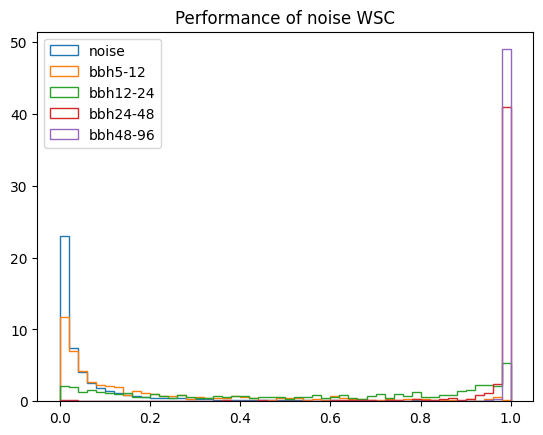

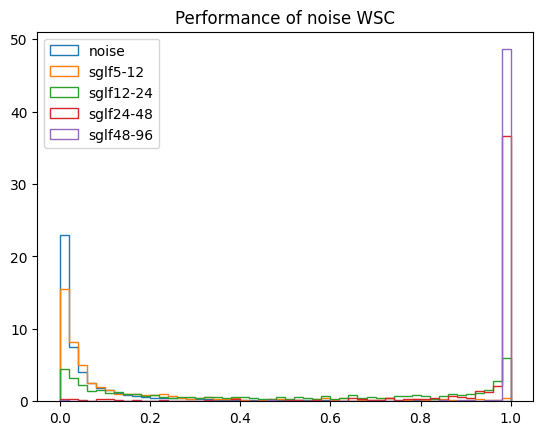

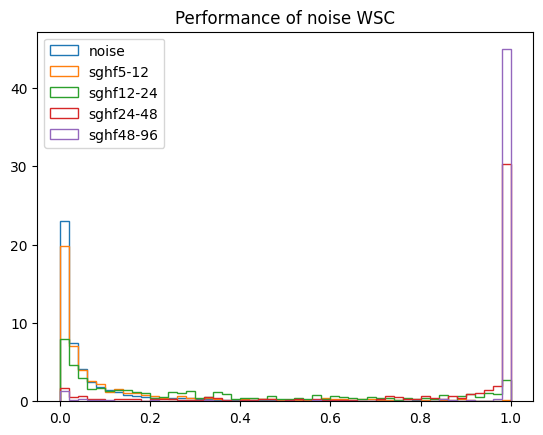

In [76]:
model = models['noise_WSC']

bkg_filtered = dataset_wsl_fft['noise']
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
# glitch_filtered = dataset_wsl_fft['glitch']

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    plt.title("Performance of noise WSC")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

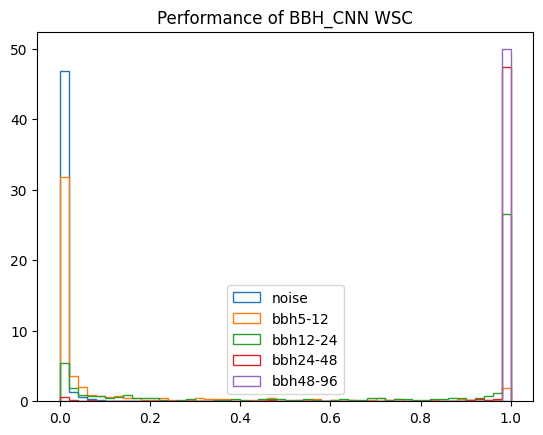

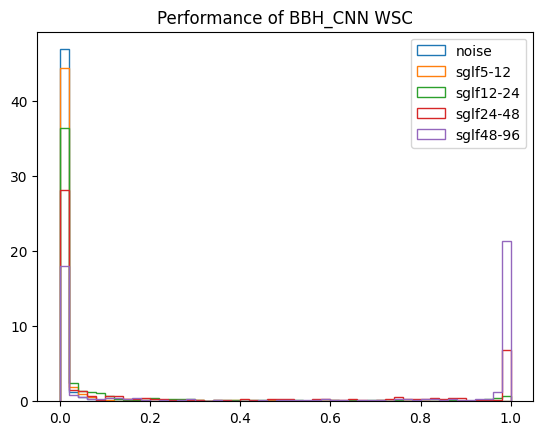

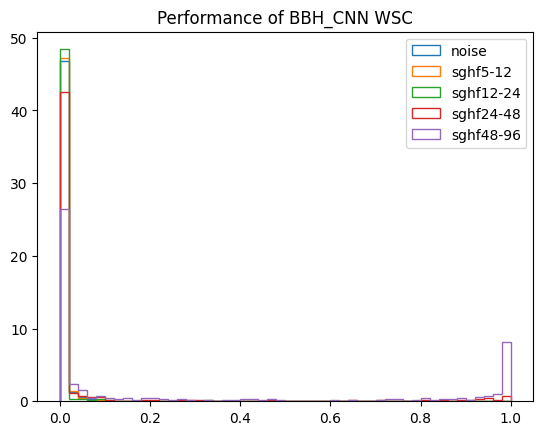

In [77]:
model = models['BBH_CNN_WSC']

bkg_filtered = dataset_wsl_fft['noise']
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
# glitch_filtered = dataset_wsl_fft['glitch']

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    plt.title("Performance of BBH_CNN WSC")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

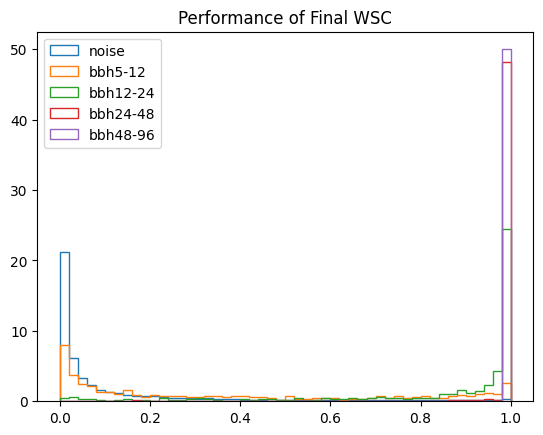

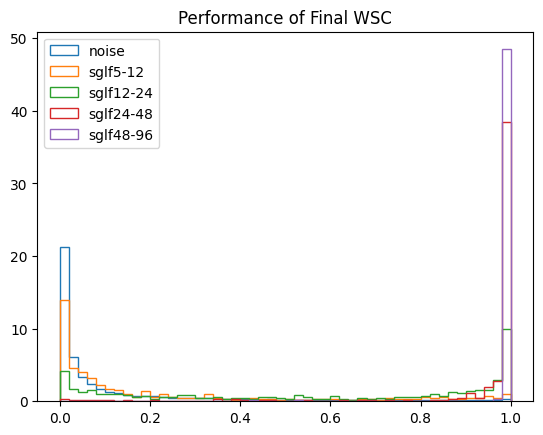

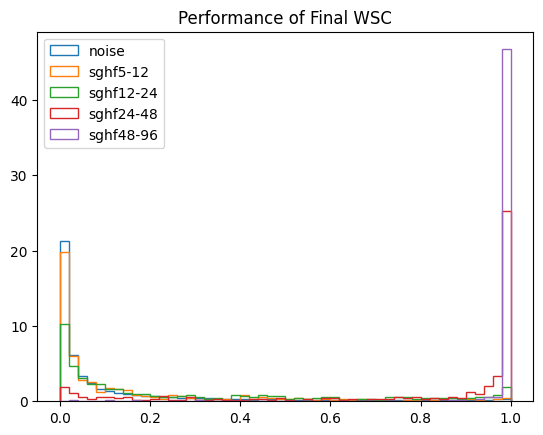

In [78]:
# v12

model = models['Final_WSC']

bkg_filtered = dataset_wsl_fft['noise']
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
# glitch_filtered = dataset_wsl_fft['glitch']

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    plt.title("Performance of Final WSC")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

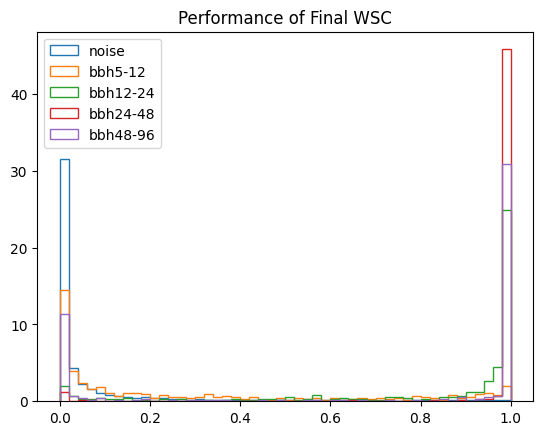

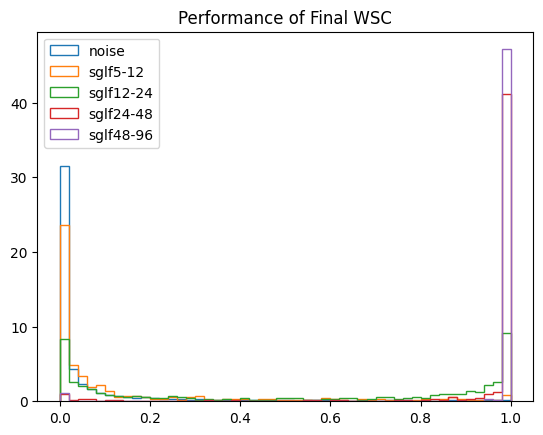

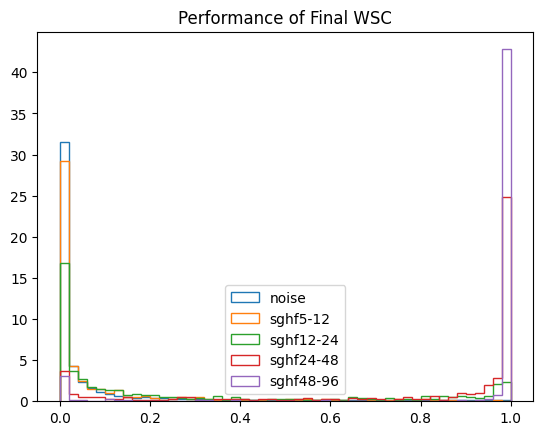

In [ ]:
# v15

model = models['Final_WSC']

bkg_filtered = dataset_wsl_fft['noise']
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
# glitch_filtered = dataset_wsl_fft['glitch']

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    plt.title("Performance of Final WSC")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

In [87]:
model_L = torch.load('../Model_cached/WSL_Chia-Jui_glitches/two_WSL_for_Chia-Jui_noise_cutscheme' + ''.join(['1','4']) + '_v2.json')['glitch_L']
model_H = torch.load('../Model_cached/WSL_Chia-Jui_glitches/two_WSL_for_Chia-Jui_noise_cutscheme' + ''.join(['1','4']) + '_v2.json')['glitch_H']

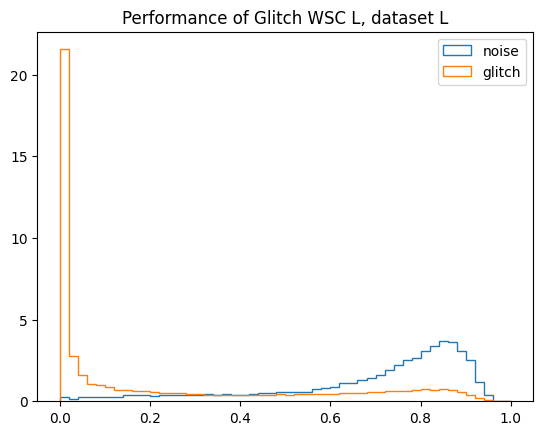

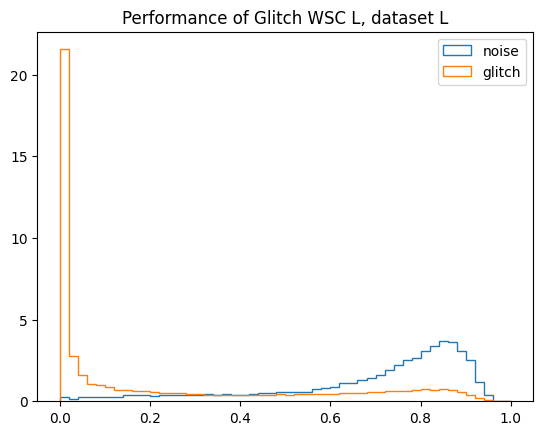

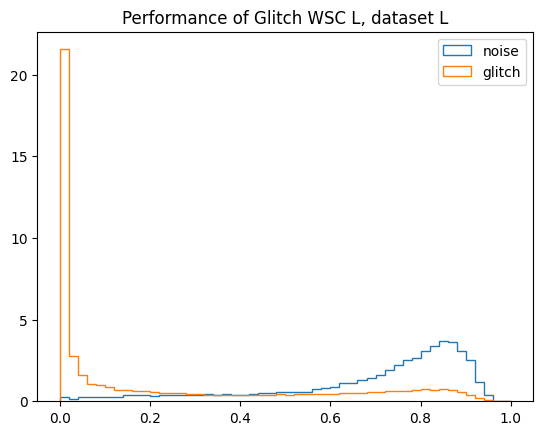

In [88]:
# Casual Plot

model = model_L

bkg_filtered = dataset_wsl_fft['noise'][:,:101]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
glitch_filtered = dataset_ae_fft['glitch'][:,:101]

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = nn.Sigmoid()(model(torch.FloatTensor(glitch_filtered))).detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
    plt.title("Performance of Glitch WSC L, dataset L")
        
        
    # for snr in snr_range:

    #     key = signal_type+snr
    #     dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key][:,:101]))).detach().numpy()
    #     foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

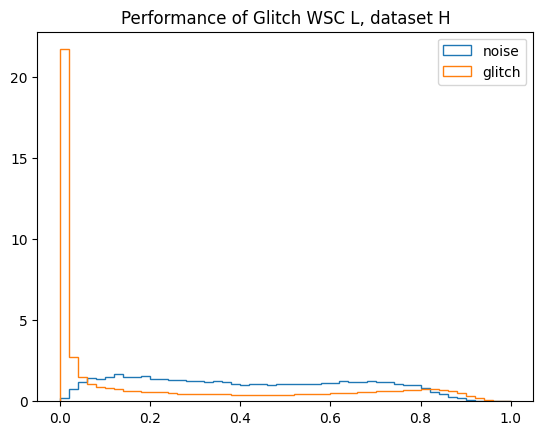

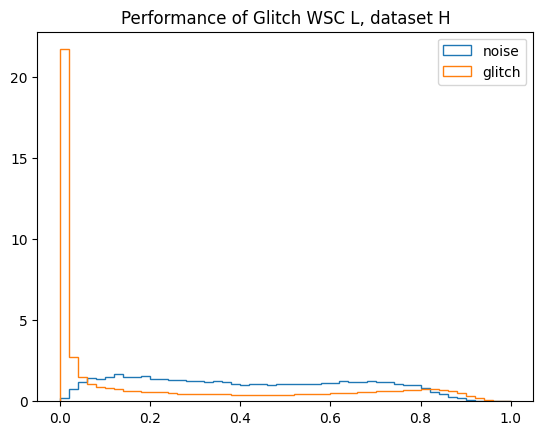

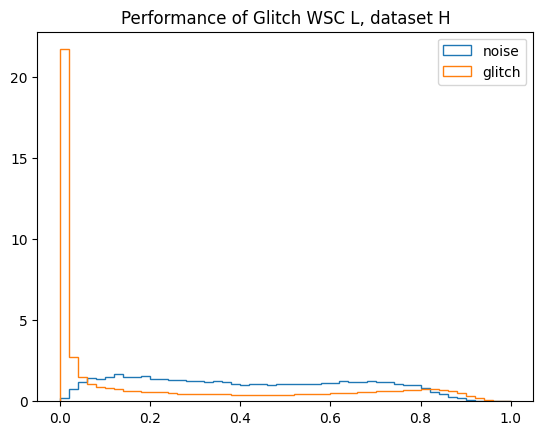

In [94]:
# Casual Plot

model = model_L

bkg_filtered = dataset_wsl_fft['noise'][:,101:]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
glitch_filtered = dataset_ae_fft['glitch'][:,101:]

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = nn.Sigmoid()(model(torch.FloatTensor(glitch_filtered))).detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
    plt.title("Performance of Glitch WSC L, dataset H")
        
        
    # for snr in snr_range:

    #     key = signal_type+snr
    #     dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key][:,:101]))).detach().numpy()
    #     foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

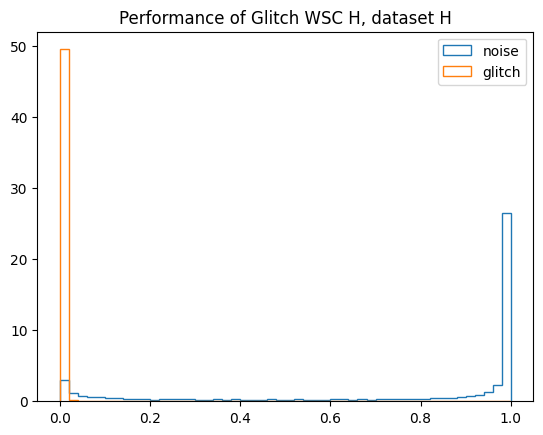

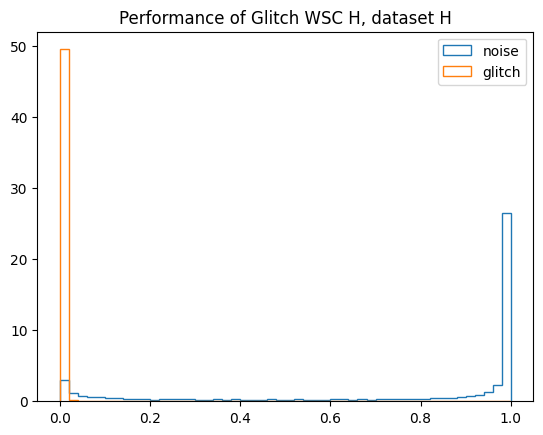

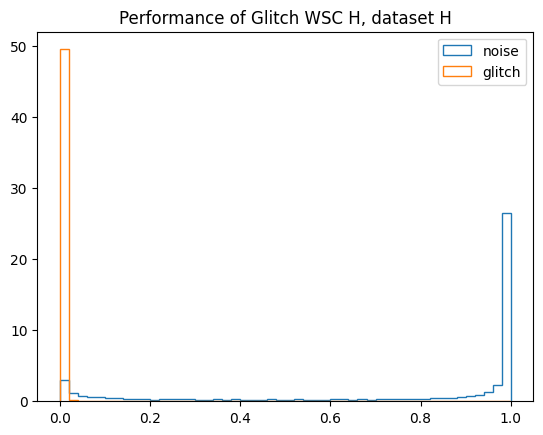

In [90]:
# Casual Plot

model = model_H

bkg_filtered = dataset_wsl_fft['noise'][:,101:]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
glitch_filtered = dataset_ae_fft['glitch'][:,101:]

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = nn.Sigmoid()(model(torch.FloatTensor(glitch_filtered))).detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
    plt.title("Performance of Glitch WSC H, dataset H")
        
        
    # for snr in snr_range:

    #     key = signal_type+snr
    #     dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key][:,:101]))).detach().numpy()
    #     foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

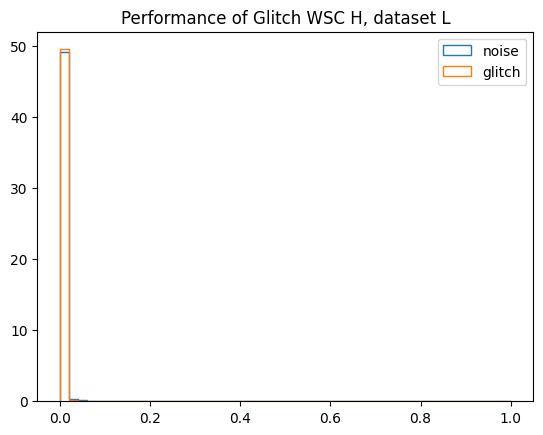

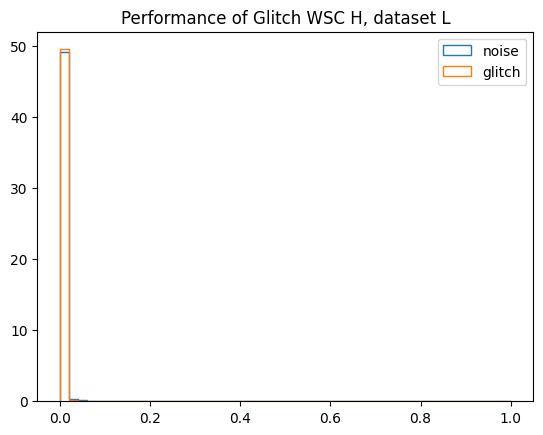

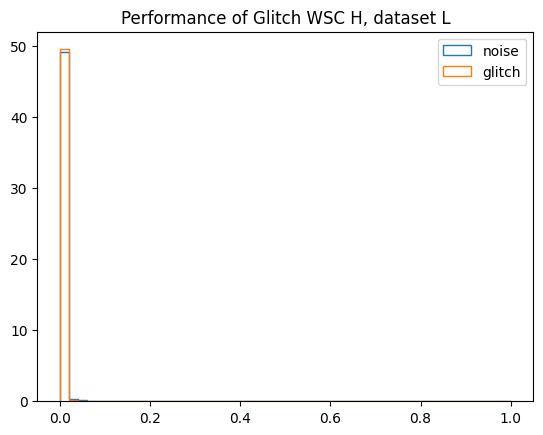

In [91]:
# Casual Plot

model = model_H

bkg_filtered = dataset_wsl_fft['noise'][:,:101]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
glitch_filtered = dataset_ae_fft['glitch'][:,:101]

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = nn.Sigmoid()(model(torch.FloatTensor(glitch_filtered))).detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
    plt.title("Performance of Glitch WSC H, dataset L")
        
        
    # for snr in snr_range:

    #     key = signal_type+snr
    #     dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key][:,:101]))).detach().numpy()
    #     foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

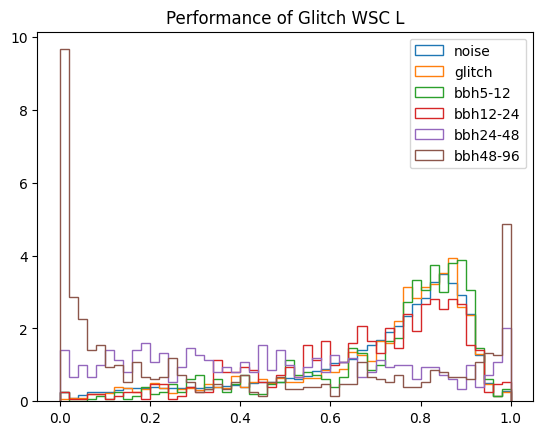

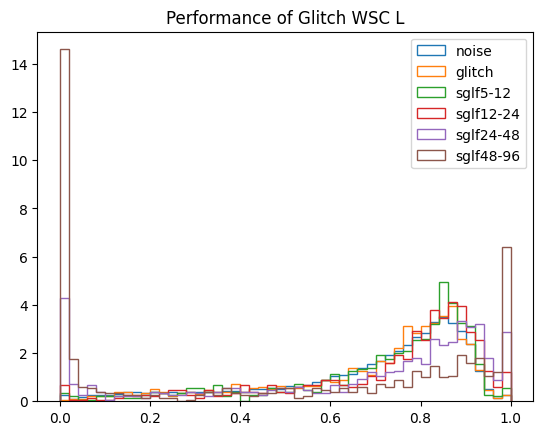

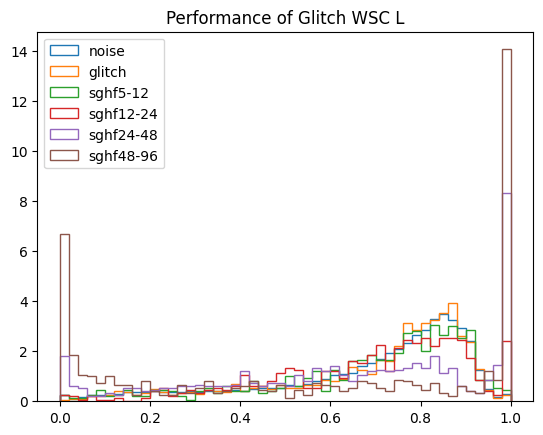

In [114]:
model = models['glitch_WSC_L']

bkg_filtered = dataset_wsl_fft['noise'][:,:101]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
glitch_filtered = dataset_wsl_fft['glitch'][:,:101]

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = nn.Sigmoid()(model(torch.FloatTensor(glitch_filtered))).detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
    plt.title("Performance of Glitch WSC L")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key][:,:101]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

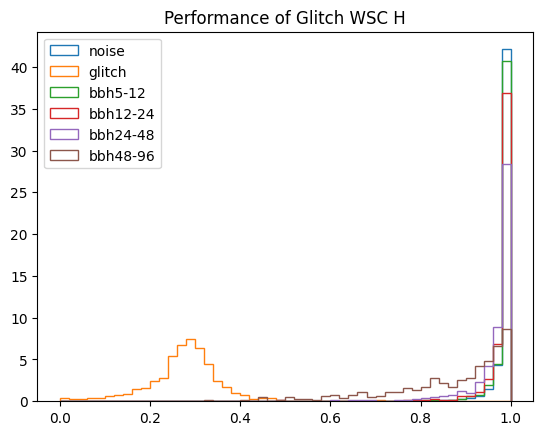

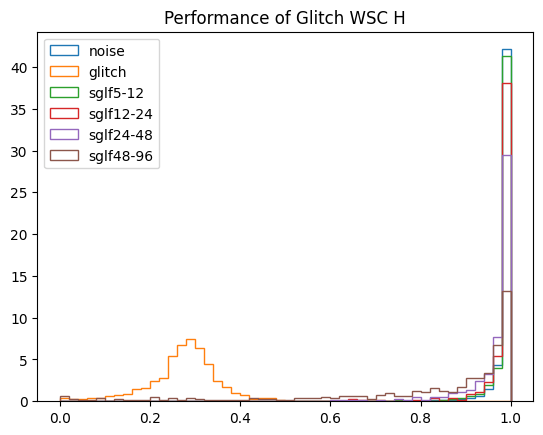

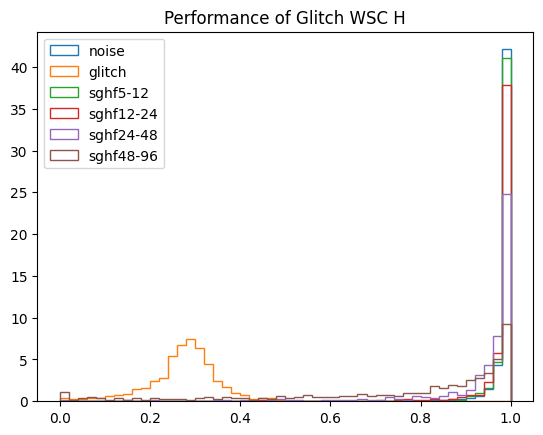

In [113]:
model = models['glitch_WSC_H']

bkg_filtered = dataset_wsl_fft['noise'][:,101:]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
glitch_filtered = dataset_wsl_fft['glitch'][:,101:]

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = nn.Sigmoid()(model(torch.FloatTensor(glitch_filtered))).detach().numpy()

count = 0


for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
    plt.title("Performance of Glitch WSC H")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key][:,101:]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)
        
        count += np.sum(dcd_signal < 0.5)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

In [105]:
count

296

In [ ]:
models

{'glitch_WSC_L': WSClassifier_Onedetector(
   (fc1): Linear(in_features=101, out_features=32, bias=True)
   (norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU()
   (sigmoid): Sigmoid()
   (fc2): Linear(in_features=32, out_features=1, bias=True)
 ),
 'glitch_WSC_H': WSClassifier_Onedetector(
   (fc1): Linear(in_features=101, out_features=32, bias=True)
   (norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU()
   (sigmoid): Sigmoid()
   (fc2): Linear(in_features=32, out_features=1, bias=True)
 ),
 'noise': AutoEncoder(
   (encoder): Sequential(
     (0): Linear(in_features=202, out_features=20, bias=True)
     (1): ReLU()
     (2): Linear(in_features=20, out_features=10, bias=True)
     (3): ReLU()
   )
   (decoder): Sequential(
     (0): Linear(in_features=10, out_features=20, bias=True)
     (1): ReLU()
     (2): Linear(in_features=20, out_features=202, bias=True)
     (3): Sigmoid

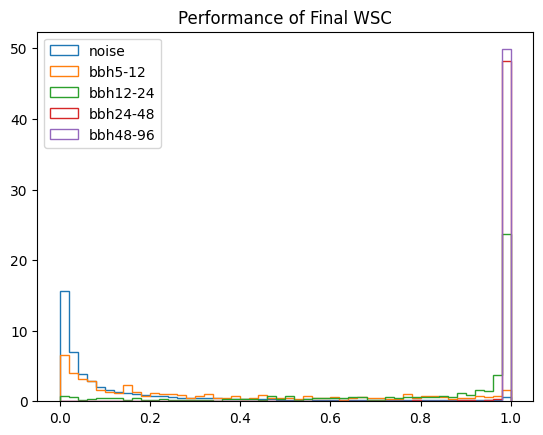

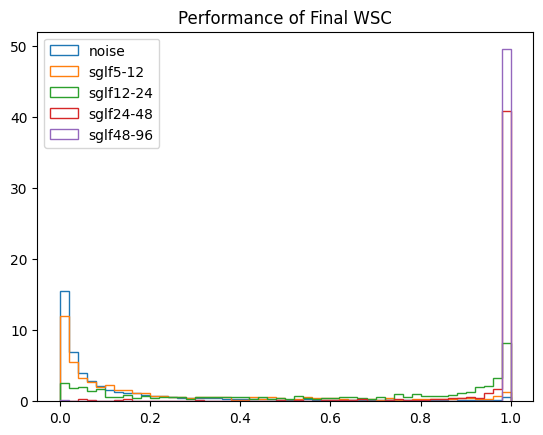

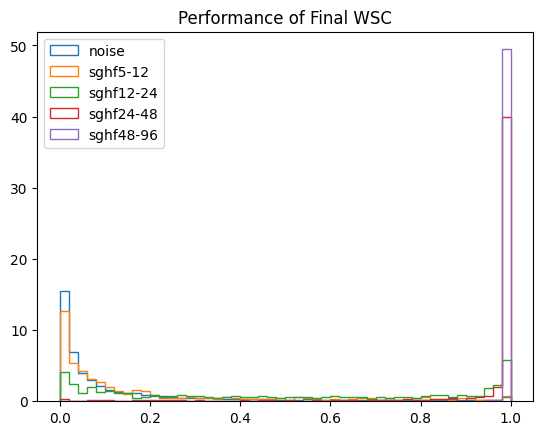

In [ ]:
# v14

model = models['Final_WSC']

bkg_filtered = dataset_wsl_fft['noise']
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
# glitch_filtered = dataset_wsl_fft['glitch']

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    plt.title("Performance of Final WSC")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

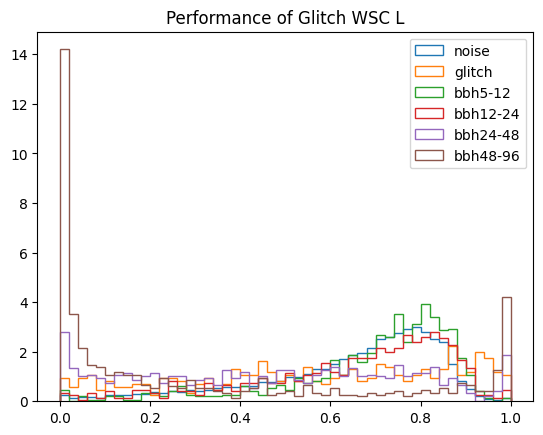

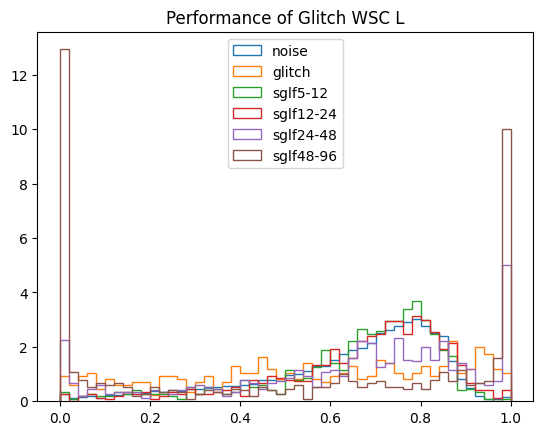

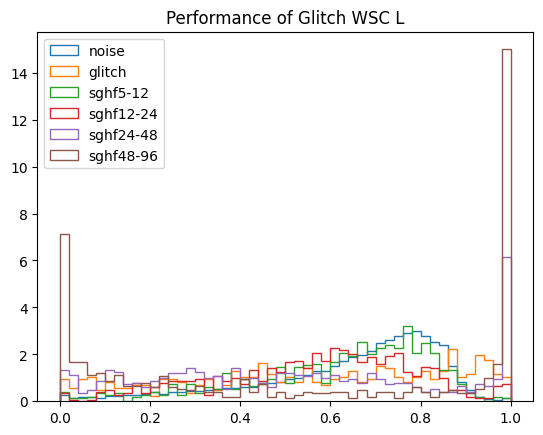

In [ ]:
# v14

model = models['glitch_WSC_L']

bkg_filtered = dataset_wsl_fft['noise'][:,:101]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
glitch_filtered = dataset_wsl_fft['glitch'][:,:101]

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_filtered)).detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
    plt.title("Performance of Glitch WSC L")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key][:,:101]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

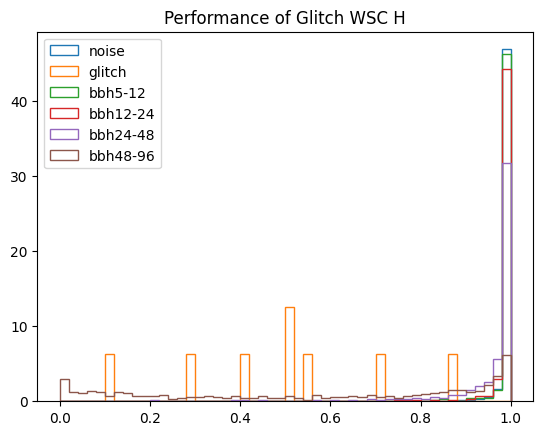

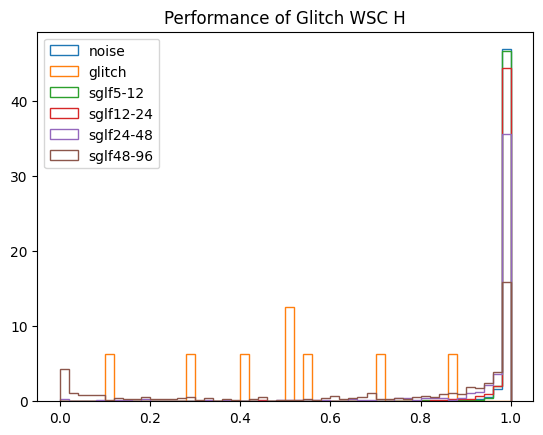

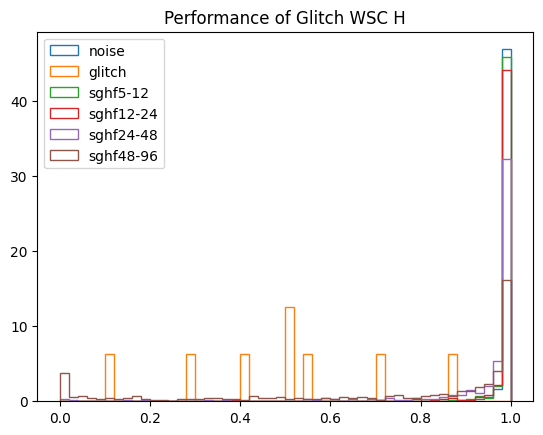

In [ ]:
# v14

model = models['glitch_WSC_H']

bkg_filtered = dataset_wsl_fft['noise'][:,101:]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
glitch_filtered = dataset_wsl_fft['glitch'][:,101:]

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_filtered)).detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
    plt.title("Performance of Glitch WSC H")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key][:,101:]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

In [ ]:
cutList['glitch_L']

array([0.0008, 0.0012, 0.0016, 0.002 , 0.0024])

In [ ]:
ic[2]

4

23250 events passed to AE for training. 


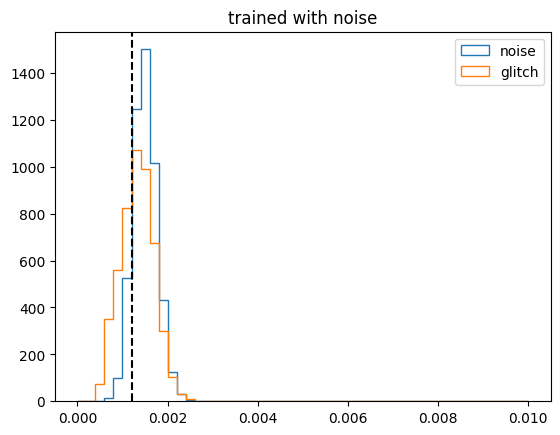

In [ ]:
# v14

model = trainAE_Onedetector(dataset_ae_fft['glitch'][:,:101], 'test', 'test', 'test')

dcd_bkg = model(torch.FloatTensor(dataset_wsl_fft['noise'][:,:101]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(dataset_ae_fft['glitch'][:,:101]))[1].detach().numpy()

foo = plt.hist(np.var(dataset_wsl_fft['noise'][:,:101]-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(dataset_ae_fft['glitch'][:,:101]-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
plt.axvline(cutList['glitch_L'][ic[2]], color="k", linestyle="--")
plt.legend()

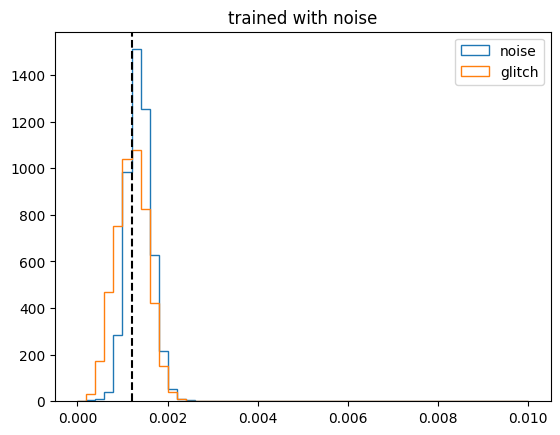

In [ ]:
# v14

model = models['glitch_L']

dcd_bkg = model(torch.FloatTensor(dataset_wsl_fft['noise'][:,:101]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(dataset_ae_fft['glitch'][:,:101]))[1].detach().numpy()

foo = plt.hist(np.var(dataset_wsl_fft['noise'][:,:101]-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(dataset_ae_fft['glitch'][:,:101]-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
plt.axvline(cutList['glitch_L'][ic[2]], color="k", linestyle="--")
plt.legend()

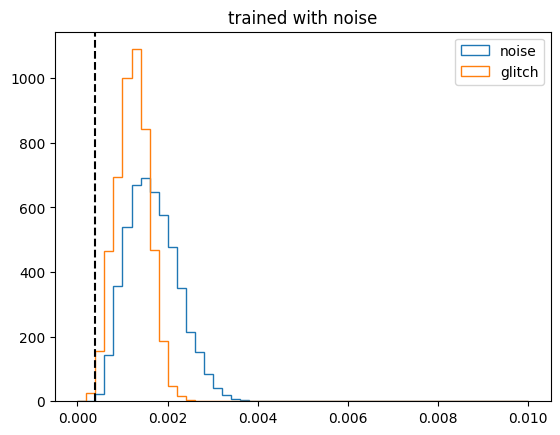

In [ ]:
# v14

model = models['glitch_H']

dcd_bkg = model(torch.FloatTensor(dataset_wsl_fft['noise'][:,101:]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(dataset_ae_fft['glitch'][:,101:]))[1].detach().numpy()

foo = plt.hist(np.var(dataset_wsl_fft['noise'][:,101:]-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(dataset_ae_fft['glitch'][:,101:]-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
plt.axvline(cutList['glitch_H'][ic[3]], color="k", linestyle="--")
plt.legend()

### test training the glitch AE

In [65]:
models = {}

In [66]:
dataset_wsl_fft_filtered = dataset_wsl_fft_collected

In [ ]:
# model = trainAE_Onedetector(dataset_ae_fft['glitch'][:,:101], 'test', 'test', 'glitch')
# models['glitch_L'] = model

# model = trainAE_Onedetector(dataset_ae_fft['glitch'][:,101:], 'test', 'test', 'glitch')
# models['glitch_H'] = model

dcd = models['glitch_L'](torch.FloatTensor(dataset_wsl_fft_filtered[:,:101]))[1].detach().numpy()

dataset0 = dataset_ae_fft['glitch'][:,:101]
dataset1 = dataset_wsl_fft_filtered[np.var(dataset_wsl_fft_filtered[:,:101]-dcd, axis=1) > cutList['glitch_L'][1]][:,:101]

model_L = trainWSC_Onedetector(dataset0, dataset1, 'test', 'test', 'glitch')
models["glitch_WSC_L"] = model_L


dcd = models['glitch_H'](torch.FloatTensor(dataset_wsl_fft_filtered[:,101:]))[1].detach().numpy()

dataset0 = dataset_ae_fft['glitch'][:,101:]
dataset1 = dataset_wsl_fft_filtered[np.var(dataset_wsl_fft_filtered[:,101:]-dcd, axis=1) > cutList['glitch_H'][0]][:,101:]

model_H = trainWSC_Onedetector(dataset0, dataset1, 'test', 'test', 'glitch')
models["glitch_WSC_H"] = model_H

39250 noise events and 24515 signal events passed to WSC for training. 
39250 noise events and 29921 signal events passed to WSC for training. 


In [76]:
dcd = models['glitch_L'](torch.FloatTensor(dataset_wsl_fft['noise'][:,:101]))[1].detach().numpy()

dataset0 = dataset_ae_fft['glitch'][:,:101]
dataset1 = dataset_wsl_fft['noise'][np.var(dataset_wsl_fft['noise'][:,:101]-dcd, axis=1) > cutList['glitch_L'][0]][:,:101]

model_L = trainWSC_Onedetector(dataset0, dataset1, 'test', 'test', 'glitch')
models["glitch_WSC_L"] = model_L

39250 noise events and 19220 signal events passed to WSC for training. 


In [75]:
# Don't use this. This is not strict as we are using Hanford glitch model to fit for the Livinston

dcd = models['glitch_H'](torch.FloatTensor(dataset_wsl_fft_filtered[:,:101]))[1].detach().numpy()

dataset0 = dataset_ae_fft['glitch'][:,:101]
dataset1 = dataset_wsl_fft_filtered[np.var(dataset_wsl_fft_filtered[:,:101]-dcd, axis=1) > cutList['glitch_H'][0]][:,:101]

model_L = trainWSC_Onedetector(dataset0, dataset1, 'test', 'test', 'glitch')
models["glitch_WSC_L"] = model_L

KeyError: 'glitch_H'

In [67]:
model = trainAE_Onedetector(dataset_ae_fft['glitch'][:,:101], 'test', 'test', 'glitch')
models['glitch_L'] = model

39250 events passed to AE for training. 


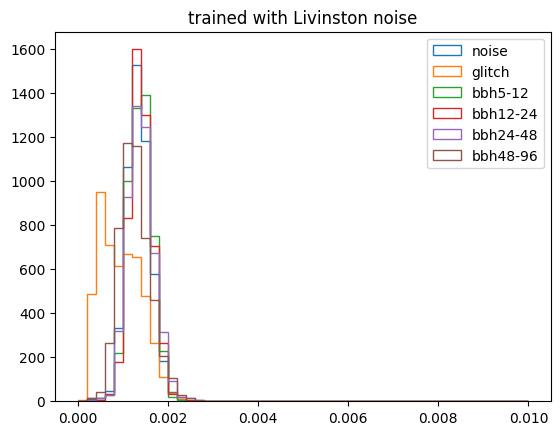

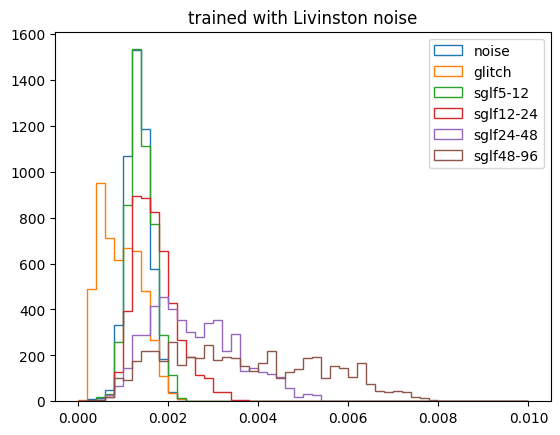

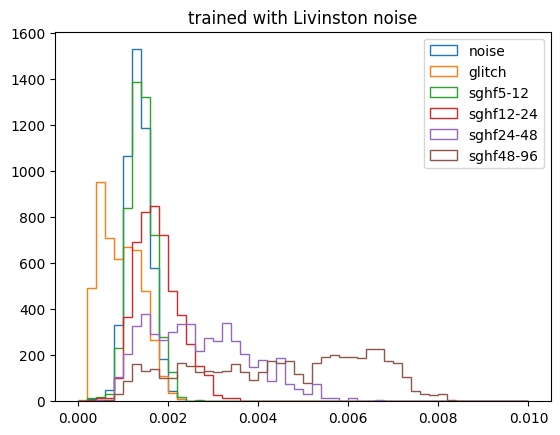

In [69]:
# test

model = models['glitch_L']

dcd_bkg = model(torch.FloatTensor(dataset_wsl_fft['noise'][:,:101]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(dataset_ae_fft['glitch'][:,:101]))[1].detach().numpy()

for key in ['bbh', 'sglf', 'sghf']:

    foo = plt.hist(np.var(dataset_wsl_fft['noise'][:,:101]-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    foo = plt.hist(np.var(dataset_ae_fft['glitch'][:,:101]-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")

    for snr in snr_range:
        key_to_plot = key+snr
        dcd_signal = model(torch.FloatTensor(dataset_wsl_fft[key_to_plot][:,:101]))[1].detach().numpy()
        plt.hist(np.var(dataset_wsl_fft[key_to_plot][:,:101] - dcd_signal, axis = 1), histtype="step", range=(0, 0.01), bins=50, density=True, label=key_to_plot)



    plt.title("trained with Livinston noise")
    # plt.axvline(cutList['glitch_L'][0], color="k", linestyle="--")
    plt.legend()
    
    plt.show()

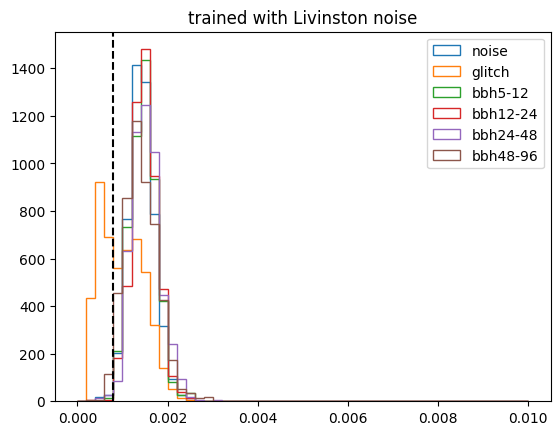

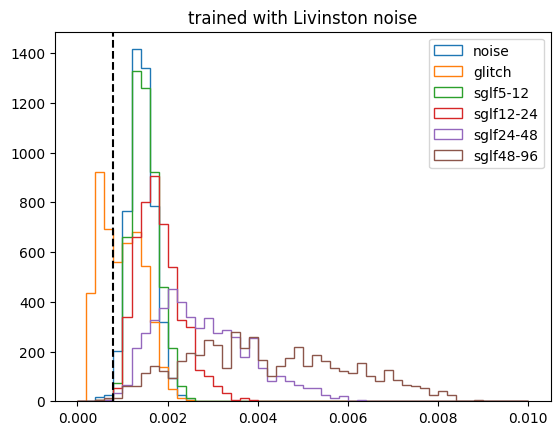

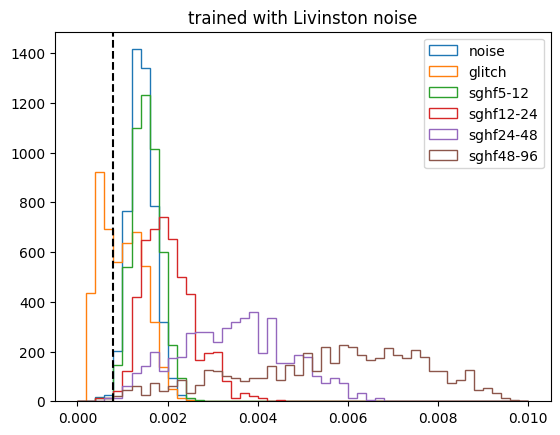

In [ ]:
# test

model = models['glitch_L']

dcd_bkg = model(torch.FloatTensor(dataset_wsl_fft['noise'][:,:101]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(dataset_ae_fft['glitch'][:,:101]))[1].detach().numpy()

for key in ['bbh', 'sglf', 'sghf']:

    foo = plt.hist(np.var(dataset_wsl_fft['noise'][:,:101]-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    foo = plt.hist(np.var(dataset_ae_fft['glitch'][:,:101]-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")

    for snr in snr_range:
        key_to_plot = key+snr
        dcd_signal = model(torch.FloatTensor(dataset_wsl_fft[key_to_plot][:,:101]))[1].detach().numpy()
        plt.hist(np.var(dataset_wsl_fft[key_to_plot][:,:101] - dcd_signal, axis = 1), histtype="step", range=(0, 0.01), bins=50, density=True, label=key_to_plot)



    plt.title("trained with Livinston noise")
    plt.axvline(cutList['glitch_L'][0], color="k", linestyle="--")
    plt.legend()
    
    plt.show()

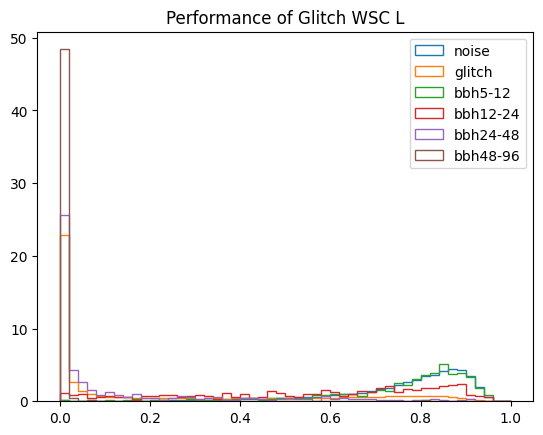

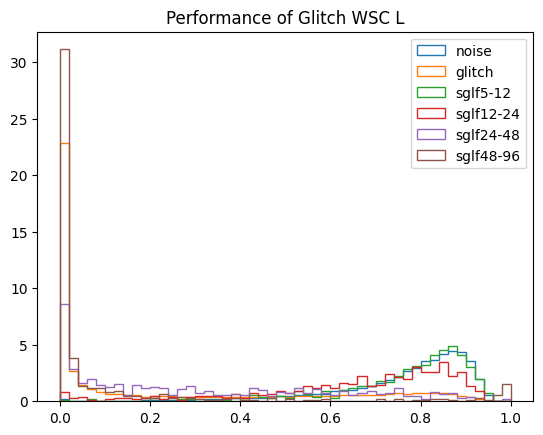

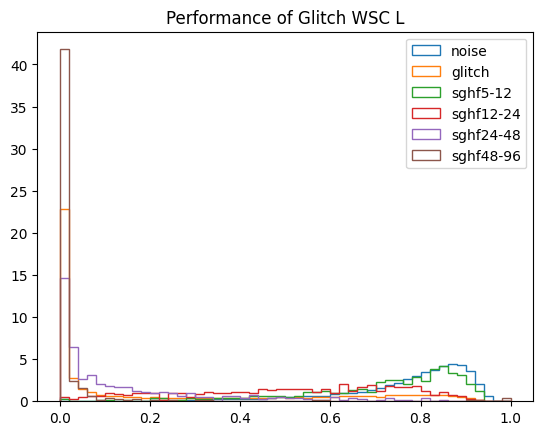

In [77]:
# test
# Be careful here. The AE is using the Hanford AE

model = models['glitch_WSC_L']

bkg_filtered = dataset_wsl_fft['noise'][:,:101]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
glitch_filtered = dataset_ae_fft['glitch'][:,:101]

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = nn.Sigmoid()(model(torch.FloatTensor(glitch_filtered))).detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
    plt.title("Performance of Glitch WSC L")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key][:,:101]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

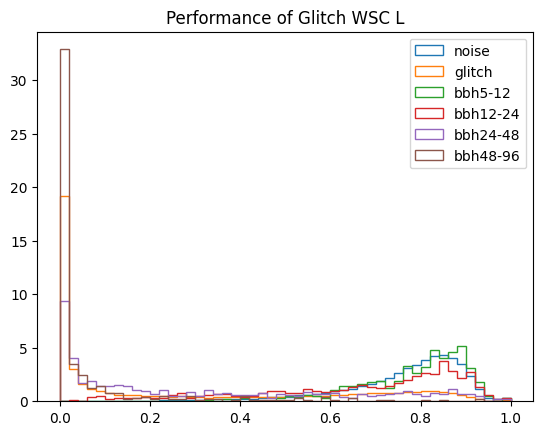

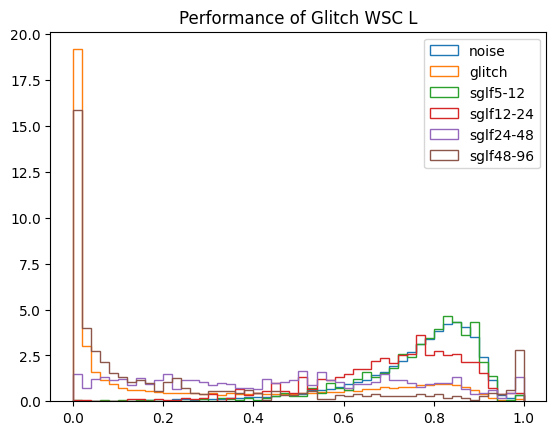

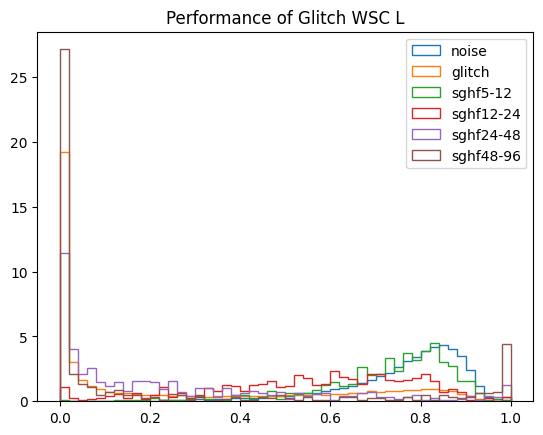

In [124]:
# test
# Be careful here. The AE is using the Hanford AE

model = models['glitch_WSC_L']

bkg_filtered = dataset_wsl_fft['noise'][:,:101]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
glitch_filtered = dataset_ae_fft['glitch'][:,:101]

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = nn.Sigmoid()(model(torch.FloatTensor(glitch_filtered))).detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
    plt.title("Performance of Glitch WSC L")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key][:,:101]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

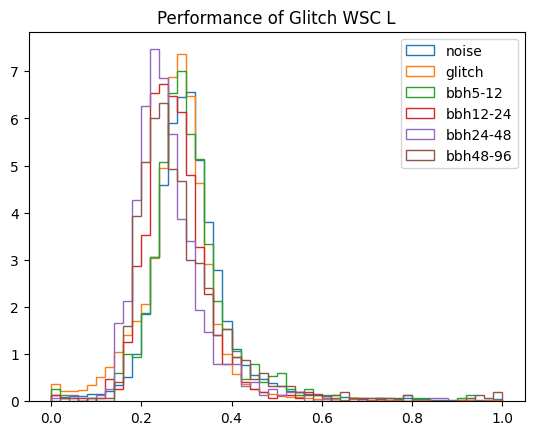

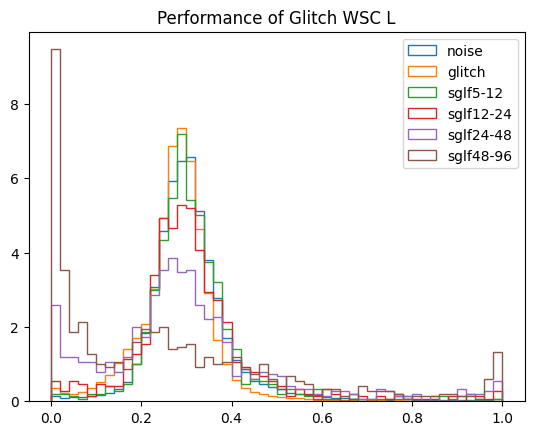

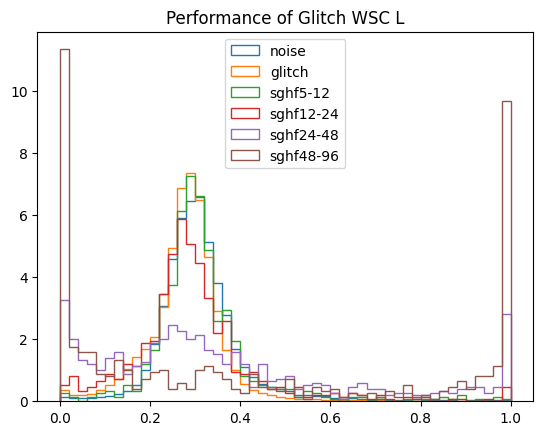

In [125]:
# test
# Be careful here. The AE is using the Hanford AE

model = models['glitch_WSC_H']

bkg_filtered = dataset_wsl_fft['noise'][:,:101]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
glitch_filtered = dataset_ae_fft['glitch'][:,:101]

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = nn.Sigmoid()(model(torch.FloatTensor(glitch_filtered))).detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
    plt.title("Performance of Glitch WSC L")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key][:,:101]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

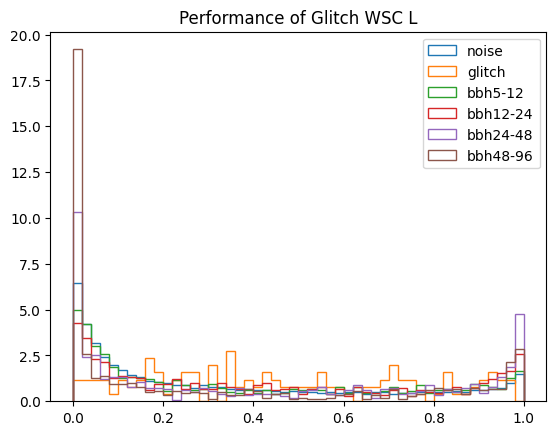

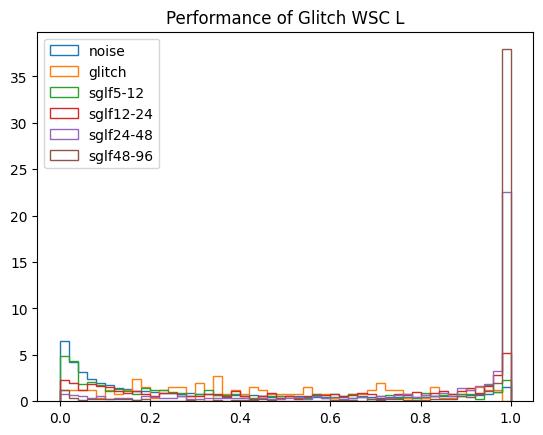

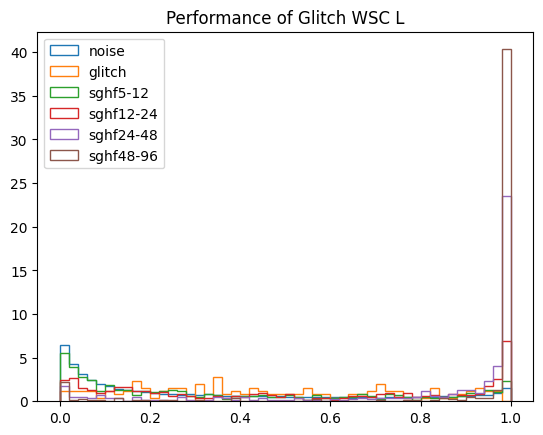

In [ ]:
# test

model = models['glitch_WSC_L']

bkg_filtered = dataset_wsl_fft['noise'][:,:101]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
glitch_filtered = dataset_wsl_fft['glitch'][:,:101]

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_filtered)).detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
    plt.title("Performance of Glitch WSC L")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key][:,:101]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

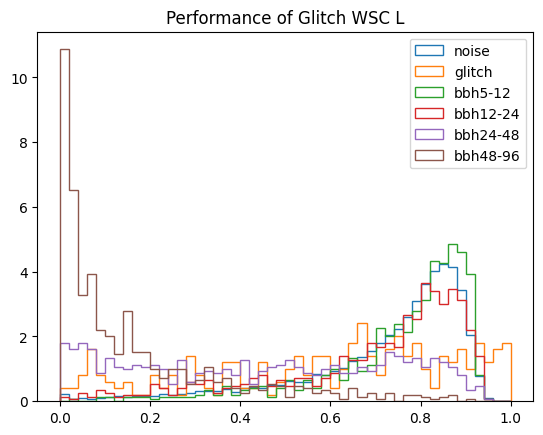

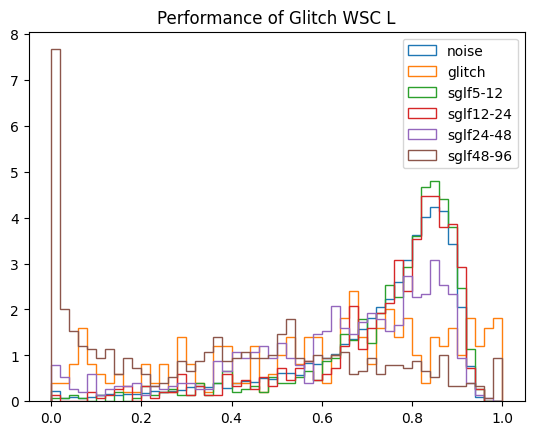

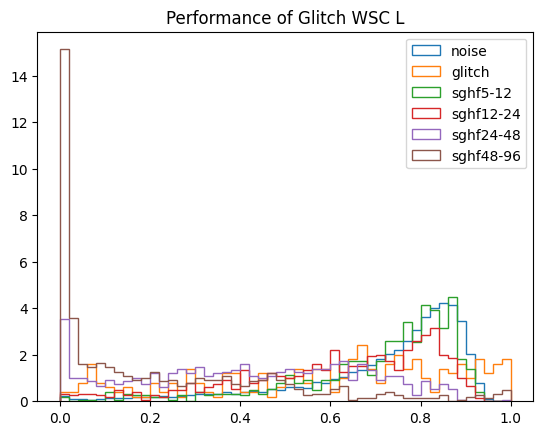

In [ ]:
# test

model = models['glitch_WSC_L']

bkg_filtered = dataset_wsl_fft['noise'][:,:101]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
glitch_filtered = dataset_wsl_fft['glitch'][:,:101]

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_filtered)).detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
    plt.title("Performance of Glitch WSC L")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key][:,:101]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

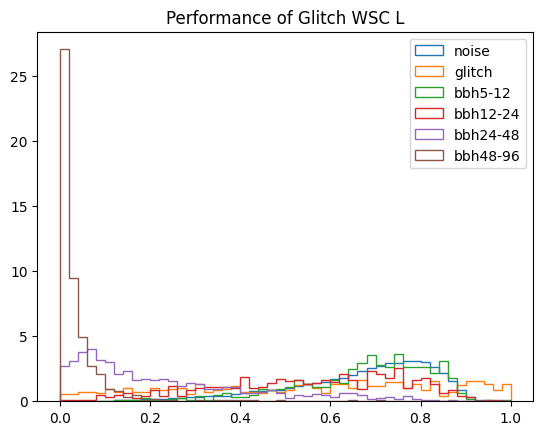

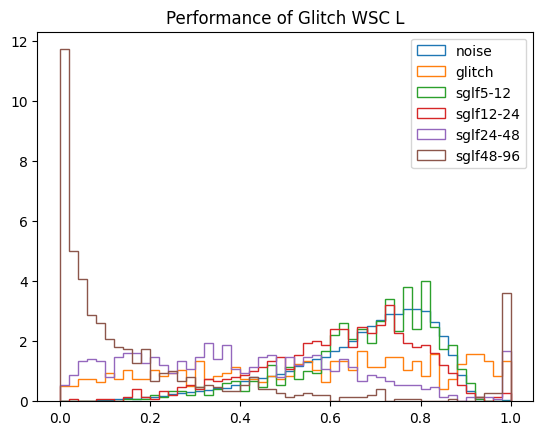

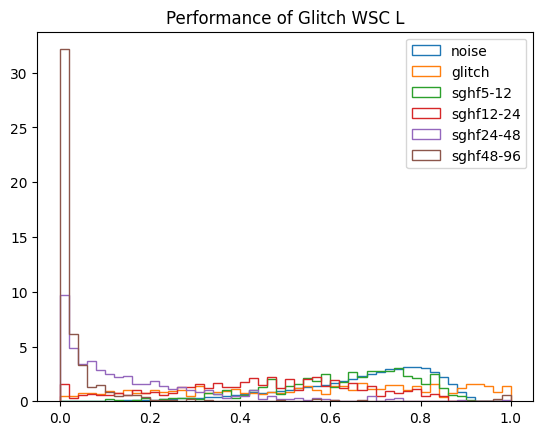

In [ ]:
# test

model = models['glitch_WSC_L']

bkg_filtered = dataset_wsl_fft['noise'][:,:101]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
glitch_filtered = dataset_wsl_fft['glitch'][:,:101]

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_filtered)).detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
    plt.title("Performance of Glitch WSC L")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key][:,:101]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

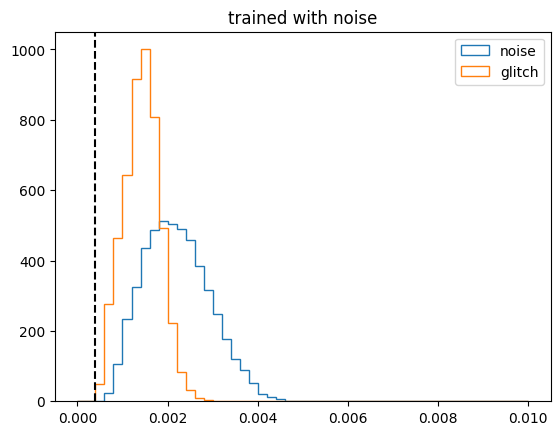

In [ ]:
# test

model = models['glitch_H']

dcd_bkg = model(torch.FloatTensor(dataset_wsl_fft['noise'][:,101:]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(dataset_ae_fft['glitch'][:,101:]))[1].detach().numpy()

foo = plt.hist(np.var(dataset_wsl_fft['noise'][:,101:]-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(dataset_ae_fft['glitch'][:,101:]-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
plt.axvline(cutList['glitch_H'][0], color="k", linestyle="--")
plt.legend()

In [116]:
models

{'glitch_WSC_L': WSClassifier_Onedetector(
   (fc1): Linear(in_features=101, out_features=32, bias=True)
   (norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU()
   (sigmoid): Sigmoid()
   (fc2): Linear(in_features=32, out_features=1, bias=True)
 ),
 'glitch_WSC_H': WSClassifier_Onedetector(
   (fc1): Linear(in_features=101, out_features=32, bias=True)
   (norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU()
   (sigmoid): Sigmoid()
   (fc2): Linear(in_features=32, out_features=1, bias=True)
 ),
 'noise': AutoEncoder(
   (encoder): Sequential(
     (0): Linear(in_features=202, out_features=20, bias=True)
     (1): ReLU()
     (2): Linear(in_features=20, out_features=10, bias=True)
     (3): ReLU()
   )
   (decoder): Sequential(
     (0): Linear(in_features=10, out_features=20, bias=True)
     (1): ReLU()
     (2): Linear(in_features=20, out_features=202, bias=True)
     (3): Sigmoid

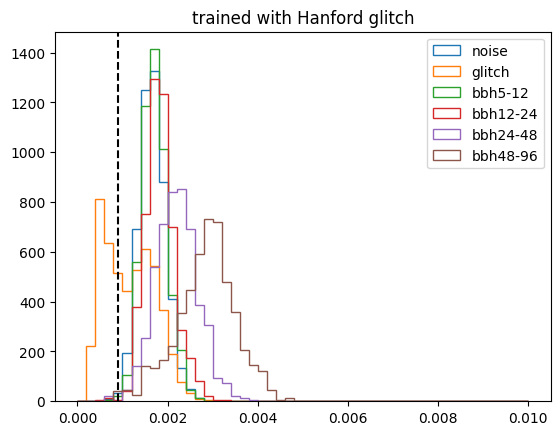

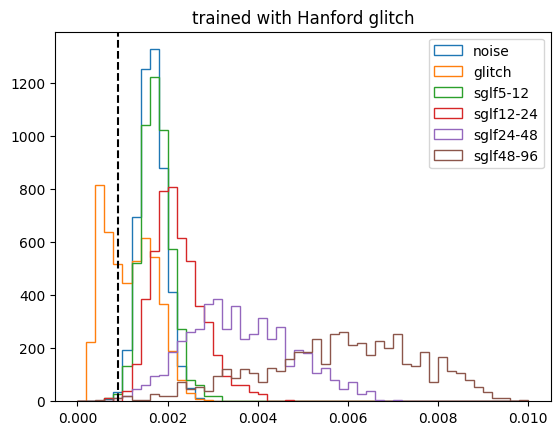

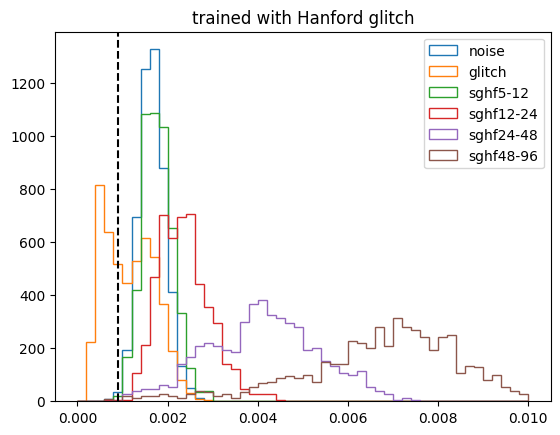

In [118]:
# test
# How about Livinston data in Hanford model

model = models['glitch_H']

dcd_bkg = model(torch.FloatTensor(dataset_wsl_fft['noise'][:,:101]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(dataset_ae_fft['glitch'][:,:101]))[1].detach().numpy()

for key in ['bbh', 'sglf', 'sghf']:

    foo = plt.hist(np.var(dataset_wsl_fft['noise'][:,:101]-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    foo = plt.hist(np.var(dataset_ae_fft['glitch'][:,:101]-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")

    for snr in snr_range:
        key_to_plot = key+snr
        dcd_signal = model(torch.FloatTensor(dataset_wsl_fft[key_to_plot][:,:101]))[1].detach().numpy()
        plt.hist(np.var(dataset_wsl_fft[key_to_plot][:,:101] - dcd_signal, axis = 1), histtype="step", range=(0, 0.01), bins=50, density=True, label=key_to_plot)



    plt.title("trained with Hanford glitch")
    plt.axvline(cutList['glitch_H'][1], color="k", linestyle="--")
    plt.legend()
    
    plt.show()

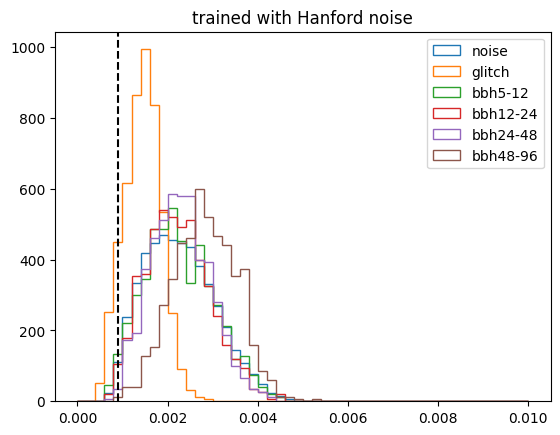

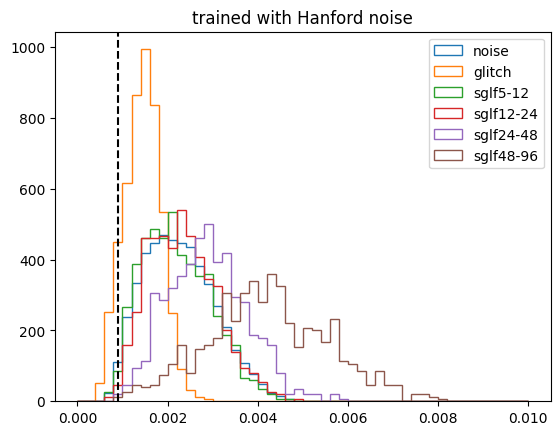

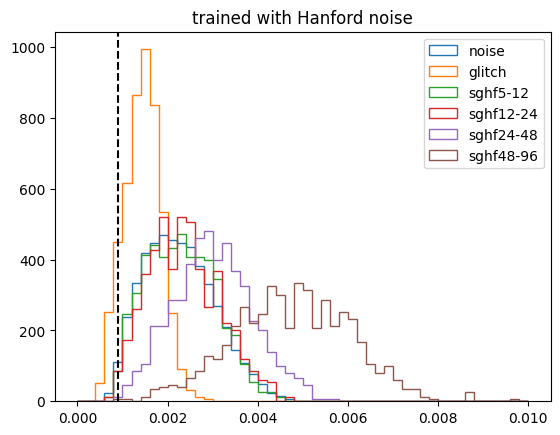

In [ ]:
# test

model = models['glitch_H']

dcd_bkg = model(torch.FloatTensor(dataset_wsl_fft['noise'][:,101:]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(dataset_ae_fft['glitch'][:,101:]))[1].detach().numpy()

for key in ['bbh', 'sglf', 'sghf']:

    foo = plt.hist(np.var(dataset_wsl_fft['noise'][:,101:]-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    foo = plt.hist(np.var(dataset_ae_fft['glitch'][:,101:]-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")

    for snr in snr_range:
        key_to_plot = key+snr
        dcd_signal = model(torch.FloatTensor(dataset_wsl_fft[key_to_plot][:,101:]))[1].detach().numpy()
        plt.hist(np.var(dataset_wsl_fft[key_to_plot][:,101:] - dcd_signal, axis = 1), histtype="step", range=(0, 0.01), bins=50, density=True, label=key_to_plot)



    plt.title("trained with Hanford noise")
    plt.axvline(cutList['glitch_H'][1], color="k", linestyle="--")
    plt.legend()
    
    plt.show()

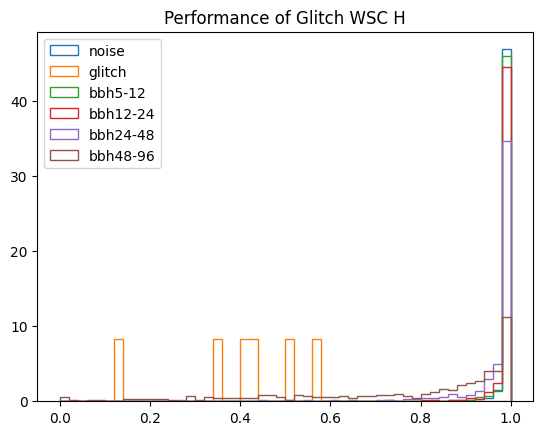

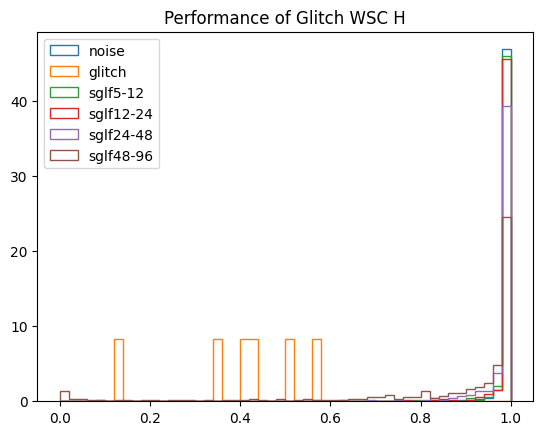

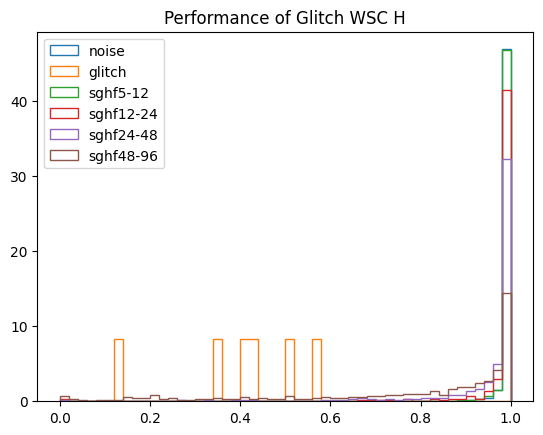

In [ ]:
# test
model = models['glitch_WSC_H']

bkg_filtered = dataset_wsl_fft['noise'][:,101:]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
glitch_filtered = dataset_wsl_fft['glitch'][:,101:]

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_filtered)).detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
    plt.title("Performance of Glitch WSC H")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key][:,101:]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()

### How about the performance for glitch trained CNN AE?

In [88]:
model_CNN = torch.load('../Model_cached/CNN_GLITCH/model_dep_6_chnl_12_btn_20.pt')

In [71]:
dcd_glitch = model(torch.FloatTensor(dataset_ae['glitch'][:10000][:,:200].reshape(-1,1,200)))

In [72]:
np.var(dcd_glitch.detach().numpy() - dataset_ae['glitch'][:10000][:,:200].reshape(-1,1,200), axis = -1)

(10000, 1, 200)

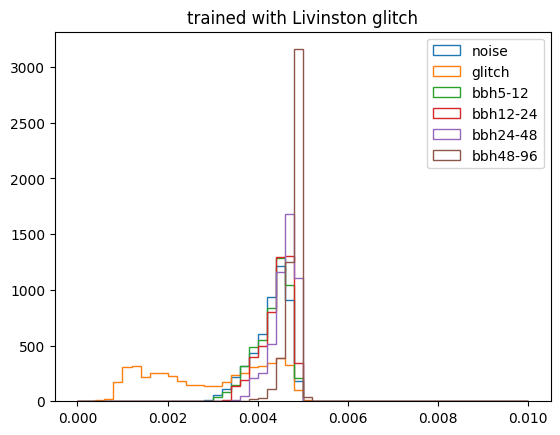

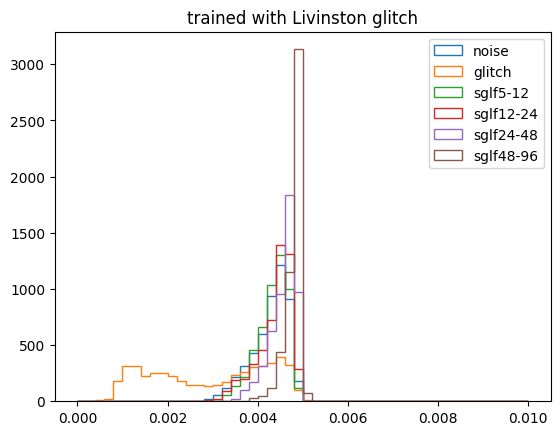

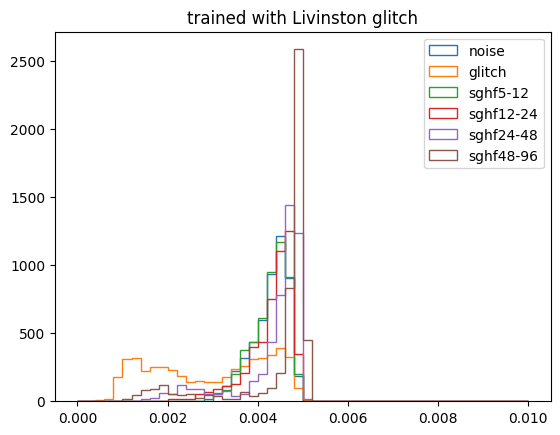

In [76]:
dcd_bkg = model(torch.FloatTensor(dataset_wsl['noise'][:,:200].reshape(-1,1,200))).detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(dataset_ae['glitch'][:10000][:,:200].reshape(-1,1,200))).detach().numpy()

for key in ['bbh', 'sglf', 'sghf']:

    foo = plt.hist(np.var(dataset_wsl['noise'][:,:200].reshape(-1,1,200)-dcd_bkg, axis=-1).flatten(), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    foo = plt.hist(np.var(dataset_ae['glitch'][:10000][:,:200].reshape(-1,1,200)-dcd_glitch, axis=-1).flatten(), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")

    for snr in snr_range:
        key_to_plot = key+snr
        dcd_signal = model(torch.FloatTensor(dataset_wsl[key_to_plot][:,:200].reshape(-1,1,200))).detach().numpy()
        plt.hist(np.var(dataset_wsl[key_to_plot][:,:200].reshape(-1,1,200) - dcd_signal, axis = -1).flatten(), histtype="step", range=(0, 0.01), bins=50, density=True, label=key_to_plot)



    plt.title("trained with Livinston glitch")
    # plt.axvline(cutList['glitch_H'][1], color="k", linestyle="--")
    # plt.axvline(, color="k", linestyle="--")
    plt.legend()
    
    plt.show()

In [79]:
dataset_wsl_collected[:,:200].shape

(30000, 200)

In [89]:
dcd = model_CNN(torch.FloatTensor(dataset_wsl_collected[:,:200].reshape(-1,1,200))).detach().numpy()

dataset0 = dataset_ae_fft['glitch'][:,:101]
dataset1 = dataset_wsl_fft_collected[np.var(dataset_wsl_collected[:,:200].reshape(-1,1,200)-dcd, axis=-1).flatten()>0.004][:,:101]

In [92]:
model = trainWSC_Onedetector(dataset1, dataset0, 'test', 'test', 'test')

23938 noise events and 39250 signal events passed to WSC for training. 


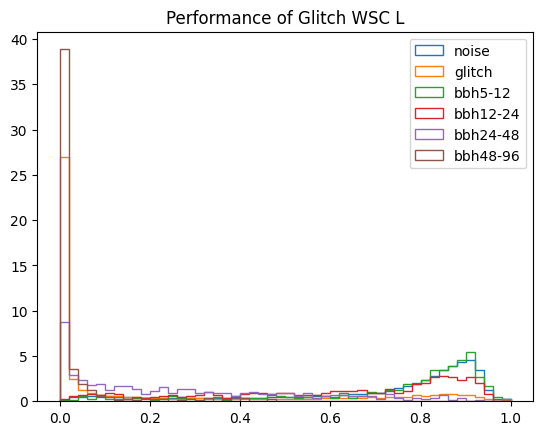

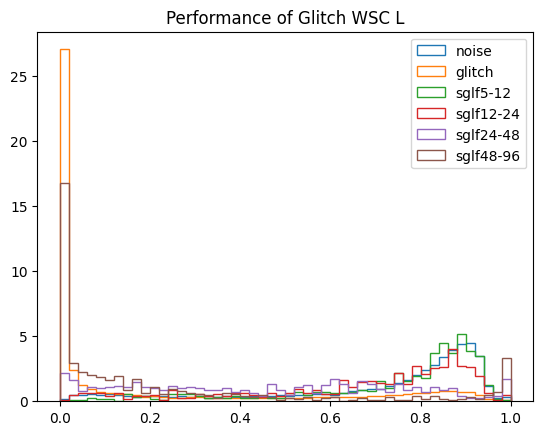

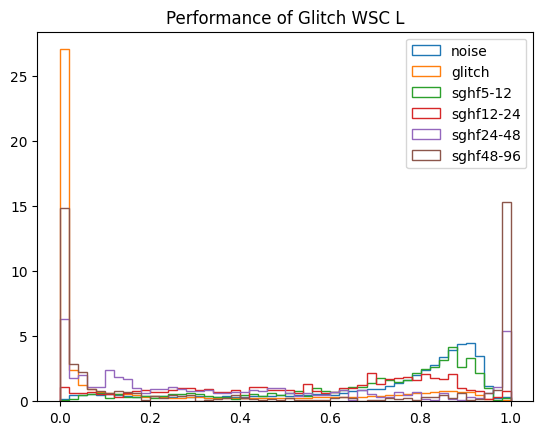

In [91]:
bkg_filtered = dataset_wsl_fft['noise'][:,:101]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
glitch_filtered = dataset_ae_fft['glitch'][:,:101]

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = nn.Sigmoid()(model(torch.FloatTensor(glitch_filtered))).detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
    plt.title("Performance of Glitch WSC L")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key][:,:101]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

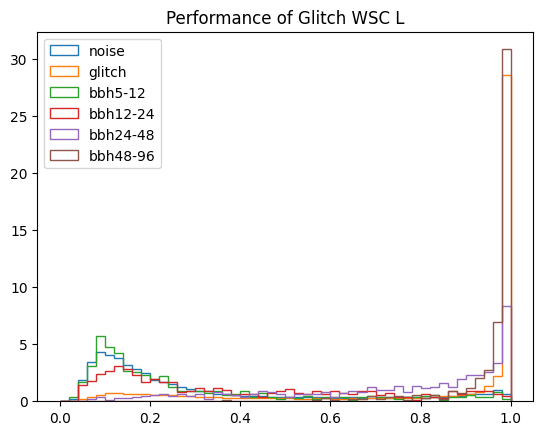

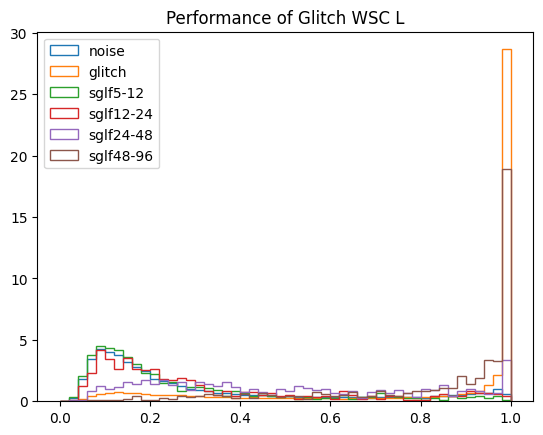

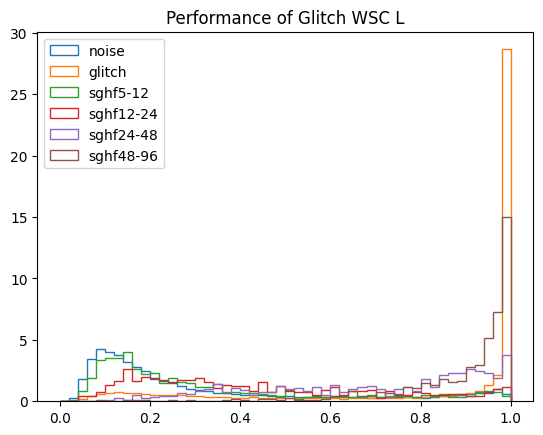

In [93]:
bkg_filtered = dataset_wsl_fft['noise'][:,:101]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
glitch_filtered = dataset_ae_fft['glitch'][:,:101]

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = nn.Sigmoid()(model(torch.FloatTensor(glitch_filtered))).detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
    plt.title("Performance of Glitch WSC L")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key][:,:101]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

### Make a 3-class learning

In [153]:
models = torch.load("../Data_cached/SequentialTraining/WSL/trained_model" + "".join(['4','0']) + "_"+'v12'+".json")

In [154]:
models

{'glitch_WSC_L': WSClassifier_Onedetector(
   (fc1): Linear(in_features=101, out_features=32, bias=True)
   (norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU()
   (sigmoid): Sigmoid()
   (fc2): Linear(in_features=32, out_features=1, bias=True)
 ),
 'glitch_WSC_H': WSClassifier_Onedetector(
   (fc1): Linear(in_features=101, out_features=32, bias=True)
   (norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU()
   (sigmoid): Sigmoid()
   (fc2): Linear(in_features=32, out_features=1, bias=True)
 ),
 'noise': AutoEncoder(
   (encoder): Sequential(
     (0): Linear(in_features=202, out_features=20, bias=True)
     (1): ReLU()
     (2): Linear(in_features=20, out_features=10, bias=True)
     (3): ReLU()
   )
   (decoder): Sequential(
     (0): Linear(in_features=10, out_features=20, bias=True)
     (1): ReLU()
     (2): Linear(in_features=20, out_features=202, bias=True)
     (3): Sigmoid

In [155]:
dataset_wsl_fft_collected.shape

(30000, 202)

In [158]:
dcd = {}

dcd['glitch_WSC_L'] = nn.Sigmoid()(models['glitch_WSC_L'](torch.FloatTensor(dataset_wsl_fft_collected[:,:101]))).detach().numpy().flatten()
dcd['glitch_WSC_H'] = nn.Sigmoid()(models['glitch_WSC_H'](torch.FloatTensor(dataset_wsl_fft_collected[:,101:]))).detach().numpy().flatten()

for type in ['noise_WSC', 'BBH_CNN_WSC']:
    dcd[type] = nn.Sigmoid()(models[type](torch.FloatTensor(dataset_wsl_fft_collected))).detach().numpy().flatten()

In [161]:
dcd['glitch_WSC_L'].min()

8.410133e-21

In [162]:
glitch_pass = np.logical_and(dcd['glitch_WSC_L'] > 0.5, dcd['glitch_WSC_H'] > 0.5)
noise_pass = np.logical_or(dcd['noise_WSC'] > 0.5, np.logical_and(dcd['noise_WSC'] <= 0.5, dcd['BBH_CNN_WSC'] > 0.5))

pass_idx = np.logical_and(glitch_pass, noise_pass)

signal_events = dataset_wsl_fft_collected[pass_idx]

In [163]:
signal_events.shape

(3852, 202)

In [165]:
dataset_ae_fft.keys()

dict_keys(['noise', 'bbh5-12', 'sglf5-12', 'sghf5-12', 'bbh12-24', 'sglf12-24', 'sghf12-24', 'bbh24-48', 'sglf24-48', 'sghf24-48', 'bbh48-96', 'sglf48-96', 'sghf48-96', 'bbh', 'sglf', 'sghf', 'glitch', 'glitch_oneglitch_onenoise'])

In [166]:
model_3class = trainWSC_3class(dataset_ae_fft['glitch_oneglitch_onenoise'], dataset_ae_fft['noise'], signal_events, 'test', 'test', 'test')

20000, 68670 noise events and 3852 signal events passed to WSC for training. 


## Combined WSL

### A quick check for roburtness

#### Data processing part

Setting hyperparameters

In [10]:
epochs = 50

In [11]:
N_wsl_total = 30000;
N_wsl = {}
N_wsl["noise"] = int(0.65*N_wsl_total)
N_wsl["bbh"] = int(0.1*N_wsl_total)
N_wsl["sglf"] = int(0.1*N_wsl_total)
N_wsl["sghf"] = int(0.1*N_wsl_total)
N_wsl["glitch"] = int(0.05*N_wsl_total)


snr_range = ['5-12','12-24','24-48','48-96']
ratio = [0.25, 0.25, 0.25, 0.25]
list_datatype = ["noise", "bbh", "sglf", "sghf", "glitch"]

In [12]:
list_datatype_full = ['noise']

for snr in snr_range:
    list_datatype_full.append('bbh' + snr)
    list_datatype_full.append('sglf' + snr)
    list_datatype_full.append('sghf' + snr)
    
list_datatype_full.append('glitch')

In [13]:
sequence = ['glitch','noise', 
            'bbh5-12', 'bbh12-24', 'bbh24-48', 'bbh48-96',
            'sglf5-12', 'sglf12-24', 'sglf24-48', 'sglf48-96',
            'sghf5-12', 'sghf12-24', 'sghf24-48', 'sghf48-96',]

In [14]:
assert len(snr_range) == len(ratio)

for i in range(len(ratio)):

    N_wsl['bbh' + snr_range[i]] = int(ratio[i] * N_wsl['bbh'])
    
    N_wsl['sglf' + snr_range[i]] = int(ratio[i] * N_wsl['sglf'])
    
    N_wsl['sghf' + snr_range[i]] = int(ratio[i] * N_wsl['sghf'])

In [15]:
### Introducing Chia-Jui's data

renorm_factor_0 = 20;
renorm_factor_1 = 20;

realbkg_L = np.load('../Data_cached/real_bkg_2202000_63917s_4000Hz_50ms.npy')[:1000000].reshape(-1,1,200) / renorm_factor_0;
realbkg_H = np.load('../Data_cached/real_bkg_H_1466640_58803s_4000Hz_50ms.npy')[:1000000].reshape(-1,1,200) / renorm_factor_0;

realbkg = np.concatenate((realbkg_L, realbkg_H), axis = 1).reshape(-1,200)

# realbbh = np.load('../Data_cached/injected_BBH_1823_around_merger_time_63917_58803.npz')['strain'].reshape(-1,200) / renorm_factor_0;

# realsg = np.load('../Data_cached/injected_lfsg_1835_around_merger_time_63917_58803.npz')['strain'].reshape(-1,200) / renorm_factor_0;
# realglitch = np.load("../data/real_glitches_9998_4000Hz_25ms.npz")["strain_time_data"]

realbbh_list = {}
realsglf_list = {}
realsghf_list = {}


for snr in snr_range:
    realbbh_list[snr] = np.load('../Data_cached/injected_BBH_55k_snr{}_0th_events_before_merger_time_windowlength_200.npz'.format(snr))['strain'][:25000].reshape(-1,200)
    realsglf_list[snr] = np.load('../Data_cached/injected_SGLF_55k_snr{}_0th_events_before_merger_time_windowlength_200.npz'.format(snr))['strain'][:25000].reshape(-1,200)
    realsghf_list[snr] = np.load('../Data_cached/injected_SGHF_55k_snr{}_0th_events_before_merger_time_windowlength_200.npz'.format(snr))['strain'][:25000].reshape(-1,200)

    

realglitch_L = np.load("../Data_cached/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"][:50000].reshape(-1,1,200) / renorm_factor_1
realglitch_H = np.load('../Data_cached/real_glitches_H_snrlt5_59732_4000Hz_25ms.npz')["strain_time_data"][:50000].reshape(-1,1,200) / renorm_factor_1

Novel procedure. For training sample, the model is purely glitch trained. For testing and WSL sample, the model is one glitch + one noise

In [18]:
num_glitch_for_AE = int(len(realglitch_L) * 0.8) - N_wsl['glitch'] // 2

In [19]:
num_one_glitch_one_noise = int(len(realglitch_L) * 0.2) + N_wsl['glitch'] // 2

In [20]:
np.random.shuffle(realglitch_L)
np.random.shuffle(realglitch_H)

In [21]:
realglitch_L.shape

(50000, 1, 200)

In [22]:
realbkg.shape

(2000000, 200)

In [23]:
glitch_for_ae = np.concatenate((realglitch_L[:num_glitch_for_AE], realglitch_H[:num_glitch_for_AE]), axis=1).reshape(-1,200)
glitch_for_ae_fft = abs(np.fft.rfft(glitch_for_ae))
glitch_for_ae_fft = glitch_for_ae_fft/np.linalg.norm([glitch_for_ae_fft], axis=2).T

In [24]:
noise_for_glitch_building = realbkg[:2 * num_one_glitch_one_noise].reshape(-1,2,200)

glitch_L_noise_H = np.concatenate((realglitch_L[-num_one_glitch_one_noise:], noise_for_glitch_building[:,[1],:]), axis = 1)
noise_L_glitch_H = np.concatenate((noise_for_glitch_building[:,[0],:], realglitch_H[-num_one_glitch_one_noise:]), axis = 1)
one_glitch_one_noise = np.vstack((glitch_L_noise_H, noise_L_glitch_H))
np.random.shuffle(one_glitch_one_noise)
one_glitch_one_noise = one_glitch_one_noise.reshape(-1,200)

realbkg = realbkg[2 * num_one_glitch_one_noise:]

In [25]:
one_glitch_one_noise_fft = abs(np.fft.rfft(one_glitch_one_noise))
one_glitch_one_noise_fft = one_glitch_one_noise_fft / np.linalg.norm([one_glitch_one_noise_fft], axis=2).T

one_glitch_one_noise = one_glitch_one_noise / np.linalg.norm([one_glitch_one_noise], axis = 2).T

In [26]:
realbkg_reserved = realbkg[-int(0.2 * len(realbkg)):]
# realbbh_reserved = realbbh[-int(0.2 * len(realbbh)):]
# realsg_reserved = realsg[-int(0.2 * len(realsg)):]
# realglitch_reserved = realglitch[-int(0.2 * len(realglitch)):]

realbkg = realbkg[:-int(0.2 * len(realbkg))]
# realbbh = realbbh[:-int(0.2 * len(realbbh))-int(0.2 * len(realbbh))%2]
# realsg = realsg[:-int(0.2 * len(realsg))-int(0.2 * len(realsg))%2]
# realglitch = realglitch[:-int(0.2 * len(realglitch))]

realbkg = realbkg / np.linalg.norm([realbkg], axis = 2).T

bkg_fft = abs(np.fft.rfft(realbkg))
bkg_fft = bkg_fft/np.linalg.norm([bkg_fft], axis=2).T

# bbh_fft = abs(np.fft.rfft(realbbh))
# bbh_fft = bbh_fft/np.linalg.norm([bbh_fft], axis=2).T

# sg_fft = abs(np.fft.rfft(realsg))
# sg_fft = sg_fft/np.linalg.norm([sg_fft], axis=2).T

# glitch_fft = abs(np.fft.rfft(realglitch))
# glitch_fft = glitch_fft/np.linalg.norm([glitch_fft], axis=2).T

In [27]:
realbbh_reserved_list = {}
realsglf_reserved_list = {}
realsghf_reserved_list = {}

realbbh_fft_list = {}
realsglf_fft_list = {}
realsghf_fft_list = {}


for snr in snr_range:
    realbbh_reserved_list[snr] = realbbh_list[snr][-int(0.2 * len(realbbh_list[snr]))-int(0.2 * len(realbbh_list[snr]))%2:]
    realbbh_list[snr] = realbbh_list[snr][:-int(0.2 * len(realbbh_list[snr]))-int(0.2 * len(realbbh_list[snr]))%2]

    realbbh_fft_list[snr] = abs(np.fft.rfft(realbbh_list[snr]))
    realbbh_fft_list[snr] = realbbh_fft_list[snr]/np.linalg.norm([realbbh_fft_list[snr]], axis=2).T
    
    realbbh_list[snr] = realbbh_list[snr]/np.linalg.norm([realbbh_list[snr]], axis=2).T
    
    
    realsglf_reserved_list[snr] = realsglf_list[snr][-int(0.2 * len(realsglf_list[snr]))-int(0.2 * len(realsglf_list[snr]))%2:]
    realsglf_list[snr] = realsglf_list[snr][:-int(0.2 * len(realsglf_list[snr]))-int(0.2 * len(realsglf_list[snr]))%2]

    realsglf_fft_list[snr] = abs(np.fft.rfft(realsglf_list[snr]))
    realsglf_fft_list[snr] = realsglf_fft_list[snr]/np.linalg.norm([realsglf_fft_list[snr]], axis=2).T
    
    realsglf_list[snr] = realsglf_list[snr]/np.linalg.norm([realsglf_list[snr]], axis=2).T
    
    
    realsghf_reserved_list[snr] = realsghf_list[snr][-int(0.2 * len(realsghf_list[snr]))-int(0.2 * len(realsghf_list[snr]))%2:]
    realsghf_list[snr] = realsghf_list[snr][:-int(0.2 * len(realsghf_list[snr]))-int(0.2 * len(realsghf_list[snr]))%2]

    realsghf_fft_list[snr] = abs(np.fft.rfft(realsghf_list[snr]))
    realsghf_fft_list[snr] = realsghf_fft_list[snr]/np.linalg.norm([realsghf_fft_list[snr]], axis=2).T
    
    realsghf_list[snr] = realsghf_list[snr]/np.linalg.norm([realsghf_list[snr]], axis=2).T
    

In [28]:
bkg_fft = bkg_fft.reshape(-1,202)

# bbh_fft = bbh_fft.reshape(-1,202)

# sg_fft = sg_fft.reshape(-1,202)

# glitch_fft = glitch_fft.reshape(-1,202)

glitch_for_ae_fft = glitch_for_ae_fft.reshape(-1,202)

one_glitch_one_noise_fft = one_glitch_one_noise_fft.reshape(-1,202)

In [29]:
dataset_raw = {}
dataset_raw_fft = {}

dataset_raw["noise"] = realbkg.reshape(-1,400)
# dataset_raw_fft["bbh"] = bbh_fft
# dataset_raw_fft["sg"] = sg_fft
for snr in snr_range:
    dataset_raw['bbh' + snr] = realbbh_list[snr].reshape(-1,400)
    dataset_raw['sglf' + snr] = realsglf_list[snr].reshape(-1,400)
    dataset_raw['sghf' + snr] = realsghf_list[snr].reshape(-1,400)
# dataset_raw["glitch"] = glitch.reshape(-1,400)


dataset_raw_fft["noise"] = bkg_fft
# dataset_raw_fft["bbh"] = bbh_fft
# dataset_raw_fft["sg"] = sg_fft
for snr in snr_range:
    dataset_raw_fft['bbh' + snr] = realbbh_fft_list[snr].reshape(-1,202)
    dataset_raw_fft['sglf' + snr] = realsglf_fft_list[snr].reshape(-1,202)
    dataset_raw_fft['sghf' + snr] = realsghf_fft_list[snr].reshape(-1,202)
# dataset_raw_fft["glitch"] = glitch_fft

dataset_wsl = {};
dataset_ae = {};
dataset_wsl_fft = {};
dataset_ae_fft = {};

for dt in list_datatype_full[:-1]:
    perm = np.random.permutation(len(dataset_raw_fft[dt]))
    # perm = np.loadtxt("../Data_Cached/SequentialTraining/WSL/perm_"+dt+"_2det_Chia-Jui_v7_GWAK.dat").astype(int)
    
    nwsl = N_wsl[dt]
    dataset_wsl[dt] = dataset_raw[dt][perm[:nwsl]]
    dataset_wsl_fft[dt] = dataset_raw_fft[dt][perm[:nwsl]]
    # dataset_wsl[dt] = dataset_wsl[dt] / np.linalg.norm([dataset_wsl[dt]], axis=2).T
    # dataset_wsl_fft[dt] = abs(np.fft.rfft(dataset_wsl[dt]))
    # dataset_wsl_fft[dt] = dataset_wsl_fft[dt]/np.linalg.norm([dataset_wsl_fft[dt]], axis=2).T
    
    dataset_ae[dt] = dataset_raw[dt][perm[nwsl:]]
    dataset_ae_fft[dt]  = dataset_raw_fft[dt][perm[nwsl:]]
    # dataset_ae[dt] = dataset_ae[dt] / np.linalg.norm([dataset_ae[dt]], axis=2).T
    # dataset_ae_fft[dt] = abs(np.fft.rfft(dataset_ae[dt]))
    # dataset_ae_fft[dt] = dataset_ae_fft[dt]/np.linalg.norm([dataset_ae_fft[dt]], axis=2).T
    
    # np.savetxt("../Data_Cached/SequentialTraining/WSL/perm_"+dt+"_2det_Chia-Jui_"+version+"_2.dat", perm)
    
dataset_ae['bbh'] = np.zeros((0,400))
dataset_ae['sglf'] = np.zeros((0,400))
dataset_ae['sghf'] = np.zeros((0,400))

dataset_ae_fft['bbh'] = np.zeros((0,202))
dataset_ae_fft['sglf'] = np.zeros((0,202))
dataset_ae_fft['sghf'] = np.zeros((0,202))

for snr in snr_range:
    dataset_ae['bbh'] = np.append(dataset_ae['bbh'], dataset_ae['bbh'+snr])
    dataset_ae_fft['bbh'] = np.append(dataset_ae_fft['bbh'], dataset_ae_fft['bbh'+snr])
    
    dataset_ae['sglf'] = np.append(dataset_ae['sglf'], dataset_ae['sglf'+snr])
    dataset_ae_fft['sglf'] = np.append(dataset_ae_fft['sglf'], dataset_ae_fft['sglf'+snr])
    
    dataset_ae['sghf'] = np.append(dataset_ae['sghf'], dataset_ae['sghf'+snr])
    dataset_ae_fft['sghf'] = np.append(dataset_ae_fft['sghf'], dataset_ae_fft['sghf'+snr])

dataset_ae['bbh'] = dataset_ae['bbh'].reshape(-1,400)
dataset_ae['sglf'] = dataset_ae['sglf'].reshape(-1,400)
dataset_ae['sghf'] = dataset_ae['sghf'].reshape(-1,400)

dataset_ae_fft['bbh'] = dataset_ae_fft['bbh'].reshape(-1,202)
dataset_ae_fft['sglf'] = dataset_ae_fft['sglf'].reshape(-1,202)
dataset_ae_fft['sghf'] = dataset_ae_fft['sghf'].reshape(-1,202)

In [30]:
dataset_raw[dt].shape

(20000, 400)

In [31]:
dataset_wsl[dt]

array([[-0.00980782,  0.01348643, -0.03155359, ...,  0.00696318,
        -0.03050815, -0.04090041],
       [-0.01122094, -0.01975485, -0.05104365, ..., -0.09089349,
        -0.13123187,  0.03651449],
       [-0.07664519, -0.04654025,  0.03075572, ...,  0.02546886,
         0.07612473,  0.04643199],
       ...,
       [-0.07626565, -0.04992402, -0.00751666, ...,  0.03650859,
        -0.01290099,  0.07928277],
       [ 0.02037744,  0.09369212,  0.0242749 , ..., -0.00470626,
         0.01438428,  0.02924474],
       [ 0.02135451, -0.0346691 ,  0.02645213, ...,  0.00023731,
        -0.01451005, -0.01004036]])

In [32]:
len(dataset_raw_fft[dt])

20000

In [35]:
dataset_wsl_fft['glitch'] = one_glitch_one_noise_fft[:N_wsl['glitch']]
dataset_wsl['glitch'] = one_glitch_one_noise[:2 * N_wsl['glitch']].reshape(-1,400)

dataset_ae_fft['glitch'] = glitch_for_ae_fft

dataset_ae_fft['glitch_oneglitch_onenoise'] = one_glitch_one_noise_fft[N_wsl['glitch']:]

# Missing dataset ae ['glitch'] here

In [36]:
dataset_wsl.keys()

dict_keys(['noise', 'bbh5-12', 'sglf5-12', 'sghf5-12', 'bbh12-24', 'sglf12-24', 'sghf12-24', 'bbh24-48', 'sglf24-48', 'sghf24-48', 'bbh48-96', 'sglf48-96', 'sghf48-96', 'glitch'])

In [37]:
for key in dataset_wsl.keys():

    print(np.linalg.norm(dataset_wsl[key][0]))

1.4142135623730951
1.414213562373095
1.414213562373095
1.4142135623730951
1.4142135623730951
1.4142135623730951
1.4142135623730951
1.414213562373095
1.4142135623730951
1.414213562373095
1.4142135623730951
1.4142135623730951
1.414213562373095
1.414213562373095


In [ ]:
for key in dataset_ae.keys():

    print(np.linalg.norm(dataset_wsl[key][0]))

1.4142135623730951
1.4142135623730951
1.4142135623730951
1.4142135623730951
1.4142135623730951
1.414213562373095
1.4142135623730951
1.4142135623730951
1.4142135623730951
1.414213562373095
1.414213562373095
1.414213562373095
1.414213562373095


KeyError: 'bbh'

In [ ]:
for key in dataset_wsl_fft.keys():

    print(np.linalg.norm(dataset_wsl[key][0]))

1.4142135623730951
1.4142135623730951
1.4142135623730951
1.4142135623730951
1.4142135623730951
1.414213562373095
1.4142135623730951
1.4142135623730951
1.4142135623730951
1.414213562373095
1.414213562373095
1.414213562373095
1.414213562373095
1.414213562373095


In [ ]:
dataset_wsl_fft.keys()

dict_keys(['noise', 'bbh5-12', 'sglf5-12', 'sghf5-12', 'bbh12-24', 'sglf12-24', 'sghf12-24', 'bbh24-48', 'sglf24-48', 'sghf24-48', 'bbh48-96', 'sglf48-96', 'sghf48-96', 'glitch'])

In [ ]:
dataset_ae_fft

{'noise': array([[0.01229694, 0.02579257, 0.02495785, ..., 0.00595681, 0.00593059,
         0.00591731],
        [0.00284892, 0.01172416, 0.06580591, ..., 0.00279661, 0.00275994,
         0.00278754],
        [0.02119224, 0.02415486, 0.05603848, ..., 0.01222178, 0.01224222,
         0.01224513],
        ...,
        [0.04366294, 0.05612846, 0.01121647, ..., 0.00143531, 0.00149765,
         0.00145907],
        [0.03250754, 0.04494211, 0.12380771, ..., 0.00334523, 0.00332969,
         0.00333813],
        [0.0574102 , 0.09161898, 0.02714303, ..., 0.00355741, 0.00358033,
         0.00355755]]),
 'bbh5-12': array([[0.02446148, 0.02245195, 0.15790832, ..., 0.01009671, 0.0100476 ,
         0.01007615],
        [0.03531233, 0.08624111, 0.09239079, ..., 0.01490167, 0.01483647,
         0.0148318 ],
        [0.00985866, 0.01647293, 0.08113366, ..., 0.01282247, 0.01278194,
         0.01274887],
        ...,
        [0.02591969, 0.05716357, 0.03490087, ..., 0.00956759, 0.00958461,
         0.009

In [ ]:
for key in dataset_ae.keys():
    print(key)
    print(dataset_ae[key].shape)

noise
(771900, 400)
bbh5-12
(19250, 400)
sglf5-12
(19250, 400)
sghf5-12
(19250, 400)
bbh12-24
(19250, 400)
sglf12-24
(19250, 400)
sghf12-24
(19250, 400)
bbh24-48
(19250, 400)
sglf24-48
(19250, 400)
sghf24-48
(19250, 400)
bbh48-96
(19250, 400)
sglf48-96
(19250, 400)
sghf48-96
(19250, 400)
bbh
(77000, 400)
sglf
(77000, 400)
sghf
(77000, 400)


In [38]:
for key in dataset_ae_fft.keys():
    print(key)
    print(dataset_ae_fft[key].shape)

noise
(771900, 202)
bbh5-12
(19250, 202)
sglf5-12
(19250, 202)
sghf5-12
(19250, 202)
bbh12-24
(19250, 202)
sglf12-24
(19250, 202)
sghf12-24
(19250, 202)
bbh24-48
(19250, 202)
sglf24-48
(19250, 202)
sghf24-48
(19250, 202)
bbh48-96
(19250, 202)
sglf48-96
(19250, 202)
sghf48-96
(19250, 202)
bbh
(77000, 202)
sglf
(77000, 202)
sghf
(77000, 202)
glitch
(39250, 202)
glitch_oneglitch_onenoise
(20000, 202)


In [39]:
for key in dataset_ae_fft.keys():
    print(key)
    print(dataset_ae_fft[key].shape)

noise
(771900, 202)
bbh5-12
(19250, 202)
sglf5-12
(19250, 202)
sghf5-12
(19250, 202)
bbh12-24
(19250, 202)
sglf12-24
(19250, 202)
sghf12-24
(19250, 202)
bbh24-48
(19250, 202)
sglf24-48
(19250, 202)
sghf24-48
(19250, 202)
bbh48-96
(19250, 202)
sglf48-96
(19250, 202)
sghf48-96
(19250, 202)
bbh
(77000, 202)
sglf
(77000, 202)
sghf
(77000, 202)
glitch
(39250, 202)
glitch_oneglitch_onenoise
(20000, 202)


In [40]:
for key in dataset_wsl.keys():
    print(key)
    print(dataset_wsl[key].shape)

noise
(19500, 400)
bbh5-12
(750, 400)
sglf5-12
(750, 400)
sghf5-12
(750, 400)
bbh12-24
(750, 400)
sglf12-24
(750, 400)
sghf12-24
(750, 400)
bbh24-48
(750, 400)
sglf24-48
(750, 400)
sghf24-48
(750, 400)
bbh48-96
(750, 400)
sglf48-96
(750, 400)
sghf48-96
(750, 400)
glitch
(1500, 400)


In [ ]:
for key in dataset_wsl_fft.keys():
    print(key)
    print(dataset_wsl_fft[key].shape)

noise
(19500, 202)
bbh5-12
(750, 202)
sglf5-12
(750, 202)
sghf5-12
(750, 202)
bbh12-24
(750, 202)
sglf12-24
(750, 202)
sghf12-24
(750, 202)
bbh24-48
(750, 202)
sglf24-48
(750, 202)
sghf24-48
(750, 202)
bbh48-96
(750, 202)
sglf48-96
(750, 202)
sghf48-96
(750, 202)
glitch
(1500, 202)


In [61]:
dataset_wsl_fft_collected = np.empty((0, 202))
for dt in sequence:
    dataset_wsl_fft_collected = np.vstack((dataset_wsl_fft_collected, dataset_wsl_fft[dt]))

In [62]:
dataset_wsl_collected = np.empty((0, 400))
for dt in sequence:
    dataset_wsl_collected = np.vstack((dataset_wsl_collected, dataset_wsl[dt]))

In [ ]:
dataset_wsl_fft_collected.shape

(30000, 202)

In [ ]:
dataset_wsl_collected.shape

(30000, 400)

#### Model definition

In [41]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(202, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 202),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [42]:
import torch.nn as nn

def count_trainable_params(model):
    """
    计算给定PyTorch模型的可训练参数数量。
    
    参数:
    model (nn.Module) - 要计算参数的PyTorch模型
    
    返回:
    int - 模型的可训练参数数量
    """
    trainable_params = 0
    for param in model.parameters():
        if param.requires_grad:
            trainable_params += param.numel()
    return trainable_params


model = AutoEncoder()
trainable_params = count_trainable_params(model)
print(f"Model has {trainable_params} trainable parameters.")

Model has 8732 trainable parameters.


In [43]:
trainable_params_AE = count_trainable_params(model)

In [44]:
class AutoEncoder_1det(nn.Module):
    def __init__(self):
        super(AutoEncoder_1det, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(101, 20),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(20, 101),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [45]:
class WSClassifier_Onedetector(nn.Module):
    def __init__(self):
        super(WSClassifier_Onedetector, self).__init__()
        self.fc1 = nn.Linear(101, 32)  # 第一层全连接层，输入维度为4，输出维度为64
        self.norm1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()  # 激活函数
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(32, 1)
        # self.norm2 = nn.BatchNorm1d(8)
        # self.fc4 = nn.Linear(8, 1)  # 第三层全连接层，输入维度为32，输出维度为类别数目
        
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        # nn.init.kaiming_normal_(self.fc4.weight)

    def forward(self, x):
        x = self.norm1(self.relu(self.fc1(x)))
        return self.fc2(x)
        # x = self.relu(x)
#         x = self.sigmoid(x)

In [46]:
class WSClassifier(nn.Module):
    def __init__(self):
        super(WSClassifier, self).__init__()
        self.fc1 = nn.Linear(202, 32)  # 第一层全连接层，输入维度为4，输出维度为64
        self.norm1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()  # 激活函数
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(32, 1)
        # self.norm2 = nn.BatchNorm1d(8)
        # self.fc4 = nn.Linear(8, 1)  # 第三层全连接层，输入维度为32，输出维度为类别数目
        
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        # nn.init.kaiming_normal_(self.fc4.weight)

    def forward(self, x):
        x = self.norm1(self.relu(self.fc1(x)))
        return self.fc2(x)
        # x = self.relu(x)
#         x = self.sigmoid(x)

In [72]:
class WSClassifier_3class(nn.Module):
    def __init__(self):
        super(WSClassifier_3class, self).__init__()
        self.fc1 = nn.Linear(202, 32)  # 第一层全连接层，输入维度为4，输出维度为64
        self.norm1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()  # 激活函数
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(32, 8)
        self.norm2 = nn.BatchNorm1d(8)
        self.fc4 = nn.Linear(8, 3)  # 第三层全连接层，输入维度为32，输出维度为类别数目
        
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.kaiming_normal_(self.fc4.weight)

    def forward(self, x):
        x = self.norm2(self.relu(self.fc2(self.norm1(self.relu(self.fc1(x))))))
        return self.fc4(x)
        # x = self.relu(x)
#         x = self.sigmoid(x)

In [73]:
import torch.nn as nn

def count_trainable_params(model):
    """
    计算给定PyTorch模型的可训练参数数量。
    
    参数:
    model (nn.Module) - 要计算参数的PyTorch模型
    
    返回:
    int - 模型的可训练参数数量
    """
    trainable_params = 0
    for param in model.parameters():
        if param.requires_grad:
            trainable_params += param.numel()
    return trainable_params


model = WSClassifier_3class()
trainable_params = count_trainable_params(model)
print(f"Model has {trainable_params} trainable parameters.")

Model has 6867 trainable parameters.


In [74]:
trainable_params_WSC = count_trainable_params(model)

In [50]:
class WaveletCNNAE_xc(nn.Module):
    
    def __init__(
        self, 
        num_ifos: int,
        c_depth: int=8, 
        n_chann: int=64, 
        l1: int=1024
        # lx: int=200
    ):
        
        super(WaveletCNNAE_xc, self).__init__()
        
        self.c_depth = c_depth
        self.n_chann = n_chann
        
        self.cap_norm = nn.GroupNorm(num_ifos, num_ifos)
        
        self.Conv_In_encode = nn.Conv1d(
                in_channels=num_ifos, 
                out_channels=self.n_chann, 
                kernel_size=1
            )
        
        self.Conv_Out_encode = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=1, 
                kernel_size=1
            )
        
        self.Conv_In_decode = nn.Conv1d(
                in_channels=1, 
                out_channels=self.n_chann, 
                kernel_size=1
            )
        
        self.Conv_Out_decode = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=num_ifos, 
                kernel_size=1
            )
        
        self.body_norm_encode = nn.GroupNorm(4 ,n_chann)
        self.body_norm_decode = nn.GroupNorm(4 ,n_chann)
        self.end_norm_encode = nn.BatchNorm1d(1)
        self.end_norm_decode = nn.BatchNorm1d(1)
        
        self.WaveNet_layers_encode = nn.ModuleList()
        self.WaveNet_layers_decode = nn.ModuleList()
        self.WaveNet_layers_dp = nn.ModuleList()
        
        
        for i in range(self.c_depth):

            conv_layer = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=self.n_chann,
                kernel_size=2,
                dilation=2**i
            )
            
            self.WaveNet_layers_encode.append(conv_layer)
            
        for i in range(self.c_depth-1, -1, -1):

            conv_layer = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=self.n_chann,
                kernel_size=2,
                dilation=2**i
            )
            
            self.WaveNet_layers_decode.append(conv_layer)
            self.WaveNet_layers_dp.append(nn.ZeroPad1d(2**i))
        
        
#         self.Padding_layer = nn.ZeroPad1d(2**c_depth - 1)
                
        # self.L1 = nn.Linear(8192-2**c_depth, l1)
        
        # Consider replacing other batch normalizatoin layers with other nor method
        # Because batch norm are baised by the population of the CCSN rate in one batch 
        # This may produce overfitting model and will not be able to found at test phase
        # Question: Will we be able to figure out the side effect at infereceing phase?
                
#         self.conv_norm = nn.BatchNorm1d(200-2**c_depth + 1)
        self.L1 = nn.Linear(200-2**c_depth + 1, l1)
        self.L1_norm = nn.BatchNorm1d(l1)
        self.L2 = nn.Linear(l1, 200-2**c_depth + 1)
        self.L2_norm = nn.BatchNorm1d(200-2**c_depth + 1)

        nn.init.kaiming_normal_(self.Conv_In_encode.weight)
        nn.init.kaiming_normal_(self.Conv_Out_encode.weight)
        nn.init.constant_(self.Conv_In_encode.bias, 0.001)
        nn.init.constant_(self.Conv_Out_encode.bias, 0.001)
        
        nn.init.kaiming_normal_(self.Conv_In_decode.weight)
        nn.init.kaiming_normal_(self.Conv_Out_decode.weight)
        nn.init.constant_(self.Conv_In_decode.bias, 0.001)
        nn.init.constant_(self.Conv_Out_decode.bias, 0.001)

        # Initialize all the convolutional layer in between
        for conv_layer in self.WaveNet_layers_encode:
            nn.init.kaiming_normal_(conv_layer.weight)
            nn.init.constant_(conv_layer.bias, 0.001)
            
        for conv_layer in self.WaveNet_layers_decode:
            nn.init.kaiming_normal_(conv_layer.weight)
            nn.init.constant_(conv_layer.bias, 0.001)    

        nn.init.kaiming_uniform_(self.L1.weight)
        nn.init.kaiming_uniform_(self.L2.weight)
        nn.init.constant_(self.L1.bias, 0.001)
        nn.init.constant_(self.L2.bias, 0.001)
        
    def encode(self, x):
        
        x = self.cap_norm(x)
        x = self.Conv_In_encode(x)
        x = F.relu(x)
        
        # x = self.norm(x)
        
        for what_are_u_wavin_at in self.WaveNet_layers_encode:
            x = self.body_norm_encode(x)
            x = what_are_u_wavin_at(x)
            x = F.relu(x)
            
        x = self.Conv_Out_encode(x)
        x = F.relu(x)
        x = self.end_norm_encode(x)
        
        # print(x.shape)
        x = torch.flatten(x, 1)
        x = self.L1_norm(F.relu(self.L1(x)))
        
        # print('Encoder done')
        
        return x
    
    def decode(self, x):
        x = self.L2_norm(F.relu(self.L2(x)))
        
#         x = self.Padding_layer(x)
        
        x = torch.unsqueeze(x,1)

        # print(x.shape)
        
        # x = self.cap_norm(x)
        x = self.Conv_In_decode(x)
        x = F.relu(x)
        
        # x = self.norm(x)
        
        for (pad, dcd) in zip(self.WaveNet_layers_dp, self.WaveNet_layers_decode):
            # print(x.shape)
            x = self.body_norm_decode(x)
            x = pad(x)
            x = torch.flip(dcd(torch.flip(x, [-1])), [-1])
            x = F.relu(x)
        
        # print(x.shape)
        # print('CNN done')
        
        x = self.Conv_Out_decode(x)
        # print(x.shape)
        x = F.tanh(x)
        # print(x.shape)
        # x = self.end_norm_decode(x)
        
        # x = torch.flatten(x, 1)
        
        
        return x
    
    def forward(self,x):
        return self.decode(self.encode(x))

In [51]:
def trainAE(dataset0_to_be_examined, cutID, version, datatype):
    
    if len(dataset0_to_be_examined) > 10 * trainable_params_AE:
        dataset = dataset0_to_be_examined[np.random.choice(len(dataset0_to_be_examined), 10 * trainable_params_AE, replace = False)]
    else:
        dataset = dataset0_to_be_examined

    print('{} events passed to AE for training. '.format(len(dataset)))

    nTotal = len(dataset);
    nTrain = int(rTrain * nTotal)
    nTest = int(rTest * nTotal)

    X_train = dataset[:nTrain]
    X_test = dataset[-nTest:]
    X_validation = dataset[nTrain:-nTest]

    trainData = torch.FloatTensor(X_train)
    testData = torch.FloatTensor(X_test)
    validationData = torch.FloatTensor(X_validation)

    train_dataset = TensorDataset(trainData)
    test_dataset = TensorDataset(testData)
    validation_dataset = TensorDataset(validationData)

    trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

    autoencoder = AutoEncoder().cuda()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
    loss_func = nn.MSELoss().cuda()
    
    loss_train = np.empty(epochs)
    loss_validation = np.empty(epochs)

    for epoch in range(epochs):

        autoencoder.train()
        for batchidx, x in enumerate(trainDataLoader):
            x = x[0].cuda()
            encoded, decoded = autoencoder(x)
            loss_overall = loss_func(decoded, x)
            weighted_lossTrain = loss_overall

            optimizer.zero_grad()
            weighted_lossTrain.backward()
            optimizer.step()
            
        autoencoder.eval()
        with torch.no_grad():
            val_loss = 0
            for batchidx, x in enumerate(validationDataLoader):
                x = x[0].cuda()
                encoded, decoded = autoencoder(x)
                lossVal = loss_func(decoded, x)
                val_loss += lossVal.item()

            val_loss /= len(validationDataLoader)

        loss_train[epoch] = weighted_lossTrain.item()
        loss_validation[epoch] = val_loss
    
    autoencoder.cpu().eval()
    _, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot(loss_train)
    ax[0].plot(loss_validation)
    
    dcd_train = autoencoder(torch.FloatTensor(X_train))[1].detach().numpy()
    err_train = np.var(X_train-dcd_train, axis=1)
    dcd_test = autoencoder(torch.FloatTensor(X_test))[1].detach().numpy()
    err_test = np.var(X_test-dcd_test, axis=1)
    foo = ax[1].hist(err_train, range=(0, max(err_train)), bins=50, density=True, histtype="step")
    foo = ax[1].hist(err_test, range=(0, max(err_train)), bins=50, density=True, histtype="step")
    
    plt.savefig("../Pic_cached/SequentialTraining/WSL/training_AE_"+cutID+"_" + version + "_" + datatype +"_trained.jpg")
    plt.close()
            
    return autoencoder.cpu().eval()

In [52]:
def trainAE_Onedetector(dataset0_to_be_examined, cutID, version, datatype):
    
    if len(dataset0_to_be_examined) > 10 * trainable_params_AE:
        dataset = dataset0_to_be_examined[np.random.choice(len(dataset0_to_be_examined), 10 * trainable_params_AE, replace = False)]
    else:
        dataset = dataset0_to_be_examined

    print('{} events passed to AE for training. '.format(len(dataset)))

    nTotal = len(dataset);
    nTrain = int(rTrain * nTotal)
    nTest = int(rTest * nTotal)

    X_train = dataset[:nTrain]
    X_test = dataset[-nTest:]
    X_validation = dataset[nTrain:-nTest]

    trainData = torch.FloatTensor(X_train)
    testData = torch.FloatTensor(X_test)
    validationData = torch.FloatTensor(X_validation)

    train_dataset = TensorDataset(trainData)
    test_dataset = TensorDataset(testData)
    validation_dataset = TensorDataset(validationData)

    trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

    autoencoder = AutoEncoder_1det().cuda()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
    loss_func = nn.MSELoss().cuda()
    
    loss_train = np.empty(epochs)
    loss_validation = np.empty(epochs)

    for epoch in range(epochs):

        autoencoder.train()
        for batchidx, x in enumerate(trainDataLoader):
            x = x[0].cuda()
            encoded, decoded = autoencoder(x)
            loss_overall = loss_func(decoded, x)
            weighted_lossTrain = loss_overall

            optimizer.zero_grad()
            weighted_lossTrain.backward()
            optimizer.step()
            
        autoencoder.eval()
        with torch.no_grad():
            val_loss = 0
            for batchidx, x in enumerate(validationDataLoader):
                x = x[0].cuda()
                encoded, decoded = autoencoder(x)
                lossVal = loss_func(decoded, x)
                val_loss += lossVal.item()

            val_loss /= len(validationDataLoader)

        loss_train[epoch] = weighted_lossTrain.item()
        loss_validation[epoch] = val_loss
    
    autoencoder.cpu().eval()
    _, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot(loss_train)
    ax[0].plot(loss_validation)
    
    dcd_train = autoencoder(torch.FloatTensor(X_train))[1].detach().numpy()
    err_train = np.var(X_train-dcd_train, axis=1)
    dcd_test = autoencoder(torch.FloatTensor(X_test))[1].detach().numpy()
    err_test = np.var(X_test-dcd_test, axis=1)
    foo = ax[1].hist(err_train, range=(0, max(err_train)), bins=50, density=True, histtype="step")
    foo = ax[1].hist(err_test, range=(0, max(err_train)), bins=50, density=True, histtype="step")
    
    plt.savefig("../Pic_cached/SequentialTraining/WSL/training_AE_"+cutID+"_" + version + "_" + datatype +"_trained.jpg")
    plt.close()
            
    return autoencoder.cpu().eval()

In [53]:
def trainWSC(dataset0_to_be_examined, dataset1, cutID, version, datatype):
# dataset0: bkg set from AE
# dataset1: identified signal from AE

    if len(dataset0_to_be_examined) > 10 * trainable_params_WSC:
        dataset0 = dataset0_to_be_examined[np.random.choice(len(dataset0_to_be_examined), 10 * trainable_params_WSC, replace = False)]
    else:
        dataset0 = dataset0_to_be_examined
    
    print('{} noise events and {} signal events passed to WSC for training. '.format(len(dataset0), len(dataset1)))

    nTotal0, nTotal1 = len(dataset0), len(dataset1);
    nTrain0, nTrain1 = int(rTrain * nTotal0), int(rTrain * nTotal1)
    nTest0 , nTest1  = int(rTest * nTotal0) , int(rTest * nTotal1)

    X_train = np.concatenate((dataset0[:nTrain0], dataset1[:nTrain1]))
    X_test = np.concatenate((dataset0[-nTest0:], dataset1[-nTest1:]))
    X_validation = np.concatenate((dataset0[nTrain0:-nTest0], dataset1[nTrain1:-nTest1]))
    
    Y_train = np.concatenate((np.zeros((nTrain0, 1)), np.ones((nTrain1, 1))))
    Y_test = np.concatenate((np.zeros((nTest0, 1)), np.ones((nTest1, 1))))
    Y_validation = np.concatenate((np.zeros((dataset0[nTrain0:-nTest0].shape[0], 1)), np.ones((dataset1[nTrain1:-nTest1].shape[0], 1))))

#     trainData = torch.FloatTensor(X_train)
#     testData = torch.FloatTensor(X_test)
#     validationData = torch.FloatTensor(X_validation)

    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(Y_train))
    validation_dataset = TensorDataset(torch.FloatTensor(X_validation), torch.FloatTensor(Y_validation))
#     train_dataset = TensorDataset(torch.FloatTensor(X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))), torch.FloatTensor(Y_train.reshape((Y_train.shape[0], 1, Y_train.shape[1]))))
#     validation_dataset = TensorDataset(torch.FloatTensor(X_validation.reshape((X_validation.shape[0], 1, X_validation.shape[1]))), torch.FloatTensor(Y_validation.reshape((Y_validation.shape[0], 1, Y_validation.shape[1]))))

    trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True, drop_last=True)

    wsc = WSClassifier().cuda()
    optimizer = optim.Adam(wsc.parameters(), lr=0.00005)
    loss_func = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([nTrain0/nTrain1])).cuda()
    
    loss_train = np.empty(epochs)
    loss_validation = np.empty(epochs)

    for epoch in range(epochs):
#         t0 = time.time()
        wsc.train()
        for batchidx, (x, y) in enumerate(trainDataLoader):
            x = x.cuda()
            y = y.cuda()
            yprime = wsc(x)
            loss = loss_func(yprime, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        wsc.eval()
        with torch.no_grad():
            val_loss = 0
            for batchidx, (x, y) in enumerate(validationDataLoader):
                x = x.cuda()
                y = y.cuda()
                yprime = wsc(x)
                lossVal = loss_func(yprime, y)
                val_loss += lossVal.item()

            val_loss /= len(validationDataLoader)

        loss_train[epoch] = loss.item()
        loss_validation[epoch] = val_loss
#         print(time.time() - t0)
        
    wsc.cpu().eval()
    
    _, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot(loss_train)
    ax[0].plot(loss_validation)
    foo = ax[1].hist(nn.Sigmoid()(wsc(torch.FloatTensor(X_train))).detach().numpy().flatten(), range=(0, 1), bins=20, density=True, histtype="step")
    foo = ax[1].hist(nn.Sigmoid()(wsc(torch.FloatTensor(X_test ))).detach().numpy().flatten(), range=(0, 1), bins=20, density=True, histtype="step")
    
    plt.savefig("../Pic_cached/SequentialTraining/WSL/training_WSC_"+cutID+"_" + version + "_" + datatype +"_trained.jpg")
    plt.close()
    
    return wsc.cpu().eval()

In [54]:
def trainWSC_Onedetector(dataset0_to_be_examined, dataset1, cutID, version, datatype):
# dataset0: bkg set from AE
# dataset1: identified signal from AE

    if len(dataset0_to_be_examined) > 10 * trainable_params_WSC:
        dataset0 = dataset0_to_be_examined[np.random.choice(len(dataset0_to_be_examined), 10 * trainable_params_WSC, replace = False)]
    else:
        dataset0 = dataset0_to_be_examined
    
    print('{} noise events and {} signal events passed to WSC for training. '.format(len(dataset0), len(dataset1)))

    nTotal0, nTotal1 = len(dataset0), len(dataset1);
    nTrain0, nTrain1 = int(rTrain * nTotal0), int(rTrain * nTotal1)
    nTest0 , nTest1  = int(rTest * nTotal0) , int(rTest * nTotal1)

    X_train = np.concatenate((dataset0[:nTrain0], dataset1[:nTrain1]))
    X_test = np.concatenate((dataset0[-nTest0:], dataset1[-nTest1:]))
    X_validation = np.concatenate((dataset0[nTrain0:-nTest0], dataset1[nTrain1:-nTest1]))
    
    Y_train = np.concatenate((np.zeros((nTrain0, 1)), np.ones((nTrain1, 1))))
    Y_test = np.concatenate((np.zeros((nTest0, 1)), np.ones((nTest1, 1))))
    Y_validation = np.concatenate((np.zeros((dataset0[nTrain0:-nTest0].shape[0], 1)), np.ones((dataset1[nTrain1:-nTest1].shape[0], 1))))

#     trainData = torch.FloatTensor(X_train)
#     testData = torch.FloatTensor(X_test)
#     validationData = torch.FloatTensor(X_validation)

    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(Y_train))
    validation_dataset = TensorDataset(torch.FloatTensor(X_validation), torch.FloatTensor(Y_validation))
#     train_dataset = TensorDataset(torch.FloatTensor(X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))), torch.FloatTensor(Y_train.reshape((Y_train.shape[0], 1, Y_train.shape[1]))))
#     validation_dataset = TensorDataset(torch.FloatTensor(X_validation.reshape((X_validation.shape[0], 1, X_validation.shape[1]))), torch.FloatTensor(Y_validation.reshape((Y_validation.shape[0], 1, Y_validation.shape[1]))))

    trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True, drop_last=True)

    wsc = WSClassifier_Onedetector().cuda()
    optimizer = optim.Adam(wsc.parameters(), lr=0.00005)
    loss_func = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([nTrain0/nTrain1])).cuda()
    
    loss_train = np.empty(epochs)
    loss_validation = np.empty(epochs)

    for epoch in range(epochs):
#         t0 = time.time()
        wsc.train()
        for batchidx, (x, y) in enumerate(trainDataLoader):
            x = x.cuda()
            y = y.cuda()
            yprime = wsc(x)
            loss = loss_func(yprime, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        wsc.eval()
        with torch.no_grad():
            val_loss = 0
            for batchidx, (x, y) in enumerate(validationDataLoader):
                x = x.cuda()
                y = y.cuda()
                yprime = wsc(x)
                lossVal = loss_func(yprime, y)
                val_loss += lossVal.item()

            val_loss /= len(validationDataLoader)

        loss_train[epoch] = loss.item()
        loss_validation[epoch] = val_loss
#         print(time.time() - t0)
        
    wsc.cpu().eval()
    
    _, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot(loss_train)
    ax[0].plot(loss_validation)
    foo = ax[1].hist(nn.Sigmoid()(wsc(torch.FloatTensor(X_train))).detach().numpy().flatten(), range=(0, 1), bins=20, density=True, histtype="step")
    foo = ax[1].hist(nn.Sigmoid()(wsc(torch.FloatTensor(X_test ))).detach().numpy().flatten(), range=(0, 1), bins=20, density=True, histtype="step")
    
    plt.savefig("../Pic_cached/SequentialTraining/WSL/training_WSC_"+cutID+"_" + version + "_" + datatype +"_trained.jpg")
    plt.close()
    
    return wsc.cpu().eval()

In [88]:
def trainWSC_3class(dataset0_to_be_examined, dataset1_to_be_examined, dataset2, cutID, version, datatype):
# dataset0: bkg set from AE
# dataset1: identified signal from AE

    if len(dataset0_to_be_examined) > 10 * trainable_params_WSC:
        dataset0 = dataset0_to_be_examined[np.random.choice(len(dataset0_to_be_examined), 10 * trainable_params_WSC, replace = False)]
    else:
        dataset0 = dataset0_to_be_examined
    
    if len(dataset1_to_be_examined) > 10 * trainable_params_WSC:
        dataset1 = dataset1_to_be_examined[np.random.choice(len(dataset1_to_be_examined), 10 * trainable_params_WSC, replace = False)]
    else:
        dataset1 = dataset1_to_be_examined

    print('{}, {} noise events and {} signal events passed to WSC for training. '.format(len(dataset0), len(dataset1), len(dataset2)))

    nTotal0, nTotal1, nTotal2 = len(dataset0), len(dataset1), len(dataset2);
    nTrain0, nTrain1, nTrain2 = int(rTrain * nTotal0), int(rTrain * nTotal1), int(rTrain * nTotal2)
    nTest0 , nTest1, nTest2  = int(rTest * nTotal0) , int(rTest * nTotal1), int(rTest * nTotal2)

    X_train = np.concatenate((dataset0[:nTrain0], dataset1[:nTrain1], dataset2[:nTrain2]))
    X_test = np.concatenate((dataset0[-nTest0:], dataset1[-nTest1:], dataset2[-nTest2:]))
    X_validation = np.concatenate((dataset0[nTrain0:-nTest0], dataset1[nTrain1:-nTest1], dataset2[nTrain2:-nTest2]))
    
    Y_train = np.concatenate((np.zeros((nTrain0, 1)), np.ones((nTrain1, 1)), 2 * np.ones((nTrain2, 1)))).flatten().astype(int)
    Y_test = np.concatenate((np.zeros((nTest0, 1)), np.ones((nTest1, 1)), 2 * np.ones((nTest2, 1)))).flatten().astype(int)
    Y_validation = np.concatenate((np.zeros((dataset0[nTrain0:-nTest0].shape[0], 1)), np.ones((dataset1[nTrain1:-nTest1].shape[0], 1)), 2 * np.ones((dataset2[nTrain2:-nTest2].shape[0], 1)))).flatten().astype(int)

#     trainData = torch.FloatTensor(X_train)
#     testData = torch.FloatTensor(X_test)
#     validationData = torch.FloatTensor(X_validation)

    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(Y_train))
    validation_dataset = TensorDataset(torch.FloatTensor(X_validation), torch.LongTensor(Y_validation))
#     train_dataset = TensorDataset(torch.FloatTensor(X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))), torch.FloatTensor(Y_train.reshape((Y_train.shape[0], 1, Y_train.shape[1]))))
#     validation_dataset = TensorDataset(torch.FloatTensor(X_validation.reshape((X_validation.shape[0], 1, X_validation.shape[1]))), torch.FloatTensor(Y_validation.reshape((Y_validation.shape[0], 1, Y_validation.shape[1]))))

    trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True, drop_last=True)

    wsc = WSClassifier_3class().cuda()
    optimizer = optim.Adam(wsc.parameters(), lr=0.00005)
    loss_func = nn.CrossEntropyLoss().cuda()
    
    loss_train = np.empty(epochs)
    loss_validation = np.empty(epochs)

    for epoch in range(epochs):
#         t0 = time.time()
        wsc.train()
        for batchidx, (x, y) in enumerate(trainDataLoader):
            x = x.cuda()
            y = y.cuda()
            yprime = wsc(x)
            loss = loss_func(yprime, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        wsc.eval()
        with torch.no_grad():
            val_loss = 0
            for batchidx, (x, y) in enumerate(validationDataLoader):
                x = x.cuda()
                y = y.cuda()
                yprime = wsc(x)
                lossVal = loss_func(yprime, y)
                val_loss += lossVal.item()

            val_loss /= len(validationDataLoader)

        loss_train[epoch] = loss.item()
        loss_validation[epoch] = val_loss
#         print(time.time() - t0)
        
    wsc.cpu().eval()
    
    _, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot(loss_train)
    ax[0].plot(loss_validation)
    foo = ax[1].hist(nn.Softmax(dim=1)(wsc(torch.FloatTensor(X_train))).detach().numpy()[:,2].flatten(), range=(0, 1), bins=20, density=True, histtype="step")
    foo = ax[1].hist(nn.Softmax(dim=1)(wsc(torch.FloatTensor(X_test ))).detach().numpy()[:,2].flatten(), range=(0, 1), bins=20, density=True, histtype="step")
    
    plt.savefig("../Pic_cached/SequentialTraining/WSL/training_WSC_"+cutID+"_" + version + "_" + datatype +"_trained.jpg")
    plt.close()
    
    return wsc.cpu().eval()

#### Pass the first glith double WSL (pretrained)

#### Train the noise AE

#### Train the noise WSL

#### Train the BBH CNN

#### Train the BBH CNN WSL

#### Finally, let the test sample (WSL training sample) pass the procedure to get the label

#### Final label WSL

### Full pipeline

In [ ]:
version = 'v12'

#### First assume the CNN AE and the WSL is pretrained

In [55]:
Ncut = 5;
cutList = {};

max_glitch_L = 0.0024;
min_glitch_L = 0.0008;
cutList["glitch_L"] = np.linspace(min_glitch_L, max_glitch_L, Ncut);

max_glitch_H = 0.0024;
min_glitch_H = 0.0004;
cutList["glitch_H"] = np.linspace(min_glitch_H, max_glitch_H, Ncut);

max_bkg = 0.0018;
min_bkg = 0.0008;
cutList["noise"] = np.linspace(min_bkg, max_bkg, Ncut);


max_bbh_cnn = 0.0056
min_bbh_cnn = 0.0045
cutList['bbh_CNN'] = np.linspace(min_bbh_cnn, max_bbh_cnn, Ncut)

In [ ]:
# models = {}

In [ ]:
ind2datatype

NameError: name 'ind2datatype' is not defined

In [56]:
import itertools

In [ ]:
data_filtered

{'glitch': array([[3.42070508e-02, 1.17975897e-01, 3.20176552e-01, ...,
         1.38842088e-02, 1.38206971e-02, 1.37638643e-02],
        [8.11054455e-03, 1.56627391e-02, 4.35542503e-02, ...,
         1.17351062e-02, 1.16678999e-02, 1.15989545e-02],
        [4.21845550e-02, 4.42293297e-02, 1.30536750e-01, ...,
         2.80814948e-04, 1.53669764e-04, 1.09229822e-04],
        ...,
        [2.64491594e-02, 4.36955588e-02, 5.36655072e-02, ...,
         4.17441726e-03, 4.19609678e-03, 4.17027880e-03],
        [5.04850620e-02, 6.14421112e-02, 2.05922204e-02, ...,
         8.35883798e-04, 8.27744699e-04, 7.95434648e-04],
        [6.71470234e-03, 2.38174797e-02, 1.08059156e-01, ...,
         1.14489151e-02, 1.14214481e-02, 1.14605402e-02]]),
 'noise': array([[0.01469639, 0.01469719, 0.08475904, ..., 0.00523177, 0.0051645 ,
         0.00521975],
        [0.01991118, 0.04082662, 0.11963661, ..., 0.00453341, 0.00451944,
         0.00450653],
        [0.03399179, 0.04193709, 0.26903917, ..., 0.00

In [58]:
version = 'v17'

In [69]:
models

{'glitch_L': AutoEncoder(
   (encoder): Sequential(
     (0): Linear(in_features=101, out_features=20, bias=True)
     (1): ReLU()
   )
   (decoder): Sequential(
     (0): Linear(in_features=20, out_features=101, bias=True)
     (1): Sigmoid()
   )
 ),
 'glitch_H': AutoEncoder(
   (encoder): Sequential(
     (0): Linear(in_features=101, out_features=20, bias=True)
     (1): ReLU()
   )
   (decoder): Sequential(
     (0): Linear(in_features=20, out_features=101, bias=True)
     (1): Sigmoid()
   )
 )}

In [92]:
cnt = 0;

ic = np.zeros(3, dtype="int")

# loop for only the cut in glitch, noise and bbh as it's not really meaningful to set cut in sg w/o new signals
# ic[3] = Ncut-1;
# ic[4] = Ncut-1;

# listResult = {};
# listResult["cut"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)), dtype="int");
# listResult["ans"] = np.empty((Ncut**(len(list_datatype)-1), len(testset)), dtype="int");
# listResult["accuracy_4"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)))
# listResult["accuracy_2"] = np.empty((Ncut**(len(list_datatype)-1), 2))

for ic[0], ic[1], ic[2] in itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut)):
# for ic[0], ic[1], ic[2], ic[3] in itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut), np.arange(Ncut)):
    cnt += 1;
    
    # if cnt < 23:
    #     continue
    # elif cnt > 85:
    #     continue
    
    t0 = time.time()
    data_filtered = {};
    for dt in ['glitch', 'noise', 'bbh', 'sglf', 'sghf', 'glitch_oneglitch_onenoise']:
        data_filtered[dt] = dataset_ae_fft[dt]
#     data_filtered["noise"] = bkg_fft;
#     data_filtered["bbh"] = bbh_fft;
#     data_filtered["sg"] = sg_fft;

    dataset_wsl_fft_filtered = dataset_wsl_fft_collected
    dataset_wsl_filtered = dataset_wsl_collected
    
    cutID = "".join(str(ic[j]) for j in range(2)) + "_"+version
    
    

    # --- Glitch AE+WSL ---

    iPrev = 0
    
    previousStep = 'glitch';
    # modelPrev_L = models['glitch_L']; # previous step AE
    # modelPrev_H = models['glitch_H']; # previous step AE
    # train the WSC according to previous AE's cut
    
    # dataset0 = data_filtered[previousStep] # here they haven't been updated yet
    
    # dcd_L = modelPrev_L(torch.FloatTensor(dataset_wsl_fft_filtered[:,:101]))[1].detach().numpy();
    # dcd_H = modelPrev_H(torch.FloatTensor(dataset_wsl_fft_filtered[:,101:]))[1].detach().numpy();
    # dataset1 = dataset_wsl_fft_filtered[np.logical_and(np.var(dataset_wsl_fft_filtered[:,:101]-dcd_L, axis=1) >= cutList['glitch_L'][ic[0]],
    #                                                np.var(dataset_wsl_fft_filtered[:,101:]-dcd_H, axis=1) >= cutList['glitch_H'][ic[1]])]
    
    # model = trainWSC(dataset0, dataset1, cutID, version, previousStep)
    # models[previousStep+"_WSC"] = model;

    # model_L = torch.load('../Model_cached/WSL_Chia-Jui_glitches/two_WSL_for_Chia-Jui_noise_cutscheme' + ''.join(str(ic[j]) for j in range(2)) + '_v2.json')['glitch_L']
    # model_H = torch.load('../Model_cached/WSL_Chia-Jui_glitches/two_WSL_for_Chia-Jui_noise_cutscheme' + ''.join(str(ic[j]) for j in range(2)) + '_v2.json')['glitch_H']

    # model_L = torch.load('../Model_cached/WSL_Chia-Jui_glitches/two_WSL_for_Chia-Jui_noise_cutscheme' + ''.join(['1','0']) + '_v2.json')['glitch_L']
    # model_H = torch.load('../Model_cached/WSL_Chia-Jui_glitches/two_WSL_for_Chia-Jui_noise_cutscheme' + ''.join(['1','0']) + '_v2.json')['glitch_H']
    
    # --- Train the glitch AE for L

    
    # models = {};
    models["glitch_L"] = torch.load('../Model_cached/1_det_L_glitch_trained_with_permutation_1.pt')
    models["glitch_H"] = torch.load('../Model_cached/1_det_H_glitch_trained_with_permutation_1.pt')

    
    # filter the data according to previous WSC
    for dt in ['glitch', 'noise', 'bbh', 'sglf', 'sghf']:
        dcd_L = models['glitch_L'](torch.FloatTensor(data_filtered[dt][:,:101]))[1].detach().numpy();
        dcd_H = models['glitch_H'](torch.FloatTensor(data_filtered[dt][:,101:]))[1].detach().numpy();

        err_L = np.var(dcd_H - data_filtered[dt][:,:101], axis = -1).flatten()
        err_H = np.var(dcd_H - data_filtered[dt][:,101:], axis = -1).flatten()

        data_filtered[dt] = data_filtered[dt][np.logical_and(err_L > cutList['glitch_L'][ic[0]], err_H > cutList['glitch_H'][ic[1]])]
    
    # dcd_L = nn.Sigmoid()(model_L(torch.FloatTensor(dataset_wsl_fft_filtered[:,:101]))).detach().numpy().flatten();
    # dcd_H = nn.Sigmoid()(model_H(torch.FloatTensor(dataset_wsl_fft_filtered[:,101:]))).detach().numpy().flatten();

    # dataset_wsl_fft_filtered = dataset_wsl_fft_filtered[np.logical_and(dcd_L > 0.5, dcd_H > 0.5)]
    # dataset_wsl_filtered = dataset_wsl_filtered[np.logical_and(dcd_L > 0.5, dcd_H > 0.5)]

#         # filter the data
#         for j in range(iPrev+1, 4):
#             dt = ind2datatype[j];
#             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
#             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
    
    # train the current step AE

    if cnt != 1:
        
        print('Start noise AE')

        print('Start training the noise AE, dataset 0 size {}'.format(len(data_filtered['noise'])))

        currentStep = 'noise';
        model = trainAE(data_filtered[currentStep], cutID, version, currentStep);
        models[currentStep] = model;   
        
        print('Noise AE trained completed, this epoch is using time {}'.format(str(time.time() - t0)))
        
    # --- Noise AE+WSL ---
    # Here's a cut scan for the noise AE

#     print('Start noise WSL')

#     iPrev = 1

#     previousStep = 'noise';
#     modelPrev = models[previousStep]; # previous step AE
    
#     # train the WSC according to previous AE's cut
    
#     dataset0 = data_filtered[previousStep] # here they haven't been updated yet
    
#     # dcd = modelPrev(torch.FloatTensor(dataset0))[1].detach().numpy();
#     # dataset1 = dataset0[np.var(dataset0-dcd, axis=1) >= cutList[previousStep][ic[0]]]
    
#     dcd = modelPrev(torch.FloatTensor(dataset_wsl_fft_filtered))[1].detach().numpy();
#     dataset1 = dataset_wsl_fft_filtered[np.var(dataset_wsl_fft_filtered-dcd, axis=1) >= cutList[previousStep][ic[0]]]
    
#     print('Start training the noise WSL, dataset 0 size {}, dataset 1 size {}'.format(len(dataset0), len(dataset1)))

#     model = trainWSC(dataset0, dataset1, cutID, version, previousStep)
#     models[previousStep+"_WSC"] = model;

#     # --- Here I just filter the noise sample ---

#     data_noise_noiselike = data_filtered['noise'][nn.Sigmoid()(model(torch.FloatTensor(data_filtered['noise']))).detach().numpy().flatten() <= 0.5]
#     signal_noise_like_args = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft_filtered))).detach().numpy().flatten() <= 0.5
    
#     print('Noise WSL trained completed, this epoch is using time {}'.format(str(time.time() - t0)))

#     # data_wsl_noiselike = {}

#     # filter the data according to previous WSC
#     # for j in range(iPrev, 4):
#     #     dt = ind2datatype[j];
#     #     dcd = nn.Sigmoid()(model(torch.FloatTensor(data_filtered[dt]))).detach().numpy().flatten();
#     #     data_filtered[dt] = data_filtered[dt][dcd>0.5]
#     #     data_noiselike[dt] = data_filtered[dt][dcd<=0.5]

#     # dcd = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_filtered))).detach().numpy().flatten()
#     # data_wsl_noiselike = dataset_wsl_collected[dcd <= 0.5].reshape(-1,2,200)
    
# #         # filter the data
# #         for j in range(iPrev+1, 4):
# #             dt = ind2datatype[j];
# #             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
# #             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
        
#     # --- BBH CNN+WSL ---
#     # Here's a cut scan for BBH CNN

#     print('Start BBHCNN WSL')

#     models['BBH_CNN'] = torch.load('../Model_cached/CNN_BBH/model_dep_3_chnl_4_btn_20_v4.pt')

#     # Note that for CNN, we have to use the initial input data (2 * 200 in timeseries)

#     dataset0 = data_noise_noiselike

#     dcd = models['BBH_CNN'](torch.FloatTensor(dataset_wsl_filtered[signal_noise_like_args].reshape(-1,2,200))).detach().numpy()
#     dataset1 = dataset_wsl_fft_filtered[signal_noise_like_args][np.mean(np.var(dataset_wsl_filtered[signal_noise_like_args].reshape(-1,2,200)-dcd, axis = 2), axis = 1) <= cutList['bbh_CNN'][ic[1]]]

#     print('Start training the BBHCNN WSL, dataset 0 size {}, dataset 1 size {}'.format(len(dataset0), len(dataset1)))
    
#     model = trainWSC(dataset0, dataset1, cutID, version, 'BBH_CNN')
#     models['BBH_CNN_WSC'] = model

#     print('BBHCNN WSL trained completed, this epoch is using time {}'.format(str(time.time() - t0)))
    
    # --- Finalized WSL ---

    print('Start final WSL for cnt = {}'.format(cnt))

    dcd = {}
    err = {}

    dcd['glitch_L'] = (models['glitch_L'](torch.FloatTensor(dataset_wsl_fft_collected[:,:101])))[1].detach().numpy()
    dcd['glitch_H'] = (models['glitch_H'](torch.FloatTensor(dataset_wsl_fft_collected[:,101:])))[1].detach().numpy()

    err['glitch_L'] = np.var(dcd['glitch_L'] - dataset_wsl_fft_collected[:,:101], axis = -1).flatten()
    err['glitch_H'] = np.var(dcd['glitch_H'] - dataset_wsl_fft_collected[:,101:], axis = -1).flatten()


    dcd['noise'] = (models['noise'](torch.FloatTensor(dataset_wsl_fft_collected)))[1].detach().numpy()
    err['noise'] = np.var(dcd['noise'] - dataset_wsl_fft_collected, axis = -1).flatten()

    # for dt in ['noise_WSC', 'BBH_CNN_WSC']:
    #     dcd[dt] = nn.Sigmoid()(models[dt](torch.FloatTensor(dataset_wsl_fft_collected))).detach().numpy().flatten()

    glitch_pass = np.logical_and(err['glitch_L'] > cutList['glitch_L'][ic[0]], err['glitch_H'] > cutList['glitch_H'][ic[1]])

    noise_pass = err['noise'] > cutList['noise'][ic[2]]

    passed_args = np.logical_and(glitch_pass, noise_pass)

    # dataset0 = np.concatenate((dataset_ae_fft['glitch'], dataset_ae_fft['noise']), axis = 0)

    dataset0 = dataset_ae_fft['glitch_oneglitch_onenoise']

    dataset1 = dataset_ae_fft['noise']

    dataset2 = dataset_wsl_fft_collected[passed_args]

    print('Start training the final WSL, dataset 0 size {}, {}, dataset 2 size {}'.format(len(dataset0), len(dataset1), len(dataset2)))

    model = trainWSC_3class(dataset0, dataset1, dataset2, cutID, version, 'Final')

    models['Final_WSC'] = model


    print('Final WSL trained completed, this epoch is using time {}'.format(str(time.time() - t0)))

    torch.save(models, "../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(3)) + "_"+version+".json")
    print(models.keys())
    




#     dcd = {};
#     err = {};
#     ans = np.zeros(len(testset), dtype="int")
    
#     for datatype in list_datatype:
#         dcd[datatype] = models[datatype](torch.FloatTensor(testset))[1].detach().numpy()
#         err[datatype] = np.var(testset-dcd[datatype], axis=1)
        
#     not_select = np.array([True]*len(testset));

#     for iStep in range(len(list_datatype)):
#         datatype = ind2datatype[iStep];
#         ind_pass = np.logical_and(not_select, err[datatype] <= cutList[datatype][ic[iStep]]);
#         ans[ind_pass] = iStep;
#         not_select[ind_pass] = False;
        
#     ans[not_select] = -1;
    
#     listResult["cut"][cnt] = ic;
#     listResult["ans"][cnt] = ans;
    
#     acc = np.zeros(len(ind2datatype));
    
#     for i in range(len(ind2datatype)):
#         acc[i] = np.sum(np.logical_and(ans==i, correct_ans==i))/Nsample[ind2datatype[i]];
        
#     listResult["accuracy_4"][cnt] = acc;
    
#     listResult["accuracy_2"][cnt] = [ np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["glitch", "noise"])/np.sum(Nsample[dtype] for dtype in ["glitch", "noise"]), 
#                                      np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["bbh", "sg"])/np.sum(Nsample[dtype] for dtype in ["bbh", "sg"])]
    # cnt += 1
    print(cnt)
    print(time.time() - t0)
    
# listResult["total_accuracy"] = np.sum(listResult["ans"]==correct_ans, axis=1)/len(testset);
# torch.save(listResult, "../data/SequentialTraining/training_performance_"+version+".json")

Start final WSL for cnt = 1
Start training the final WSL, dataset 0 size 20000, 771900, dataset 2 size 29311
20000, 68670 noise events and 29311 signal events passed to WSC for training. 
Final WSL trained completed, this epoch is using time 152.4230878353119
dict_keys(['glitch_L', 'glitch_H', 'noise', 'Final_WSC'])
1
152.42808890342712
Start noise AE
Start training the noise AE, dataset 0 size 771555
87320 events passed to AE for training. 
Noise AE trained completed, this epoch is using time 95.71654653549194
Start final WSL for cnt = 2
Start training the final WSL, dataset 0 size 20000, 771900, dataset 2 size 27710
20000, 68670 noise events and 27710 signal events passed to WSC for training. 
Final WSL trained completed, this epoch is using time 247.77851128578186
dict_keys(['glitch_L', 'glitch_H', 'noise', 'Final_WSC'])
2
247.78051090240479
Start noise AE
Start training the noise AE, dataset 0 size 771555
87320 events passed to AE for training. 
Noise AE trained completed, this epo

In [ ]:
np.logical_not(np.array([True, False]))

array([False,  True])

In [ ]:
version = '15'

In [ ]:
cnt = 0;

ic = np.zeros(2, dtype="int")

# loop for only the cut in glitch, noise and bbh as it's not really meaningful to set cut in sg w/o new signals
# ic[3] = Ncut-1;
# ic[4] = Ncut-1;

# listResult = {};
# listResult["cut"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)), dtype="int");
# listResult["ans"] = np.empty((Ncut**(len(list_datatype)-1), len(testset)), dtype="int");
# listResult["accuracy_4"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)))
# listResult["accuracy_2"] = np.empty((Ncut**(len(list_datatype)-1), 2))

for ic[0], ic[1] in itertools.product(np.arange(Ncut), np.arange(Ncut)):
# for ic[0], ic[1], ic[2], ic[3] in itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut), np.arange(Ncut)):
    cnt += 1;
    
    if not np.all(ic == np.array([4,0])):
        continue
    # elif cnt > 85:
    #     continue
    
    t0 = time.time()
    data_filtered = {};
    for dt in ['glitch', 'noise', 'bbh', 'sglf', 'sghf']:
        data_filtered[dt] = dataset_ae_fft[dt]
#     data_filtered["noise"] = bkg_fft;
#     data_filtered["bbh"] = bbh_fft;
#     data_filtered["sg"] = sg_fft;

    dataset_wsl_fft_filtered = dataset_wsl_fft_collected
    dataset_wsl_filtered = dataset_wsl_collected
    
    cutID = "".join(str(ic[j]) for j in range(2)) + "_"+version
    
    

        # --- Glitch AE+WSL ---

    iPrev = 0
    
    previousStep = 'glitch';
    # modelPrev_L = models['glitch_L']; # previous step AE
    # modelPrev_H = models['glitch_H']; # previous step AE
    # train the WSC according to previous AE's cut
    
    dataset0 = data_filtered[previousStep] # here they haven't been updated yet
    
    # dcd_L = modelPrev_L(torch.FloatTensor(dataset_wsl_fft_filtered[:,:101]))[1].detach().numpy();
    # dcd_H = modelPrev_H(torch.FloatTensor(dataset_wsl_fft_filtered[:,101:]))[1].detach().numpy();
    # dataset1 = dataset_wsl_fft_filtered[np.logical_and(np.var(dataset_wsl_fft_filtered[:,:101]-dcd_L, axis=1) >= cutList['glitch_L'][ic[0]],
    #                                                np.var(dataset_wsl_fft_filtered[:,101:]-dcd_H, axis=1) >= cutList['glitch_H'][ic[1]])]
    
    # model = trainWSC(dataset0, dataset1, cutID, version, previousStep)
    # models[previousStep+"_WSC"] = model;

    # model_L = torch.load('../Model_cached/WSL_Chia-Jui_glitches/two_WSL_for_Chia-Jui_noise_cutscheme' + ''.join(str(ic[j]) for j in range(2)) + '_v2.json')['glitch_L']
    # model_H = torch.load('../Model_cached/WSL_Chia-Jui_glitches/two_WSL_for_Chia-Jui_noise_cutscheme' + ''.join(str(ic[j]) for j in range(2)) + '_v2.json')['glitch_H']

    model_L = torch.load('../Model_cached/WSL_Chia-Jui_glitches/two_WSL_for_Chia-Jui_noise_cutscheme' + ''.join(['1','0']) + '_v2.json')['glitch_L']
    model_H = torch.load('../Model_cached/WSL_Chia-Jui_glitches/two_WSL_for_Chia-Jui_noise_cutscheme' + ''.join(['1','0']) + '_v2.json')['glitch_H']
    
    # --- Train the glitch AE for L

    models[previousStep+"_WSC_L"] = model_L
    models[previousStep+"_WSC_H"] = model_H

    
    # filter the data according to previous WSC
    for dt in ['glitch', 'noise', 'bbh', 'sglf', 'sghf']:
        dcd_L = nn.Sigmoid()(model_L(torch.FloatTensor(data_filtered[dt][:,:101]))).detach().numpy().flatten();
        dcd_H = nn.Sigmoid()(model_H(torch.FloatTensor(data_filtered[dt][:,101:]))).detach().numpy().flatten();
        data_filtered[dt] = data_filtered[dt][np.logical_and(dcd_L >= 0, dcd_H > 0.5)]
    
    dcd_L = nn.Sigmoid()(model_L(torch.FloatTensor(dataset_wsl_fft_filtered[:,:101]))).detach().numpy().flatten();
    dcd_H = nn.Sigmoid()(model_H(torch.FloatTensor(dataset_wsl_fft_filtered[:,101:]))).detach().numpy().flatten();

    dataset_wsl_fft_filtered = dataset_wsl_fft_filtered[np.logical_and(dcd_L >= 0, dcd_H > 0.5)]
    dataset_wsl_filtered = dataset_wsl_filtered[np.logical_and(dcd_L >= 0, dcd_H > 0.5)]

#         # filter the data
#         for j in range(iPrev+1, 4):
#             dt = ind2datatype[j];
#             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
#             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
    
    # train the current step AE

    print('Start noise AE')

    print('Start training the noise WSL, dataset 0 size {}'.format(len(data_filtered['noise'])))

    currentStep = 'noise';
    model = trainAE(data_filtered[currentStep], cutID, version, currentStep);
    models[currentStep] = model;   
    
    print('Noise AE trained completed, this epoch is using time {}'.format(str(time.time() - t0)))
    
    # --- Noise AE+WSL ---
    # Here's a cut scan for the noise AE

    print('Start noise WSL')

    iPrev = 1

    previousStep = 'noise';
    modelPrev = models[previousStep]; # previous step AE
    
    # train the WSC according to previous AE's cut
    
    dataset0 = data_filtered[previousStep] # here they haven't been updated yet
    
    # dcd = modelPrev(torch.FloatTensor(dataset0))[1].detach().numpy();
    # dataset1 = dataset0[np.var(dataset0-dcd, axis=1) >= cutList[previousStep][ic[0]]]
    
    dcd = modelPrev(torch.FloatTensor(dataset_wsl_fft_filtered))[1].detach().numpy();
    dataset1 = dataset_wsl_fft_filtered[np.var(dataset_wsl_fft_filtered-dcd, axis=1) >= cutList[previousStep][ic[0]]]
    
    print('Start training the noise WSL, dataset 0 size {}, dataset 1 size {}'.format(len(dataset0), len(dataset1)))

    model = trainWSC(dataset0, dataset1, cutID, version, previousStep)
    models[previousStep+"_WSC"] = model;

    # --- Here I just filter the noise sample ---

    data_noise_noiselike = data_filtered['noise'][nn.Sigmoid()(model(torch.FloatTensor(data_filtered['noise']))).detach().numpy().flatten() <= 0.5]
    signal_noise_like_args = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft_filtered))).detach().numpy().flatten() <= 0.5
    
    print('Noise WSL trained completed, this epoch is using time {}'.format(str(time.time() - t0)))

    # data_wsl_noiselike = {}

    # filter the data according to previous WSC
    # for j in range(iPrev, 4):
    #     dt = ind2datatype[j];
    #     dcd = nn.Sigmoid()(model(torch.FloatTensor(data_filtered[dt]))).detach().numpy().flatten();
    #     data_filtered[dt] = data_filtered[dt][dcd>0.5]
    #     data_noiselike[dt] = data_filtered[dt][dcd<=0.5]

    # dcd = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_filtered))).detach().numpy().flatten()
    # data_wsl_noiselike = dataset_wsl_collected[dcd <= 0.5].reshape(-1,2,200)
    
#         # filter the data
#         for j in range(iPrev+1, 4):
#             dt = ind2datatype[j];
#             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
#             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
        
    # --- BBH CNN+WSL ---
    # Here's a cut scan for BBH CNN

    print('Start BBHCNN WSL')

    models['BBH_CNN'] = torch.load('../Model_cached/CNN_BBH/model_dep_3_chnl_4_btn_20_v4.pt')

    # Note that for CNN, we have to use the initial input data (2 * 200 in timeseries)

    dataset0 = data_noise_noiselike

    dcd = models['BBH_CNN'](torch.FloatTensor(dataset_wsl_filtered[signal_noise_like_args].reshape(-1,2,200))).detach().numpy()
    dataset1 = dataset_wsl_fft_filtered[signal_noise_like_args][np.mean(np.var(dataset_wsl_filtered[signal_noise_like_args].reshape(-1,2,200)-dcd, axis = 2), axis = 1) <= cutList['bbh_CNN'][ic[1]]]

    print('Start training the BBHCNN WSL, dataset 0 size {}, dataset 1 size {}'.format(len(dataset0), len(dataset1)))
    
    model = trainWSC(dataset0, dataset1, cutID, version, 'BBH_CNN')
    models['BBH_CNN_WSC'] = model

    print('BBHCNN WSL trained completed, this epoch is using time {}'.format(str(time.time() - t0)))
    
    # --- Finalized WSL ---

    print('Start final WSL for cnt = {}'.format(cnt))

    dcd = {}

    dcd['glitch_WSC_L'] = nn.Sigmoid()(models['glitch_WSC_L'](torch.FloatTensor(dataset_wsl_fft_collected[:,:101]))).detach().numpy().flatten()
    dcd['glitch_WSC_H'] = nn.Sigmoid()(models['glitch_WSC_H'](torch.FloatTensor(dataset_wsl_fft_collected[:,101:]))).detach().numpy().flatten()


    for dt in ['noise_WSC', 'BBH_CNN_WSC']:
        dcd[dt] = nn.Sigmoid()(models[dt](torch.FloatTensor(dataset_wsl_fft_collected))).detach().numpy().flatten()

    glitch_pass = np.logical_and(dcd['glitch_WSC_L'] > 0.5, dcd['glitch_WSC_H'] > 0.5)

    noise_pass = np.logical_or(dcd['noise_WSC'] > 0.5, np.logical_and(dcd['noise_WSC'] <= 0.5, dcd['BBH_CNN_WSC'] > 0.5))

    passed_args = np.logical_and(glitch_pass, noise_pass)

    # dataset0 = np.concatenate((dataset_ae_fft['glitch'], dataset_ae_fft['noise']), axis = 0)

    dataset0 = data_filtered['noise']

    dataset1 = dataset_wsl_fft_collected[passed_args]

    print('Start training the final WSL, dataset 0 size {}, dataset 1 size {}'.format(len(dataset0), len(dataset1)))

    model = trainWSC(dataset0, dataset1, cutID, version, 'Final')

    models['Final_WSC'] = model


    print('Final WSL trained completed, this epoch is using time {}'.format(str(time.time() - t0)))

    torch.save(models, "../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(2)) + "_"+version+".json")
    print(models.keys())
    




#     dcd = {};
#     err = {};
#     ans = np.zeros(len(testset), dtype="int")
    
#     for datatype in list_datatype:
#         dcd[datatype] = models[datatype](torch.FloatTensor(testset))[1].detach().numpy()
#         err[datatype] = np.var(testset-dcd[datatype], axis=1)
        
#     not_select = np.array([True]*len(testset));

#     for iStep in range(len(list_datatype)):
#         datatype = ind2datatype[iStep];
#         ind_pass = np.logical_and(not_select, err[datatype] <= cutList[datatype][ic[iStep]]);
#         ans[ind_pass] = iStep;
#         not_select[ind_pass] = False;
        
#     ans[not_select] = -1;
    
#     listResult["cut"][cnt] = ic;
#     listResult["ans"][cnt] = ans;
    
#     acc = np.zeros(len(ind2datatype));
    
#     for i in range(len(ind2datatype)):
#         acc[i] = np.sum(np.logical_and(ans==i, correct_ans==i))/Nsample[ind2datatype[i]];
        
#     listResult["accuracy_4"][cnt] = acc;
    
#     listResult["accuracy_2"][cnt] = [ np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["glitch", "noise"])/np.sum(Nsample[dtype] for dtype in ["glitch", "noise"]), 
#                                      np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["bbh", "sg"])/np.sum(Nsample[dtype] for dtype in ["bbh", "sg"])]
    # cnt += 1
    print(cnt)
    print(time.time() - t0)
    
# listResult["total_accuracy"] = np.sum(listResult["ans"]==correct_ans, axis=1)/len(testset);
# torch.save(listResult, "../data/SequentialTraining/training_performance_"+version+".json")

Start noise AE
Start training the noise WSL, dataset 0 size 770695
87320 events passed to AE for training. 
Noise AE trained completed, this epoch is using time 169.87899661064148
Start noise WSL
Start training the noise WSL, dataset 0 size 770695, dataset 1 size 5027
65930 noise events and 5027 signal events passed to WSC for training. 
Noise WSL trained completed, this epoch is using time 321.7690579891205
Start BBHCNN WSL
Start training the BBHCNN WSL, dataset 0 size 755224, dataset 1 size 112
65930 noise events and 112 signal events passed to WSC for training. 
BBHCNN WSL trained completed, this epoch is using time 463.67453694343567
Start final WSL for cnt = 21
Start training the final WSL, dataset 0 size 770695, dataset 1 size 3875
65930 noise events and 3875 signal events passed to WSC for training. 
Final WSL trained completed, this epoch is using time 612.6275541782379
dict_keys(['glitch_L', 'glitch_H', 'glitch_WSC_L', 'glitch_WSC_H', 'noise', 'noise_WSC', 'BBH_CNN', 'BBH_CNN_

In [ ]:
ic

array([4, 4, 4, 4])

In [ ]:
not np.all(ic == np.array([4,0,1,0]))

True

In [ ]:
cnt = 0;

ic = np.zeros(4, dtype="int")

# loop for only the cut in glitch, noise and bbh as it's not really meaningful to set cut in sg w/o new signals
# ic[3] = Ncut-1;
# ic[4] = Ncut-1;

# listResult = {};
# listResult["cut"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)), dtype="int");
# listResult["ans"] = np.empty((Ncut**(len(list_datatype)-1), len(testset)), dtype="int");
# listResult["accuracy_4"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)))
# listResult["accuracy_2"] = np.empty((Ncut**(len(list_datatype)-1), 2))

for ic[0], ic[1], ic[2], ic[3] in itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut), np.arange(Ncut)):
# for ic[0], ic[1], ic[2], ic[3] in itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut), np.arange(Ncut)):
    cnt += 1;
    
    print(ic)
    
    if not np.all(ic == np.array([4,0,1,0])):
        continue
    # elif cnt > 85:
    #     continue
    
    t0 = time.time()
    data_filtered = {};
    for dt in ['glitch', 'noise', 'bbh', 'sglf', 'sghf']:
        data_filtered[dt] = dataset_ae_fft[dt]
#     data_filtered["noise"] = bkg_fft;
#     data_filtered["bbh"] = bbh_fft;
#     data_filtered["sg"] = sg_fft;

    dataset_wsl_fft_filtered = dataset_wsl_fft_collected
    dataset_wsl_filtered = dataset_wsl_collected
    
    cutID = "".join(str(ic[j]) for j in range(2)) + "_"+version
    
    
    print('Starting training on ic = {}'.format(''.join(str(ic[j] for j in range(4)))))
    
        # --- Glitch AE+WSL ---

    iPrev = 0
    
    previousStep = 'glitch';
    # modelPrev_L = models['glitch_L']; # previous step AE
    # modelPrev_H = models['glitch_H']; # previous step AE
    # train the WSC according to previous AE's cut
    
    # dataset0 = data_filtered[previousStep] # here they haven't been updated yet
    
    # dcd_L = modelPrev_L(torch.FloatTensor(dataset_wsl_fft_filtered[:,:101]))[1].detach().numpy();
    # dcd_H = modelPrev_H(torch.FloatTensor(dataset_wsl_fft_filtered[:,101:]))[1].detach().numpy();
    # dataset1 = dataset_wsl_fft_filtered[np.logical_and(np.var(dataset_wsl_fft_filtered[:,:101]-dcd_L, axis=1) >= cutList['glitch_L'][ic[0]],
    #                                                np.var(dataset_wsl_fft_filtered[:,101:]-dcd_H, axis=1) >= cutList['glitch_H'][ic[1]])]
    
    # model = trainWSC(dataset0, dataset1, cutID, version, previousStep)
    # models[previousStep+"_WSC"] = model;

    # model_L = torch.load('../Model_cached/WSL_Chia-Jui_glitches/two_WSL_for_Chia-Jui_noise_cutscheme' + ''.join(str(ic[j]) for j in range(2)) + '_v2.json')['glitch_L']
    # model_H = torch.load('../Model_cached/WSL_Chia-Jui_glitches/two_WSL_for_Chia-Jui_noise_cutscheme' + ''.join(str(ic[j]) for j in range(2)) + '_v2.json')['glitch_H']
    
    model = trainAE_Onedetector(dataset_ae_fft['glitch'][:,:101], cutID, version, 'glitch')
    models['glitch_L'] = model
    
    model = trainAE_Onedetector(dataset_ae_fft['glitch'][:,101:], cutID, version, 'glitch')
    models['glitch_H'] = model
    
    dcd = models['glitch_L'](torch.FloatTensor(dataset_wsl_fft_filtered[:,:101]))[1].detach().numpy()
    
    dataset0 = data_filtered['glitch'][:,:101]
    dataset1 = dataset_wsl_fft_filtered[np.var(dataset_wsl_fft_filtered[:,:101]-dcd, axis=1) > cutList['glitch_L'][ic[2]]][:,:101]
    
    model_L = trainWSC_Onedetector(dataset0, dataset1, cutID, version, 'glitch')
    models[previousStep+"_WSC_L"] = model_L
    
    
    dcd = models['glitch_H'](torch.FloatTensor(dataset_wsl_fft_filtered[:,101:]))[1].detach().numpy()
    
    dataset0 = data_filtered['glitch'][:,101:]
    dataset1 = dataset_wsl_fft_filtered[np.var(dataset_wsl_fft_filtered[:,101:]-dcd, axis=1) > cutList['glitch_H'][ic[3]]][:,101:]
    
    model_H = trainWSC_Onedetector(dataset0, dataset1, cutID, version, 'glitch')
    models[previousStep+"_WSC_H"] = model_H

    
    # filter the data according to previous WSC
    for dt in ['glitch', 'noise', 'bbh', 'sglf', 'sghf']:
        dcd_L = nn.Sigmoid()(model_L(torch.FloatTensor(data_filtered[dt][:,:101]))).detach().numpy().flatten();
        dcd_H = nn.Sigmoid()(model_H(torch.FloatTensor(data_filtered[dt][:,101:]))).detach().numpy().flatten();
        data_filtered[dt] = data_filtered[dt][np.logical_and(dcd_L > 0.5, dcd_H > 0.5)]
    
    dcd_L = nn.Sigmoid()(model_L(torch.FloatTensor(dataset_wsl_fft_filtered[:,:101]))).detach().numpy().flatten();
    dcd_H = nn.Sigmoid()(model_H(torch.FloatTensor(dataset_wsl_fft_filtered[:,101:]))).detach().numpy().flatten();

    dataset_wsl_fft_filtered = dataset_wsl_fft_filtered[np.logical_and(dcd_L > 0.5, dcd_H > 0.5)]
    dataset_wsl_filtered = dataset_wsl_filtered[np.logical_and(dcd_L > 0.5, dcd_H > 0.5)]

#         # filter the data
#         for j in range(iPrev+1, 4):
#             dt = ind2datatype[j];
#             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
#             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
    
    # train the current step AE

    print('Start noise AE')

    print('Start training the noise WSL, dataset 0 size {}'.format(len(data_filtered['noise'])))

    currentStep = 'noise';
    model = trainAE(data_filtered[currentStep], cutID, version, currentStep);
    models[currentStep] = model;   
    
    print('Noise AE trained completed, this epoch is using time {}'.format(str(time.time() - t0)))
    
    # --- Noise AE+WSL ---
    # Here's a cut scan for the noise AE

    print('Start noise WSL')

    iPrev = 1

    previousStep = 'noise';
    modelPrev = models[previousStep]; # previous step AE
    
    # train the WSC according to previous AE's cut
    
    dataset0 = data_filtered[previousStep] # here they haven't been updated yet
    
    # dcd = modelPrev(torch.FloatTensor(dataset0))[1].detach().numpy();
    # dataset1 = dataset0[np.var(dataset0-dcd, axis=1) >= cutList[previousStep][ic[0]]]
    
    dcd = modelPrev(torch.FloatTensor(dataset_wsl_fft_filtered))[1].detach().numpy();
    dataset1 = dataset_wsl_fft_filtered[np.var(dataset_wsl_fft_filtered-dcd, axis=1) >= cutList[previousStep][ic[0]]]
    
    print('Start training the noise WSL, dataset 0 size {}, dataset 1 size {}'.format(len(dataset0), len(dataset1)))

    model = trainWSC(dataset0, dataset1, cutID, version, previousStep)
    models[previousStep+"_WSC"] = model;

    # --- Here I just filter the noise sample ---

    data_noise_noiselike = data_filtered['noise'][nn.Sigmoid()(model(torch.FloatTensor(data_filtered['noise']))).detach().numpy().flatten() <= 0.5]
    signal_noise_like_args = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft_filtered))).detach().numpy().flatten() <= 0.5
    
    print('Noise WSL trained completed, this epoch is using time {}'.format(str(time.time() - t0)))

    # data_wsl_noiselike = {}

    # filter the data according to previous WSC
    # for j in range(iPrev, 4):
    #     dt = ind2datatype[j];
    #     dcd = nn.Sigmoid()(model(torch.FloatTensor(data_filtered[dt]))).detach().numpy().flatten();
    #     data_filtered[dt] = data_filtered[dt][dcd>0.5]
    #     data_noiselike[dt] = data_filtered[dt][dcd<=0.5]

    # dcd = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_filtered))).detach().numpy().flatten()
    # data_wsl_noiselike = dataset_wsl_collected[dcd <= 0.5].reshape(-1,2,200)
    
#         # filter the data
#         for j in range(iPrev+1, 4):
#             dt = ind2datatype[j];
#             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
#             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
        
    # --- BBH CNN+WSL ---
    # Here's a cut scan for BBH CNN

    print('Start BBHCNN WSL')

    models['BBH_CNN'] = torch.load('../Model_cached/CNN_BBH/model_dep_3_chnl_4_btn_20_v4.pt')

    # Note that for CNN, we have to use the initial input data (2 * 200 in timeseries)

    dataset0 = data_noise_noiselike

    dcd = models['BBH_CNN'](torch.FloatTensor(dataset_wsl_filtered[signal_noise_like_args].reshape(-1,2,200))).detach().numpy()
    dataset1 = dataset_wsl_fft_filtered[signal_noise_like_args][np.mean(np.var(dataset_wsl_filtered[signal_noise_like_args].reshape(-1,2,200)-dcd, axis = 2), axis = 1) <= cutList['bbh_CNN'][ic[1]]]

    print('Start training the BBHCNN WSL, dataset 0 size {}, dataset 1 size {}'.format(len(dataset0), len(dataset1)))
    
    model = trainWSC(dataset0, dataset1, cutID, version, 'BBH_CNN')
    models['BBH_CNN_WSC'] = model

    print('BBHCNN WSL trained completed, this epoch is using time {}'.format(str(time.time() - t0)))
    
    # --- Finalized WSL ---

    print('Start final WSL for cnt = {}'.format(cnt))

    dcd = {}

    dcd['glitch_WSC_L'] = nn.Sigmoid()(models['glitch_WSC_L'](torch.FloatTensor(dataset_wsl_fft_collected[:,:101]))).detach().numpy().flatten()
    dcd['glitch_WSC_H'] = nn.Sigmoid()(models['glitch_WSC_H'](torch.FloatTensor(dataset_wsl_fft_collected[:,101:]))).detach().numpy().flatten()


    for dt in ['noise_WSC', 'BBH_CNN_WSC']:
        dcd[dt] = nn.Sigmoid()(models[dt](torch.FloatTensor(dataset_wsl_fft_collected))).detach().numpy().flatten()

    glitch_pass = np.logical_and(dcd['glitch_WSC_L'] > 0.5, dcd['glitch_WSC_H'] > 0.5)

    noise_pass = np.logical_or(dcd['noise_WSC'] > 0.5, np.logical_and(dcd['noise_WSC'] <= 0.5, dcd['BBH_CNN_WSC'] > 0.5))

    passed_args = np.logical_and(glitch_pass, noise_pass)

    # dataset0 = np.concatenate((dataset_ae_fft['glitch'], dataset_ae_fft['noise']), axis = 0)

    dataset0 = data_filtered['noise']

    dataset1 = dataset_wsl_fft_collected[passed_args]

    print('Start training the final WSL, dataset 0 size {}, dataset 1 size {}'.format(len(dataset0), len(dataset1)))

    model = trainWSC(dataset0, dataset1, cutID, version, 'Final')

    models['Final_WSC'] = model


    print('Final WSL trained completed, this epoch is using time {}'.format(str(time.time() - t0)))

    torch.save(models, "../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(2)) + "_"+version+".json")
    print(models.keys())
    




#     dcd = {};
#     err = {};
#     ans = np.zeros(len(testset), dtype="int")
    
#     for datatype in list_datatype:
#         dcd[datatype] = models[datatype](torch.FloatTensor(testset))[1].detach().numpy()
#         err[datatype] = np.var(testset-dcd[datatype], axis=1)
        
#     not_select = np.array([True]*len(testset));

#     for iStep in range(len(list_datatype)):
#         datatype = ind2datatype[iStep];
#         ind_pass = np.logical_and(not_select, err[datatype] <= cutList[datatype][ic[iStep]]);
#         ans[ind_pass] = iStep;
#         not_select[ind_pass] = False;
        
#     ans[not_select] = -1;
    
#     listResult["cut"][cnt] = ic;
#     listResult["ans"][cnt] = ans;
    
#     acc = np.zeros(len(ind2datatype));
    
#     for i in range(len(ind2datatype)):
#         acc[i] = np.sum(np.logical_and(ans==i, correct_ans==i))/Nsample[ind2datatype[i]];
        
#     listResult["accuracy_4"][cnt] = acc;
    
#     listResult["accuracy_2"][cnt] = [ np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["glitch", "noise"])/np.sum(Nsample[dtype] for dtype in ["glitch", "noise"]), 
#                                      np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["bbh", "sg"])/np.sum(Nsample[dtype] for dtype in ["bbh", "sg"])]
    # cnt += 1
    print(cnt)
    print(time.time() - t0)
    
# listResult["total_accuracy"] = np.sum(listResult["ans"]==correct_ans, axis=1)/len(testset);
# torch.save(listResult, "../data/SequentialTraining/training_performance_"+version+".json")

[0 0 0 0]
[0 0 0 1]
[0 0 0 2]
[0 0 0 3]
[0 0 0 4]
[0 0 1 0]
[0 0 1 1]
[0 0 1 2]
[0 0 1 3]
[0 0 1 4]
[0 0 2 0]
[0 0 2 1]
[0 0 2 2]
[0 0 2 3]
[0 0 2 4]
[0 0 3 0]
[0 0 3 1]
[0 0 3 2]
[0 0 3 3]
[0 0 3 4]
[0 0 4 0]
[0 0 4 1]
[0 0 4 2]
[0 0 4 3]
[0 0 4 4]
[0 1 0 0]
[0 1 0 1]
[0 1 0 2]
[0 1 0 3]
[0 1 0 4]
[0 1 1 0]
[0 1 1 1]
[0 1 1 2]
[0 1 1 3]
[0 1 1 4]
[0 1 2 0]
[0 1 2 1]
[0 1 2 2]
[0 1 2 3]
[0 1 2 4]
[0 1 3 0]
[0 1 3 1]
[0 1 3 2]
[0 1 3 3]
[0 1 3 4]
[0 1 4 0]
[0 1 4 1]
[0 1 4 2]
[0 1 4 3]
[0 1 4 4]
[0 2 0 0]
[0 2 0 1]
[0 2 0 2]
[0 2 0 3]
[0 2 0 4]
[0 2 1 0]
[0 2 1 1]
[0 2 1 2]
[0 2 1 3]
[0 2 1 4]
[0 2 2 0]
[0 2 2 1]
[0 2 2 2]
[0 2 2 3]
[0 2 2 4]
[0 2 3 0]
[0 2 3 1]
[0 2 3 2]
[0 2 3 3]
[0 2 3 4]
[0 2 4 0]
[0 2 4 1]
[0 2 4 2]
[0 2 4 3]
[0 2 4 4]
[0 3 0 0]
[0 3 0 1]
[0 3 0 2]
[0 3 0 3]
[0 3 0 4]
[0 3 1 0]
[0 3 1 1]
[0 3 1 2]
[0 3 1 3]
[0 3 1 4]
[0 3 2 0]
[0 3 2 1]
[0 3 2 2]
[0 3 2 3]
[0 3 2 4]
[0 3 3 0]
[0 3 3 1]
[0 3 3 2]
[0 3 3 3]
[0 3 3 4]
[0 3 4 0]
[0 3 4 1]
[0 3 4 2]
[0 3 4 3]
[0 3 4 4]


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 101 and the array at index 1 has size 202

In [ ]:
dataset_wsl_filtered.shape

(30000, 202)

In [ ]:
(np.mean(np.var(dataset_wsl_collected[signal_noise_like_args].reshape(-1,2,200)-dcd, axis = 2), axis = 1) <= cutList['bbh_CNN'][ic[1]]).shape

(16273,)

In [ ]:
signal_noise_like_args = np.argwhere(nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_filtered))).detach().numpy().flatten() <= 0.5)

In [ ]:
signal_noise_like_args

array([[    6],
       [   13],
       [   15],
       ...,
       [29978],
       [29979],
       [29993]], dtype=int64)

In [ ]:
dataset_wsl_collected[signal_noise_like_args].shape

(16273, 1, 400)

### Evaluating the pipeline data

In [93]:
dataset_wsl_fft_collected.shape

(30000, 202)

In [94]:
sequence

['glitch',
 'noise',
 'bbh5-12',
 'bbh12-24',
 'bbh24-48',
 'bbh48-96',
 'sglf5-12',
 'sglf12-24',
 'sglf24-48',
 'sglf48-96',
 'sghf5-12',
 'sghf12-24',
 'sghf24-48',
 'sghf48-96']

In [95]:
N_wsl.keys()

dict_keys(['noise', 'bbh', 'sglf', 'sghf', 'glitch', 'bbh5-12', 'sglf5-12', 'sghf5-12', 'bbh12-24', 'sglf12-24', 'sghf12-24', 'bbh24-48', 'sglf24-48', 'sghf24-48', 'bbh48-96', 'sglf48-96', 'sghf48-96'])

In [96]:
correct_ans = np.hstack(([0]*N_wsl['glitch'], [1]*N_wsl['noise'], [2]*N_wsl['bbh'], [3]*N_wsl['sglf'], [4]*N_wsl['sghf']))
correct_ans_withoutsignal = np.hstack(([0]*N_wsl['glitch'], [1]*N_wsl['noise'], [2]*(N_wsl['bbh']+N_wsl['sglf']+N_wsl['sghf'])))

In [97]:
correct_ans_withoutsignal.shape

(30000,)

In [98]:
list_datatype_withoutsignal = ['glitch','noise']

In [99]:
testset = dataset_wsl_fft_collected

In [100]:
version = 'v17'

In [104]:
listResult = {};
listResult["cut"] = np.empty((Ncut**3, 3), dtype="int");
listResult["ans"] = np.empty((Ncut**3, len(testset)), dtype="int");
# listResult["accuracy_4"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), len(list_datatype_withoutsignal)))
# listResult["accuracy_2"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), 2))
cnt = 0
ic_withoutsignal = np.zeros(3, dtype = int)

listResult["FPR"] = np.empty((Ncut**3,1))


for ic_withoutsignal[0], ic_withoutsignal[1], ic_withoutsignal[2] in itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut)):

    
    # if cnt < 86:
    #     continue
    
    t0 = time.time()
    data_filtered = {};
    for dt in sequence:
        data_filtered[dt] = dataset_ae_fft[dt]
#     data_filtered["noise"] = bkg_fft;
#     data_filtered["bbh"] = bbh_fft;
#     data_filtered["sg"] = sg_fft;

    dataset_wsl_filtered = dataset_wsl_fft_collected
        
#     for iPrev in range(3):
#         previousStep = ind2datatype[iPrev];
#         modelPrev = models[previousStep]; # previous step AE
        
#         # train the WSC according to previous AE's cut
        
#         dataset0 = data_filtered[previousStep] # here they haven't been updated yet
        
#         dcd = modelPrev(torch.FloatTensor(dataset0))[1].detach().numpy();
#         dataset1 = dataset0[np.var(dataset0-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
        
#         dcd = modelPrev(torch.FloatTensor(dataset_wsl_filtered))[1].detach().numpy();
#         dataset1 = dataset_wsl_filtered[np.var(dataset_wsl_filtered-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
        
#         model = trainWSC(dataset0, dataset1, cutID)
#         models[previousStep+"_WSC"] = model;
        
#         # filter the data according to previous WSC
#         for j in range(iPrev, 4):
#             dt = ind2datatype[j];
#             dcd = nn.Sigmoid()(model(torch.FloatTensor(data_filtered[dt]))).detach().numpy().flatten();
#             data_filtered[dt] = data_filtered[dt][dcd>0.5]
        
# #         # filter the data
# #         for j in range(iPrev+1, 4):
# #             dt = ind2datatype[j];
# #             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
# #             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
        
#         # train the current step AE
#         currentStep = ind2datatype[iPrev+1];
#         model = trainAE(data_filtered[currentStep], cutID);
#         models[currentStep] = model;
        
#     torch.save(models, "../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(3)) + "_"+version+".json")
#     print(models.keys())
    models = torch.load("../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic_withoutsignal[j]) for j in range(3)) + "_"+version+".json")
    # print("../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(2)) + "_"+version+".json")
    dcd = {};
    err = {};
    ans = np.zeros(len(testset), dtype="int")
    
    # dcd['glitch_L'] = nn.Sigmoid()(models['glitch_WSC_L'](torch.FloatTensor(testset[:,:101]))).detach().numpy().reshape(-1)
    # dcd['glitch_H'] = nn.Sigmoid()(models['glitch_WSC_H'](torch.FloatTensor(testset[:,101:]))).detach().numpy().reshape(-1)
    # dcd['noise_WSC'] = nn.Sigmoid()(models["noise_WSC"](torch.FloatTensor(testset))).detach().numpy().reshape(-1)
    # dcd['Final_WSC'] = nn.Sigmoid()(models["Final_WSC"](torch.FloatTensor(testset))).detach().numpy().reshape(-1)
    
    dcd['Final_WSC'] = nn.Softmax(dim=1)(models["Final_WSC"](torch.FloatTensor(testset)))[:,2].detach().numpy()
    
    not_select = np.array([True]*len(testset));

    # for iStep in range(len(list_datatype_withoutsignal)):
    #     datatype = ind2datatype[iStep];
    #     if datatype == 'sg':
    #         ind_pass = np.logical_and(not_select, err[datatype] <= cutList[datatype][ic[iStep]]);
    #     else:
    #         ind_pass = np.logical_and(not_select, dcd[datatype] <= 0.5);
    #     ans[ind_pass] = iStep;
    #     not_select[ind_pass] = False;
        
    # Pass glitch first
    
    # datatype = 'glitch'
    # ind_pass = np.logical_and(not_select, np.logical_or(dcd['glitch_L'] <= 0.5, dcd['glitch_H'] <= 0.5))
    # ans[ind_pass] = 0;
    # not_select[ind_pass] = False;
    # print(dcd['glitch'])
    
    # Leftover are noise and signals
    
    # datatype = 'noise_WSC'
    datatype = 'Final_WSC'
    ind_pass = np.logical_and(not_select, dcd[datatype] <= np.sort(dcd[datatype][-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:][not_select[-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:]])[int(0.1 * (np.sum(not_select[-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:])))])
    # ind_pass = np.logical_and(not_select, err[datatype] <= np.sort(err[datatype][-N_wsl['bbh']-N_wsl['sg']:])[int(0.1 * (N_wsl['bbh']+N_wsl['sg']))])
    noise_number = np.sum(np.logical_and(not_select, correct_ans_withoutsignal == 1))
    passed_noise_number = noise_number - np.sum(np.logical_and(ind_pass, correct_ans_withoutsignal == 1))
    ans[ind_pass] = 1;
    not_select[ind_pass] = False;
    
    ans[not_select] = -1
    
    FPR = passed_noise_number / noise_number
    
    # print(dcd['noise'])
    print('For cnt = {}, totally {} noise events passed the glitch WSL, and {} noise events within the threshold for TPR=0.9'.format(cnt, noise_number, passed_noise_number))
    listResult['FPR'][cnt] = FPR
    listResult['cut'][cnt] = ic_withoutsignal
    listResult['ans'][cnt] = ans
        
    # ans[not_select] = -1;

    # listResult["cut"][cnt] = ic_withoutsignal;
    # listResult["ans"][cnt] = ans;

    # acc = np.zeros(len(ind2datatype));

    # for i in range(len(ind2datatype)):
    #     acc[i] = np.sum(np.logical_and(ans==i, correct_ans_withoutsignal==i))/N_wsl[ind2datatype[i]];
        
    # listResult["accuracy_4"][cnt] = acc;

    # listResult["accuracy_2"][cnt] = [ np.sum(acc[datatype2ind[dtype]]*N_wsl[dtype] for dtype in ["glitch", "noise"])/np.sum(N_wsl[dtype] for dtype in ["glitch", "noise"]), 
    #                                     np.sum(acc[datatype2ind[dtype]]*N_wsl[dtype] for dtype in ["bbh", "sg"])/np.sum(N_wsl[dtype] for dtype in ["bbh", "sg"])]

    cnt += 1;

For cnt = 0, totally 19500 noise events passed the glitch WSL, and 19490 noise events within the threshold for TPR=0.9
For cnt = 1, totally 19500 noise events passed the glitch WSL, and 19497 noise events within the threshold for TPR=0.9
For cnt = 2, totally 19500 noise events passed the glitch WSL, and 15628 noise events within the threshold for TPR=0.9
For cnt = 3, totally 19500 noise events passed the glitch WSL, and 12157 noise events within the threshold for TPR=0.9
For cnt = 4, totally 19500 noise events passed the glitch WSL, and 10708 noise events within the threshold for TPR=0.9
For cnt = 5, totally 19500 noise events passed the glitch WSL, and 19499 noise events within the threshold for TPR=0.9
For cnt = 6, totally 19500 noise events passed the glitch WSL, and 19500 noise events within the threshold for TPR=0.9
For cnt = 7, totally 19500 noise events passed the glitch WSL, and 16239 noise events within the threshold for TPR=0.9
For cnt = 8, totally 19500 noise events passed t

In [ ]:
version

'15'

In [ ]:
listResult = {};
listResult["cut"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), len(list_datatype_withoutsignal)), dtype="int");
listResult["ans"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), len(testset)), dtype="int");
# listResult["accuracy_4"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), len(list_datatype_withoutsignal)))
# listResult["accuracy_2"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), 2))
cnt = 0
ic_withoutsignal = np.zeros(2, dtype = int)

listResult["FPR"] = np.empty((Ncut**(len(list_datatype_withoutsignal)),1))


for ic_withoutsignal[0], ic_withoutsignal[1] in itertools.product(np.arange(Ncut), np.arange(Ncut)):

    
    # if cnt < 86:
    #     continue
    
    if not np.all(ic_withoutsignal == np.array([4,0])):
        continue
    
    t0 = time.time()
    data_filtered = {};
    for dt in sequence:
        data_filtered[dt] = dataset_ae_fft[dt]
#     data_filtered["noise"] = bkg_fft;
#     data_filtered["bbh"] = bbh_fft;
#     data_filtered["sg"] = sg_fft;

    dataset_wsl_filtered = dataset_wsl_fft_collected
        
#     for iPrev in range(3):
#         previousStep = ind2datatype[iPrev];
#         modelPrev = models[previousStep]; # previous step AE
        
#         # train the WSC according to previous AE's cut
        
#         dataset0 = data_filtered[previousStep] # here they haven't been updated yet
        
#         dcd = modelPrev(torch.FloatTensor(dataset0))[1].detach().numpy();
#         dataset1 = dataset0[np.var(dataset0-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
        
#         dcd = modelPrev(torch.FloatTensor(dataset_wsl_filtered))[1].detach().numpy();
#         dataset1 = dataset_wsl_filtered[np.var(dataset_wsl_filtered-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
        
#         model = trainWSC(dataset0, dataset1, cutID)
#         models[previousStep+"_WSC"] = model;
        
#         # filter the data according to previous WSC
#         for j in range(iPrev, 4):
#             dt = ind2datatype[j];
#             dcd = nn.Sigmoid()(model(torch.FloatTensor(data_filtered[dt]))).detach().numpy().flatten();
#             data_filtered[dt] = data_filtered[dt][dcd>0.5]
        
# #         # filter the data
# #         for j in range(iPrev+1, 4):
# #             dt = ind2datatype[j];
# #             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
# #             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
        
#         # train the current step AE
#         currentStep = ind2datatype[iPrev+1];
#         model = trainAE(data_filtered[currentStep], cutID);
#         models[currentStep] = model;
        
#     torch.save(models, "../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(3)) + "_"+version+".json")
#     print(models.keys())
    models = torch.load("../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic_withoutsignal[j]) for j in range(2)) + "_"+version+".json")
    # print("../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(2)) + "_"+version+".json")
    dcd = {};
    err = {};
    ans = np.zeros(len(testset), dtype="int")
    
    dcd['glitch_L'] = nn.Sigmoid()(models['glitch_WSC_L'](torch.FloatTensor(testset[:,:101]))).detach().numpy().reshape(-1)
    dcd['glitch_H'] = nn.Sigmoid()(models['glitch_WSC_H'](torch.FloatTensor(testset[:,101:]))).detach().numpy().reshape(-1)
    dcd['noise_WSC'] = nn.Sigmoid()(models["noise_WSC"](torch.FloatTensor(testset))).detach().numpy().reshape(-1)
    dcd['Final_WSC'] = nn.Sigmoid()(models["Final_WSC"](torch.FloatTensor(testset))).detach().numpy().reshape(-1)
    
    not_select = np.array([True]*len(testset));

    # for iStep in range(len(list_datatype_withoutsignal)):
    #     datatype = ind2datatype[iStep];
    #     if datatype == 'sg':
    #         ind_pass = np.logical_and(not_select, err[datatype] <= cutList[datatype][ic[iStep]]);
    #     else:
    #         ind_pass = np.logical_and(not_select, dcd[datatype] <= 0.5);
    #     ans[ind_pass] = iStep;
    #     not_select[ind_pass] = False;
        
    # Pass glitch first
    
    datatype = 'glitch'
    ind_pass = np.logical_and(not_select, np.logical_or(dcd['glitch_L'] < 0, dcd['glitch_H'] <= 0.5))
    ans[ind_pass] = 0;
    not_select[ind_pass] = False;
    # print(dcd['glitch'])
    
    # Leftover are noise and signals
    
    # datatype = 'noise_WSC'
    datatype = 'Final_WSC'
    ind_pass = np.logical_and(not_select, dcd[datatype] <= np.sort(dcd[datatype][-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:][not_select[-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:]])[int(0.1 * (np.sum(not_select[-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:])))])
    # ind_pass = np.logical_and(not_select, err[datatype] <= np.sort(err[datatype][-N_wsl['bbh']-N_wsl['sg']:])[int(0.1 * (N_wsl['bbh']+N_wsl['sg']))])
    noise_number = np.sum(np.logical_and(not_select, correct_ans_withoutsignal == 1))
    passed_noise_number = noise_number - np.sum(np.logical_and(ind_pass, correct_ans_withoutsignal == 1))
    ans[ind_pass] = 1;
    not_select[ind_pass] = False;
    
    ans[not_select] = -1
    
    FPR = passed_noise_number / noise_number
    
    # print(dcd['noise'])
    print('For cnt = {}, totally {} noise events passed the glitch WSL, and {} noise events within the threshold for TPR=0.9'.format(cnt, noise_number, passed_noise_number))
    listResult['FPR'][cnt] = FPR
    listResult['cut'][cnt] = ic_withoutsignal
    listResult['ans'][cnt] = ans
        
    # ans[not_select] = -1;

    # listResult["cut"][cnt] = ic_withoutsignal;
    # listResult["ans"][cnt] = ans;

    # acc = np.zeros(len(ind2datatype));

    # for i in range(len(ind2datatype)):
    #     acc[i] = np.sum(np.logical_and(ans==i, correct_ans_withoutsignal==i))/N_wsl[ind2datatype[i]];
        
    # listResult["accuracy_4"][cnt] = acc;

    # listResult["accuracy_2"][cnt] = [ np.sum(acc[datatype2ind[dtype]]*N_wsl[dtype] for dtype in ["glitch", "noise"])/np.sum(N_wsl[dtype] for dtype in ["glitch", "noise"]), 
    #                                     np.sum(acc[datatype2ind[dtype]]*N_wsl[dtype] for dtype in ["bbh", "sg"])/np.sum(N_wsl[dtype] for dtype in ["bbh", "sg"])]

    cnt += 1;

For cnt = 0, totally 19464 noise events passed the glitch WSL, and 12872 noise events within the threshold for TPR=0.9


In [ ]:
N_wsl['noise']

19500

In [109]:
np.min(listResult['FPR'])

0.5431794871794872

In [108]:
listResult['cut'][29]

array([1, 0, 4])

In [111]:
model = torch.load("../Data_cached/SequentialTraining/WSL/trained_model" + "104" + "_"+version+".json")['Final_WSC']

In [114]:
model(torch.FloatTensor(dataset_wsl_fft['noise'])).shape

torch.Size([19500, 3])

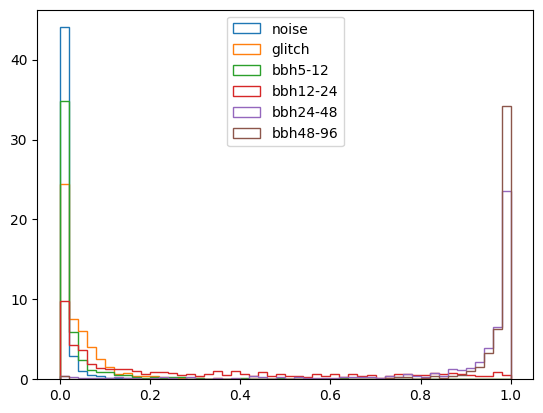

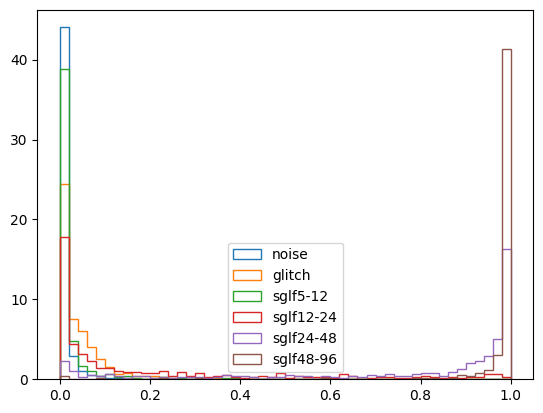

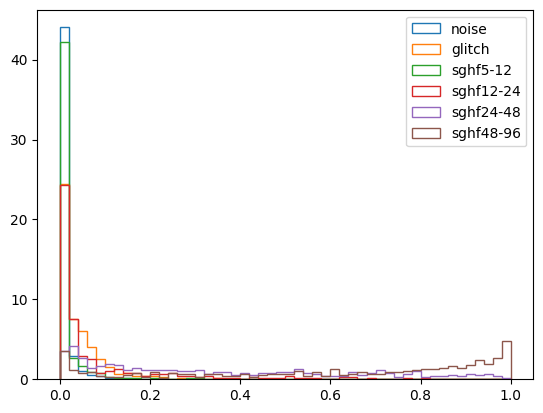

In [116]:
score_bkg = nn.Softmax(dim = 1)(model(torch.FloatTensor(dataset_wsl_fft['noise'])))[:,2].detach().numpy()
score_glitch = nn.Softmax(dim = 1)(model(torch.FloatTensor(dataset_wsl_fft['glitch'])))[:,2].detach().numpy()

for type in ['bbh', 'sglf', 'sghf']:
    
    plt.hist(score_bkg, bins = 50, range = (0,1), histtype = 'step', density = True, label = 'noise')
    plt.hist(score_glitch, bins = 50, range = (0,1), histtype = 'step', density = True, label = 'glitch')
    
    for snr in ['5-12', '12-24', '24-48', '48-96']:
        
        score = nn.Softmax(dim = 1)(model(torch.FloatTensor(dataset_wsl_fft[type+snr])))[:,2].detach().numpy()
        plt.hist(score, bins = 50, range = (0,1), histtype = 'step', density = True, label = type+snr)
        


    plt.legend()
    plt.show()

In [117]:
FPR_list = {}

score_bkg = nn.Softmax(dim = 1)(model(torch.FloatTensor(dataset_wsl_fft['noise'])))[:,2].detach().numpy()
score_glitch = nn.Softmax(dim = 1)(model(torch.FloatTensor(dataset_wsl_fft['glitch'])))[:,2].detach().numpy()

for type in ['bbh', 'sglf', 'sghf']:
    
    for snr in ['5-12', '12-24', '24-48', '48-96']:
        
        score = nn.Softmax(dim = 1)(model(torch.FloatTensor(dataset_wsl_fft[type+snr])))[:,2].detach().numpy()
        
        noise_events_passed = np.sum(score_bkg > np.sort(score)[int(0.1 * len(score))])
        glitch_events_passed = np.sum(score_glitch > np.sort(score)[int(0.1 * len(score))])
        
        FPR = (noise_events_passed + glitch_events_passed) / (len(score_bkg) + len(score_glitch))
        
        FPR_list[type+snr] = FPR

In [118]:
FPR_list

{'bbh5-12': 0.7752857142857142,
 'bbh12-24': 0.26995238095238094,
 'bbh24-48': 0.0008095238095238096,
 'bbh48-96': 9.523809523809524e-05,
 'sglf5-12': 0.8195714285714286,
 'sglf12-24': 0.5068095238095238,
 'sglf24-48': 0.024142857142857143,
 'sglf48-96': 9.523809523809524e-05,
 'sghf5-12': 0.8527619047619047,
 'sghf12-24': 0.6082380952380952,
 'sghf24-48': 0.11895238095238095,
 'sghf48-96': 0.07285714285714286}

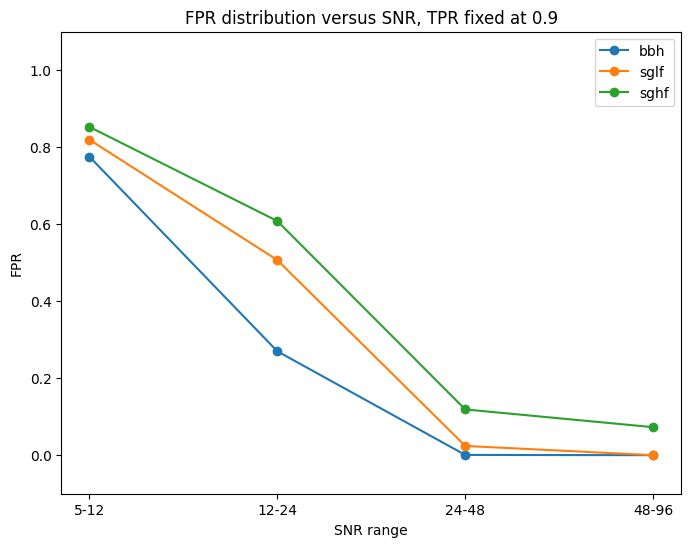

In [129]:
snr_list = ['5-12', '12-24', '24-48', '48-96']

plt.figure(figsize=(8,6))

for type in ['bbh', 'sglf', 'sghf']:
    
    FPR_data = np.empty(4)
    
    for i in range(4):
        
        FPR_data[i] = FPR_list[type+snr_list[i]]
        
    central_point = np.array([9,18,36,72])
        
    # plt.scatter(['5-12','12-24','24-48','48-96'], FPR_data, label = type)
    plt.plot(['5-12','12-24','24-48','48-96'], FPR_data, marker = 'o', label = type)
    
    
# plt.xlim(0,96)
plt.ylim(-0.1,1.1)
plt.xlabel('SNR range')
plt.ylabel('FPR')

plt.title('FPR distribution versus SNR, TPR fixed at 0.9')

plt.legend()
plt.show()

In [138]:
TPR_list = {}

score_bkg = nn.Softmax(dim = 1)(model(torch.FloatTensor(dataset_wsl_fft['noise'])))[:,2].detach().numpy()
score_glitch = nn.Softmax(dim = 1)(model(torch.FloatTensor(dataset_wsl_fft['glitch'])))[:,2].detach().numpy()

score_bkgevents = np.concatenate((score_bkg, score_glitch))

threshold = np.sort(score_bkgevents)[-int(0.001 * len(score_bkgevents))]

for type in ['bbh', 'sglf', 'sghf']:
    
    for snr in ['5-12', '12-24', '24-48', '48-96']:
        
        score = nn.Softmax(dim = 1)(model(torch.FloatTensor(dataset_wsl_fft[type+snr])))[:,2].detach().numpy()
        
        TPR = np.sum(score > threshold) / len(score)
        
        TPR_list[type+snr] = TPR

In [139]:
TPR_list

{'bbh5-12': 0.008,
 'bbh12-24': 0.248,
 'bbh24-48': 0.908,
 'bbh48-96': 0.9826666666666667,
 'sglf5-12': 0.0026666666666666666,
 'sglf12-24': 0.144,
 'sglf24-48': 0.7626666666666667,
 'sglf48-96': 0.972,
 'sghf5-12': 0.0013333333333333333,
 'sghf12-24': 0.037333333333333336,
 'sghf24-48': 0.272,
 'sghf48-96': 0.624}

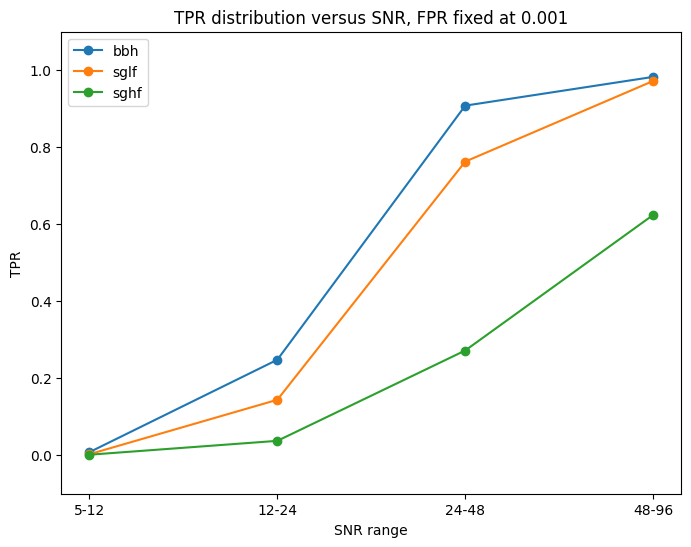

In [141]:
snr_list = ['5-12', '12-24', '24-48', '48-96']

plt.figure(figsize=(8,6))

for type in ['bbh', 'sglf', 'sghf']:
    
    TPR_data = np.empty(4)
    
    for i in range(4):
        
        TPR_data[i] = TPR_list[type+snr_list[i]]
        
    # central_point = np.array([9,18,36,72])
        
    # plt.scatter(['5-12','12-24','24-48','48-96'], FPR_data, label = type)
    plt.plot(['5-12','12-24','24-48','48-96'], TPR_data, marker = 'o', label = type)
    
    
# plt.xlim(0,96)
plt.ylim(-0.1,1.1)
plt.xlabel('SNR range')
plt.ylabel('TPR')

plt.title('TPR distribution versus SNR, FPR fixed at 0.001')

plt.legend()
plt.show()

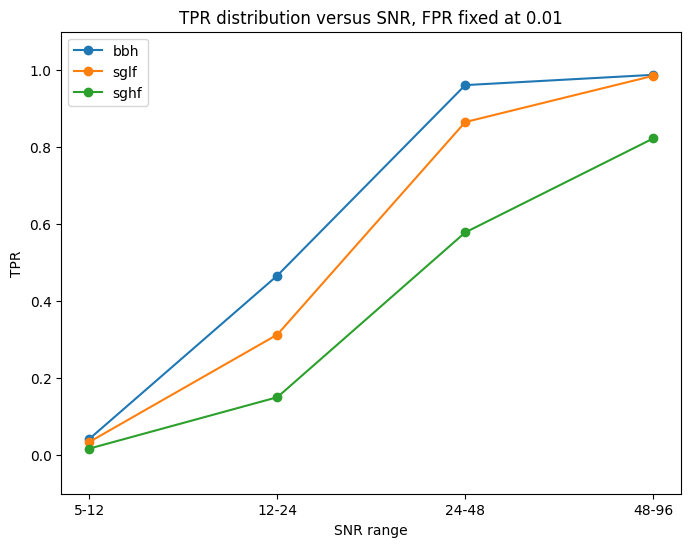

In [137]:
snr_list = ['5-12', '12-24', '24-48', '48-96']

plt.figure(figsize=(8,6))

for type in ['bbh', 'sglf', 'sghf']:
    
    TPR_data = np.empty(4)
    
    for i in range(4):
        
        TPR_data[i] = TPR_list[type+snr_list[i]]
        
    # central_point = np.array([9,18,36,72])
        
    # plt.scatter(['5-12','12-24','24-48','48-96'], FPR_data, label = type)
    plt.plot(['5-12','12-24','24-48','48-96'], TPR_data, marker = 'o', label = type)
    
    
# plt.xlim(0,96)
plt.ylim(-0.1,1.1)
plt.xlabel('SNR range')
plt.ylabel('TPR')

plt.title('TPR distribution versus SNR, FPR fixed at 0.01')

plt.legend()
plt.show()

In [ ]:
cnt = 0

np.sum(listResult['ans'][cnt][-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:] == 0)

323

In [ ]:
cnt = 20

np.sum(listResult['ans'][cnt][-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:] == 1)

608

In [ ]:
cnt = 0

np.sum(listResult['ans'][cnt][N_wsl['glitch']:N_wsl['glitch']+N_wsl['noise']] == 0)

36

In [ ]:
dcd[datatype][-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:][not_select[-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:]].shape

(5608,)

In [ ]:
np.sum(not_select[-N_wsl['bbh']-N_wsl['sglf']-N_wsl['sghf']:])

5608

In [ ]:
version = 'v12'

In [ ]:
models = torch.load("../Data_cached/SequentialTraining/WSL/trained_model" + "".join(['4','0']) + "_"+version+".json")

In [ ]:
dataset_wsl_fft.keys()

dict_keys(['noise', 'bbh5-12', 'sglf5-12', 'sghf5-12', 'bbh12-24', 'sglf12-24', 'sghf12-24', 'bbh24-48', 'sglf24-48', 'sghf24-48', 'bbh48-96', 'sglf48-96', 'sghf48-96', 'glitch'])

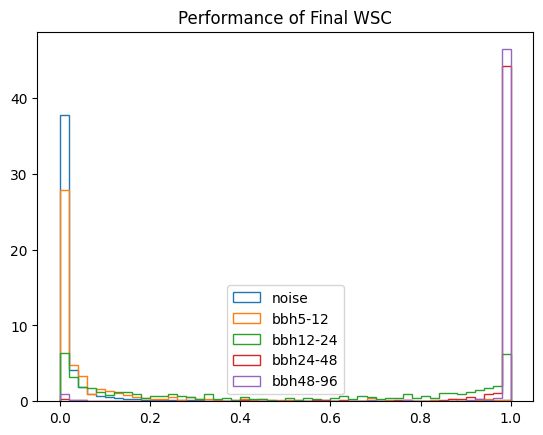

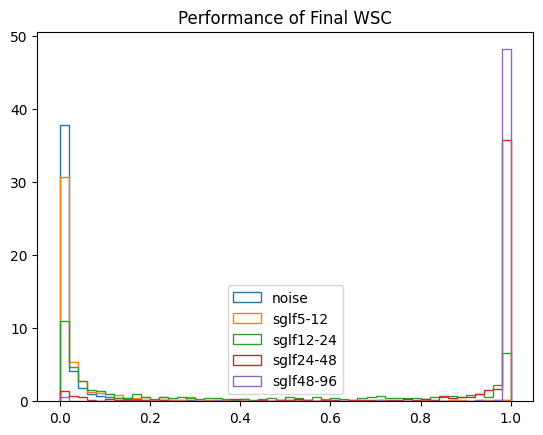

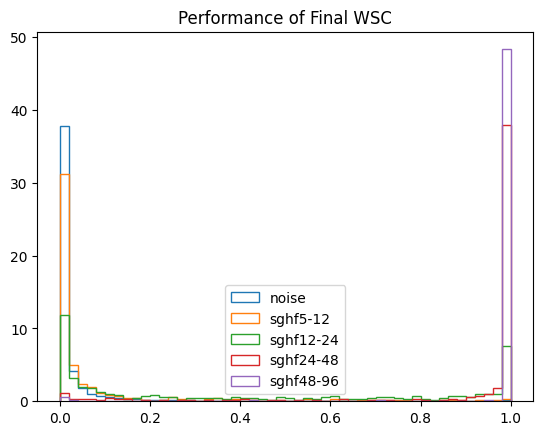

In [ ]:
model = models['noise_WSC']

bkg_filtered = dataset_wsl_fft['noise']
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
# glitch_filtered = dataset_wsl_fft['glitch']

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    plt.title("Performance of Final WSC")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

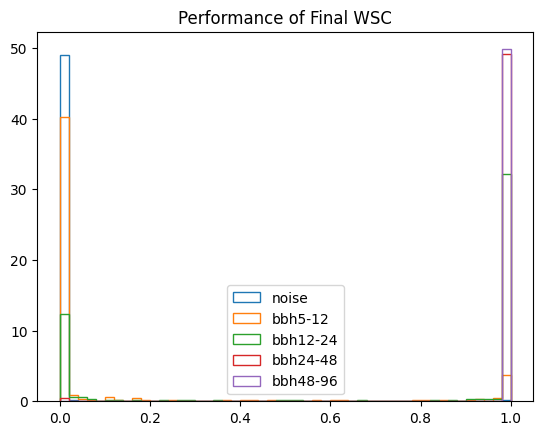

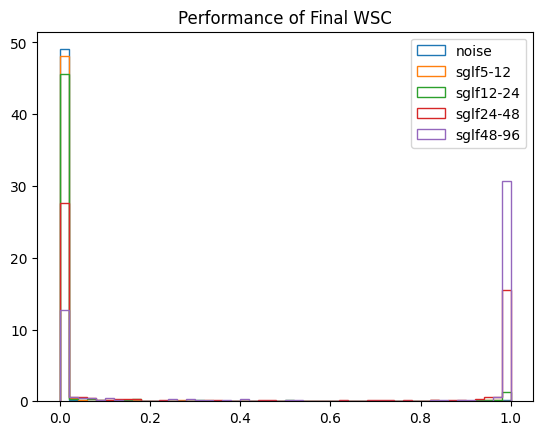

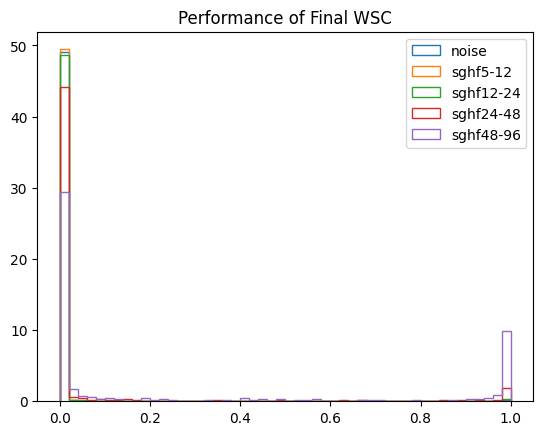

In [ ]:
model = models['BBH_CNN_WSC']

bkg_filtered = dataset_wsl_fft['noise']
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
# glitch_filtered = dataset_wsl_fft['glitch']

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    plt.title("Performance of Final WSC")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

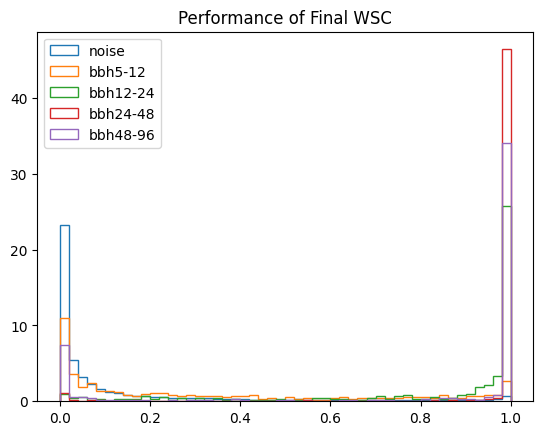

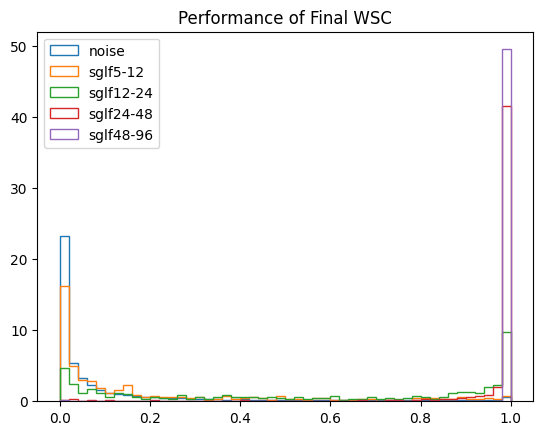

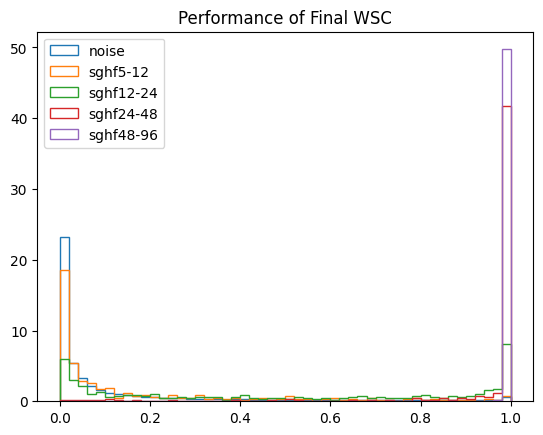

In [ ]:
# v12

model = models['Final_WSC']

bkg_filtered = dataset_wsl_fft['noise']
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
# glitch_filtered = dataset_wsl_fft['glitch']

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    plt.title("Performance of Final WSC")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

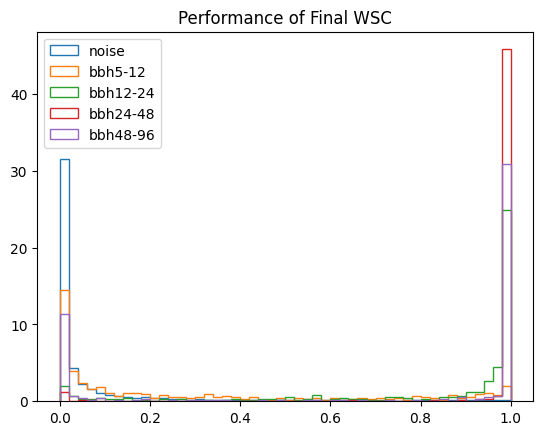

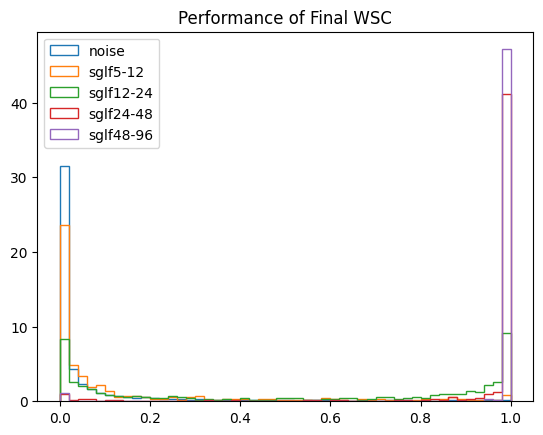

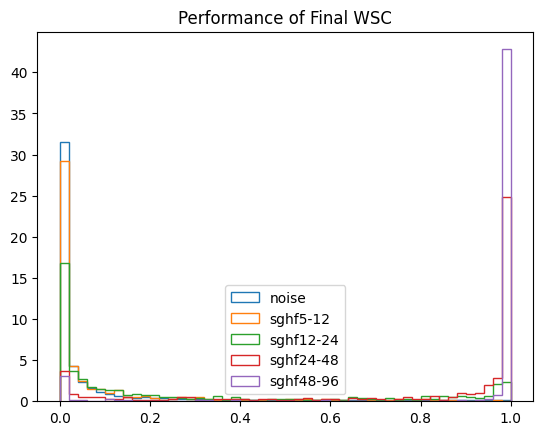

In [ ]:
# v15

model = models['Final_WSC']

bkg_filtered = dataset_wsl_fft['noise']
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
# glitch_filtered = dataset_wsl_fft['glitch']

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    plt.title("Performance of Final WSC")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

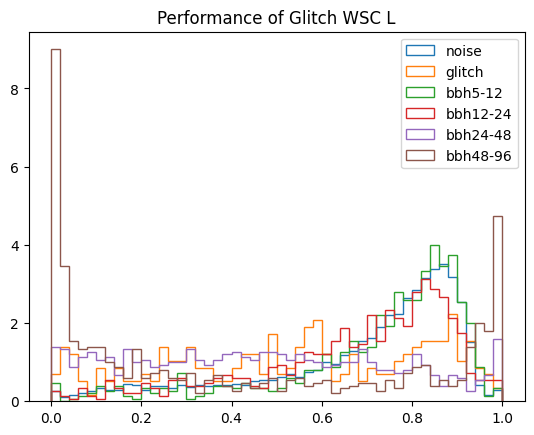

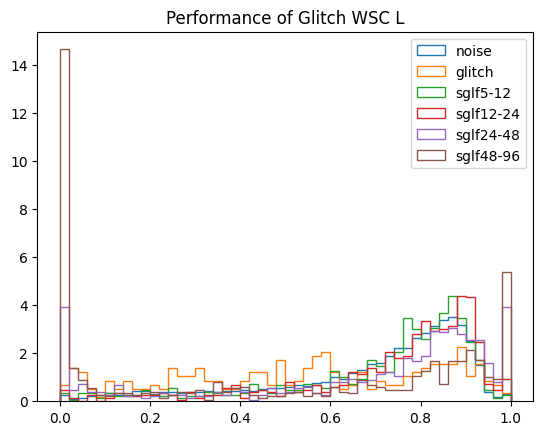

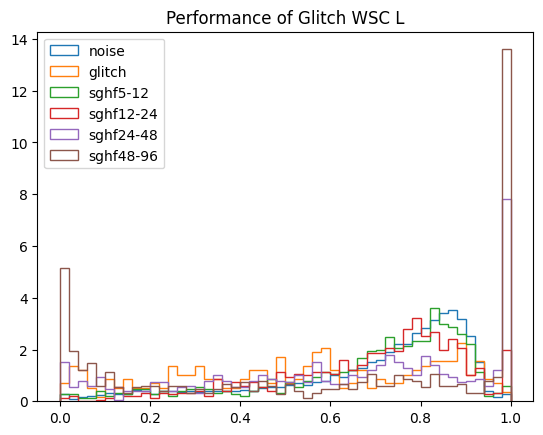

In [ ]:
model = models['glitch_WSC_L']

bkg_filtered = dataset_wsl_fft['noise'][:,:101]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
glitch_filtered = dataset_wsl_fft['glitch'][:,:101]

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_filtered)).detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
    plt.title("Performance of Glitch WSC L")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key][:,:101]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

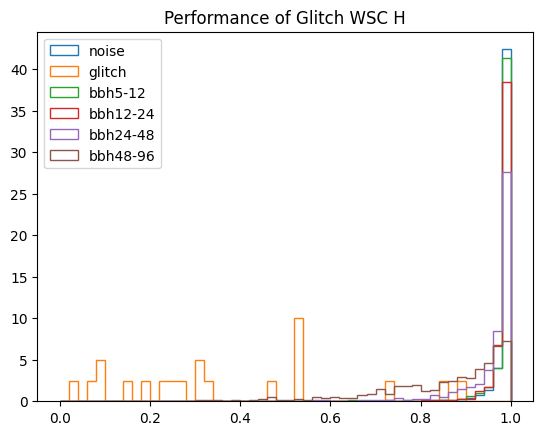

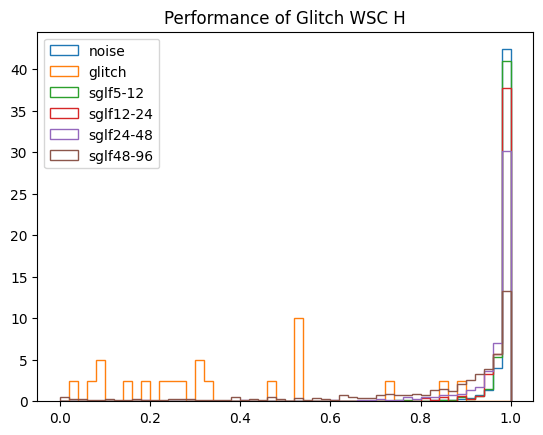

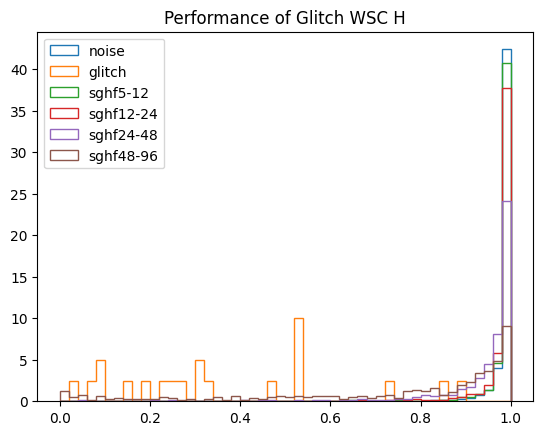

In [ ]:
model = models['glitch_WSC_H']

bkg_filtered = dataset_wsl_fft['noise'][:,101:]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
glitch_filtered = dataset_wsl_fft['glitch'][:,101:]

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_filtered)).detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
    plt.title("Performance of Glitch WSC H")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key][:,101:]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

In [ ]:
models

{'glitch_WSC_L': WSClassifier_Onedetector(
   (fc1): Linear(in_features=101, out_features=32, bias=True)
   (norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU()
   (sigmoid): Sigmoid()
   (fc2): Linear(in_features=32, out_features=1, bias=True)
 ),
 'glitch_WSC_H': WSClassifier_Onedetector(
   (fc1): Linear(in_features=101, out_features=32, bias=True)
   (norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU()
   (sigmoid): Sigmoid()
   (fc2): Linear(in_features=32, out_features=1, bias=True)
 ),
 'noise': AutoEncoder(
   (encoder): Sequential(
     (0): Linear(in_features=202, out_features=20, bias=True)
     (1): ReLU()
     (2): Linear(in_features=20, out_features=10, bias=True)
     (3): ReLU()
   )
   (decoder): Sequential(
     (0): Linear(in_features=10, out_features=20, bias=True)
     (1): ReLU()
     (2): Linear(in_features=20, out_features=202, bias=True)
     (3): Sigmoid

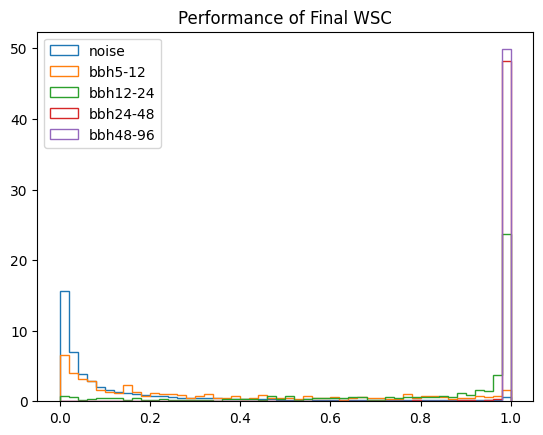

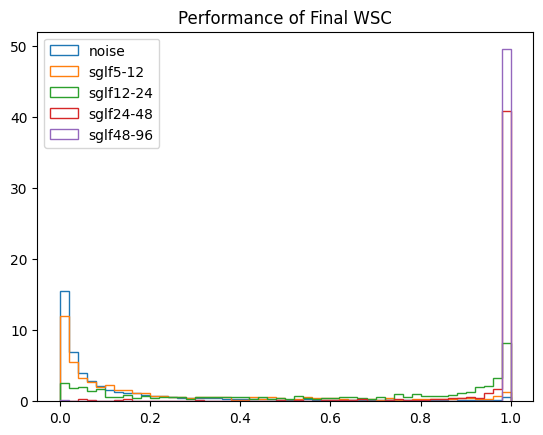

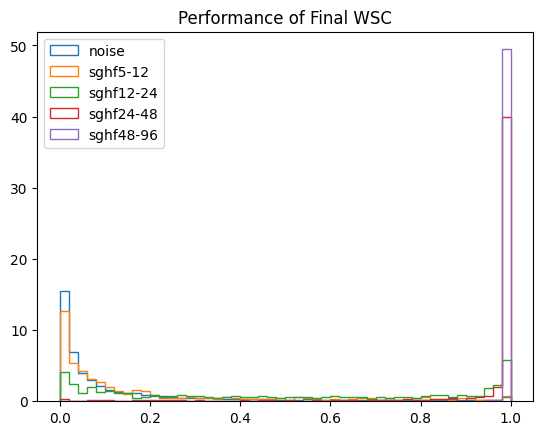

In [ ]:
# v14

model = models['Final_WSC']

bkg_filtered = dataset_wsl_fft['noise']
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
# glitch_filtered = dataset_wsl_fft['glitch']

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    plt.title("Performance of Final WSC")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

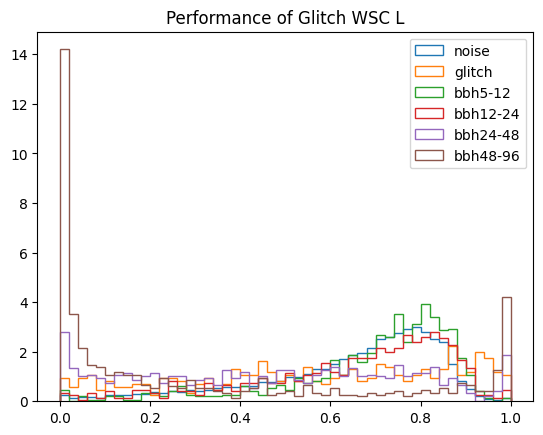

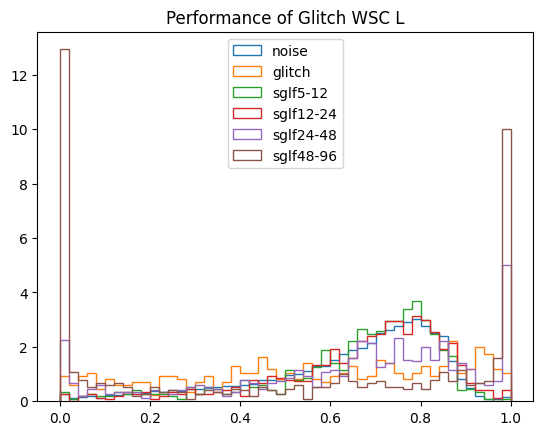

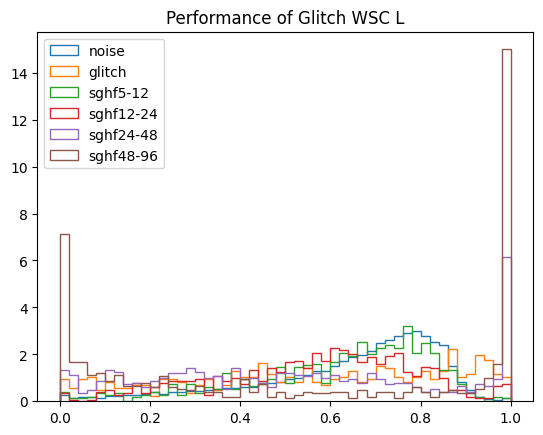

In [ ]:
# v14

model = models['glitch_WSC_L']

bkg_filtered = dataset_wsl_fft['noise'][:,:101]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
glitch_filtered = dataset_wsl_fft['glitch'][:,:101]

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_filtered)).detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
    plt.title("Performance of Glitch WSC L")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key][:,:101]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

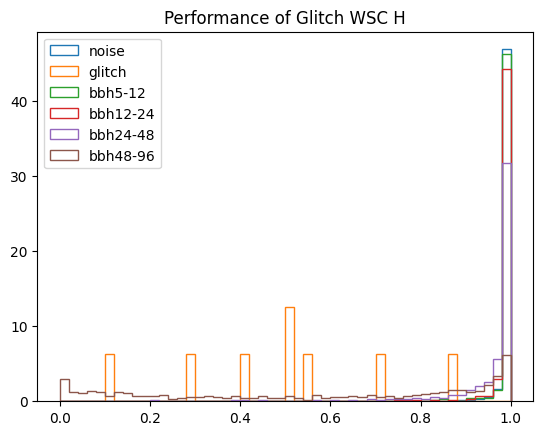

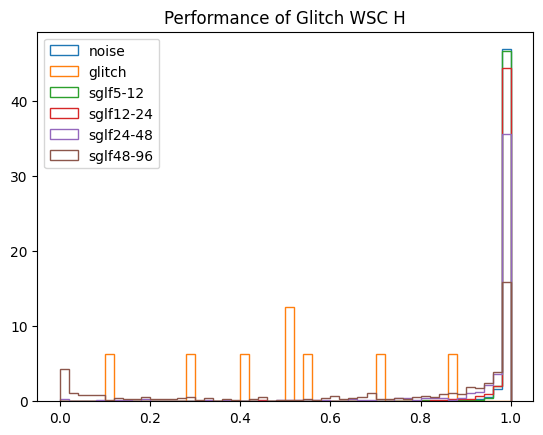

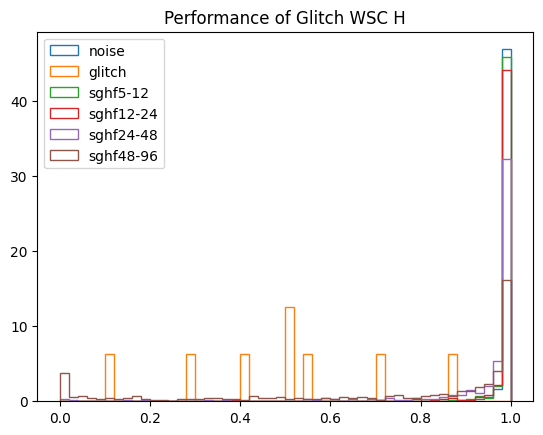

In [ ]:
# v14

model = models['glitch_WSC_H']

bkg_filtered = dataset_wsl_fft['noise'][:,101:]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
glitch_filtered = dataset_wsl_fft['glitch'][:,101:]

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_filtered)).detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
    plt.title("Performance of Glitch WSC H")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key][:,101:]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

In [ ]:
cutList['glitch_L']

array([0.0008, 0.0012, 0.0016, 0.002 , 0.0024])

In [ ]:
ic[2]

4

23250 events passed to AE for training. 


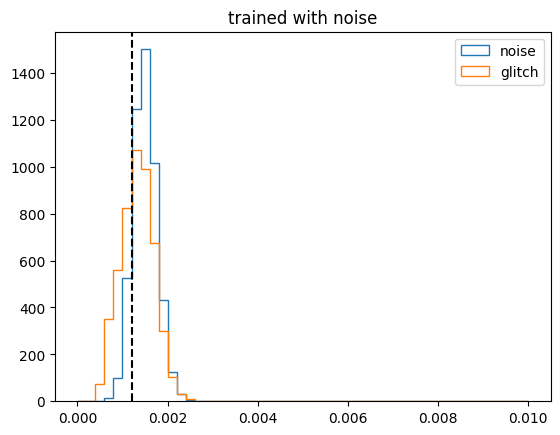

In [ ]:
# v14

model = trainAE_Onedetector(dataset_ae_fft['glitch'][:,:101], 'test', 'test', 'test')

dcd_bkg = model(torch.FloatTensor(dataset_wsl_fft['noise'][:,:101]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(dataset_ae_fft['glitch'][:,:101]))[1].detach().numpy()

foo = plt.hist(np.var(dataset_wsl_fft['noise'][:,:101]-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(dataset_ae_fft['glitch'][:,:101]-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
plt.axvline(cutList['glitch_L'][ic[2]], color="k", linestyle="--")
plt.legend()

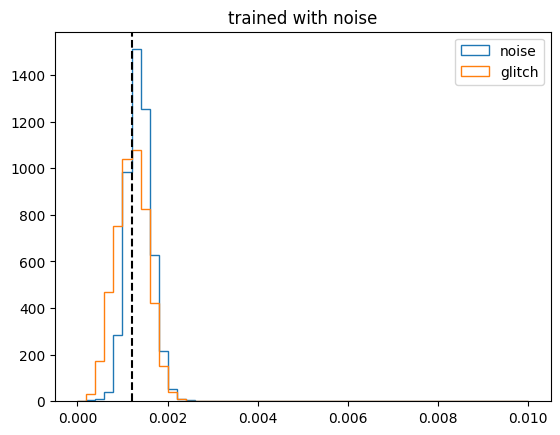

In [ ]:
# v14

model = models['glitch_L']

dcd_bkg = model(torch.FloatTensor(dataset_wsl_fft['noise'][:,:101]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(dataset_ae_fft['glitch'][:,:101]))[1].detach().numpy()

foo = plt.hist(np.var(dataset_wsl_fft['noise'][:,:101]-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(dataset_ae_fft['glitch'][:,:101]-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
plt.axvline(cutList['glitch_L'][ic[2]], color="k", linestyle="--")
plt.legend()

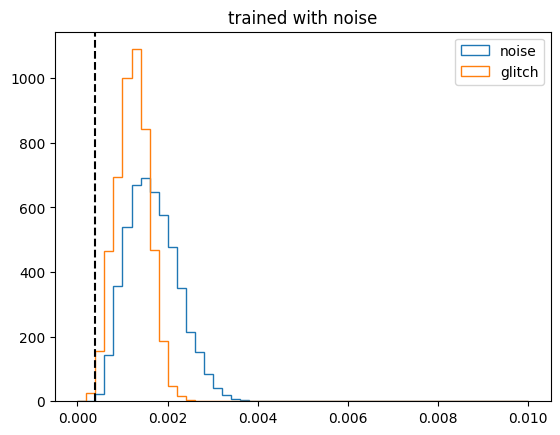

In [ ]:
# v14

model = models['glitch_H']

dcd_bkg = model(torch.FloatTensor(dataset_wsl_fft['noise'][:,101:]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(dataset_ae_fft['glitch'][:,101:]))[1].detach().numpy()

foo = plt.hist(np.var(dataset_wsl_fft['noise'][:,101:]-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(dataset_ae_fft['glitch'][:,101:]-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
plt.axvline(cutList['glitch_H'][ic[3]], color="k", linestyle="--")
plt.legend()

### test training the glitch AE

In [ ]:
models = {}

In [59]:
models = {};
models["glitch_L"] = torch.load('../Model_cached/1_det_L_glitch_trained_with_permutation_1.pt')
models["glitch_H"] = torch.load('../Model_cached/1_det_H_glitch_trained_with_permutation_1.pt')

In [63]:
dataset_wsl_fft_filtered = dataset_wsl_fft_collected

In [ ]:
# model = trainAE_Onedetector(dataset_ae_fft['glitch'][:,:101], 'test', 'test', 'glitch')
# models['glitch_L'] = model

# model = trainAE_Onedetector(dataset_ae_fft['glitch'][:,101:], 'test', 'test', 'glitch')
# models['glitch_H'] = model

dcd = models['glitch_L'](torch.FloatTensor(dataset_wsl_fft_filtered[:,:101]))[1].detach().numpy()

dataset0 = dataset_ae_fft['glitch'][:,:101]
dataset1 = dataset_wsl_fft_filtered[np.var(dataset_wsl_fft_filtered[:,:101]-dcd, axis=1) > cutList['glitch_L'][1]][:,:101]

model_L = trainWSC_Onedetector(dataset0, dataset1, 'test', 'test', 'glitch')
models["glitch_WSC_L"] = model_L


dcd = models['glitch_H'](torch.FloatTensor(dataset_wsl_fft_filtered[:,101:]))[1].detach().numpy()

dataset0 = dataset_ae_fft['glitch'][:,101:]
dataset1 = dataset_wsl_fft_filtered[np.var(dataset_wsl_fft_filtered[:,101:]-dcd, axis=1) > cutList['glitch_H'][0]][:,101:]

model_H = trainWSC_Onedetector(dataset0, dataset1, 'test', 'test', 'glitch')
models["glitch_WSC_H"] = model_H

39250 noise events and 24515 signal events passed to WSC for training. 
39250 noise events and 29921 signal events passed to WSC for training. 


In [ ]:
dcd = models['glitch_L'](torch.FloatTensor(dataset_wsl_fft['noise'][:,:101]))[1].detach().numpy()

dataset0 = dataset_ae_fft['glitch'][:,:101]
dataset1 = dataset_wsl_fft['noise'][np.var(dataset_wsl_fft['noise'][:,:101]-dcd, axis=1) > cutList['glitch_L'][3]][:,:101]

model_L = trainWSC_Onedetector(dataset0, dataset1, 'test', 'test', 'glitch')
models["glitch_WSC_L"] = model_L

39250 noise events and 492 signal events passed to WSC for training. 


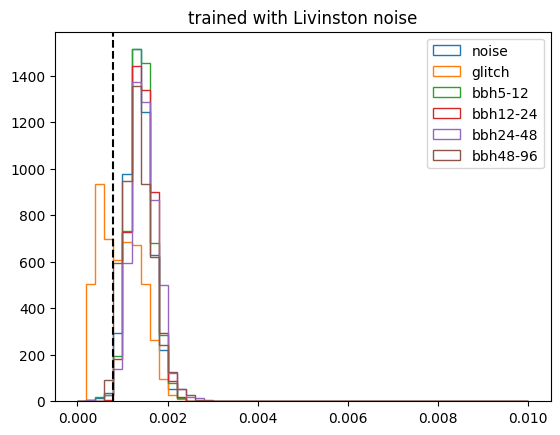

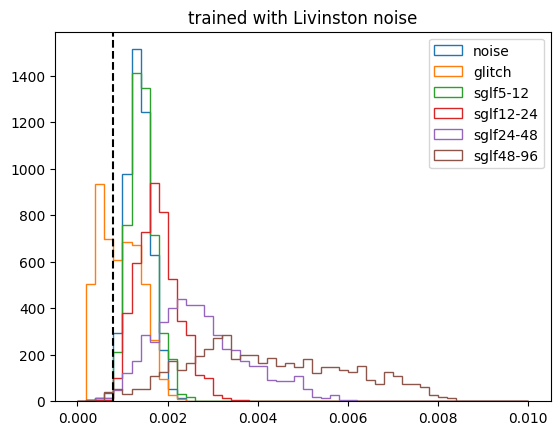

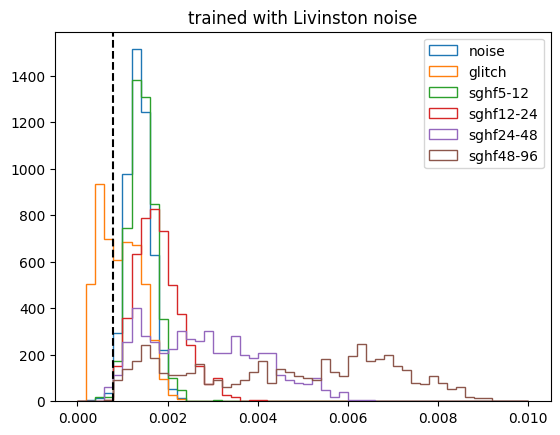

In [64]:
# test

model = models['glitch_L']

dcd_bkg = model(torch.FloatTensor(dataset_wsl_fft['noise'][:,:101]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(dataset_ae_fft['glitch'][:,:101]))[1].detach().numpy()

for key in ['bbh', 'sglf', 'sghf']:

    foo = plt.hist(np.var(dataset_wsl_fft['noise'][:,:101]-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    foo = plt.hist(np.var(dataset_ae_fft['glitch'][:,:101]-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")

    for snr in snr_range:
        key_to_plot = key+snr
        dcd_signal = model(torch.FloatTensor(dataset_wsl_fft[key_to_plot][:,:101]))[1].detach().numpy()
        plt.hist(np.var(dataset_wsl_fft[key_to_plot][:,:101] - dcd_signal, axis = 1), histtype="step", range=(0, 0.01), bins=50, density=True, label=key_to_plot)



    plt.title("trained with Livinston noise")
    plt.axvline(cutList['glitch_L'][0], color="k", linestyle="--")
    plt.legend()
    
    plt.show()

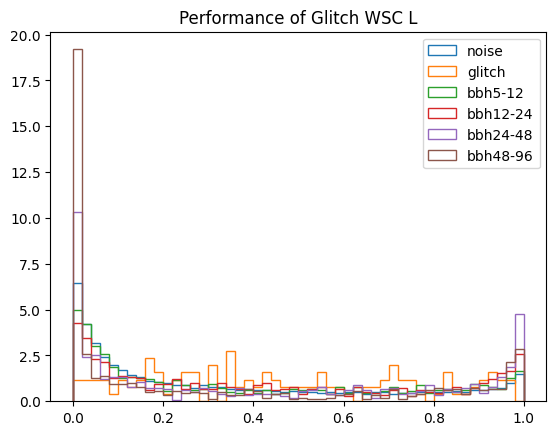

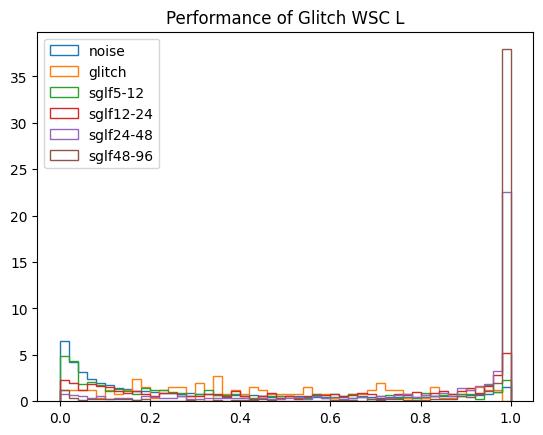

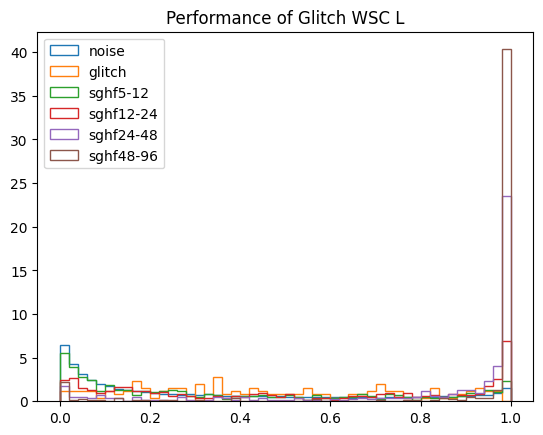

In [ ]:
# test

model = models['glitch_WSC_L']

bkg_filtered = dataset_wsl_fft['noise'][:,:101]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
glitch_filtered = dataset_wsl_fft['glitch'][:,:101]

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_filtered)).detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
    plt.title("Performance of Glitch WSC L")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key][:,:101]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

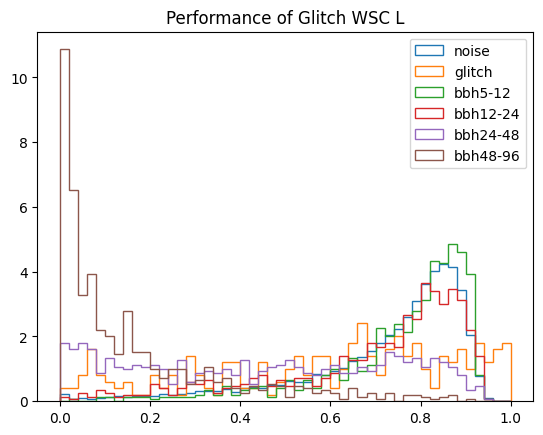

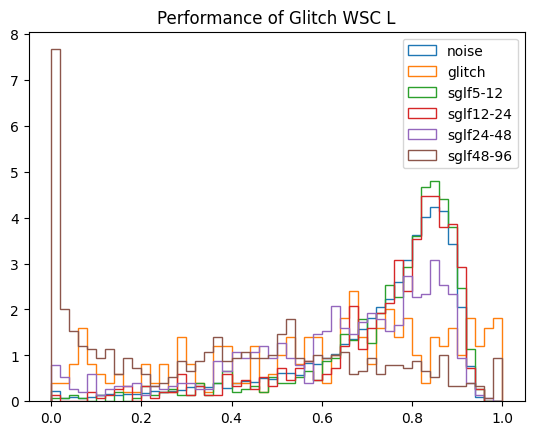

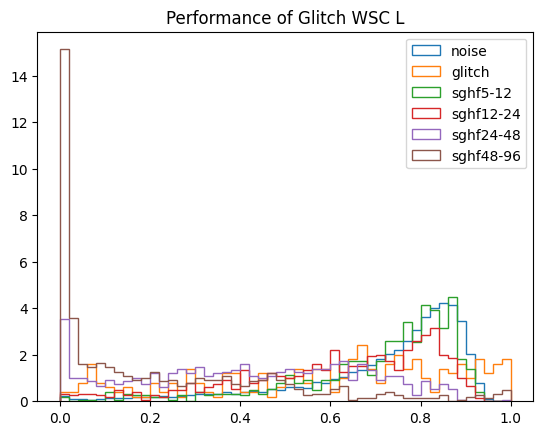

In [ ]:
# test

model = models['glitch_WSC_L']

bkg_filtered = dataset_wsl_fft['noise'][:,:101]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
glitch_filtered = dataset_wsl_fft['glitch'][:,:101]

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_filtered)).detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
    plt.title("Performance of Glitch WSC L")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key][:,:101]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

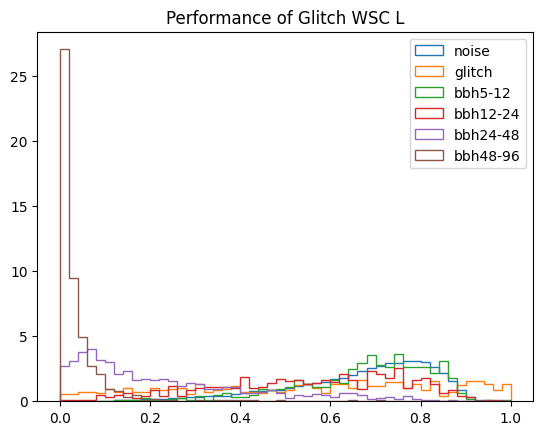

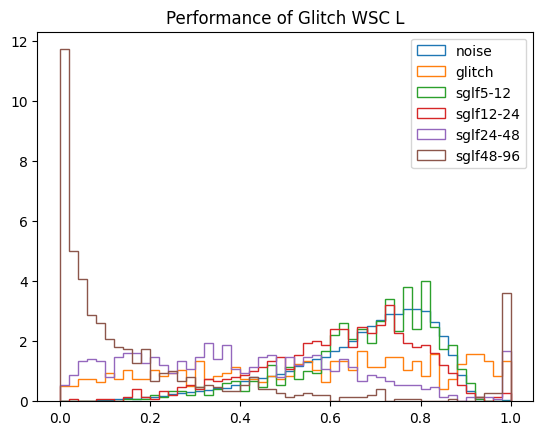

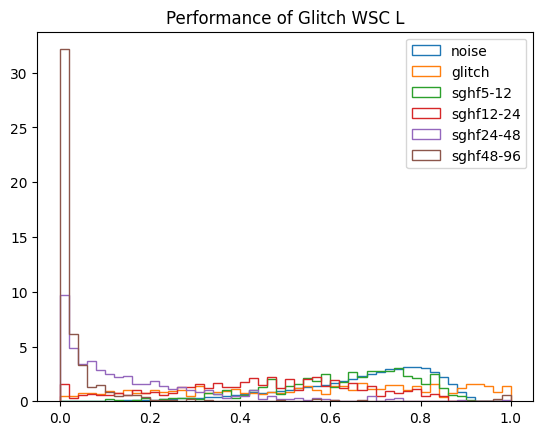

In [ ]:
# test

model = models['glitch_WSC_L']

bkg_filtered = dataset_wsl_fft['noise'][:,:101]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
glitch_filtered = dataset_wsl_fft['glitch'][:,:101]

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_filtered)).detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
    plt.title("Performance of Glitch WSC L")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key][:,:101]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()
    # plt.ylim(0,2000)

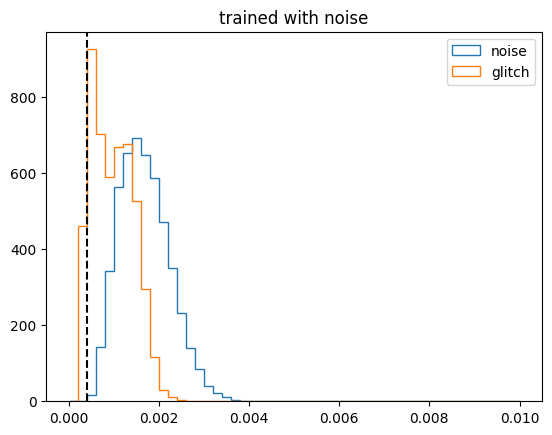

In [65]:
# test

model = models['glitch_H']

dcd_bkg = model(torch.FloatTensor(dataset_wsl_fft['noise'][:,101:]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(dataset_ae_fft['glitch'][:,101:]))[1].detach().numpy()

foo = plt.hist(np.var(dataset_wsl_fft['noise'][:,101:]-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(dataset_ae_fft['glitch'][:,101:]-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
plt.axvline(cutList['glitch_H'][0], color="k", linestyle="--")
plt.legend()

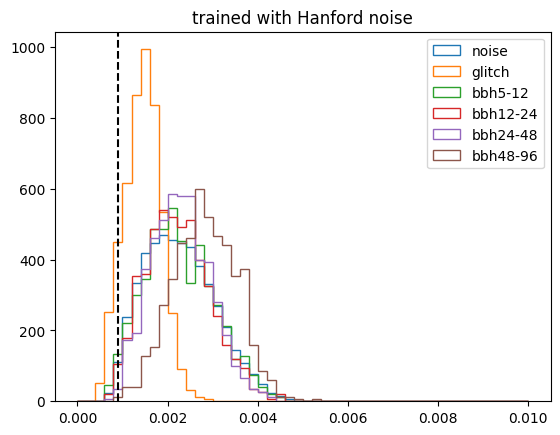

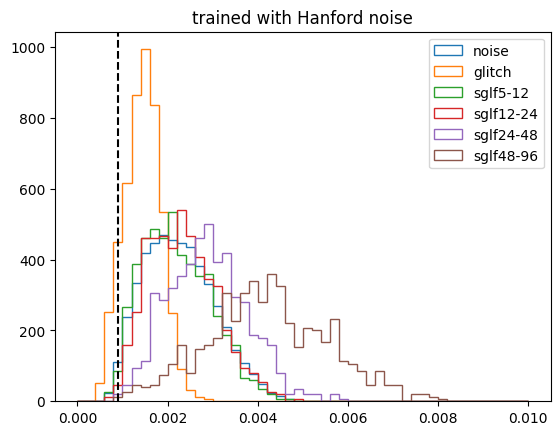

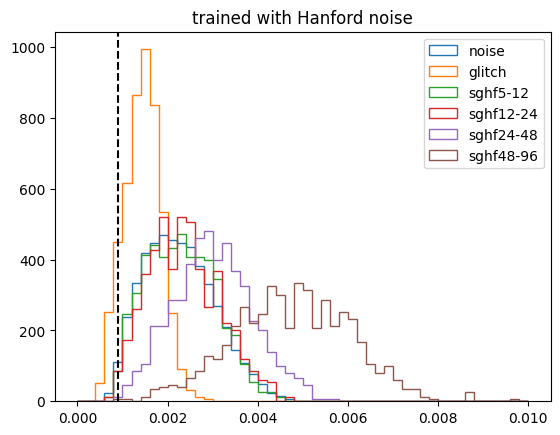

In [ ]:
# test

model = models['glitch_H']

dcd_bkg = model(torch.FloatTensor(dataset_wsl_fft['noise'][:,101:]))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
# dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(dataset_ae_fft['glitch'][:,101:]))[1].detach().numpy()

for key in ['bbh', 'sglf', 'sghf']:

    foo = plt.hist(np.var(dataset_wsl_fft['noise'][:,101:]-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    foo = plt.hist(np.var(dataset_ae_fft['glitch'][:,101:]-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")

    for snr in snr_range:
        key_to_plot = key+snr
        dcd_signal = model(torch.FloatTensor(dataset_wsl_fft[key_to_plot][:,101:]))[1].detach().numpy()
        plt.hist(np.var(dataset_wsl_fft[key_to_plot][:,101:] - dcd_signal, axis = 1), histtype="step", range=(0, 0.01), bins=50, density=True, label=key_to_plot)



    plt.title("trained with Hanford noise")
    plt.axvline(cutList['glitch_H'][1], color="k", linestyle="--")
    plt.legend()
    
    plt.show()

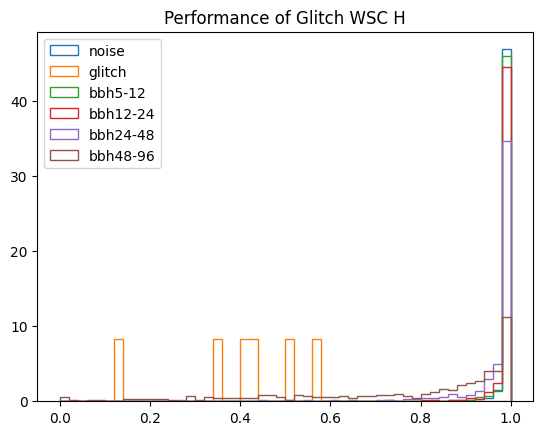

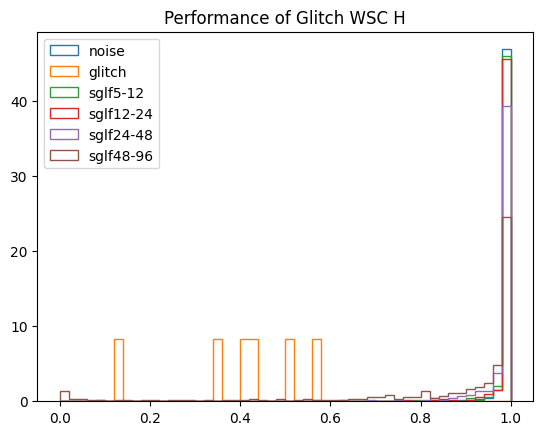

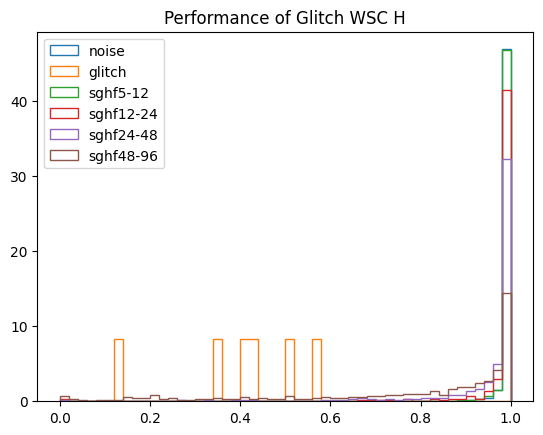

In [ ]:
# test
model = models['glitch_WSC_H']

bkg_filtered = dataset_wsl_fft['noise'][:,101:]
# bbh_filtered = dataset_wsl_fft['bbh']
# sg_filtered = dataset_wsl_fft['sg']
glitch_filtered = dataset_wsl_fft['glitch'][:,101:]

# c0[currentStep] = 0.0022;
    
dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
# dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
# dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_filtered)).detach().numpy()

for signal_type in ['bbh', 'sglf', 'sghf']:

    # foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
    # foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
    foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
    plt.title("Performance of Glitch WSC H")
        
        
    for snr in snr_range:

        key = signal_type+snr
        dcd_signal = nn.Sigmoid()(model(torch.FloatTensor(dataset_wsl_fft[key][:,101:]))).detach().numpy()
        foo = plt.hist(dcd_signal, histtype="step", range=(0, 1), bins=50, density=True, label=key)


    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.show()